In [68]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set someparameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# Path for Windows
TRAIN_PATH = 'F:\\MA\\data\\kaggle\\stage1_train\\'
TEST_PATH = 'F:\MA\\data\\kaggle\\stage1_test\\'

# Path for Linux
#TRAIN_PATH = '../UNet/kaggle/input/stage1_train/'
#TEST_PATH = '../UNet/kaggle/input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [35]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]


In [37]:
# Get and resize train images and masks
# X_train: original images
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# Y_train: masks
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')

sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

    
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 




  0%|                                                                                          | 0/670 [00:00<?, ?it/s]

  0%|                                                                                  | 1/670 [00:00<01:08,  9.73it/s]

  0%|▏                                                                                 | 2/670 [00:00<01:13,  9.07it/s]

  0%|▎                                                                                 | 3/670 [00:00<01:39,  6.67it/s]

  1%|▍                                                                                 | 4/670 [00:00<02:08,  5.18it/s]

  1%|▋                                                                                 | 6/670 [00:00<01:41,  6.55it/s]

  1%|▊                                                                                 | 7/670 [00:01<02:06,  5.24it/s]

  1%|▉                                                                                 | 8/670 [00:01<01:52,  5.87it/s]

  1%|█▏                       

KeyboardInterrupt: 

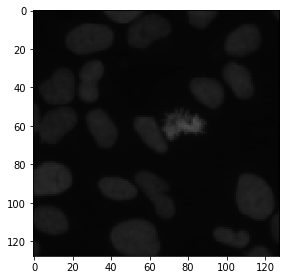

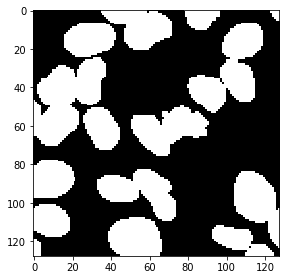

In [17]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [18]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [19]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
________________________________________________________________________________________________

In [25]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/50
603/603 [==============================] - 54s 89ms/step - loss: 0.4374 - mean_iou: 0.4160 - val_loss: 0.2915 - val_mean_iou: 0.4385

Epoch 00001: val_loss improved from inf to 0.29148, saving model to model-dsbowl2018-1.h5
Epoch 2/50
603/603 [==============================] - 46s 76ms/step - loss: 0.2549 - mean_iou: 0.4712 - val_loss: 0.1628 - val_mean_iou: 0.5096

Epoch 00002: val_loss improved from 0.29148 to 0.16279, saving model to model-dsbowl2018-1.h5
Epoch 3/50
603/603 [==============================] - 46s 76ms/step - loss: 0.1698 - mean_iou: 0.5457 - val_loss: 0.1168 - val_mean_iou: 0.5773

Epoch 00003: val_loss improved from 0.16279 to 0.11680, saving model to model-dsbowl2018-1.h5
Epoch 4/50
603/603 [==============================] - 46s 76ms/step - loss: 0.1491 - mean_iou: 0.6015 - val_loss: 0.1140 - val_mean_iou: 0.6209

Epoch 00004: val_loss improved from 0.11680 to 0.11403, saving model to model-dsbowl2018-1.h5
Epo

In [20]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - ETA:  - ETA:  - 3s 40ms/step


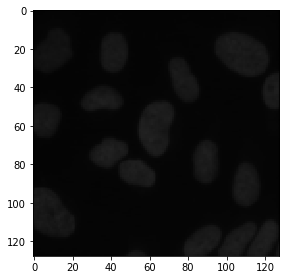

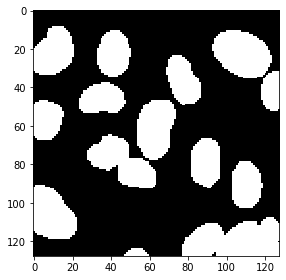

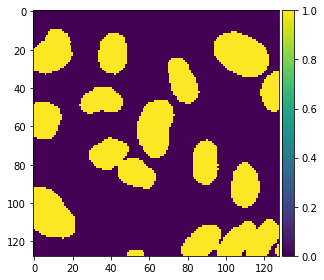

In [21]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

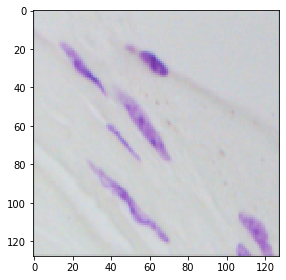

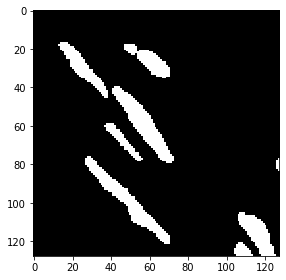

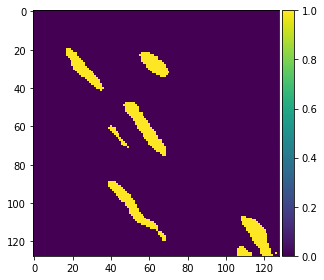

In [22]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

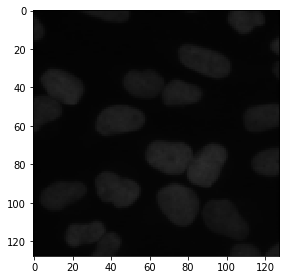

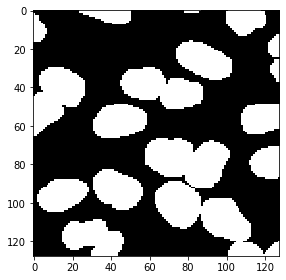

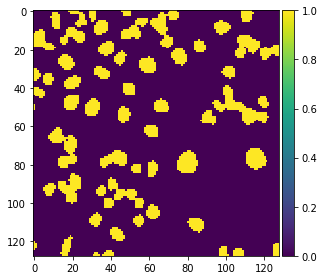

In [23]:
# Perform a check on some random test samples
#ix = random.randint(0, len(preds_test_t))
ix = -1
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()

In [24]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [25]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [26]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)

In [27]:
len(new_test_ids)

1906

In [28]:
sub.groupby('ImageId').ngroup()

0        0
1        0
2        0
3        0
4        0
        ..
1901    64
1902    64
1903    64
1904    64
1905    64
Length: 1906, dtype: int64

In [30]:
len(test_ids)

65

In [65]:
STAGE2_PATH = 'F:\MA\\data\\kaggle\\stage2_test_final\\'
test2_ids = next(os.walk(STAGE2_PATH))[1]

# Get and resize stage2 test images
X_test2 = np.zeros((len(test2_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test2 = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test2_ids), total=len(test2_ids)):
    path = STAGE2_PATH + id_
    #print(id_)
    if id_ == '646f5e00a2db3add97fb80a83ef3c07edd1b17b1b0d47c2bd650cdcab9f322c0':
        img = imread(path + '/images/' + id_ + '.tif')[:,:,:IMG_CHANNELS]
    else:
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test2.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)
    X_test2[n] = img

print('Done!')

Getting and resizing test images ... 








  0%|                                                                                         | 0/3019 [00:00<?, ?it/s]





  0%|▏                                                                                | 5/3019 [00:00<01:17, 38.96it/s]





  0%|▏                                                                                | 9/3019 [00:00<01:21, 36.74it/s]





  0%|▎                                                                               | 13/3019 [00:00<01:23, 36.20it/s]





  1%|▍                                                                               | 16/3019 [00:00<01:30, 33.28it/s]





  1%|▌                                                                               | 20/3019 [00:00<01:33, 31.97it/s]





  1%|▋                                                                               | 24/3019 [00:00<01:33, 32.13it/s]





  1%|▊                                                                               | 29/3019 [00:00<01:25, 34.84it/s]

 21%|████████████████▎                                                              | 625/3019 [00:17<00:59, 40.26it/s]





 21%|████████████████▍                                                              | 630/3019 [00:18<01:04, 37.09it/s]





 21%|████████████████▌                                                              | 634/3019 [00:18<01:03, 37.75it/s]





 21%|████████████████▋                                                              | 638/3019 [00:18<01:07, 35.11it/s]





 21%|████████████████▊                                                              | 642/3019 [00:18<01:09, 34.22it/s]





 21%|████████████████▉                                                              | 646/3019 [00:18<01:08, 34.84it/s]





 22%|█████████████████                                                              | 650/3019 [00:18<01:11, 33.32it/s]





 22%|█████████████████                                                              | 654/3019 [00:18<01:10, 33.32it/s]







 40%|███████████████████████████████▌                                              | 1222/3019 [00:35<01:09, 25.95it/s]





 41%|███████████████████████████████▋                                              | 1227/3019 [00:36<01:00, 29.49it/s]





 41%|███████████████████████████████▊                                              | 1232/3019 [00:36<00:53, 33.44it/s]





 41%|███████████████████████████████▉                                              | 1236/3019 [00:36<01:17, 22.95it/s]





 41%|████████████████████████████████                                              | 1239/3019 [00:36<01:24, 21.05it/s]





 41%|████████████████████████████████                                              | 1242/3019 [00:36<01:25, 20.87it/s]





 41%|████████████████████████████████▏                                             | 1245/3019 [00:37<01:29, 19.84it/s]





 41%|████████████████████████████████▎                                             | 1249/3019 [00:37<01:16, 23.26it/s]







 55%|██████████████████████████████████████████▉                                   | 1662/3019 [00:54<00:57, 23.52it/s]





 55%|███████████████████████████████████████████                                   | 1665/3019 [00:54<00:56, 23.78it/s]





 55%|███████████████████████████████████████████                                   | 1668/3019 [00:55<00:58, 23.08it/s]





 55%|███████████████████████████████████████████▏                                  | 1671/3019 [00:55<00:59, 22.78it/s]





 55%|███████████████████████████████████████████▎                                  | 1674/3019 [00:55<00:57, 23.30it/s]





 56%|███████████████████████████████████████████▎                                  | 1677/3019 [00:55<00:54, 24.50it/s]





 56%|███████████████████████████████████████████▍                                  | 1682/3019 [00:55<00:46, 28.53it/s]





 56%|███████████████████████████████████████████▌                                  | 1686/3019 [00:55<00:54, 24.44it/s]







 70%|██████████████████████████████████████████████████████▋                       | 2119/3019 [01:13<00:32, 27.84it/s]





 70%|██████████████████████████████████████████████████████▊                       | 2122/3019 [01:13<00:38, 23.53it/s]





 70%|██████████████████████████████████████████████████████▉                       | 2125/3019 [01:13<00:39, 22.40it/s]





 70%|██████████████████████████████████████████████████████▉                       | 2128/3019 [01:13<00:37, 23.69it/s]





 71%|███████████████████████████████████████████████████████                       | 2132/3019 [01:13<00:33, 26.11it/s]





 71%|███████████████████████████████████████████████████████▏                      | 2135/3019 [01:14<00:33, 26.47it/s]





 71%|███████████████████████████████████████████████████████▎                      | 2139/3019 [01:14<00:32, 26.73it/s]





 71%|███████████████████████████████████████████████████████▎                      | 2143/3019 [01:14<00:32, 27.22it/s]







 85%|██████████████████████████████████████████████████████████████████▌           | 2578/3019 [01:31<00:21, 20.54it/s]





 85%|██████████████████████████████████████████████████████████████████▋           | 2581/3019 [01:31<00:19, 22.34it/s]





 86%|██████████████████████████████████████████████████████████████████▊           | 2585/3019 [01:31<00:17, 24.96it/s]





 86%|██████████████████████████████████████████████████████████████████▊           | 2588/3019 [01:31<00:18, 23.15it/s]





 86%|██████████████████████████████████████████████████████████████████▉           | 2591/3019 [01:32<00:20, 20.38it/s]





 86%|███████████████████████████████████████████████████████████████████           | 2594/3019 [01:32<00:19, 21.86it/s]





 86%|███████████████████████████████████████████████████████████████████           | 2597/3019 [01:32<00:20, 20.54it/s]





 86%|███████████████████████████████████████████████████████████████████▏          | 2600/3019 [01:32<00:20, 20.07it/s]







100%|█████████████████████████████████████████████████████████████████████████████▉| 3015/3019 [01:50<00:00, 25.39it/s]





100%|█████████████████████████████████████████████████████████████████████████████▉| 3018/3019 [01:50<00:00, 22.73it/s]





100%|██████████████████████████████████████████████████████████████████████████████| 3019/3019 [01:50<00:00, 27.37it/s]

Done!


In [66]:
# Predict on stage2
#model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
#preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
#preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
#preds_test = model.predict(X_test, verbose=1)
preds_test2 = model.predict(X_test2, verbose=1)

# Threshold predictions
#preds_train_t = (preds_train > 0.5).astype(np.uint8)
#preds_val_t = (preds_val > 0.5).astype(np.uint8)
#preds_test_t = (preds_test > 0.5).astype(np.uint8)
preds_test2_t = (preds_test2 > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test2_upsampled = []
for i in range(len(preds_test2)):
    preds_test2_upsampled.append(resize(np.squeeze(preds_test2[i]), 
                                       (sizes_test2[i][0], sizes_test2[i][1]), 
                                       mode='constant', preserve_range=True))

3019/3019 [==============================] - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 58s - ETA: 57 - ETA: 56 - ETA: 55 - ETA: 53 - ETA: 52 - ETA: 51 - ETA: 50 - ETA: 48 - ETA: 47 - ETA: 46 - ETA: 45 - ETA: 43 - ETA: 42 - ETA: 41 - ETA: 40 - ETA: 38 - ETA: 37 - ETA: 36 - ETA: 35 - ETA: 33 - ETA: 32 - ETA: 31 - ETA: 30 - ETA: 28 - ETA: 27 - ETA: 26 - ETA: 25 - ETA: 23 - ETA: 22 - ETA: 21 - ETA: 20 - ETA: 19 - ETA: 17 - ETA: 16 - ETA: 15 - ETA: 14 - ETA: 12 - ETA: 11 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 117s 39ms/step


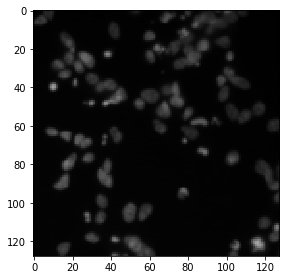

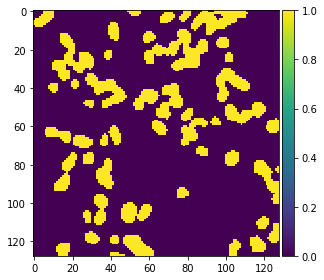

In [71]:
# Perform a check on stage2 samples
ix = random.randint(0, len(preds_test2_t))
imshow(X_test2[ix])
plt.show()
imshow(np.squeeze(preds_test2_t[ix]))
plt.show()

In [80]:
new_test2_ids = []
rles2 = []
for n, id_ in tqdm(enumerate(test2_ids), total=len(test2_ids)):
    print(n, id_)
    rle2 = list(prob_to_rles(preds_test2_upsampled[n]))
    rles2.extend(rle2)
    new_test2_ids.extend([id_] * len(rle2))








  0%|                                                                                         | 0/3019 [00:00<?, ?it/s]

0 0019c086029dd3be01f72131edb74e21ee995574e6d5c136ea868630b0d73523
1 004a078bb44ee55ee7d6f1c19f96b3a0d3b5037746a3a75197dbb0be06da05cf
2 005463e6d4a0a0b21161f1d97392f22556fbddba970d9440ae774229308a91ed









  0%|                                                                                 | 3/3019 [00:00<01:43, 29.20it/s]

3 005af293e8e53218ae96746ecf9bb88b511154d4a0b35e4ec6296b4623e15836
4 005d47447abac7f7fa0ac56ba82f13edbf485105baf0672504d84b58d562f38b
5 00ac87390253a22f6eb67c5771a73050e06200d1aa682fcf1b1e3783b2944166









  0%|▏                                                                                | 6/3019 [00:00<02:19, 21.53it/s]

6 00b4b9c026cfc91af21691503bad67081fc02d5c77b3cd27200d02dca6966b83
7 00da4fe5346bbb36ccf178964a22fdf7e33888989624176a6af3b4a7cfd7da63









  0%|▏                                                                                | 8/3019 [00:00<02:39, 18.93it/s]

8 00e36f2470960e84cfc9f0d30c1f76abd7b35e4516380bf74985cbe641086806
9 00e67980783eaae30d41f6479beb9c04eb91de4608537673898039094800ddb0









  0%|▎                                                                               | 10/3019 [00:00<02:44, 18.26it/s]

10 0109397492bc18b80e607146638ba9cd905506b0602d4dd67a0352d89d9494ab
11 010c48f7f53524acf3e36b957046cb4f3ae731d346c1921dae33d6f5b36f0626
12 011cf78028a792b25416d03720aa170e9afd3c08e132f10ce6a08fd7806db9d9
13 013c1bf8a495e042180b09241f38b6ead0d1c7d1159de64347d277ea7b04fe12
14 013d4a2e194a67be2c858c6a246baa0c5715d9ab73c3c84704f109978da71092









  0%|▍                                                                               | 15/3019 [00:00<02:25, 20.61it/s]

15 0154f82b5f214a91e3475d0b14d9bbe93960b7b1f925da9bb8e2b4aa65ec006a
16 0194650844199fc64eac64209ace68b152d85d742e6a9b7bdbd4e4a3e14e209e
17 01c28d5dcec55c074aa2b2936840639adc368d22e776ce19711354c6059773a5









  1%|▍                                                                               | 18/3019 [00:00<02:21, 21.23it/s]

18 01ca6877c2c98369b40946563a4d90372fb86b3699dc0ccf860d74935339efa7
19 01d8ee57bc3c6eaecdcec132d21045cddcb9e70baeef754b929523f0d89d69ab
20 01e7cc3424aee5065c9c7232df5a39b1f11c15ab0ccac0282c422905f93507d3









  1%|▌                                                                               | 21/3019 [00:00<02:10, 22.91it/s]

21 0235dfa9a08143de5ace6c1910d66c4e9b6ac7013be32c613fda94423574128a
22 023f820ae1d32ac5a70835107cdf51a1d7aab475dedc1b1cd8c33649cf8249d6
23 024975b4dc2a415288664ea7fdf5d9582f8d19d0f8b4953d87444dfabfc11e19
24 02704ced3c996fda149bc9641c361872d55d357d08f539ac3bc8beec025e6ffc









  1%|▋                                                                               | 25/3019 [00:01<02:09, 23.03it/s]

25 027ddfacb347aba6d7ca1a38991111c3cd71331d9b4b8b8dd66732dd4fd42d72
26 02856f4cf826392d1db965d97d10e51d5c74b411dfb2f96d3bc31029506b57f7
27 02abb63ae7a2c93d881866ed8a85a425deb1819581532e41d389d24a8f20fb87









  1%|▋                                                                               | 28/3019 [00:01<02:56, 16.97it/s]

28 02ed1bb97b33fb5dcc9dd9ba3c1c264cad42bf25233d4f50798238119a680de3
29 033f2668a63e33bbe1637fdb0d1a03ef00c345f0b2bd661e321b70981032ff5d
30 034ac7e5aca2a7c455a1ca65942948da016fe04f03ba4357eebce8ab458eb5d3
31 03599d1f92ce8d1734c80ef19e4c8f48e583b5435b30606009f7efc8dd207b01
32 037006ec2f502664d43070c77da37c52235fa0a88cfdcdb1a2939dc6fb513137









  1%|▊                                                                               | 33/3019 [00:01<02:22, 20.88it/s]

33 0383c5c6d28be1454ff4f0db306922198958582aae01faf11258ce6caad793c2
34 03975f1fb6d6780c2d90f69aa94d754e75232c6feeb20f32ad3d438b72f1be2e
35 03c2082dbb453f17e874c644bc9e88bec92a79af41c9111a4d52a9554bc417a0









  1%|▉                                                                               | 36/3019 [00:01<02:24, 20.66it/s]

36 03d9ebe734708631138820bfa1b598528495a049a182902d65efbaa73e738389
37 0401b552f739d51b556e9f2f85cdd52191f957d8b453ea3d2e61b32ef1624490
38 04022ee855ec1e9b93532bf00e709e10305e3084ca9b452368f9c1547d76cb7e









  1%|█                                                                               | 39/3019 [00:01<02:10, 22.75it/s]

39 0425ca5e8f6654f292364f64811a4eeb92bb50ca4c70ab8161ba21730fad7e36
40 042ef58ce8420704ac352c7cf0f9d3fbc7d58899ce29879ffb46a21f9b321f5f
41 04301c58a7f4a4860dae496292661d09c2c5265ae4df3f7819eeae4a3d11f310









  1%|█                                                                               | 42/3019 [00:02<03:13, 15.41it/s]

42 04317e268d3343063cfb7605a9a8a5c66d92fa0b9310e66d7fc5d4072b1e6149
43 04387d228734fd5993d61199704cbd741762b10e31856eabe92552c8790ca7e0
44 044f134c2689f632f98a722b6c3894ae5828069239365cc5fb6bb502c6ea5b96









  1%|█▏                                                                              | 45/3019 [00:02<03:01, 16.38it/s]

45 04a068435d3fe809c0a2ea2be09df8aeed49f26ec3e94258dc8be418ab2f7ade
46 04a27d1c538475fd8588b10898c334bd0c22b895b8042287751dd1d5754d7db0
47 04b8dce861ae969cb3fde7898dae4d2dbbe9bebe461eda3bdc2c16aaf9a4da9a
48 04c7531bd6e7db41341892f85f26163885bace79ea4501c8388e044d7da8e35f









  2%|█▎                                                                              | 49/3019 [00:02<02:39, 18.61it/s]

49 04d72d5c95b0924c5a9436ae1909ea836d1a30d8323b9b02326e22848551ca53
50 04e77a7bc9fdffd666f890b810a44fc58d1dd448149f073d28dc779f62cc026f
51 04eb73bd9f4079479558b9542d063bb74dc15508abf71f69a6deba03beb233a1









  2%|█▍                                                                              | 52/3019 [00:02<02:43, 18.12it/s]

52 04ec15d40847c786dfcfec3a55906b7a54d262a1e23d68d258f0b66cda46d25d
53 04ee117f434ced4f44ff2c6329d682f560f433d4c47effacb3c361d71434fd15
54 051370c2f8761074993a7989c8c73089a3a25c294812f777e4e9d9476cec35e2









  2%|█▍                                                                              | 55/3019 [00:02<02:29, 19.77it/s]

55 0514cc7f8da5ed8572eca6b9beab69a8ebe99a297d2cba24f1d743e910a4891f
56 0517932ff0b7bc51c6ed946afc6437f82f2b1420e592b09b67874e129635437a
57 0543691b2760ae9dc963cfb8d335de4b23f2b9402abe6a56e676267042ead205
58 05444e83098d35190b96d86670cb77ab3ce46b9a4386e612f0bfb80c3dbdbd2d









  2%|█▌                                                                              | 59/3019 [00:02<02:13, 22.12it/s]

59 0588ea30da5deecd3f4748fbfa525c188c74ca573432c5ca63ff0b6ac81fcdcb
60 0599be45c7422782a6bd12a218f803f0f47da70c3c90fb4186c4b981629dba75
61 05c04b89e609fbff821fec17364db2eed1fe2bef6523c68323d8466c6934e7a2









  2%|█▋                                                                              | 62/3019 [00:03<02:18, 21.32it/s]

62 05ca7a6b1f71afa11f8373c029be4c48241f938c2a69a50344d1e52900739d76
63 05cc503b996fd999c8ddf4aead7410e523542497348234acf23818c8e201bb5b
64 06079c1cb77545ce8967f80147dab15084e983213995bd26bd74ab34ebe22517









  2%|█▋                                                                              | 65/3019 [00:03<02:23, 20.54it/s]

65 062853fcb3bdbb8c3910b102e6d12c0e823b06b39cba0efa5d506ffb1caadda7
66 062f4c594159fde85688687b6153d789ca649419e5728f9a198e52f7d4d540aa
67 06352df5cc5e10d079606ae773fe41347029e6c2662cd2c5194abbdf7b848f40
68 064e6d7d49e155b12c10f3054a453a615714198cf9e83d9edf717c151b922c90
69 064ed8e551fb85b99dbb8f4ec7a7926bebc1347348629376b4747e5f9e103570









  2%|█▊                                                                              | 70/3019 [00:03<02:00, 24.41it/s]

70 0682759f81d3e26c9cebc9973f297025bbdb07b419edf748d98bab84594bc2f1
71 06ab84f102722051c69c3238060ff7bd10a3fe27d0bbbadfc9ba0c241beeeb7e
72 06ad61a211b9582bb615ad065ebf4454c4f0d7c3e38a3a8b014f237cd14c5d2a









  2%|█▉                                                                              | 73/3019 [00:03<01:57, 25.03it/s]

73 06bf8ea756d4b90739376a2caab8d3edc4ded8dcdf6611b26ef0cdfc7a68e557
74 06c0e846aa0f826aad0aea4d5410de86798899a21a15f98393da5b5e6cba465d
75 06fd84055ee0e52a92dcad1e901eca97a0c38b16ac8185243d34a749a79daa6a









  3%|██                                                                              | 76/3019 [00:03<01:56, 25.30it/s]

76 0707814a32680c0dce2b5f3530fe83e3d17b8ecac7e5c99c2d4e8b0baa3ea156
77 0720a2234eb1f01cbd2c9e48fcebee2b2080ef359e54d76c9c1f0964a665efd5
78 073e4210d127a5d999477958f05001bcfcd71adc14e6090b4245e33bb0b60c0e
79 0741ae39ddf376261a2361d14ad474f3771d60d73dc1c82d488e62ffa44abc8f









  3%|██                                                                              | 80/3019 [00:03<01:46, 27.68it/s]

80 07676606e8d3d9819466c90289cafa855f14497beda051bb7bc0ecfdd9e9fc85
81 07bc26e119d1943b4db465aeeb846ec0903802da3e13874b34697ded1f70cce6
82 07c6314ad0b053d9f7ab5f4e05a3d801cd078f2dc6bac92fa6ea6aabe67915e1









  3%|██▏                                                                             | 83/3019 [00:03<02:05, 23.40it/s]

83 07ca0221db41436fd1ce894dfd8d1894e2a1fde69c50412e9c4e74527b9f5280
84 07f3ff55106097b853e2b637d961794bcd27d1c5423e539305ef3b9f0a119088
85 0801c13e30c0e1c6918699ba8b28fb5381513de55902de7c9df2455a35482a66









  3%|██▎                                                                             | 86/3019 [00:04<03:08, 15.54it/s]

86 0809c8808881395346e23fe04a6750a8f7fe8e562b6db970ef0c4075d9e82117
87 081302bcd859ca4ace25ef02f4ed278f00ffb11b105dabefdc412abba25bbfab
88 08140866ad93f903d42412fd2847018df9dd3a5d1c7148ab596f31efead100d0
89 08233b7dfef209840ad4c9b7c8e79dafafdc81911fafc39b09fa06d243747c19
90 082be55df6dd59ef0aee75974521783f173ab7c9578311de549366a7267a27e6









  3%|██▍                                                                             | 91/3019 [00:04<02:46, 17.61it/s]

91 0859d9815854d50700c78ed49410776b69df4df48b826d696b84d2dce5a804d2
92 0878b9a2dd97d85c2b987a8d318457272991ef7dfa829ef4400a1029ca116e77
93 087fe46ef42f17482a798f31de7e679e1c66ce306bd3f3ac779c989b0a6b76df
94 08827cf8e293ff3d644763aa6b6b7e745d3129c74dcc5bdb385a2ae34a4f7b87
95 088395d0131cd031ba9c5aead55bab891922f365ae0b7adaf036a71e10912cc9
96 0884b81a561016c6f084316b63d9e46f5a73f281d20ec4b78decd1c04e19ba2c









  3%|██▌                                                                             | 97/3019 [00:04<02:12, 22.11it/s]

97 08ea9d06a9dea7048cc12d581745a22d8fe3d3a2959230dbecb136c238744307
98 08f34650c6462b49478c30f6e06a203fc2fee304c10cb6145eaa8850656650d9
99 08fc86ad273fd33a1cdbeae53ba8da06af1a4ec2a93a1add9caed87b3f138698
100 091618a19ff292da97d476f33993a82d9cb7915c1781a57e2de482c93fa44fd7









  3%|██▋                                                                            | 101/3019 [00:04<02:19, 20.91it/s]

101 09338db90dccc899f56ba39d7ff660243545db9a7efd28b2f5d308215d8e8060
102 0964d0ed689216f6a66c5757ec9fef64de192399e10fa66ed4da0e197e9c8f20
103 096fd2d21b5c093bafd71c5fd34a84fc91e78d16d5275a21ee3a4f81ba7ff697









  3%|██▋                                                                            | 104/3019 [00:04<02:25, 20.05it/s]

104 097224ce9b9295744e76c55616d3122fc1790bd40e31f247d7825e9ef90e98a3
105 0989a02a09e9f93b0ff01b76ea2e2b6bdcad0f5c33fae70f492f13eeb2422306
106 09d23353f0db28e2ff0be31d26e1a87580f556dc0e3016ebbfcd9dc53bcec37d









  4%|██▊                                                                            | 107/3019 [00:04<02:15, 21.56it/s]

107 09d5c0a305af734e600a4ef547580c713cede403c6ae79424c12e57739417bf9
108 09d6969acb6050c11dbfc7f6a4af94d799b7a83def967604c58de3be89e341e6
109 09e77f8d45afc46311c23376d5ea8b7d1fa8826309170e7330a1e638df1e69d1









  4%|██▉                                                                            | 110/3019 [00:05<02:40, 18.17it/s]

110 09e90f6b89285654d6ea0b75acabe574a06f3d2be5a54053bd76d330931eec66
111 09e97aafec988669bf63b1fcad257015f4289fb0781a2968cfe44a2690c3e3d1
112 09ecdeff9ce879e5c4ab1ed0cf7fa8f41dd8ea0352148effeb6171240f4140ee









  4%|██▉                                                                            | 113/3019 [00:05<02:36, 18.59it/s]

113 0a56ef365e23abb86d60182fa582c2ec0011eea50b5e761887b371f654bf296a
114 0a5782755a4fda908f523031e1f5aceac302f39aebaea43cc980bd2021445923
115 0a5a390c955100df18bc11ba62721756487573a47ea5a5ea3f3ebc01d9789794
116 0a8dfb6763ec049b57454e6b5605f872cdf41cd13951fb2a2f31a6e3c8667712









  4%|███                                                                            | 117/3019 [00:05<02:11, 22.12it/s]

117 0a9b684358ddd521550545ffc44a4f2ab335f7e2cfa4124a6ed63944371b6937
118 0aa80c97331a51eab952724ae16840d2d36632d0dd7e578afe707743a4854332
119 0aaeea97957e52a19a4b43876a898bc51ce6d117e330aa7920cba92bc7bace79
120 0abb58cc7ac43623febe10542a2c0d5230652cb092bf63ff4dc69adb5de0cd3d
121 0abd8062f3723d56aedcd3471c66de7dcd71043a59bb43a0500b0b6e0a676e06









  4%|███▏                                                                           | 122/3019 [00:05<01:49, 26.37it/s]

122 0af2690d64c05ecebad05e5095ba9f91481ce01974169c4e94d5890bdc924cb8
123 0b17d278d67c7fb216890fa09f64240862d6a8d419aa3d207ec49e706fabda3c
124 0b2f4d4fa83fe59d3e15c35352a5b865ba5c451a4d043ac95af6afba41a53d81
125 0b41c1dd249b45bff3fab8ef03e7149e917f6471a421e943d4fc3e8b84b9d85b









  4%|███▎                                                                           | 126/3019 [00:05<01:45, 27.40it/s]

126 0b5a9f648788285a03ea595646ccdaabe07b74014a4e5c2e76625c2953e531a3
127 0b61df57caa68e63fe1c78e07e935e0b501b22f8b800a0a6eface07b75bc015b
128 0b9bfbcb828c3ca0040ed262cb820bed1e3272b708beaed3b745be24e46cec47
129 0b9d53929343105debd08e1e8938eee675f7e28f4c5f7cdc06be52fda8a1cb59









  4%|███▍                                                                           | 130/3019 [00:05<02:12, 21.83it/s]

130 0bb5125b16bfea1c7de06a411107d941d4680df8a4cb248adec6d53642fc18e9
131 0bf9aa35be54c5249e67a0a5934bede52702fe1bd211784a62c25c9bc5799ad6
132 0c05a71fc7981ba2c0c6b5dde6d8b3eea6ed084c929eb5445b302886bc9eb57c
133 0c0cbeb6b808ecfda8b275f7053da56bdaf077a1dd5880877a91a13d673916bc









  4%|███▌                                                                           | 134/3019 [00:06<01:59, 24.23it/s]

134 0c14d74f31b6bbeea94e9937320c5c42602377ae3605f8a044f13b8b716dae6b
135 0c61a259abdc4909d5ae0c671c57905e41c22a071e8da5531f9eee399b871095
136 0c637792c3119e9dba71ec30b42765fa430e068c8714a4b38068f3761e35e5e1









  5%|███▌                                                                           | 137/3019 [00:06<02:26, 19.71it/s]

137 0c6bf503b9e55e92de5ffacb5d9e50d17b6c33f7e75144a4a17081528070fbc1
138 0c8566896f9975845f37f9df6db33aee61b569a8c7bae5c47c0084e9af8a3bba
139 0ca87beee0808d4865973ee05aeaac803e836984bc6d64796c4508d094ee6cb6









  5%|███▋                                                                           | 140/3019 [00:06<02:12, 21.79it/s]

140 0cb75510c19e7a6bd2f651a690733462482f663a5e4912cf86e2d8326dc30ef9
141 0cd04a87847fc63f113cfd8a2c965f37e0cb01fd8ad645de567eb3ce2d2972b3
142 0cdef02317b299e41d2a01f1339e062882b988728f6071b035adec3aec8544f1









  5%|███▋                                                                           | 143/3019 [00:06<02:07, 22.48it/s]

143 0ceca72cb1397f1e1704adea3959229317c71f9ef6dcca42ed18e48e45cdbea1
144 0cfa1583baf56793aab92e3c61935bc75a0be9c91cd66884f5b8e021e3911494
145 0d179d0cc0754bdb02b16f54708cd7e012a602151b02c4abc5c6f5da160e0c65
146 0d1f9760758ed6fc9f2b7bda7c708510c66551f715f99356c3277c375bb510e2
147 0d3b7476b61190df36fa766d01ec5541e0a36505d9f63719c044dd0fe6e09484









  5%|███▊                                                                           | 148/3019 [00:06<02:18, 20.66it/s]

148 0d46d06bfdf661f1565c5b51be9d134878100adf54c0106512a512b37710ea98
149 0d4e2ceb6d944640b9cd3c9f754ca25dac9bf302450b1a8c2877e964c4a95d18
150 0d544ac6367dbfa5aae67f2b4de15f647a2cb47368de4e596b4c770178db7693









  5%|███▉                                                                           | 151/3019 [00:06<02:13, 21.51it/s]

151 0d6941d6bac758c7af58e963a538b152fb258bad009071880a44a570af380517
152 0db9a7f318c3fab55e90a7b11e43f0545a592b6cd69e7d670511eab29a125d14
153 0dbbf00f39aabed55ab76f464001cb2104644b2f7110dc524fd93e6b14900f79









  5%|████                                                                           | 154/3019 [00:07<02:43, 17.52it/s]

154 0dbca5e3b3f2b78427bfbc3b4233b451fa8af900ea59c78fd30eb3ca1e933d7e
155 0dc3651561ce29ac8a62b021bd72212a27266b3a4ab2d5c77568db7ca6d19110









  5%|████                                                                           | 156/3019 [00:07<02:51, 16.65it/s]

156 0dc4f56ba798aee82a302f79eaaaad04c84f6929b3fec6060f305311b19991ef
157 0dcc42b186bac32afde0154906a3184a5317921a45e69177a2f0b4c6f292346a
158 0e0344d43dcd8cdcb312c050780d84a854d34a880e656b88b4e08ef66e22db57









  5%|████▏                                                                          | 159/3019 [00:07<02:37, 18.18it/s]

159 0e06daf6966046cf1f8bbdb2c570ee6001c45747ff3b3958a368866b349a057a
160 0e11cd78120a8b94117a67132f4bea447748a757f6d0b6f2be473021dfa5b49c









  5%|████▏                                                                          | 161/3019 [00:07<02:34, 18.50it/s]

161 0e33fa035e97e7dae123db222dc346eb66244a5f11e49d70f19e7a934b1f9bdc
162 0e62dbfcd5dbff4b0b5fe9099b3aaaf9bce1422ebda37e1d9246199f4f4373d1









  5%|████▎                                                                          | 163/3019 [00:07<02:41, 17.69it/s]

163 0e6deef5522c9f4508d7712a6bdc27db8df214d726a977557e7ccb9f0e7e4864
164 0e83432d5fae947fe6250bcdb6890c24d450ab678cafa8afa938e228a4107eb8









  5%|████▎                                                                          | 165/3019 [00:07<02:49, 16.86it/s]

165 0eb4feb7ab8c3c6c129dd0abda6a7fec8c477d933484b4581a20dca249d1b12d
166 0ec1e0387baf20d0c858d84fcfcdffd255b87db4d3c59953c5dcbed995e14c07









  6%|████▎                                                                          | 167/3019 [00:07<02:54, 16.37it/s]

167 0ec673c5a1ebc3b22a1cd58b5ce94d78f66bb96990070c4764ba6f2f80f084dd
168 0efaff15b1c4b35d61b0c5159cd32f05265dfa265c9cc8a280fdb78c1c8fba7b
169 0f0536b658a471141ffbd901fb579e01ae6bd9c85cf80dbef605783036f091bc









  6%|████▍                                                                          | 170/3019 [00:08<06:18,  7.53it/s]

170 0f13d4764e2d679eafbd82fd9d6da7a40496f4b7b930bafec85ba271096a0b6f
171 0f48fec9292aacdb20335b5e7bd21ae5d07040279aaa9814820cf807a999cc5e
172 0f4b066f347e1100c19ede56f0aea61fa506ec67fc97520af0ee608372135c1b
173 0f65b01a510741050f6e305eb947b45a94419bdd2bddb37f06fe5a1bebe16702
174 0f68afacf5cd6fab74f060a728e1577dce2235bf989c18f1b4ae73562e211dbc









  6%|████▌                                                                          | 175/3019 [00:08<04:47,  9.89it/s]

175 0f82b626abda7fcfba0893bab7d2946a2b5ebfda29d2c14f79f495d89c51a730
176 0f99f1fec1583f2cf37466c2bd9354d01e3ae271dc41eec81317c4b5d3300cfa
177 0fa06bf6c9683e5e463944578632f195d93968a0470de2be5a531b167e0094ff









  6%|████▋                                                                          | 178/3019 [00:09<04:35, 10.33it/s]

178 0fb2554bc5ba639190ed1121fe14a7fd82323c378decc1fdd9f8fe696d8478f1
179 0fb6076e1b1105889c1400750d905226a20efb25d01aebe5a490dc2bec623369









  6%|████▋                                                                          | 180/3019 [00:09<04:11, 11.31it/s]

180 0fcf47e7a3c608678acfa7ebcd740b61e0b81c5382ce25d7200b91d89f5dc191
181 0fd3ed3fcef2451fa5b087beacebd6d29213464bd5db16d7c9c06be55e704a85









  6%|████▊                                                                          | 182/3019 [00:09<04:25, 10.69it/s]

182 0fd475a8c838f3d3c0f115538f7a14d5297778e2a0bff29c440d53901852db39
183 1028160a0e29d080fff27b2d8a119938fa8dbc86b1c88c3ea452b048191e1d79
184 102c2afeb1ce4714ef9b53d8c63e3431a89491bdb9175e189d0b6d391c85ae85
185 1038a04bb677b66ad80a1a981aadf2085d6945c2a1849d68859f7816e80313d1









  6%|████▊                                                                          | 186/3019 [00:09<03:38, 12.96it/s]

186 1051e4eef2724101ab5f2cfb38f5fee8d7a98aceff5529bfef7c2a35b71a4d5c
187 106423fb28a54151657c5f6f355c86c8f205bad6f5ff8a93a0c790bc1e711c2e
188 106ae85344016da9e556d0cafbf6f389095e875d3ee5fcee2eda7ed01917c968









  6%|████▉                                                                          | 189/3019 [00:09<03:05, 15.25it/s]

189 1075503168d77effb032b58c291a30fd4d5ba7493ab712ab5cb0e7ff34026e70
190 107e00f2ad180c41352e5124a1ebbdc0f51e6c82fd07b2892721e96d0c24262a
191 10c31bd9f2b7dc6756c262419b3ae53854c69045939f41e0346c3f11702804e2
192 10e6276dc07da2aa9b8536034185dcfe8dcb36081227ffb65e53bbbf285a3da0









  6%|█████                                                                          | 193/3019 [00:09<02:32, 18.55it/s]

193 111ab61fa2ed520456aa7c1fd028ad124735c161fc3f9ea1ef3673eb2569fe4c
194 114121cd0f068963664c45307e672e837bb3490da4b6ea876b3cd119af70c9ff
195 1157d8b16c01ee66afcbb9567c949c0675ee0a9ea338ece4275f12b760b52f94









  6%|█████▏                                                                         | 196/3019 [00:10<02:36, 18.07it/s]

196 1163d29769a637b28ca3522ae1bfb6d90aa2bcddc961232fce8cf141b835c051
197 116aef52cd2522ff83b3e72eed5f26d92c9e11d981f9df96644cf3cd5f4b63ed
198 119dd6a147cbeae2d3200e6716dbfa1a2105495bb9c2984a98e51daff95c1c9b
199 11a35a04dc26bd300256f4a3ff1c92e1a0882e1174d8041b351de54495967562









  7%|█████▏                                                                         | 200/3019 [00:10<02:50, 16.54it/s]

200 11b491bff441ad94b2df76cb030acf4aa0c4a6fcb6432d9612cd6f49fc041252
201 11b82d1afa33cdd43ec542bd8ff20384c2a993cfaf1ccb258780522ee81f57cc
202 11cb351f5a05f071ae3376532913de1d418cf7fbed9db4684f9350b356dce2e5
203 11e4a8138564cc40d498436a1309d69901f0d177f96a01ed0f45766429f6a0d7









  7%|█████▎                                                                         | 204/3019 [00:10<02:38, 17.76it/s]

204 11e4ef8dadd4651e08fc1add5accccfb78f18c84c0846c5c889a89d20f668a7f
205 11ef794d62ef47d62bc712171353e5223c5e8ff0308e76590a2523f855180441
206 11faede22ca726b7914a6a9f44ec4863dfa07102154c8e7e07c233d28fb0d6bc









  7%|█████▍                                                                         | 207/3019 [00:10<02:34, 18.16it/s]

207 1201cc45f4ab328e29464c5840cc2900390bc07543c93a155c7569e5375bcdd1
208 1215a44407df8896a5b59e6e0c1cbd81dd16b963e45af88379d71f71c4bf2a76
209 123d63414072a0a8ad5beaa3693d10b0924b1483d950b88eb81459fb1d8d4ed6
210 124a8d369d0ce7706c5fb07d95c8c8c38b2d39126e07c994b488a1e43b02dc1c
211 126423a74d505a5e773cbfb72605d68ba2bbc9cfe965e6ecf32be3ad89c0eff3
212 126a811669dc9c13a5780064fceb7e8790be6903817cac8cf4980bed8402db71









  7%|█████▌                                                                         | 213/3019 [00:10<02:03, 22.68it/s]

213 126c8fa0dffb36a03e2a67b95c8953cf35567037c0e4545b93909d5403a959b4
214 127037413245301accfd7bc2388387aad592b301139b6c9362e1ecc138f83ff7
215 12722bc8959f598e0b91ad5da61840225f4f2f51cc4f3ff063945e9babaaadca
216 128b946a651c70fd1f613225274a51f5564430e706e90fad63a3edba2f44a2dd









  7%|█████▋                                                                         | 217/3019 [00:11<01:57, 23.90it/s]

217 12a52c90c203781050936e6f47c8676a9db814fda0f47933e24a3380a475c6a5
218 12bc4b1109d5528b7002b461f9171eca935851375c9ebe7c0a69faae65c1760e
219 12c148d898c03668c48ca131bf3e5c2a24f498bb14851d6d3d2ecd718e413ac5
220 12c6c93c400decb6fb9d6e4a38cc7e54133cab2da7d3cdc0cadb8230609e8050









  7%|█████▊                                                                         | 221/3019 [00:11<02:04, 22.48it/s]

221 12e64a088a0c0c545de24786677383bfbe51ad5be5ab3812a1f38affb5694665
222 12e69341b2766e458f640241ce890418b1a21c0b3b48b5436c447a777e6f4cce
223 12f8bc752376bb8f08e345fb18ef397717cadc8786a5c26a2faec3021d4b1971









  7%|█████▊                                                                         | 224/3019 [00:11<02:24, 19.38it/s]

224 130d8f3da79cba72ba5a1efbc8f3a956005770bb0d996461e45724800a56f913
225 13160787b26bb275a2458bad2f65df80d65a962224024493691d7539d0148a4b
226 13237c14da8bdc14e30b254f8b6bc6e12e6feb6b7cd3b458e785a6a315c90fed









  8%|█████▉                                                                         | 227/3019 [00:11<02:13, 20.97it/s]

227 132c14db1900135283be3bf3116545d98633a0f4b32672a1177b84bf2b203efa
228 132d8b438fe52507e358e5497bbd7daf180c1cd7994b2a0b51fb71829c15d677
229 135c4cc84886c31f39fd5988682ed4c323f3e9d890415dd9a12eab4d30961c66









  8%|██████                                                                         | 230/3019 [00:11<02:26, 19.06it/s]

230 13869acced4d9f3e8965a209e3f048608b9e03096b3725c30080f7e91150491e
231 13a7b6e9ffe46378c9637c7c5d84606edea078ae7962746d919886846829db38
232 13ada12068b9d35f2a74ee5a9744b6091fa17eb737e72a48488b3b8e5c8afe97









  8%|██████                                                                         | 233/3019 [00:11<02:35, 17.87it/s]

233 13c94436227572f52ffa3a8d721a423d287f5437d1d5c273dcc4d4a6970bb73f
234 13ccf9b006c96900dea2b1ef586c0e0c0bff9dca2035ecfa534d6c65151becd0









  8%|██████▏                                                                        | 235/3019 [00:12<02:44, 16.93it/s]

235 13e4eef807af99a8537235fbcbacf0f96f6362f1f3f9782ebf60b5f5dc28db88
236 1403d75f675461a028e9dc14807f403888cabc26f6ca11e7d8678417c1142595
237 1417b2a46465107fb5e43f8276ac8c5c89f2bca6813b89114587494c45617cdc
238 141ccbc80fc29ed6fd6763e38030ba2cbb18dc626c517b8719bf232cdc7520bc









  8%|██████▎                                                                        | 239/3019 [00:12<02:17, 20.26it/s]

239 143326b5d339993f0e2ba0faecd8ef44dacdd5fba25170ac6736260e249a43c8
240 1457b924eb3dfe311906ed2c9caf2d09d9c534410997d4afa5f0a32de3aa07c6
241 145e6ec6f95d60532f3a49e88b28ba25a425672d9d782ab4cf44fae6051fabcb









  8%|██████▎                                                                        | 242/3019 [00:12<02:28, 18.65it/s]

242 1464ec86594f7fffec318577f7ecaee8f10d203dacfe808aa1d89d013f886f40
243 149ea0b4fc55883e6a7b6bed2bea9af79224066ff13a9ac23e0dbabed7676c36
244 149f9359754cdaf21da700b8a31ca335f306be67654256fb479dfaf7448bf8d6









  8%|██████▍                                                                        | 245/3019 [00:12<02:38, 17.48it/s]

245 14b727c9b98ac6a139a3c2abae2814595f011ec4997610faa49bf59cd35972fd
246 14e407f8c5c2f9f0e9ebf27f043b505e7e835434e7a3a0912df5bd6c267ce9a1
247 14eb1afbd8482bced9b2423064101026a481138b816155f32b416e1c2df53265
248 14ff49df48363b4f950a49c08313d933273fe9058dbda881d9579a1700e16dc8









  8%|██████▌                                                                        | 249/3019 [00:12<02:32, 18.17it/s]

249 1518fff146a77fa6b0f0ee5ece61ea526f4c0767ddcfe680095560415ba0c78d
250 15949cfdf9bca03d504ba53369d9be7df899a78e866d5f5ee1708a8c55b74a1f









  8%|██████▌                                                                        | 251/3019 [00:12<02:45, 16.75it/s]

251 15a8a1263cd6fafecd2aa996f63c5b2c7c4b221e0a315e752db76843f14e1caf
252 15c4a9080fa02900e17b43542cad68941ae3d3c03aa17bf98bcf6f9ce10c0528
253 15cdf102276bc0edc7491e15e6960e74f7bb47e1f0d7685cb7cbdc3f914c56c5
254 15e6b3b8f86625be2209015a153ab04c01dac1822c3a2be9b59c112d6a231dba
255 15e7ec81f1a1507c95a0a13a439d55e85317045db686166cb669ad4b44da5b37
256 15f3604ab80bfce649b1375edfbd055a68dbcca9edb9af36c6e1b9b9c3754cb6









  9%|██████▋                                                                        | 257/3019 [00:13<02:11, 21.05it/s]

257 15f9aa4b4804bdec300d0dbc67bbc85a1ee3998d35d4974858128ed1a8081596
258 15fccd340c834068448def0b1e9e164fc286feae06486c40da76a999caf04724
259 16063943d1d3352f49cb8b350f891449aae4a741bc6ea44c4c4ba5222d9ae193
260 163b13a74bac3081db4163d2cfe24509bc0d870968c694b881656c700e2b95fa
261 163bf0021b42ac85b8d52495fdc7d2d24d1b4fab94170566ad78b8edb39f70ba
262 163df03962bab7d1dc55827da1d27bae1ba6fa2bf5fc1fdd767f09fef91270da









  9%|██████▉                                                                        | 263/3019 [00:13<01:51, 24.82it/s]

263 1652c2fccd5cc10f144cdf73bcdf4c351a59ecca37e0ce5366645c3fa5775914
264 1658946623f7d34f5699e53cc9f10558248061565990957709b4bd84ffcb401b
265 166f7225e962e0d602d098c2bc452452baa2fa7c4bd60dfea2db6e4a68335496
266 1670c8803cd15e7449b2193122ced1f0bec20fb5fa41c52919e0b5e3c3b97e4a









  9%|██████▉                                                                        | 267/3019 [00:13<02:26, 18.74it/s]

267 1680b690d36a9628ccab4e44e98b75c0be9e2f1e02c0b9e03dde6b1f15ffb74a
268 1694aa605aaa8ef4529310a0c422fc1804fc9c791620099a884cc516a9c3af8d
269 16a9563a7cfebb50be338f5dd8ad0deaabc59bcb62bf58b5ddcc31aeee610313
270 16b078d49301dec3368b349132db22b4657767875eef06cdc7982ebd19027d5b
271 16b73858cc19211efbe8d3950800b33d66f9e430e4558826eec60004b19eb2fe









  9%|███████                                                                        | 272/3019 [00:13<02:05, 21.95it/s]

272 16cb16a84295cbe4d7ec1cbc5d98821ecbaea9fd5556e4a7ed437855894b8a82
273 16cef907ee1b3fb205dce66a4901565f0e7c9cb4c3e0b14c803b18e79e63350a
274 16e3c3bf8fe81f5a8e8b9877b1ef8a7885bc976ede56fa16a1cd4946f948e88f
275 16e5f3f89ae463d087b2f2dec239f0dabfaca9226b18e90dc3511b53efd457ec









  9%|███████▏                                                                       | 276/3019 [00:13<02:08, 21.27it/s]

276 16f5979a207d4830fa72ab44e2cd24a3dfc80953fa06f8cd324140f3600e7be2
277 1702b8a3d67643ef67ce41f485bbfa35985492745cd2b9486c7faec27e93ec93
278 170bc41b2095177cccd3d4c8977c619147580f1d93b4fe9701eddd77736d4ece









  9%|███████▎                                                                       | 279/3019 [00:13<02:10, 20.92it/s]

279 178368bc9e0aa9682616c1fb8c0d138e82d1dc73e9a6a2f925faaf7aec34bc95
280 179633d8797da4513a83678d4c4751797e3d8d1a0e8aab17ccac467f33ca93b7
281 17a1176bcfda9280d347f3fd1a7ff708a7ebcf08bf979fdfad88f4025e647e5c
282 17b3d209dbf19153c53e35b3b69a95708f82ac763104e3e7f968cb78ee18b1a3
283 17bc9a96fee04c37813ace33e093a0bb6452e91fdb41af702024cfb542f1779d









  9%|███████▍                                                                       | 284/3019 [00:14<02:09, 21.15it/s]

284 17dfcd3ea94a13842548d83a819bb62803c7e50d672ca922ecec61b232f64e30
285 17e1b2324ba299fbddf2643520d2a5e860a44f4af19f09797fb20eb684e1c47e
286 17e28d72c5c189b23adf7ebf0588d96ee07dbab7cd2c9c7aaec426bb9e2b75a4









 10%|███████▌                                                                       | 287/3019 [00:14<02:29, 18.27it/s]

287 17e608447009d9fd01402a00d2a8083a25a3ddc233a91f9189b38a955fbb72b9
288 17f67d3c7eceddfc98d241af7d33d8483944faf3b2b2bef18dfd392d80a3f6a2
289 18091f7dc02555f321cd37dc87b6a53bd57eaa1909b12966780e0134536ff6fd









 10%|███████▌                                                                       | 290/3019 [00:14<02:32, 17.90it/s]

290 182dbf0ee3a35cfede398ba8863f02b6eebd48ad63f0a844ec189265980641f8
291 182e7af5aa80d7a44e0864e0dcfcc2be1fc48f672a4c8a5c29bbca8e0116512a
292 1831ee0be76c2f76b6a0d1b3291639d21a1ee8dad713d2d2491d382f183168f9
293 1832e035c8b3e1824ac19d9ecddf33266806fc4649f9f20669991e4f3d9292c8
294 183818267e1e03f85f566d29e3f5d26d52780b1e81477c79486ace198ae70d93
295 1840c47b98fcd3ef14227e9cc9bd15f24e0745ef0d5d45a0362ae2d630684068









 10%|███████▋                                                                       | 296/3019 [00:14<02:03, 21.98it/s]

296 18461e087014a77e648fe96532a4d0b537535103112ecc0c5bec832c3243040d
297 185517852d2460c1517937141e527a5402db8e0a59cde611ce5b8be3bf0bc053
298 187053f9593d6a513fe798953dcccb58a50d16e3153e6e1936e343fb6cb29b93
299 1889623579f3881e827002651d850fca90a2c36a97af034d93f9bb90eb62de6a









 10%|███████▊                                                                       | 300/3019 [00:14<01:47, 25.38it/s]

300 18e99935ff697070c1e7ad890b2cda260c3cc0f6e50f3147a33ff0a986fb800d
301 1907f24bef48f502ea978aaf363ba5489bfbd974b87599291b31b1265db43cd8
302 193571d93e9ce6986f3a541366fd700a0a770adf13962c8be279a17b24fd1b48
303 19435798de351d4b785a2b4b0f7912424e51f67ab68e4f57058402a4bca1ac84









 10%|███████▉                                                                       | 304/3019 [00:14<01:44, 26.08it/s]

304 1954906f08443ea228894d8df7b1e60668ac09dd6adb929b89fc95bab93043a4
305 1955cd2242b47386e845a1aec80ffd18d5673fe200da9a740e530ff5f677ba8a
306 195d4331bb0c91b82c42d5fe39c237c383109d52e47c17b5c324a73d68efbaf8
307 19699898bd07e3d27804bc52fea46d67a8d4c63ec75b5693910482855285fa90









 10%|████████                                                                       | 308/3019 [00:15<02:07, 21.27it/s]

308 197dbda2b0c71db095db6cea4a0ca425432a663f997dfb3d26f3b63955df3ba6
309 1993f30556b35c2ac453e5feaf715156463e948ad72fdf184e00a9b1968fe1b0
310 19b51801d8fb6cd233a15b9773f142bede42c520f53c4209d2b18846e3320b9b









 10%|████████▏                                                                      | 311/3019 [00:15<01:57, 22.98it/s]

311 19cb7811ce0193a2ca7cec70687918ead923b8ad26493f2c94e44e79a1468190
312 19d3e0da084b704a379fd821459e885f05afd80a16ad4c5dffc4af38af37d180
313 19de4f77d40a55a79192dde0f7b1209632955d57b757f4508a4e2ed83e30eecc
314 19e3d3295d6e15ea80c4cda1a8e7ced1e38acad2a8edc34a466c47040671292f
315 1a00b157d1851ac97b680e8988ff64cf0f95a351852593d5ddd42b768de52f49









 10%|████████▎                                                                      | 316/3019 [00:15<01:49, 24.68it/s]

316 1a065fce169338fb5e02ff37c4480c7f88864aa8a03ffa671d3e5c266596ebcc
317 1a17f38cffebdaa6d78fa900d5d6f7cc73ea8ec8bdd1f4fe46e7194ba817828b
318 1a195df635e1e72a726ea0c18f1b7a3540a9a89e4f5c14dabb820d81bac5c95e
319 1a37ca145dc2061956954c5afc711e93e85b7561f1d9e4dfab2b123e5c895b5d









 11%|████████▎                                                                      | 320/3019 [00:15<01:41, 26.68it/s]

320 1a3829007422f2ec05c7d243915f5b8ef6dd7a5d75e5005b10df1f44f8737593
321 1a6594551f2c11ec27636a73d20eca3ac9c9cc50d98d6fbd22b26e744c4e21b7
322 1a98ec5e2a2c8f9d700f96222e9af575c0abb792c1830266548ee11c95418b9f
323 1ab230aafc8e99cc0fa7c39fa1fc23a6aa3af642bc165d73a96c4f3f1cae5824









 11%|████████▍                                                                      | 324/3019 [00:15<01:34, 28.64it/s]

324 1ac7865af9d0af9115baf4ada87c8968c6732791caad5a52f208339e2bb2e01f
325 1acbb82d2c4121c9667394e5770771f843d7a2c27d3dfeea48ad907af682134d
326 1ad631da943b0936249023a33fe4fb55d59d58523c54cf5abff8f4154ee38ee0
327 1afe2fd7d0c7b131390df5338769ec7fc79c3f7b62e645275a97c2b208f135c8









 11%|████████▌                                                                      | 328/3019 [00:15<01:28, 30.54it/s]

328 1b00a44b64236e14b1ef3c717857dc5f181bd47b24a9dc0401f1822fe0f24839
329 1b127f9bb1ed3f10d357aafeafc543951f46fed88ebbfe15540c110ad2e67e61
330 1b1c76f9bfb888eadc955463023c1407ca37acc3556fc70517b03a35dbfc52e8
331 1b28c24f891ad5157dcd4d582e6b965862a32e043b080663b14a9acf82dc703e









 11%|████████▋                                                                      | 332/3019 [00:15<01:24, 31.80it/s]

332 1ba53e465b8a0f97bb1ebaf2c4e3d76768698904b260a2d0e3d7739c9d5dd2cd
333 1bacf56acbdaaae04ac99d812db92bdd423fceec8b9ce8adc75f064a8fc5091c
334 1bb368804936b09f70b602288828331f3885941e1e7e87b7364898f8125aadc0
335 1bcc50448c2a5ce893f25f10de539012a8f21b71c2d9f8bc7d44bb92cc56983e









 11%|████████▊                                                                      | 336/3019 [00:16<01:24, 31.88it/s]

336 1c08acfac6e7f3dd378f673ef694b3a230e272c7159d54943dbc5bbb050d5dc9
337 1c1067f297fa0d77411edf6e66a5c9fa5a9467ad75a8d297e848e6801ccf61c3
338 1c1d41c2662ab4a18fa9e8864adb875cb3fbdcd16cd32e617e87ac35992530ac
339 1c4872dd308cb6aa336e638c781fd54dd57a2bb44606e22c8ee864a5e496b0bd









 11%|████████▉                                                                      | 340/3019 [00:16<01:22, 32.49it/s]

340 1c4e26959e8326d80104ca7c1f9f21924646aceee86242d6daba338a59154e33
341 1c51d140d0c455734a0a2939d6677a6e0b0bf15f74be286bb9e509c2396746e7
342 1c538f81e11b8b48ef927acdfd171f00ee7909bd6d0bd6d57c28d3277d26935c
343 1c69629d540046c19795f48d6ecc7150ea213c810b92a62506bdad498cd39f41









 11%|█████████                                                                      | 344/3019 [00:16<01:30, 29.51it/s]

344 1ca32a62a76c8009847c48386a682356f333deda00ba2e3261439eb87e6df733
345 1cceee3270f513ed145309df76018688a2c5cc9bafcfff545ce5576be53c9189
346 1cd3c42f113c91b646714300237c9aa711c4a78aa041c9c29ce2c7d86883e03a
347 1d18b61cfafb4d94772f27c78e6aa3a2993710820c2343ad04e70fa3aa922e78









 12%|█████████                                                                      | 348/3019 [00:16<01:55, 23.16it/s]

348 1d4551fbdafe830c99b41896c7917a9d8b4ce4adc592e8ab340f7dfd7025dd64
349 1d4ec0f5ae4e314287dc3626f0e62ea632eaa4c8f1e2e9c9444de49d072dee4d
350 1d546155054fc1ec7f49b08d90510fbfdfab63a99e4cc5861c5ff036b483560b









 12%|█████████▏                                                                     | 351/3019 [00:16<01:48, 24.57it/s]

351 1d6d63e9172cdef038fb6c979ee15e606d5f134c7a87d9a07ac337bf00c78752
352 1d7cae191e761ce4debe0b69319f3088c309b9e1bd8aaec8a816db4bf6af7ce3
353 1d8992627bf1263a1b972f210fc97b94f3ceeff6a680f39377e2437e8489e2d8









 12%|█████████▎                                                                     | 354/3019 [00:16<01:58, 22.50it/s]

354 1d931b0b1a9977c29d4a20c2a12a8d45118c1d80dd1157d23caf39fe4f84510b
355 1d98735f3f98dc680a45a352c4c2e9aad36112604d847c27c4a58a88807808ba
356 1de0ae4d6efffc2cb1d2e7cc7b386e66e9114b36757e22e2dd59906c675384f4
357 1de3ffddafdc1c1f729dc21392edbaf0368f6e157dd2b71437d71d35614666aa
358 1dec1219b2d3bf2c9c3b72af1dab8a462be091bc411b856f0cd4a21ba2b936e8
359 1e231e4fb8bfe82843247a6f6b469e2045ce01f2d86f7c867c726f6ca35400b0









 12%|█████████▍                                                                     | 360/3019 [00:17<01:39, 26.82it/s]

360 1e261d5817b8dddfacaf7d9d31dd616fd3b6412f319d1c41771d885ac0687d7c
361 1e40c4da2c4af0f19b1e89246adf05e709a00495bb60f2d714237a7acd0e939b
362 1e7e055f4e8e3ba34d32d41f2ffe90fb16bdc421120e7050fac94594cac9315c
363 1e8c8ce06dddefee3fe6bc87ef2647f5dde809fe0ecf0ecab736100964047ee0









 12%|█████████▌                                                                     | 364/3019 [00:17<01:35, 27.74it/s]

364 1e9e303aa9539381eeaee3068dbb1b5409aee6b95410318f2a0735d2a7e528e6
365 1eaedd8f794a59d12f7853934989b657c6c4aad89dc20b9f7989644805d46a92
366 1eba322b4f19cbb7ec2127962517fd9e8450f215eb156005f6884a27d910542c
367 1edd67f41a030b1c04828e2f58581751b960b5941e6d39239b5cb57653f6b0a7









 12%|█████████▋                                                                     | 368/3019 [00:17<01:43, 25.54it/s]

368 1f0eb72a4fa969830d8de21102cf49380ad6c4a1d6705b8474377e555b736e74
369 1f352b3371521a22ac2bb84cdb940ff5d9c081a22f5be18291724ebe3058a2fe
370 1f39f641a895becba2fe7bd8e0cd5a94983f81a7b010c5c225a0d06ee0d2ceb7









 12%|█████████▋                                                                     | 371/3019 [00:17<04:05, 10.79it/s]

371 1f63d8051fc448fa27b22fbc0097dfd1accb518cc258f6ae6be1383c9aa45681
372 1f67bc216c26b0c9ec3cb1288225e80303ade73292145452e159007f3f6f2ee7
373 1f786632bbc7572a041a191375e441a460bec90d172d91c84b82a415a054ae49









 12%|█████████▊                                                                     | 374/3019 [00:18<03:20, 13.19it/s]

374 1f78d3193730f04730254f82629c8d54ed67ab612a6dee33dc326acc15bf4612
375 1f994b09109b0dea723de0e819dd07a2bda10888ef10c7cd12d213291fbd5d62
376 1fb9d0f56017403afaf5ab84ad798f2ce0777681f2a754a3285be4d93b08d7c2









 12%|█████████▊                                                                     | 377/3019 [00:18<03:10, 13.87it/s]

377 1fcc6f194721434dd5345f5d448a63ef799af797ff4150798e1218fdf3cccd83
378 1fd078d06651990c5f70f94d21e9f0b8d63f2418247cc08b0b59b7fb4d6c8f78
379 1fdfda4dcf47c3aecc823d15077b5fb129a8c2451ceb46e3ad5223b9c105f0f8
380 1fea053be14714201e5ab4d60231ce1742b5eaea3bb749f047b3a97c891c3478
381 1ff7ba5ece6bbd17a08038d680c679adfa06b6e3182a2e10b9cec6acfeb1556a









 13%|█████████▉                                                                     | 382/3019 [00:18<02:32, 17.25it/s]

382 1ff9820d0bbe0b1cf59b9cddf637d137e356ef727cac32fa826fd9603af92356
383 2006fca50a4cb0a0b27687caddccf3430e79e29fff63425a780c641ea2235b8a
384 200ff5c3d928a4e2f355768ba075e5da60a09e1b68c6cb9bd2c5ef8b9852b1a3









 13%|██████████                                                                     | 385/3019 [00:18<02:27, 17.84it/s]

385 2012fffe6ccac56b4ed6d88e2e8dc428e444ec2507dbfbf94a629a33a12169c9
386 202eb43e191b025fea05a51cee63fd9bc969a65a34e86ac84dde59c3287ebd26
387 20337ac9d05486ed1a29150907c909ee956fe68aa6b1b07dde690c60cfa115ec
388 20443adb2ecc2c77f0bbba66b53ca73a4ccf418a76266900bc9a103ef7d2ede1
389 2048326c289b86580112976ec30df138959ed0230b3458b8826f63a70fcdead4
390 204a940874f0c123abc231279c541de6f00f79d5b5c06c83938f5de3bd42b8d8









 13%|██████████▏                                                                    | 391/3019 [00:18<02:00, 21.80it/s]

391 2056702937d55459d141c48b83a0cc50705dc13c94b38574939f48839e147b44
392 20754e20bd09af566526e851dab212a238d8eee75697e799e90185bf8c83e7f3
393 20a097af6da0ac69e7c5aee83ba03d3e9b70d3165f6d507d14f30c9c22b3427d
394 20a107dcb35adf104e97234aa1d03d0de608138f99717748364e62ff04c625ba
395 20ac1021d9c01437e24eb853fb1bb036fcec55b8100381152e0ad7fe59d4a01d









 13%|██████████▎                                                                    | 396/3019 [00:18<01:40, 26.13it/s]

396 20c73cf6599705edd55f0c3f104733a0bd53e18bcc761510ba818af452ecc8ce
397 20d0d2ac8ecc95216d056b46163466a18b7f74c921e9f2b5e46e538a58de65e6
398 20dbe38d356e60baea7bbb49af86af1ab15350d7823757261ac51bcfc576371d
399 20de8f6da99735811168580ae6bd87f54bedf838cc2275d386aae9ad5eb098bd









 13%|██████████▍                                                                    | 400/3019 [00:18<01:36, 27.24it/s]

400 20e13e489ebd23f7ec90c67101e07a7c6196c7dbd6c79b680397dca5b3ff05f2
401 20f6d3fee9fe4fe4af4e2f96c6e8bbc876c91f5def1705ae1bd23472c03b0dad
402 21046851361692aa11b65e7f92fe45d68480d949929a848687b30629a0252eb4
403 2130f650ca64793408ed68fe57b5d98b753c22de0df18ff00fa885868ea7957b









 13%|██████████▌                                                                    | 404/3019 [00:19<01:43, 25.34it/s]

404 2134a73456bf3e87ed79d35b4bd9672e2215d3d2893a44de9d6be0ab5e6b25f8
405 213b53a4e4628c9a72c239c7e87938c0b186ecf2af1f6449dc536f8f75d54891
406 213bccb0c1676ab6cacd548b4fda37223dfa97263dc0172e96519af22d80ecdd
407 2165b913d7fc6b6055fc2f4842a705a9c9563a30ffb5337b0fba67f08642e1f0









 14%|██████████▋                                                                    | 408/3019 [00:19<01:59, 21.92it/s]

408 217241f1c30d9f26d596aed516e23d40129044c3721c1569c7d8d396acab7adb
409 2175489f334df649609c9e802a628f2c047e373725d9f0d54fe5ff61cf082ab8
410 218e2a90aa3d948fee7bb4300e052bb680a24b0fa0c1c5d2cd799d1dc7502acd
411 218eadb4336ce74de6ff2d9661839ac739cbb2850c682b0f6f83e9dc0c169810









 14%|██████████▊                                                                    | 412/3019 [00:19<01:46, 24.58it/s]

412 219c6c29615c816476a71ed82c7e50fdcca4727020e0e52c019c6d252d6569d0
413 219ef47163d2d3b1d411f5228fb88125a0db472b2525f56be2522dfdb54183bd
414 21a02b3857d6aeb0c5f67dd046083322876b3fc586669d94c3a227903af29a93









 14%|██████████▊                                                                    | 415/3019 [00:19<01:45, 24.60it/s]

415 21b5035bc93aeb7b47d71cb9407a4a0261dad1c1dc2fef99823e72741c74606a
416 21ced90582a341e18ec24fe3bfaf083ac15837529289537bab378bba320424fb
417 21d4efff99cb7512878b19f4b1e978f7e24dd02c6b311bd9b3a2819e2777b3dd









 14%|██████████▉                                                                    | 418/3019 [00:19<01:55, 22.53it/s]

418 21d8506de9643e2aac0089cb6c087d1c7a4af8149afc31b00326077bec6b373e
419 21da1704bd63963b3c6bc47480786f7d4c1735ae4bbfbb63a22ce376e036f403
420 21e6d64a92ae99477f21b9b512c35dd1d3c390d0867dbb287f406f91aedfe0dd









 14%|███████████                                                                    | 421/3019 [00:19<02:04, 20.86it/s]

421 21f6f73a03f6fe2c992b3bdfe009475b13c70875d4d764544f2a4a91a225773f
422 21fbbdc0543c741fbaf1bf1413fb48902f79aab19421e273deb5db12d715443f
423 2230d0baa1d77cd63a1523f4028d01e6c6e60944fe347335cf3e6a5d78f8b5eb









 14%|███████████                                                                    | 424/3019 [00:20<01:58, 21.97it/s]

424 223214408b7edfe174ee0c6969d0a3b81328e6df38680c0a7a5365b8824a2876
425 2238e4565aceb5d7086a25f07b7e442ebb5ceb14754dc2b4494fd5dba154f4d9
426 223fcf1a3652bb711ab3b4f3d160938022df2a31dd39b46e2a5c592e333dd21c









 14%|███████████▏                                                                   | 427/3019 [00:20<02:01, 21.41it/s]

427 228b5febfa9eb2d187bc77b72889c436191b4d0a126c08865a0e04a9cdf30f1f
428 22932a305b6fdfe62eb17bd89ae3640f65e1bbe217bd5b957b8c70c9d7cc763e
429 22b0658a2f8d4b3d67c545a77c33f5448e17be1939d2db3df5536269a2054696









 14%|███████████▎                                                                   | 430/3019 [00:20<01:55, 22.34it/s]

430 22b2b35af9ff17b39e0e462f8ac3fac375fe3a0a52f281e35c33c0c95920936f
431 22cbcbc0560173500c108580e0caab8c899b4dbe439809d29a32a50e3d9e18c4
432 22d77d724c425d0e4a796134db3036418df26459252f3e3dd687a67b417d4037
433 22de14644baca21940f6528b8be6a84e141c16f470d4f394ec24784924b522d7









 14%|███████████▎                                                                   | 434/3019 [00:20<01:42, 25.12it/s]

434 22e143741fd6c541992bcbd6c9737ea412acd73bb85a1fdd6f79b40c0b15367e
435 22f0fc6fcff08d806138e400c3320ad8b4ff3ddb12c4adacab5b83fcd46d32a0
436 232b87a391ebb8ad19b0e755aa21267f08cc48df6ed2cc7aebb163ae4cd67909
437 233b524a557f67fcab024d06f00a71a07c1a3290ca82fbc943513a07db8d8010
438 235de1b3718248a3dff6484899787a95615a049ce87be79566b7842d7429c408









 15%|███████████▍                                                                   | 439/3019 [00:20<01:29, 28.88it/s]

439 23d5887339759baab135fc252655a609d98bdd6d981e0f17c9fa4594d39fbecf
440 23e52189978351d8057ef2efda5c33fbb378f7fa815cbe51dc2f0d55ef306acd
441 2406640f7869d4c3c021ffa01fb5cad0059c46837baa3ab689ccba302cdd37bd
442 243b7aaa7d46174f7f864cba75cf6c6196ae8dadf9282c0a7e745aa124b6f0fb
443 24405344807b6eed7aa34b333a6f931884dd08c0efd9af7a302a4a36cb0590a2
444 2446d81ff7579b2aa95f13b0ddb5ba06ec606327cca12423f018f85410dfe257









 15%|███████████▋                                                                   | 445/3019 [00:20<01:15, 34.10it/s]

445 244c1996067279a19d884b4bca66f559e2da769bbeafa73160311cd8287fb123
446 24928d37f8e4704fed57eb9521248f6e6680f581d487f8aae44491d8ac52d01f
447 2496f4f649e8111c8a7df00d6b7e1af9c286fe01843ef3e350eca8350323a53d
448 24a9ebe71a48fdc9126bce7d0d5a3db30018f3a7caef73eb6f471274cd82a81d
449 24c4f517699f6ed64943bcab3df5fc3b37467690ff971d978a9cbe4bb7c2569b









 15%|███████████▊                                                                   | 450/3019 [00:20<01:18, 32.60it/s]

450 24d35fb95a96e9ff444495adeb7b9100b74633186386046dc2e7a560f11d60e6
451 25065ee0a9fe85491ffd58931871c70d6ac9c4b890801430b84548fccdcba658
452 251615447f0a1e706cc5148189bc32222fb638fd09d55357e8fe3da6400ca179
453 251b128aee6df07a3b8657675636ff383addc6060b4202c3231b07d5a929b0cf
454 251c5e8d9e369ead90872eb281de73e70ce4888ee860bce13bf60fddb7f50bf4
455 253a7a726223cc1b49deda11fb40bbe9a448a29bfde282c790eab083e0d55b9c









 15%|███████████▉                                                                   | 456/3019 [00:20<01:10, 36.23it/s]

456 2542a5402678b37129d9e55b541d716503d05018e988dcd859cafcc5a1a8eecf
457 2562927d7f0be2860019561e45797224eec7f9b20a31e78198418926edca7562
458 25674d257bb438bdece878aa89e5cf3cd702e6e6fef1f2d00a4b1bdf5c5d893d
459 25743fe9041e19b40ddbd256ff4c6c1bf109fb1705752d4e548dad2175c50068
460 25844c49c88eb92e115ad03de96bf4154e2867a24a73d70fc8edc5275d089cb4









 15%|████████████                                                                   | 461/3019 [00:21<01:05, 39.15it/s]

461 2586948effd5f4319ce06c5e1db73d72b5cb9a57dd80583cec09b23586fa13de
462 25ae6da0f1ced38fc87aff6fad90f9980062fa4d18161904364f5b95a20422a4
463 25c0c20f3df6940f02dfa14907d782bd10c55d648da3d0af3c057e6607019b45
464 25ca67d7383a0f89302e5fa8893a855606b8bd728d84451914b4a688c8c75bce
465 25da426e6b6949beed0c767ea514b0816e7a51d5ae7c50562af28546d8f1a949









 15%|████████████▏                                                                  | 466/3019 [00:21<01:02, 40.98it/s]

466 25de8fe59608dca9aa521ed1084b4b53bb39babe3ab0c77e4376cd14c05d5448
467 25e1d8f0d9972358d76b917a554d5bb5400a088e4862646599d929657cad335b
468 25e6dc7091752cc39464a19196f8d07becc7a04f7820dd4aa569ff7bd4cc450a
469 26046aa455b119c226d77eed356ee3744aa6eff423899f84b00b8f8a4e24a497
470 261cca54b9d5e1c644f69941b21538a5fd60cdb0a8fbc89f33abfcc1d581ef52
471 262e29525be36732d89a219bbf9d1891b4e404ac5f55915b320248d4cc4a661b
472 262e929e53f2cab94c6ed0a7fe78d4f3f239b65d1e6bf6eab3a91bb5ab88b534
473 26468444a3b8c1e6d180ad6bf11938e49241e8be7c4a9c5e5aa65d4840c86ce7









 16%|████████████▍                                                                  | 474/3019 [00:21<00:55, 45.57it/s]

474 265145e9dd1e3fbabea66304fe460cc9427930d2a703e242e78331d28b50a80d
475 265819e55845b9f797ad9791e69f0313592b1730a98952f7ea88cfc4ae4cc6fe
476 266255ed3ed511033a4a72d7ab9639e1e052071744e181040bdc95413808aa2b
477 2696f9b6345a9545c7ecc2ac9c6c79cc4cb87a1634b83d7c6904476ec0e521b8
478 26975a0df3df08ff057ddaf2f98f1187ec34178a9bbd5162e5014b3b8d3902c9









 16%|████████████▌                                                                  | 479/3019 [00:21<01:06, 37.95it/s]

479 26b9ca857c7e59f33db5be7efbff79b07daf99ea8385890dcc57cd99f4fef4b0
480 26c1d69c426023b9051721d68bd079ef627443c764b6faf91d790a133d595c4a
481 26d74bb705f137b86dbf0f2e0fc9a09860223c72d89454a605cac61391160d7c
482 26e22faf80da1750e509d3e01dc62315482e7a2632db416b0979fc941eb8d169
483 26f24b3515f897ec3608c6674518581d60306b3b86867340f445bc1e379c9590









 16%|████████████▋                                                                  | 484/3019 [00:21<01:11, 35.48it/s]

484 271d4e553015f144379b6a2d120c3da05a3229b95f248757cb9fdfdf6647b6b1
485 272691590e3b04dac2307901c0a06ad277b9e2facc29dd38751085bd9a813b2a
486 27358d07a4f792f5fd0f9dbcc61e9408c6ed0191d070207f4f60d4ff037a673b
487 276c389f8edc25ea3a91d847bcc51b368a59b3b70aeb1989ce36d030522e8183









 16%|████████████▊                                                                  | 488/3019 [00:21<01:40, 25.26it/s]

488 2797d484f81b24fb52cba11d32b60875557c754a8add7b8f18332b5ccf653069
489 279af72556377a88b73b4921edb0c5b2c2ae16c2d858757ebc02c1562e0781b2
490 27a7b36cfac26f55ab4332637949bc177b830c6e26c1ee5b72e98044e824d551
491 27a809967af81bdb49c4474f534d9c91dbfdd568fd9d719f79877e52bd978afb
492 27aa6f3897053a9477c3947fb014ade4d32a45062485427bc58e278c608e996c









 16%|████████████▉                                                                  | 493/3019 [00:22<01:31, 27.48it/s]

493 27b7220bd9367d0c29a2cadf2810f3b417f8640a0014592370a7eee4243a061d
494 27ba3f8a9772e526555b4bfa66f6fd648b802ebeae4bbe369b85d24c29f7641e
495 27bef1703def700b35f2fb948528e55947a5f3260bac691a41cc3ecaffb2e939
496 27c752f17a53a935e7f0b2bb83ab11527f1ea75d196645c7f00cf234780d870e









 16%|█████████████                                                                  | 497/3019 [00:22<01:31, 27.62it/s]

497 27ce1dbbd04c5206d0b47cc59f7abecf1108a7f62d6e3d6cec318db8162f624d
498 27d338cd46ebe6112400f67cb4dca464c582fad2f0d2b73544bd4018f205c528
499 27d57b1c1139062117faf96f6c527a38631cbb833100d2753d2faa29121a817f
500 2803f6db7975b04b9596bd54a3420fadd732d1c9b11ffeed0c64b17fe42453c1









 17%|█████████████                                                                  | 501/3019 [00:22<01:56, 21.65it/s]

501 285a1b852717703a725c2ca471405311a662e3a33766379cf0768b5f766e4964
502 287369353e973f3fde6a058e9b293ec52de084bc4cd336f9acd77c65cf5d24a7
503 2873987398c64d9856b8969ece75b34f4c258de70a20da503db140b408432f92









 17%|█████████████▏                                                                 | 504/3019 [00:22<03:02, 13.81it/s]

504 28a165948c0e3c7d0610951cc29a67c52842fc95e631a63a756c30ebde94eb28
505 28cd5d62ca803753529ff55483f57f24b1cfcd661fb7e20d554f02d8bb0455a0
506 28cd702f96c9d3956683efba84f9d8f82fe60dfc9c15f429178104d8a0b6d743









 17%|█████████████▎                                                                 | 507/3019 [00:23<02:49, 14.83it/s]

507 28cd97ed17aa75358c355d81d564bdaab7fd18ac29c6baf6939eb66526c0c3be
508 28f81a16b6cd3459ff976bb01df6769fe887f9053197210128285d518a677c9e
509 28ff3b5d9d5abfe538cd41c24e3c3455f36ccdaeb8801e65f3a777de6834b2a7
510 29024f82e64c0f0574d00c69ac90158533d8ac29dc81fb8ac49679569d9f879b
511 290345929d1e645c4667fd413f7832c3491c7388ca9a9c1f503aeb431ef44149
512 295a8eec93bdf054ee82764b9e4f07b935ce1bea8c16db4c46d63d0d31b78f4a









 17%|█████████████▍                                                                 | 513/3019 [00:23<02:13, 18.71it/s]

513 29906636a07f438aa31cbc76edb23e7d338da9c0825defa6e2c87de406a11523
514 29b13c723d26889a112daf4f4fa54ac3effdc8223a05c77f2e0f61b5a25499dd
515 29de4e690d84cb1e7b6e25aadeaa5def712810e888b2a2f171fcfc55ea0b2ec1









 17%|█████████████▌                                                                 | 516/3019 [00:23<02:50, 14.69it/s]

516 29e1c5f87ddec30f7da64b7a797d277173be148c1b080c8d5c1e0e941dfb797c
517 29f3727dfded926e1dec2378a55cf3e8c368d872790453531a61c17fcd49a4e6
518 2a062542963c6c9ed2c4905db38676c29894b15d943d661200409cecb697d2a0









 17%|█████████████▌                                                                 | 519/3019 [00:23<02:34, 16.21it/s]

519 2a3032c1cc244e6ca3fa82d3585883050e161bb304eb7a1fbd8116012c4beab1
520 2a37b0cb6c64f7d9d95cfec3285c7672dc48d385ab44a83255f31d9bd4eb324e
521 2a3bf1c96ef53b3d9893f42209114d5b471b5f197b779585162739b3d4257cd6









 17%|█████████████▋                                                                 | 522/3019 [00:23<02:37, 15.82it/s]

522 2a6f1f79e28bb73a0064343645e720db679118a45673a0f563756334c8d6478c
523 2a7d2786f691efe45b1d7a66f96e1fa170483f2ba7810d83255704e5186ec204
524 2ac1e92c749e54b5bad111be1220d0ea07dd176a48c51fac4c212f2b7aeec8af









 17%|█████████████▋                                                                 | 525/3019 [00:23<02:28, 16.81it/s]

525 2ac8c30ea34b42554c2289de1087b650439fc8d4fae6e56ac93258879c099697
526 2ad096cf3239478755b5397330cc68805e9860f54d210fb70107f67bd68a6ea7
527 2af51afe0a96576f6a050628d5eb56d6e08c3db721b7a9abc1d75560d7862ac6
528 2b08c293f90f6d458578fbc725db5f5cc743d75ffc651fdb93a769b49c001927
529 2b0a24b0b61f554351970c6cce683d9e6b10143e35261cc155b77a9449f1b4e8









 18%|█████████████▊                                                                 | 530/3019 [00:24<02:02, 20.29it/s]

530 2b0ece0ae5955dd69f291f996beee03dd6d45794c501238e40701f369d5342f0
531 2b173feeef778de2561ae5989e1fd8101234e87a031b98da14c57f1a47a30cf6
532 2b17e2704a59cc69876ee4e17708639c9d92511ac888969125e0f22b1f3684f9
533 2b27854de8fa57c7bd3357d56e67734b71f86a6613963da14921f9d212708de3









 18%|█████████████▉                                                                 | 534/3019 [00:24<01:48, 22.84it/s]

534 2b3859805dfb2f15560ea9cc341b5a6df7fc1df5552092cec9b7cb40cd167a4c
535 2b4a057b467e148a389aab18603e801f6f0296baa1b3d92b7f167adaaafd008a
536 2b5666d6119cafba6beb9f719ac4b02010105bb4df82d473400102c67d3213a9









 18%|██████████████                                                                 | 537/3019 [00:24<01:42, 24.26it/s]

537 2b5d37925f8f62ac1367afda06c129b283207e08deaeb8bd44f18872a9a6b673
538 2b9c60ca0025799da3b2403ae9c97a74bb6f2658f255cac374f72991fe94c264
539 2ba8b85d599b9da90a0ef76dbe5372976770bfc827910c54d1492a34e4f531e5









 18%|██████████████▏                                                                | 540/3019 [00:24<01:55, 21.54it/s]

540 2bcca8cb1c6e03d5209ee48d27aa9fa7b22323eaaaa423c8c92757e30f0cf562
541 2c50d0073f547c962997e0a1203116f1e18b836197367523b631b7082efbee74
542 2c5f75dbac1126be0e8827c66152821ddaf04e42726048c30e89defd4ff69263









 18%|██████████████▏                                                                | 543/3019 [00:24<02:02, 20.21it/s]

543 2c6ec2375bd8cc92d62bc085eaf81a24da530e27b5d11299620fac1358931822
544 2c9ac2942e6f34df45ad369faf5386d3866c1f58625571b6a00c5da8ffc0f5a3
545 2caff324e70572fb012dfcefa69f7a9b4847ce80aa2b6557270d0697c1db2935









 18%|██████████████▎                                                                | 546/3019 [00:24<02:11, 18.87it/s]

546 2cbe2682260202146ade41f19b2f5b60f24982aa8b939a6446b9b968f4ac8c41
547 2cd7c4b6b54636da2eed9aad3f170aa03f64bbf8118bd21d67f11044199dbbfa
548 2cf50bd8b890dd5619ae04932da3ea689ca2b664f4046be00ddc98187f75e7fc









 18%|██████████████▎                                                                | 549/3019 [00:25<02:12, 18.64it/s]

549 2d0602204ff4edf92dfac3f046ca8b8bfa04c86598b7fdf9b100543f2e280128
550 2d0abcbae068e185622fe7b1f7a4b2b00748061eead881cc53c361befac4213d









 18%|██████████████▍                                                                | 551/3019 [00:25<02:37, 15.70it/s]

551 2d0fde2e3deb6214dc21448ba9c6f029a7f4b15a6e62d6b045d8ddcb13e18364
552 2d0fffaf739a8b3ee60ea9b231148fc0c03390a0d8a4fc81abba414ae27678d3









 18%|██████████████▍                                                                | 553/3019 [00:25<03:16, 12.53it/s]

553 2d155421c90614c10602eb8087dff388601c2344e4f142b3af74817f228be07c
554 2d39aacdc35936e2644dd007c3251bc158f1068f562d3100d11fa05f871b70ef









 18%|██████████████▌                                                                | 555/3019 [00:25<03:19, 12.32it/s]

555 2d48f71b506d553bc1a8c90c689599055104bb20690178954deb1f9d08ff4ffd
556 2d54df197f700c91ec6879a545bf094d4782f8441261a1aef67bfe7fc34f9841
557 2d7eba00bb610605ab59cc80e66bde0eceedc19d4ce8d690b72f0166ed3ab4bd
558 2da8d61e521c8e0c10008047e6045a000811b5efc66c7076038c841ae45137f4
559 2dfbc46013854c4881b2c97a3a2eb71390626545ff0bdc938d96a2491f9fb6d8
560 2e029950c89a2bf1421912b2dd2c2f63f5b68bde5a3b1a8326c79ea2c76e42d6









 19%|██████████████▋                                                                | 561/3019 [00:25<02:32, 16.08it/s]

561 2e08e089e43969f468b9cd36d965f4c7acf5e1bf1d28fc79d3d871e6e9ae13a2
562 2e0f1c047c4674fcd361edc271ff7cf66f7712fe91435b88f7848a8b5f06da83
563 2e1f54849065f625b8b230b8c8f05c7bab4f4b65ff407300758c84423e311b45
564 2e6239cc66bfde05ab9851f6d2a1a9d50fc3ed70503f16c6836e5a0b3969f580









 19%|██████████████▊                                                                | 565/3019 [00:25<02:06, 19.38it/s]

565 2e669ca71d270bac42d2143e199eecb4c7e93723f2f6ff06daa57dbd32b938da
566 2e8c6fe395c0fa5fae8ffa1765e2a208e8a32792df03c90e8597e29d7f1096d7
567 2ec47c938fc586c9c13f9a81a898cea7d8014f0a04d63f8003da9726736dc9c7
568 2ed84f63ef4cda2912991335444836beae6c438c98b52eacf0f7a72bc1d51836
569 2ee5dbc788adf5fe978f67dff21c8efb9dbf78dbdac69a188e192c56bce07fd0
570 2f007a027732854f2282dd1e8ddc8fcb18835728129030a686b241298f90b7ee









 19%|██████████████▉                                                                | 571/3019 [00:25<01:41, 24.09it/s]

571 2f06306d65e4ae439fabe1f0faac7fab538ee6a1cf2b44e53b71d3db75832144
572 2f0809ef6a7fdf33a9e86b3cc816f51d17e8ebebe442604883e69a1b42d75a70
573 2f2152463738b69ce08f2e02c27f6ddb0dfc99a2deecb87751ad2a4bcd980212
574 2f25c16e472f0b5f0c14b654a4e78f8f83ad7505f056d48349e1e12e0de98839









 19%|███████████████                                                                | 575/3019 [00:26<01:45, 23.08it/s]

575 2f25ce9adeaba8790fd873458aabd2b32c52a0379f19a66f874252d35c17f727
576 2f30f0042f1b1719b515536311b718d17465c7404ed81d7113fa828efb53370c
577 2f9d69888b5fce6e61be849fcfe924043069c4a435e1ca2cde9d0b9a668acdbf
578 2f9f71e6a7339c86061f79b5fc3d095104b3ab4b6ca3075fd20e51026e5b2ffe









 19%|███████████████▏                                                               | 579/3019 [00:26<01:48, 22.50it/s]

579 2fa8719a414b802474497eb5b3261f2e3903a75ec21534ffca674e1555072519
580 2fac642d6058508156612457efc5008fe266c1b0c8f7c8b15b79ead078e91ef3
581 2fbcf6e0d65eece04a72daae3ea5f688ff04ef8c716ad49bd2b5fbf381b86163









 19%|███████████████▏                                                               | 582/3019 [00:26<01:57, 20.80it/s]

582 2fc810a2f8b635546e8abf24f14aeb2c75dc1e5f40369df650af754625eb6276
583 2ff8511a58c21edfb51650f1d39c26c71cc3a64ba14122c3d44bb220ebd83fb0
584 3042a4db65b0db4d212b1ded8f363b4cc20b6cdc68db614afa6766c352131892
585 308b654a57190ec7604923da469c3d44f2e612913950b09ca9f8f61a795117cc
586 30bb020e2520ebb21f107d541aa269dd86af1eca08ee2a45196a87dd4c490d7e
587 30d1b9c9f180c68ae1567959a7f60c8d5c5603035cf49dd0b7aa96495b1140c2









 19%|███████████████▍                                                               | 588/3019 [00:26<01:52, 21.70it/s]

588 30e8a606acef5eb91f2ae7d33177af2da67b3469d490aedd6bbe4a88c50c2755
589 30ed0604c152677ba897cc69f1f4cb1a8cac62d09d8c901322be871a13eb7925
590 30ed2f0f1bec7e4181d74648aca3de2d5880517c2ee5be2e80a24431ddbd2fd1









 20%|███████████████▍                                                               | 591/3019 [00:26<01:47, 22.68it/s]

591 30f14480514483bee5c3da58628d135f87043ce10eecd5936e9b83d16bf79b30
592 310e5930fa91fc97fa37e1032724aac004fe7337c545bb9f910a60067d298cfe
593 3135527e21b3bc297edc86c83ceb623329221e0ca9d5c8f989c7c52c8ae57a00









 20%|███████████████▌                                                               | 594/3019 [00:27<02:11, 18.44it/s]

594 316ee12bad7a10a12c789dccac05a89a4b26380d236a7bebefa9d31d9b6e72ca
595 3194b5cea0c3bced549ff39b7e1cf8f32d1731e781f454bdb4f403fdd416370c
596 31a7c016279e33968da7cca86e34e8aad03f52476f84b96b04d46da4bd7c5646
597 31b4963eb6c3a2b10e57012fcfaf50a507637695eb999d85a01ba2a66d24b8f9









 20%|███████████████▋                                                               | 598/3019 [00:27<02:00, 20.17it/s]

598 31e53fc3eda9b2642d157fb8819346a71e5a762c5725a20224afc2606ca6225c
599 31e5fb8458150fb0e10c263abe56b7f43639ce7428dd45943537c502fc398938
600 31e79c10e9d47359a6094910a3471f6e99d850fb0bdddbdb10a64888afd2028a
601 3219ba6a33fb8e76a9b2f20ccf24bf2549c9a8f4ee346765768521c76833d58b









 20%|███████████████▊                                                               | 602/3019 [00:27<01:47, 22.45it/s]

602 321dbe473c342ea44af13505757f129d06c5116fd12d35024549b399a049b6aa
603 323981ae7124337681d8bd3fd44d5a2a1d2b809d9b0881c6b974e93babe84e92
604 325618b171765f9d5efa47424668480376de869cd91e95b84403a4e7f9dad2df
605 3256845310ed88c59805c285b46519848203263bbe7dce67c3f2a27e27b9c17e
606 326101fa54d31e473db11eb5e88f4bbd71bfc4c73eb8fa7c81f9c3992585ad74
607 32674c758afad4c787f934fa9e36572088f220d78328c91ae32fee0f797520c5









 20%|███████████████▉                                                               | 608/3019 [00:27<01:28, 27.35it/s]

608 328d628586f111e6fb0ed0baf4507631529273bf7dfcacc5f4a5250bfaed4efc
609 32930796c34ec8b18e361339a17f8870293fa208b6460ce513b3f1b00113f16e
610 32bbd6d17269336a4dc29c442efc1f69e709a06b46776d32832f3e64c200fb71
611 32cea1d905371dbb938d8143e9d60e068457cb58e0798ef6fccfd73f4f3f4117









 20%|████████████████                                                               | 612/3019 [00:27<01:30, 26.47it/s]

612 32fbeb0138137ed2862f3e895080cc6a3395b210ba9301d249f064743d0ecf28
613 330b9666c7962207e4e9d054fe6c135f59aab62395d61b748774939d32cf300d
614 3358213ef5db72742e56ff469f85fe10593ed47ff19b17f3e89917b08c5c4c46
615 33699cdb53b042970ab148f1fe30acc5d5b9fb38c6d05096b1c3508cb695cd12









 20%|████████████████                                                               | 616/3019 [00:27<01:27, 27.53it/s]

616 339437448ff11e00c0ee2770b7fd00a0f4046fd977e21f1a6a28552a93a5d410
617 33aa6d2c4b00e39d81c7f179fdbbb6fa42388ed5af35ce8561ef514f8c5f801e
618 33d6d8e9d74f9da9679000a6cf551fffe4ad45af7d9679e199c5c4bd2d1e0741
619 33dd8249fdaed8a91e2a5cd4603511c7f449c1da7b18c0da5ac9592222ae6149









 21%|████████████████▏                                                              | 620/3019 [00:27<01:45, 22.64it/s]

620 33e2081581c35579cf64245e4fa8cb4de399b8211ca8feb99701dd51bd17e88c
621 33fd877e3dbfccc9bb70628079e1dbcabb79b906e5ed79211f66b99b3770bb52
622 34025b612ea719f23f42d4ea4d0053e2c366894bda1afe2ecb6cda6335d478e5









 21%|████████████████▎                                                              | 623/3019 [00:28<01:51, 21.52it/s]

623 3419d1e6b4bde9179a5184ad0180eccd3c96b2e21ad56af1915fa68ff47ea746
624 342762172691b619bf5da84a37f0bd35303a0253ea6a43c5e7f4b714b5ad6235
625 3460042cf071c1aa39ef35f2e262c2da3730509d47977c9de7b63e43c4268222
626 34a0aebe4ea2d48810fcab88475ed0a2af3446960e7ad17945eb8b239b9bf4dd









 21%|████████████████▍                                                              | 627/3019 [00:28<01:38, 24.35it/s]

627 34d0fa5fd2fe5c9955fff299ead6ce97366a2176ad7569afc279c25ba6e0e231
628 34d910b9b98a31c534d8458e8bc99b9901c696f276a2a6cdfeeb6cabcb54af75
629 34f0bd12133031c7e98c03e4e57679f0928334075cc8713306a0ae818def903a









 21%|████████████████▍                                                              | 630/3019 [00:28<01:38, 24.32it/s]

630 34f1fe64b5700b8f5860ab2cef5120307999e9c15cf85f85754f3a716303cd2c
631 34f3e3e201d11218d43cfaba4cfdefe37fb8e42bcc0c40aa3775e5ee257ec9e2
632 3507939b7d99b3327620e10ac712d9f99750b80efb71f9a29c2100cde2d2a4a3
633 3512c7aac3b0288a02f3350aed6eebf5ba445ba58f5ca3b695c2d3256c5a59ee









 21%|████████████████▌                                                              | 634/3019 [00:28<01:36, 24.67it/s]

634 3519538e6c59a4a1f0c98b0428af30c2b222a7f247baaed67bc3a428a4f74471
635 35337a318374591f357940a496ff49f10341bc863d5bd6e265636b1d89e24c62
636 354914970585d2a355102074de8c6df3b3e17cd0f54969cddb1e7d2af0c26d7c









 21%|████████████████▋                                                              | 637/3019 [00:28<01:32, 25.82it/s]

637 356e14deb0c3941cca51f2eb5b92353fc855e5b4b08cbdc5d6b28808f48b6622
638 3581cb4169caecb0882219692566fcfe96d501b4e267c369ed48d8c4ce4d21bf
639 358b9f6bb6bd8d6f9c5426559d6c3b65a9ade3e784d45487d247d6b8fefbc0dc









 21%|████████████████▋                                                              | 640/3019 [00:28<02:21, 16.83it/s]

640 35b3e21ff89c7b5a3546c11d5596dd06312549b628140c950bf3c3de5c7e5b36
641 35cfcf124484363a01f2e9c3d6a78e99a00257781f90cfb82ab5bd7228a20316
642 35cfed35c9903b185e71b6be58696edd883c674744c98534df8da16d7a1131eb









 21%|████████████████▊                                                              | 643/3019 [00:29<02:12, 17.97it/s]

643 35d70a0a76c04a7def52680c1552f1810c3bd391400de764758de8ee6e341458
644 35ebb75b918a3ec5975d159bbb1e80cc9692736e7ed2a93999c6f648d7eb3ea0
645 360127a8ca6a4f080454a0d64e0017b0672ce16f9560455652ffa7e6ece8d443









 21%|████████████████▉                                                              | 646/3019 [00:29<02:03, 19.21it/s]

646 3622c71831c43007c82cac63a47069734706c99a581773bd5f3d7fb6f01380f2
647 3626bb85b56f52577e0b9139c88c35f1cdb1740351dd0588e4dfbc20bdc2a177
648 3627a1bb675e154731531cbc78ec12e021192a03800b1f440041dc4c45d196b0
649 362c40d324e45801f61d75e3992d1be10f3f6c3315cc85f664ed25b73eeb4aa4









 22%|█████████████████                                                              | 650/3019 [00:29<01:45, 22.50it/s]

650 363364a8134a49042a912aefade677bf8f9efab66dd9bda9bf8d1dd1e2ac51ca
651 364fb54d8bcbf2d67da60c3c1f6bade82c6a72f76010e6cd27309ccf7fa8f3be
652 365e01365dca8c85fbf6ce31904238f7bfb15aa28062e88f92c751f5b693f2de
653 3666b417a2e6ab22201d7fcb285baa330e4c72f92a785379af1acb7e48ffe843
654 36741e2bdd7037c859a6031337defd58c87837aa7e8b3b39929155c47adc9740
655 3690cd6d0d3fb5f7904906b86f73e8050bccd85c7a5b7057c929f513fbf3776f









 22%|█████████████████▏                                                             | 656/3019 [00:29<01:38, 24.04it/s]

656 36937fd9c9fbb23661f64ade06af8cd05fff0017ff3a9b153d253c901437ab1d
657 36d1e5cf9afe49cf8b116645d41ce926ff462c025694041bc835c50093aaf393
658 36d2d2a1e62e2f0600eafd139f45bc6c38cb9b417ffa6e5662fa5e73ca92ac8d









 22%|█████████████████▏                                                             | 659/3019 [00:29<01:46, 22.08it/s]

659 36dac2ace4f3c79b683d0bad0c2de03b9b01f762f7f4df0e7f009d9fcc599972
660 36f4651cc69f26df6b32908f16267d11f7f7d696389c2cfa517e337fc8e9ce60
661 36f84da0b506dc4a5eb3d1af5697e57c4782db9788667ede959a8dbe7914c16d
662 3711df3693162a1594d8b93a6224583aa672c9d0c62c3c5d0046180b8a00c92c
663 373122a138c21298d1c3b0adf5d16b669dcf9c865d95ace05add2934bc9c9a22
664 37704d90bf2625d8bcda7dfbd71e2c1d075cc909ae854fbf18892aeae6d5e12d









 22%|█████████████████▍                                                             | 665/3019 [00:29<01:27, 26.97it/s]

665 3778b3cd7bc0707d703735c6600fc8013f14e296219d9e199871be974d6fcd27
666 3786b55844737ab884341872c338e04a8877a2f893c8cf4477eddd886bc6635f
667 379560e35eecf608aaa67248da0f919cd9daecf39ae7f4c867a2476a225182bf
668 37c778b8c7c5704ab3d7ac02db6c1f41f057d6feb2760775e50f576ff4378123









 22%|█████████████████▌                                                             | 669/3019 [00:29<01:23, 28.26it/s]

669 37eac1ecb0360822cdfd38423b623e2980e576bd6e8db280cb32483628a84fe9
670 37f8eb0568e57a55e7af8f52962843bcf48b25a721dac3639895a22138de4aac
671 380e946d38b4713384ebbe3bac45e2b0e9af58058cb807b37a4696b3465ca964
672 38201e51e00f599ca106e3c39573a587b88a238381b2f594a81bb01435896a96
673 382cee9585b4614cfaf691cda4721982f56f0741c2089f2fe87419d181e7f122









 22%|█████████████████▋                                                             | 674/3019 [00:30<01:14, 31.47it/s]

674 3834d3d5aeb91497fc8cfc6f1fa7bcb12f201175ae0b361d77a8ca6f5d50a301
675 383d8ad7069bf55cc2e40f638c10565d9967d25dd38258afb048ab8d012d72ce
676 3844e6dadd3af9112e276c2b9cdc323e8761ce035eb10f475117a718d129ea01
677 384a6fc2cb8ddfb866f4340f567850c3b1d74ffcb4002206154038e649fc72a4









 22%|█████████████████▋                                                             | 678/3019 [00:30<01:33, 25.17it/s]

678 38578f10efab50c1a3f3ec4c0d6624f5ff05c67e1d4d0c72c4f389c42cb9897b
679 385d422c9099e9da2377678f08f46cf879177d85924c402c398b9a6e3062e0e7
680 38685a2bc2bf8da4424c2e23f04260b078febafc3e15a53aa54b0bebb93e1de7
681 388139ec51ce50d267ca6c6035482a648b33915f217a69d1d8f3c3a7a34e0196









 23%|█████████████████▊                                                             | 682/3019 [00:30<01:31, 25.52it/s]

682 3885a5fd09669cf5fcf19fab18708197cf67aaaa971fa67fb1f86d44f047a87c
683 38938af348d6a6cf0e4a9c6be0191e8755273158ba6d6686ccf7088232b5979b
684 38bb1b00b69ff63ca385df0d21fe70d8cc5eaa086fdd3be03e4dc74670db98b0
685 38d143081559a93551ed3b1525042a78094f3c7c004b6fe504ef48118f05d867
686 38d4a187d7cf621c70ddd2e6079fa8824d2dcc206bc9ea4a2f72410e409021bf









 23%|█████████████████▉                                                             | 687/3019 [00:30<01:19, 29.45it/s]

687 38d617f5db826bdca57dbad877b994a57a9ff48fd15221f9f33450a8d6d0bb94
688 38eaf5c62a54544c9b07881c96f5057acdffa57e8f718e7fca6f4955f9e06690
689 38f45b96aa3603a4851e18a835dcab2c76846f5dd5c0af32a00805e8dfb95f7b
690 38fd6f83bb6afe0d1c56e102062df58093663ee891ff295e849ecf438d0efa77









 23%|██████████████████                                                             | 691/3019 [00:30<01:23, 27.81it/s]

691 3901164e4d653d87830b957db01cae7e1c2d23aac668eaeeb9e917768c87cae4
692 39162f1d36f1d068fe5c5bc82abd396f833c8abdc6a4e47f5a9153cd59fbb4b1
693 3922ad39a03ed8354576d297527ae227236278d3cfb95f36f4a808fc78bf7896
694 393a4bd290a613656a48e0cb79e00cb2e61f46eb6b18068d4de84f4f1939550b









 23%|██████████████████▏                                                            | 695/3019 [00:30<01:18, 29.67it/s]

695 39405b9177d8f702703ad9140807c6e60434f04b205cd5384cf514f8aed6f7c6
696 3941e8ee13e676eaac15787fd9c4bfe49480fa29afd6a27c0fdc3494117b181f
697 39484b1667d8ad9fb62b01c72f548efb0cf387ec9d0f57d9424e988402bfbf02
698 3948d4723417cce9b458a667afa4ce1ab82e1149f6dd0edaf9580730ca28230f
699 394bf36382978f7557f912e61147667361d5e1594dbdc9041bae49976c44a940









 23%|██████████████████▎                                                            | 700/3019 [00:30<01:08, 33.74it/s]

700 3972f3d313a6f5152801f958f26409fc6c6003646087abe1713139d2ab2adc88
701 3983cd907fac77c153b7f7d36114b2a5e9ac81c379fd17b922197120f6acf5fd
702 3992ae0e50c7f537bc57466a04f8f91084bc18e9daafb566ad5e4fa72caa0537
703 39acd92eca31dea69918eb6aa40a5b876d57bcd9ed091be065889eb66fbff4c9









 23%|██████████████████▍                                                            | 704/3019 [00:31<01:26, 26.70it/s]

704 39b323a55d0213a53ef4ff930825a3d6cc71a9325b13dbeeb281376f0e511353
705 39b4c703b35f2eb281f88393339b5d42ed102ea2ef255f5d1935b993984e2c11
706 39b6ed3e0dd50ea6e113e4f95b656c9bdc6d3866579f648a16a853aeb5af1a61
707 39bf2457318de97ce154b83748a16a600ace954c77904f17be4a50264a6a7980









 23%|██████████████████▌                                                            | 708/3019 [00:31<01:24, 27.22it/s]

708 39e7718914b1b900025267be2fa4bab0db932c52c98545a25c2ac41ac7d64c38
709 3a00564898f5c369e08c006b128cae7be126be6d37d62be3bf8a62335961f6cb
710 3a15235107f69b6aade7f721fb8fefe879501cc13bbb46b6e785e039e299bd48
711 3a187790ab4933a2975deac134149f074c1459226a11bcc13d6372808a34ecda









 24%|██████████████████▋                                                            | 712/3019 [00:31<01:16, 30.07it/s]

712 3a289e5cf8598e9cf58c3556f45c760faab06975596b61656f39a52a799d626e
713 3a2b37c46f1e291ca4be81e5955f3902884ea52ba97590a3e271a92165668d41
714 3a2f1e81140dd884200a328c46beca92d3409968b8f6acb6e5a40aa774807b08
715 3a5614e3496c6027cf9e14c811e87de6a85181262e631d819c6b88f2d65bda13









 24%|██████████████████▋                                                            | 716/3019 [00:31<01:20, 28.59it/s]

716 3a62cc4a1e0543e3ce0ec31b13f0c7ab10749c94e49cdf5f14a68e494730b388
717 3a7bef2623e9dc39178d7f6280eaf86fe37df6674d0d85ca533ad2c34aa61abd
718 3a829587e31df7853846d9b8df7eb42acc28145ecb5de6dbb2c5d19ef98954c3
719 3a9dcb868f87a4d3c87429a9d9cd14a22c33596374127b530447167fa1c9e746









 24%|██████████████████▊                                                            | 720/3019 [00:31<01:27, 26.38it/s]

720 3ac85f6d92e3422acbe0486659d3e6757217daed5f7b3a1c1e83c2bb2f4e47b8
721 3af5a80cc1cd48abb796bc2632fff5ba4bf43c0d6b83248db4f10d15cbd4f73c
722 3afbb19787ad9881de4612d7f5ea2142abc3489b68754d06d2ea7eb95cb11974
723 3b042d69d9030b25c968c28fe1df99d3bd3ed0df2c41c3fbb8d00642e5eac5d1
724 3b1dad55775e0311a71153f95f8387c099fad36974a2ae10983957502357eca7









 24%|██████████████████▉                                                            | 725/3019 [00:31<01:33, 24.55it/s]

725 3b38ac17678aa885a0f6792d1226cbc8c43bc1be1c050bf6a8fb73d4d326b5f0
726 3b398fc902c31a28ec779881845b631ec996b2006b5cfc04c0b42c87b46d5117
727 3b3c2efd609fc136132013ba845e3b849b5cdba1403f995152324e8a874a5084









 24%|███████████████████                                                            | 728/3019 [00:32<01:53, 20.15it/s]

728 3b4b7f7e08a73820cb0ba332e4c0d7f26756817f29d1f42a0d9f47762715a34e
729 3ba9f7f4303120a4659f796830928addf530f9b03916e0dbd65c51f8133c65a1
730 3bd2489927ec546454679e26ab1f3e74c8826232f795d484af7db3e559a78daf









 24%|███████████████████▏                                                           | 731/3019 [00:32<01:46, 21.45it/s]

731 3be087b6cc959e50f2185de7e7fbf58530922aa7a3e7de335161a5a1e83a55ec
732 3bf39e64c6d11bb711bc287b9ba090e99ff873a8faab85074b673318a12583f0
733 3bf7d8048ef6de6f12098c9bfee60d41c67a06fcc9cd22f663e9e9d73f76c5a8









 24%|███████████████████▏                                                           | 734/3019 [00:32<01:51, 20.49it/s]

734 3bfd55331101cd209d97c33ce39807819163f65015fe2d0ad00d07db83fe84fc
735 3c09fd45f25ee95e4d16fb2a48b937da518e86fd9e568c0009f1284edae30fc0
736 3c0fdd5584a484bd6a6109cdebf4310e145861df03797ac31f9b761856819bc9









 24%|███████████████████▎                                                           | 737/3019 [00:32<01:59, 19.14it/s]

737 3c20f44a4d4f215ff42b752e31444d674a20de481fa44137aeb3893edbffb08d
738 3c22209bc0a8eef985f9d02400ec65815d2a068ba3e9caf61ba748668a4c8466
739 3c3357628915c96b3d10d36341dda0a897aeccaebcab702a5f55981679ccf5bb
740 3c3ebe5197c061210cf3ec2042d0ea615ac5b76e4ddf37dd8391259e9a3d9f6f









 25%|███████████████████▍                                                           | 741/3019 [00:32<01:40, 22.66it/s]

741 3c4189506c8ea3bde5e8b0be036d616835ef88e0a12a6686c391a8754d744d68
742 3c4f603595f4247ee2430791452df4d7db8f852a3f0b2b6f43fdf4eae04a3a7f
743 3c5c815d80b68de1a291278acf24343bcb7a4a28aef084154e5e214b0884bf67









 25%|███████████████████▍                                                           | 744/3019 [00:32<01:36, 23.56it/s]

744 3c9215e760cfd70ee251275e397bb11342dc1f4b941f78ddc28e6cb468d322db
745 3cb61770e7afaa3c524689880aaab78509861a9c4d46da051d799e3f381afbd3
746 3cbc24ab4462a4270575cf77bc1d19b9801e63492340f5d0a1b74da6d3d6bc02









 25%|███████████████████▌                                                           | 747/3019 [00:32<01:33, 24.34it/s]

747 3cdad5d1f55ed07d60aa213454f887d6ecc396745e426394b14d8a022df5d8e9
748 3cf9fca25090c2c1b75efb4bdfdc99a25ee3cf007bbf3d6a9d9c5c68c3438984
749 3d0e1f1504c84d1dd8d70bf6e62d04216c6a836486471fd01a93c32556ea32ac
750 3d19f7d8e1e7b9fd1ba1bbaac59fd793053f80666721ce2b99e20e723ca9430f
751 3d2476a38cc62b7524205ca00b0a24bd3f24970e5fc78a8290ee35e07b902f03









 25%|███████████████████▋                                                           | 752/3019 [00:33<01:19, 28.35it/s]

752 3d268f86576f2f4481c91bcd14e7ffed635cb14fe98d271d1015e5d295d8f054
753 3d46e779a5f2790af6abd7fff71b4781c44f5a8cac767d2bc61340637ec87757
754 3d5979d40336bfc7a2454edbdce2a1b4d8d65dc6763bbf3b6852d6cedf445aaa
755 3d8260f94e55af7d298e8aab8bdb583c95b13bd633272acadd1fc1f9495fb8c6









 25%|███████████████████▊                                                           | 756/3019 [00:33<01:27, 25.80it/s]

756 3d95e0ceb751ef6e81b87c5fbfed90dba4c0b82c7a4e29b3ff492aa59dc3e4aa
757 3d96585c1070108bda4c15ea5eedb81c40eb18a3efb5578e4670c953af65cd7f
758 3da8c19a18d969ee2eb543de86ec9ea1f5ed5362917b7ca900aa59b00d6d8940
759 3dbb741e38a5f0ec4af07b05d4192a90d0e026391e563688fa9c678f206a4610









 25%|███████████████████▉                                                           | 760/3019 [00:33<01:20, 28.10it/s]

760 3dc03aa72cb4a4cc6fefaafc143b65e00c76e7f4da819ba1c6718e765c224ac2
761 3dd1161120635fbadb62b55d4527a44389bc0de22488b26fd859e68b1521f920
762 3e17cf9afa9de40568081516c9d1559db925db3f85bb7e1a507d8cfcd66cfce2
763 3e191f9f959450efac603025e3c86dc9b9730c6cb6fa1e32aef1c35a8a19d644









 25%|███████████████████▉                                                           | 764/3019 [00:33<01:21, 27.72it/s]

764 3e1eb3d99b6e1187c6691334f877e234c728da1768c4d8cf4dae916552d58f29
765 3e3f2465c131fe899f57ded685b4938cb564114a0300101cccf0db676ca17667
766 3e48389e782621c6736e74a55179dbe07db168d17f2b50ab1c5a51fcfb756f05
767 3e4ec774d6a8ce8f292230efdb90d8c80f9b9c2be7fafd32ce4e6a9c758e41f0









 25%|████████████████████                                                           | 768/3019 [00:33<01:33, 23.97it/s]

768 3e7d8c2b13b25a5b86de726b6e2012df27f5023f66d3b53b634bf11e084a4402
769 3e902ea544f3571d98e7f5cd697be4892b5f4f04eb9dbab9e9af6c107ac73fff
770 3e9bf3a0e65c85b899eb1812903ac9ce339520ddcde319aa5f812cd91313d337









 26%|████████████████████▏                                                          | 771/3019 [00:33<01:34, 23.77it/s]

771 3ec76685ce8ae25f3cbea4ea8e4d3a195fdb31d31d2937a7d0d99e2de5c58d8d
772 3ed12631c1d25343d801db5b83192c8eea4adcea43c11d1e8f1ed64cd51b1ea5
773 3eef6fdc5d861a16e80f4fd73bdff8404c4838295b57fc7583f0cab39bec6b21









 26%|████████████████████▎                                                          | 774/3019 [00:34<01:57, 19.14it/s]

774 3efb1d51fd6575ba9b7e32681bc3d7a45d36b97682605456eaf937f0a01ee62b
775 3f2267b39df037b8ecfaf4c94c3113103f9a0dc74683c5dff7217ce7f5f3f189
776 3f2a069bb6d0c41f76300c52a5f55e4770515f822bd1bd07d6233dc2dfcf49bc









 26%|████████████████████▎                                                          | 777/3019 [00:34<01:48, 20.58it/s]

777 3f3ef6449fe24832d61021365eabfb6ce21fbb17c63de03714e7dea2941193b2
778 3f51288dae5ae9f9bd1da3221098cb9df568c61dcd0e7921a992c13e31fb24f7
779 3f6562c7a1320360dfffbde527e6f00d6cb71477995b13a6ff38044b02ca0bd0









 26%|████████████████████▍                                                          | 780/3019 [00:34<01:43, 21.65it/s]

780 3f84bd222a7ee034d0803e2c720fe8e7e5086101f98c69ffbc5fdbfc90b90f58
781 3f8b2474c88fca4b7004bf0148019d2d45c99238614a6740a84de06a776ed381
782 3f91429dff354b9876bb38c32510c6093e284b722f51d5d064d68a4b83757d66









 26%|████████████████████▍                                                          | 783/3019 [00:34<01:37, 22.85it/s]

783 3fa2fbd48e9a88abe917555d2bf769882e61a6ececd62be801ad5f25c6652ee0
784 3fadb8b617bb594c088183acf6eb6c63a0fc30d221336bfce61c8d0e9e4892b9
785 3fb76084622dd9233a778853c98b330c3a4230b4fdc6ac585d69ea102f423870
786 3fceda40ce7dfc8129ab60f3e439de452f5e95f1004e98c7d9f8a53b89c1cfa4









 26%|████████████████████▌                                                          | 787/3019 [00:34<01:27, 25.44it/s]

787 3fe168a8deb47ed90a0450d102fdf3bfeedf568c83cae813c415021ffc8b21ef
788 3fefacf321facecc0c5e8306f0731761ea258ddd5e0f187a6b9c6890b53ec081
789 3ff6beda86fd870c26ab742752873ec0b78c63f3d01a1e0b993ec48a13caac3b









 26%|████████████████████▋                                                          | 790/3019 [00:34<01:43, 21.60it/s]

790 400b3a62505f2e0530e765f103e8d6113c96318f49846ef9d97fade6d500bc90
791 4025b81cd12c1433631e29953cd2197b89fdc441bf32587c7f2f78c9f15f5f23
792 4030f47801c082c920b4927cbe2330b24313084def4d1c119cf749873d85b619









 26%|████████████████████▊                                                          | 793/3019 [00:34<01:39, 22.36it/s]

793 4043107abcfdc80152ca0fa271ba3ffbe2d3d63efa0cc052f5f618ba92bfee0e
794 406b4c2e9610ef28f5167e7d995be83785a36b6b3323a2a9f82a23c90a5e68e8
795 40d15d4e63851b35abc686ca61b1328e8b90391eefbd5f4c4a0eef0cbf8f3fbf
796 40fcf1dc8ab77a0cce4b28a111fdcb2ddfbf2ceb6e8a123994ce0038012745bf









 26%|████████████████████▊                                                          | 797/3019 [00:34<01:27, 25.49it/s]

797 41019b2f7adaa6d1ca4977485b558aeb90e8eda0990bfedf24696a0897671ce3
798 410269e2d5bf0c165f7703cce78ace0233ec4ab54f31ef38da2458afe9d96ecd
799 4108ed1c5da6ed9529c3baf8a8469a3905878e7df53f71e1ca8805f2973e6043
800 410e8adfdfe305bc088a131d954e4b2f38e6db70a7037dd11f14fa41ca0f0cb4









 27%|████████████████████▉                                                          | 801/3019 [00:35<01:19, 27.78it/s]

801 4154bc898264edb17c8adf19759e321331bed5ff7a44fb4619f32edb991c832e
802 4165350feb1ec46ff36a3dcc716f9b087d243b47d26c1530ac703e8bf8bb2e4c
803 41b89b970942a675ad8141f500008641699f79c0bf40d9c2ae589c8a48cff151
804 41d5a5e7db5aceb37a3a821772f45ce04734a82d544113c8f4edd0adb054754d









 27%|█████████████████████                                                          | 805/3019 [00:35<01:18, 28.12it/s]

805 41e9e24f59c43cd9e5e18cb6d7de16932218e74772989aba09a8f15f817d2db5
806 42110f734efefea39e931dfba98bf0749c9c9b99a803c1715433415e5f3656f6
807 421a360cad406c179d1de83a5d0da1ef7e57dde1b502815884aec7f9cdf97c03









 27%|█████████████████████▏                                                         | 808/3019 [00:35<01:20, 27.35it/s]

808 421e9aa74bfc910e5082b814e063ac75d4af8c6571f4f444798d9e656a72b31e
809 422af367be5e3355683706b05d1cf6cdac6970d477b574a3a0b75da2e495ba1c
810 4259949dedc89adef12988aee4d43069307161b35ec5f996ff965251b7fe7265









 27%|█████████████████████▏                                                         | 811/3019 [00:35<01:43, 21.35it/s]

811 4267cfb9c3ba84d4e1f532a45d1af19880ee585055a611ab33e7485c7cfcb4c1
812 4283c79c62edaecac482d0c146bac57b332fd179c294b9972e95901766abde68
813 4298556076931ad511c0e35958d39db88129bb41813850a11a815b79d2ceeb88









 27%|█████████████████████▎                                                         | 814/3019 [00:35<02:17, 16.09it/s]

814 42b1caad02562b1a6705e23943a8b46f1b137f4d88566f878da785fe3303d60a
815 42c3571618fa01ec6dfa4c6ff27442350f7c7eedf47d99c7ae26f72c3af68904
816 42cc73a8157f3e40b0423edc5eb02f82dbbcba2ef9b3873f4ac8fba76804f9ba
817 42cf4869e304d7d993878da9452ecde91457d7bcacc974d4295f2d120e3e06ef
818 42dac4ccc6452ed17ee0be33b83f99abb26a945bc03e39c1bf39cb88c30db7e6
819 42ead28d5f590ad995757d1b30544e8275ffef8728f4d6336c2c100b55187fc4
820 42faee1cbb0cfcd8cc551cbfd04f957a05fc0315a21c7c3a0bd7136f27879596









 27%|█████████████████████▍                                                         | 821/3019 [00:35<01:45, 20.80it/s]

821 4333e44588775db7d16441903624e6e65440cbf97005c666c5753bd6323e014e
822 436143e3e70422c13b70eca769e7e7784a89b6c6264cc9d553af65fc20b16937
823 436143e5d97baf798f375b79b63f820093a3b8bf6c33560daf91b0fa45a34841
824 439913d0deb39e4491e4e6d56e3de51c6f4cd5909f978fc04f9a306908c0f1cc









 27%|█████████████████████▌                                                         | 825/3019 [00:36<01:56, 18.80it/s]

825 43a0d561e08fd2de4b484bfe06304e54de3a745a587b4c7074bf76d19d98bffc
826 43a687be7f38c5f88e49cd77427b091b4d179c302d5703464187b9248000a419
827 43c28e779cd51a7817d0098d5daf4ca9883a73e6ea4821d0333963f5e754dec7









 27%|█████████████████████▋                                                         | 828/3019 [00:36<01:47, 20.46it/s]

828 43c451a449c49d5dedc6b731ae2d3fd9d9cd42af96c9a26f9779ed6b26b402ed
829 43d145da40223c5a9814499af1e373e0cb5d3b80b0d88277f6faab44c8c15a2d
830 43db44933d2ad50da53974bf974d2a76c8651c69f525919617ca982c754323f6









 28%|█████████████████████▋                                                         | 831/3019 [00:36<01:53, 19.21it/s]

831 43db90aa201fdd722138d1b4ebd4ef45c060c9ab349556344054e496a0216b46
832 43e02f592b3416fa74e606bde87b998b8c480bb2a73e0864ccc4860da2107c2a
833 43e638c4301021cc861f8d7dc50098635d9d6266045687f37a2adcfc84faa58d









 28%|█████████████████████▊                                                         | 834/3019 [00:36<01:55, 18.92it/s]

834 43f69a84e93b973656e6ad5bbfbfdc898c6a90ecd136eef05daaeac187630f2f
835 43fd8a1178c630a9d1ea8e213d6baa440f37e8948859fc0ce08c8a14c59efc35
836 44152ca6bc142d01f2303026cfe1c77aff8992cfed2dbf73271743deb6b22b0c
837 4422c9a46e88982416e1b4510dfeb6a745d8f7380f9f3b17fa7bd4687672c6f2
838 44878ee52fcdc6be01406f6e9946ba95482e1b5d7426c7970dc1ac2c4d628406









 28%|█████████████████████▉                                                         | 839/3019 [00:36<01:34, 23.05it/s]

839 449bbc0d5af722762c1249002bbf7cfdbfde5eaba9eae480f5b7298b58d5574e
840 44b558999e715387e4da9ba0db319cf254cdfc3ca496f23bf1ac2d09f2cb8a83
841 44b6c8ff43590dff75661bbb8a6f053faccb9268b31b52025d441f5092ce3964
842 44c7e5bdbc5d31831ba2708f4bccaa0249603f05be37c0781e1b3466bcef378b
843 44dfb5d39157bef09971788299c077ffe9d66c4b920e08b2ce91a6898fd4e04c
844 4502f3aa3e955dd3732058af637357aba37a16f26875c33b586955d15ae90df8









 28%|██████████████████████                                                         | 845/3019 [00:36<01:19, 27.21it/s]

845 45091539dbff7fe73abdf62720ce494383cc749934d41bfd9534846ef3154a3a
846 450c5fae4d08e6a593dd6f79c8bee5a0ac7fea7f89a49caab3717003b203fd8b
847 45134296c18e03abe9322b8848b80b7400d846f76d9e314401b4185d57826f33
848 451f9c64d6b03519825aa1c5add5a03f0b0488f9d2d2b0fc415a026fd49f0301









 28%|██████████████████████▏                                                        | 849/3019 [00:37<01:36, 22.39it/s]

849 4532bbfb550c076b58db78f78f1464eec681f736a7238ed97e93a2440b9f19c0
850 453e2ec0b84579db6ef58eb7dc0ee6cfd330359910d7dfdd515a96763a233405
851 454b16b539e331349b4f699ca55400ca58a08fe81acb352082aa94eba19e2aa1









 28%|██████████████████████▎                                                        | 852/3019 [00:37<01:55, 18.72it/s]

852 458d8c48e0d5ce2ba6019852a11e3aa834005d1b7153ad86c58a647b001adcdd
853 459a21a6862bd0c8694cc21c90a66306ac5f2a25473ddb0c38280cc798d20685
854 45ab35f6951ccedf48f346ae7a9bc117a7479a46636b4da0b14b78fad2e625fc
855 45b246208503b77fb46529df3c54596e4ef02d2f6275fd19566e7d7f2769f68e









 28%|██████████████████████▍                                                        | 856/3019 [00:37<01:58, 18.26it/s]

856 45ca116ea79114d8ac1255f0a66532289fce2898e4ebfa8efd67657105cafcf2
857 45d6aca8748cb87c9668a3261d0031400a906576bd23204ae5b7f2f5ba6b15d5
858 45e6d4e02eea17269913e9dfa3042442f9dee54679fcdd2fde434a96a2cee9b3
859 45fc80576edfec9acea0e645dcdb2bcc875acf3ee86f79460998aa1e1874050f









 28%|██████████████████████▌                                                        | 860/3019 [00:37<01:39, 21.65it/s]

860 460671644f1c41abbc0e9659d3c15aa3f31a3135792ff849d0a40ca30874b589
861 4627cf403e209257ae86466ca03bdb8e9c8dd75e491f2db1cd1b52613c3c5fab
862 464f9a387b784e426957379c144d8052e2a090512f873e13c6cd02fdbbfbb626









 29%|██████████████████████▌                                                        | 863/3019 [00:37<01:52, 19.21it/s]

863 46522080261a679ac651e1171b5b794509a62a1e89d36d43d98b1cd497e532d0
864 4654429eb5560e761ce641a702f69e334d9b7c674e7c8dfe5fe2961c31378640
865 465d7de10403f5ce302205757f68858337397c8800078ddf60925ccb807d377b









 29%|██████████████████████▋                                                        | 866/3019 [00:38<01:44, 20.69it/s]

866 466649576a7ca523bc01e97e9d6ea6f417955bc3cebdc7116c59ee471fc3803c
867 4670d0c46783ac3576c9baf19b9cc45a53f316127421f8018ad89a9fcc56544b
868 469f0dcba25b25c325a5861738ec04e8c65202ce395895b75090c3206e240ccd









 29%|██████████████████████▋                                                        | 869/3019 [00:38<02:06, 17.03it/s]

869 46d06de7897594a176c254467ada71fec9da7926bfae938a8ad84c3075b2f5aa
870 46d292aa13b18817a666ed0d2a53198af465e173ae1a221002368eba1123ff0c
871 470b523874fe77830b460cac4fdf323955c6151a70f3756077510ca919c9e22c
872 4716505b5e5a718d5669f2be196c4fa463711a5ba23e7be30499facda1256d43









 29%|██████████████████████▊                                                        | 873/3019 [00:38<01:58, 18.05it/s]

873 471f53debb240580a6227ce4e32d77756cfe76b3b504e4fafef2aab39f92ba08
874 472f9cf1d4492b311790abc27de449d56a74616f7b82d0b613a39e390cf60b90
875 476bcb3b4fadc81937f8eae34e08f3ee97845c7cba87d38c418182a1602c813a









 29%|██████████████████████▉                                                        | 876/3019 [00:38<01:47, 19.86it/s]

876 479958ca1a22ca9247c6ee601e0d3cd43b3639049a710a30676e41ed46b5e031
877 47d58e7ca2c8f9c92cf3c3eb5078d2428257b299aeb10c50d5f0cc9fc51755bd
878 47e9b4d19791ad074a26e613a923843b9c3db2d865b46f0f7306734136206671
879 47f073557a7f47f445779c639a4a6ff04615c3eed36fc8f9b6da0e55299f35b2
880 480f7d1039b0ed6e2b224fe3bbf76dc2613aaf946257ec0ffc1f992f1a8adcaf









 29%|███████████████████████                                                        | 881/3019 [00:38<01:29, 23.87it/s]

881 482733682824f9e21469340cbdfaa600d7cc9c551a5adf8908229fd1a5fc4421
882 484429b6c353f224398ebd028486f42573f89927c4104e7f839530600cf3e901
883 484be34abd6436789a41e3b33ebd6c83bf00781961130fe2ad61d8c5f5bac986









 29%|███████████████████████▏                                                       | 884/3019 [00:38<01:31, 23.42it/s]

884 486fe606382b28907ffd6f4e0b45d6a1b1ea3ef798eb59d5a4dd917fa8ec5f90
885 4884a0530fc87d8eddf7b4e3ebd77da2cec96ce9a156747e0e7d4db1cbb5058a
886 488fe190111b8bea56a9c56e442937445a5632126084942690744dbf9bdb9196









 29%|███████████████████████▏                                                       | 887/3019 [00:38<01:31, 23.42it/s]

887 48bd5a897f4c7fd51c6a962ad451c4aa5b9ebbef3a007bfd9369595ba6c325fa
888 48ca26e40e7854106c0bdf47d2d341b230cda74248c6a42582a660c557a23b0c
889 48cd571ab05fbc8e46f5b3f8a1bf4d1257414ad898012ba9eaa258f231ab5814









 29%|███████████████████████▎                                                       | 890/3019 [00:39<01:42, 20.86it/s]

890 48d8d922b9d1d0432b48ce79166e6ce66cf7da9ddcaffd37081291150c624b99
891 48e02a1b75be3284702847b9907cd66ced3fa7875f4e4760f7081b3771fa3e56
892 490f89e7686409fa6ef0320ab41a67809bd4ddb0e44215ce31496e58d73bbb1e
893 4934b0830ebb1e1443d0c3f87c97c038da69a737c4c520875172f1a8bd94bd62









 30%|███████████████████████▍                                                       | 894/3019 [00:39<01:48, 19.58it/s]

894 4935bb74d4b12e4987a86afaec8ede121dd65a361dfacc479a0d992f6d42655d
895 495276ce6ffd4a839f6b6c6bb7410fe32af826f9a79c5553ddfb2677b210c456
896 495598bb337f56e56c24055525e1a4fb6932a56c245baab31648cbeb335604e2









 30%|███████████████████████▍                                                       | 897/3019 [00:39<01:59, 17.72it/s]

897 4966ce391e5d5c89788b048f33515b88b8ef200bd04a6b3bcbd6a6cb3569262c
898 49825707c6defe8e13be206de16623a97ceba1786fa321dba17ed08f68969c8d
899 49841d20f7f1a58e95ce8f7bc6e9ec76d66948e4ff4e375c6f281ff005d4ff31
900 49858e44ae2d0b38a5dbcb44049b939290a41707ae5c7174d51796e906005793
901 498d4f52fd713310a4cce738aa39552c70aa7a0d7c7ba8443e0d57803338e236









 30%|███████████████████████▌                                                       | 902/3019 [00:39<01:50, 19.24it/s]

902 499b259a18d2d8c6fda07263c63d8b1363be2a848c6aa3efbb3dbd486e856ef0
903 49ebee0b9238237212b60d69368ff206688a7f28ba4ac5c5a0da2ac9e9dea841
904 4a088ed013258dc21138af5fdd46cf5932a6e22ef409bc83f036fff7f2e9a5dd









 30%|███████████████████████▋                                                       | 905/3019 [00:40<02:09, 16.30it/s]

905 4a148b1b19a6257587b2ae8cbc6a215ef9998003027d6cb048c1794714e166c7
906 4a54aae24b928632b4426ae331d91bfd64455475e44f0fd8d3b137942eee085a









 30%|███████████████████████▋                                                       | 907/3019 [00:40<02:04, 17.00it/s]

907 4a576c9b05604d32772a4537a46a9ad970cb1c92e4686662c0185b466147f580
908 4a5f87897371f23c8cf9d0a1b35b8939a71403899f1b762209bda42967eb62e7









 30%|███████████████████████▊                                                       | 909/3019 [00:40<02:16, 15.47it/s]

909 4a981fd760c9761a2a2ca0cf9ff399411c839d4616b3fa7d4c135971102a35ce
910 4acb5d3104939f317afcec22feea5768bd008d38a99319f51ad3d89ec0eaf887









 30%|███████████████████████▊                                                       | 911/3019 [00:40<02:23, 14.71it/s]

911 4acced1f33e92c6af4803785ac64bf329af5701cc503cc5a9f2860bc0cc2c432
912 4ace3379ec15fbbc0987e3c2893821a55e8319defdbb0d15f2c2e961310f1164









 30%|███████████████████████▉                                                       | 913/3019 [00:40<02:46, 12.68it/s]

913 4aceb5c926838609cc85f9d12b4c682f97dc6f8bfc7fe3296efc836a905539b3
914 4af0113a8c14708f2d2507403cac3dc078b848f37b81dd8c35b1d9e726e5d82b
915 4af7acb75a9a26bd010bffe063816b4b7ddb9729054c18002bcb187460c77d64
916 4afbcd68f9bffda83b6ac674bb024e9bfe545373d85649f86fb25e9f9151a7d9









 30%|███████████████████████▉                                                       | 917/3019 [00:40<02:12, 15.90it/s]

917 4b06c129701a8909d70d7cd7ba44ec153da02487ea24b4e66f7cc44977e2a91b
918 4b16ef562cd41c4205a9202a26fa712e730e44d2362abe14f3f3a88338758c97
919 4b340cab60678b7de99b7ae9d74626c4ad4820e189bd6a64f218818ba97a6859
920 4bbf235ec8c0a339626a749274affa9bb2a9e51ee8d4725a2044bc1a2342e710









 31%|████████████████████████                                                       | 921/3019 [00:40<01:50, 19.06it/s]

921 4bc160a7039d615209f59d9364493332de338e00f8a2c8b8f2573d5c3f57ea07
922 4bc1f9ee89b50d750016f582a40bb994fed77f02fcd822868f213444103b52d4
923 4bc2cb84f9e3e9a1711fba7942c060d8a41699ec4a45beb89104a04a0b9a4122









 31%|████████████████████████▏                                                      | 924/3019 [00:41<01:50, 18.91it/s]

924 4bd3e0d6db7b6d494925a542e5822b00eec3877fb75eff33efba56c06ce95321
925 4bfc0886473a940ca44d4ee3cc8790f958a42f3a7ebe95b9cb5f2e4be9aa3f95
926 4bfc3a365c95f8ccabd8cbb3126f3c9da77ef639708824e8c093c77c8bc4ce5e









 31%|████████████████████████▎                                                      | 927/3019 [00:41<02:09, 16.10it/s]

927 4c38f790a311767a2a3df68dce28b60694dcde88e499f55cef8a626ccf106714
928 4c6669f35af2a6e34e3db658d67079c20b9ddfaa5062d728c95ae810b5a5bb79
929 4c68676a9c53c685790835bf4a3e85d4b2ea3a90d7a930809960a29e48d6b612









 31%|████████████████████████▎                                                      | 930/3019 [00:41<01:56, 17.94it/s]

930 4c8967a527780195f7af9beb9258d3550a0de6ee8c27816dd6567cadad008b1b
931 4c9f76aa783818aa1c3506820b995391afb06a36fd034de44311364e6e161bc0
932 4cbc4dc2668419087e8a5bda8f9f062af29b8a9e301ffb7df5c51c4e452a7ffd









 31%|████████████████████████▍                                                      | 933/3019 [00:41<02:02, 16.97it/s]

933 4ceba667a000bd16b0454b092e025c8b0261bf77a1aeee550164f2aa81d27b16
934 4d02ba1504a1067c1ebc479449f66bde4c724f10a146305476d4ad1ec8fbaee3
935 4d079b67de8582795679697329a45c730c5bc30c425d4d5d3e6cc96cfcee5f4d
936 4d13b19f4d9b74ba6e69d4bd47c7f534b035716473edba31bfcfe5249e1aaaf1
937 4d15b2dcc65abd198bc9fae629fba6147250d3a18e01553a3493dceaea632cd7
938 4d2ab894eeef95d18aad2e3d686831b2d30b5b98037f3dc67967c45cc55674ba









 31%|████████████████████████▌                                                      | 939/3019 [00:41<01:36, 21.58it/s]

939 4d46c7d1413499808118aa81fbf580319e1934b7c93794eca9dfe7987199df17
940 4d51ae2ac08752da40dd5fa9ab0533a3f7c53e9891066d4be7490c546069011c
941 4d5641a258739bdfc3f1934b823157fe26f9b3dabb62e6373cb9f97d1e896262
942 4d680bbce904fc650c26a879ae8ba879d7c9e79289fe92069cba76ac88e3f426









 31%|████████████████████████▋                                                      | 943/3019 [00:41<01:24, 24.50it/s]

943 4dc5a931b6c19f595a080a6bd2c3a83ad9b77c3fa22acdc2f5c85c9b81946b0b
944 4dd1b0f25cd1ef091c9c894654561bc3ba17621c12ff767993f5a89bb0a369bf
945 4e04a3853a181c4461b390f74180a9509c5b73d50d0ad712c00a1cd48ffe8674
946 4e065e04003539aa4fa1fe112b10f2652d9d2c7369f35e377edb4f84b1669dc6









 31%|████████████████████████▊                                                      | 947/3019 [00:42<01:45, 19.67it/s]

947 4e0ce362d06d71b3b6d7c8796ff6193fb25d128398c71c467dbca35b8bc0b598
948 4e161072da1375c0d0ea3ce483a1f82503153ea3843416dd4c97cad8a510dbeb
949 4e1bfa9ec783b7637a6d6314cc5d0dd1997e515a815d3a9f64b76c48afb25e41









 31%|████████████████████████▊                                                      | 950/3019 [00:42<01:54, 18.01it/s]

950 4e267b41c7eac582732434d154739d509e1fc126149f9b259badee1576f7e6d8
951 4e56fb53967b27867d2bfeced7e3d498c519bf4f3e3e1bb08783da930e0978ef
952 4e6c89839897062fc08aac52856ff0059eec0bce262687a2d3326381d683796e
953 4e8b6474642d41035edb06f576384ba30cf3be1be8d453443fd2df5f42b196b0









 32%|████████████████████████▉                                                      | 954/3019 [00:42<01:39, 20.74it/s]

954 4e9a80f3940e14a2a60e36abc169269731bf76de0c6bf3fa079ff2cb5b9cf2eb
955 4ea2357c49a314dfe627d5882b000119fd5677b62810b3bee4f0fcca0b3b4372
956 4eb84f38aa49fa7666f02006122c1eb201b7d0f7a68c21c52802d6e5fb97dfb0









 32%|█████████████████████████                                                      | 957/3019 [00:42<01:32, 22.26it/s]

957 4ebce35e2a0996b5f39fd4202d7ba5dff826769814ddf1e3f470b59c13389d8d
958 4edad1bb8932fc0d1b1d7af10d31918c075e26af50c2c6d7084d8ae032502e5c
959 4f1636f5da967ad807e5c75c9fcdfe206321d2b5ca33ed4cdf37312a59b480d7
960 4f2e6bdb552be0d6062cff925ab430c6dd60461fe9c893f70bb59a5fdc9125bd
961 4f376c77d0d5747de288cbefebc490d2fdd2f2183163ebe4033ff92f5ec6a76c
962 4f3e8a4e013a4693d62238b4927169512d1022c262de43813dc03ee5481547dc
963 4f4873e1ec6dee7a7eeb494ec2919abb442bb7b23c79ec3825060c9fab96e57f









 32%|█████████████████████████▏                                                     | 964/3019 [00:42<01:17, 26.53it/s]

964 4f5cde112df076e198bc0128620d6b510c06fcdc1d391bde4cd9224e0d4de6be
965 4f6b5494b9c1d21d1ffc1cebf6ec957e0d00eef69a394d6041889a9bfe603333
966 4f6b8ba63c0f51654242b78818e0ce6228e46317cb93ead2b0e4e8f162d59d0b
967 4f7d808326f13cd001a79ea46c5f7e5ce15744b40d4a9f7aba868af33bddf9ce









 32%|█████████████████████████▎                                                     | 968/3019 [00:43<01:55, 17.69it/s]

968 4f8089b39b27804a5a9471f0bd763fb3106e757368ebdfbf3c368e8a9bb69b98
969 4f8c3e23b48d47cb5090cd97a1b9aeec8953fe0202dc155b0627a7c644581ac8
970 4f99ffb27e6692fdb0b3db80649c272018ce6d64b57b6384b4cb122e9909eba9
971 4f9a3e99f1ae71d6af95c22d815492aa57037b1cf5aa9c2c64d88f18db7c3dca









 32%|█████████████████████████▍                                                     | 972/3019 [00:43<01:39, 20.55it/s]

972 4f9d4b628e5bbffae16b9138d8ee42e3a42aced95bcb55bf3fa23b3c5b3d2468
973 4fab51904dd3d043594041c2d33bf265f2133b0035c5bb586a4e31302797f2a7
974 4fb008417d5ea159c205cac18760ea2bd1e0ce93008969da74a5b8108faf707d









 32%|█████████████████████████▌                                                     | 975/3019 [00:43<01:41, 20.06it/s]

975 4fbfc96e28c3fd79c9135d9a6c92a00f69416d48c8be26ec421cdfed8717ce09
976 4fc66b3c502c84c00a41c572caea6a2cfdc09d7b7c6f52ebd6df1e4ef192e75f
977 4ff0c001197ff04b8bc902cb0023d43b8a0ffd4685f7328d9092476aec95f36b
978 50049db3f89bd340827b0e8aa7ed6e9b89afafcce362581b64f15c9fb5a374e8









 32%|█████████████████████████▌                                                     | 979/3019 [00:43<01:33, 21.71it/s]

979 504695f4e24e11df8ee87638c8ee10512667ca264ec6030b6419d22be156a6ed
980 5048e4223c7b3b8f99e8fc3f75c28fb8ba96fb0c35e76805f868a1faf9e2e202
981 505076901bc7f299f955ab23992612faa474dcfafc3b10a5d525f95a64f26a26









 33%|█████████████████████████▋                                                     | 982/3019 [00:43<01:26, 23.60it/s]

982 5060c9457fd946f0428a0d766cfc6b4c5dd675e0481774c1a3781a2234999f9f
983 50618bbb33b113822cb06921e213768dc2bfef72e200931b21c4a3a0e97cb4f3
984 50664b1805096e83717f86b4713c4d8f77b2a32bedaee607bbebc26de42e5504









 33%|█████████████████████████▊                                                     | 985/3019 [00:43<01:33, 21.68it/s]

985 5076a9426ae953ae358e4420dcc2166a775e0afa4cf3e48a4e732bba66f0441e
986 508c83255449e3253c56028221658f1eef27c1be3f3b701df00fce89eb2029f6
987 50989d519e22b82833697db5e8ffe411210e1b7c767a62b33fed2a41b13c4323
988 50b052204fafb7934906d4de867984c2891640e971a07197cad56541805936cc
989 50cd063e173e5b9f80bae1da7f995568a390baa44e5487c0c8235b705661ea12
990 50d11dd0e53dffd61017ad9f053a45df1940988474b8dcd2682504c5ca4f4309









 33%|█████████████████████████▉                                                     | 991/3019 [00:43<01:19, 25.50it/s]

991 50db7a83843f2724c44c1a1938a83d04fc1288a409d67668aa8a8daa81b028ae
992 50e5b698be754a12f4fe8fca3dc560138da981c637b6cda53853c8f2049e74d7
993 50f55d0eb8b3e6f597fec1274bf9c5a81b2ac44b78ecd8fb05ee033ca7e9adc1
994 50f7066ea51fb5782b81bf48fe4e6925b099354ba478a9040157940ad7247fc4
995 510473b60d56ce04043e726d5e06160422e7586183ff9b0b6ebe70ee5c8347dd
996 5107baeac5b554c41180574a9f3384ca91fca8333ad07453c785a4e27f99668e









 33%|██████████████████████████                                                     | 997/3019 [00:44<01:08, 29.47it/s]

997 5133c02e3b237590d9362f104323ed96541b1ca64a8041c6b29cefca9c2d0e70
998 513b16d3e6f2c41f420349074f17fd096c0c05e63068fa5ca6459fa9ab9a91f0
999 5164fda32d6a57286d2f6063abda877ca81a4348bb4445b787533454b9a9c1be
1000 5167324c328ab6bda48f02b204d548c91202e5b2e3007eb32c28277a885cbbe2









 33%|█████████████████████████▊                                                    | 1001/3019 [00:44<01:22, 24.42it/s]

1001 516859fc4cc22ac8872e85b6ab1ea09b0b66fdd8da39656f142fb4204c0b8679
1002 516e4f0b64d1c10125a4bfd95ad07cdb67e764d0566b9cfc9728b7855b0f5064
1003 5171307b70da8e144e5ace020a85a985af8c11360297cc2982e05c5312174e6d









 33%|█████████████████████████▉                                                    | 1004/3019 [00:44<01:19, 25.44it/s]

1004 519171dc2c0ffd25a6bdaa442a30ed622bc24ed8f94302ee77fa279eb342be5e
1005 5191d4d6c1bd7b526a6d59f856f79b936c32392a074dd742cc00e7b226f8cece
1006 51a6d3bf97c16e9fcad08422c9bedcd6398bf31916e7974917ac06a7509b9182









 33%|██████████████████████████                                                    | 1007/3019 [00:44<01:36, 20.83it/s]

1007 51c141845c8ee40c5bb4cda2a7e5926fcc4956b66d5118c481528b79f5366d53
1008 51cba4ac04a99ff754fac640431a33712cc14621765e8b06eb4a6721dbf3775a
1009 521f61eac4c483489912c4e233ee47ec3b4d255e29ffbbb58c92c19ab7235073
1010 522ce42064ddfc4a0e6469ba6384b3b052da41ba26ce59f06560f9204e86bee8
1011 5237bc47b575326cde88cd168482eac6ad3fa698ab1e9c5746a3482e7b3049d1
1012 5248991ea46ed6122cc2b9154720dd27814676c35a49cfd2bc5b8589534efb6d









 34%|██████████████████████████▏                                                   | 1013/3019 [00:44<01:19, 25.10it/s]

1013 525bcc87a9127fde630c486872cd4fa57d53ed4713a010e2d84263f17e987a9a
1014 526ba17a0f3e1172339b56a8778ba6004f7ac67a711f4ae4ec5387424b47ab53
1015 527e77e9d4e097bfae072c4dea49e4700172066474c2f47fe2dc47a766a0e671
1016 5291467da30405251983e31eee7a1cc5fb5efe79df465da3f025bba71c182c1c









 34%|██████████████████████████▎                                                   | 1017/3019 [00:44<01:31, 21.88it/s]

1017 52952681c4313a3f379772b14a0a141011e03223f86d2677aad5f6d3734e7edf
1018 52e14ac2bb116bbccafff6a8b734d41256a4cb0bccc300336f7fb6b1b804dd6f
1019 52e1a024a8ef60efc9ce37a19f179643e0378f855ad75873e0789a5212adb892
1020 52efa6e6a8b488b87b1af2c6425c0c4f4890b24fe0f4db9966781e59e61c9e23









 34%|██████████████████████████▍                                                   | 1021/3019 [00:45<01:22, 24.32it/s]

1021 53096494bd15047a190acdae92f2322d1341c6f0da65b37d44aad873406a6f93
1022 532102df2227426d0c62a420555d105a8cbfa4928da607fee556bd1100080c07
1023 534342a26aee02f9d1f7fbf196dd1dcb83ad7fc30e9624a16c280bb28590f6d3
1024 53485f5664dc853bfd5d648fe2ba86b8686f8559083d806f038c1234e0a7ea98









 34%|██████████████████████████▍                                                   | 1025/3019 [00:45<01:28, 22.47it/s]

1025 5377a768369ec81181e8ae7cb65688a8f396bb270fdee312a22fe69e48101cfa
1026 5389d88e61ef2fb498794c97e72497125eb3c0dfedd7a9b75d9e9d2474c203e3
1027 538c81fdd5f388774e8779c5842574ced039febb74339378b1b6593871754299









 34%|██████████████████████████▌                                                   | 1028/3019 [00:45<01:30, 21.99it/s]

1028 5390acefd575cf9b33413ddf6cbb9ce137ae07dc04616ba24c7b5fe476c827d2
1029 53c7874505bab21cc52a4da3f6c6278451f7fc3c5b27ad682350403da159af0c
1030 53cdc2d4c3d74a7604c6e442032f68adb36b544111fff671c228a3fc661a6590









 34%|██████████████████████████▋                                                   | 1031/3019 [00:45<01:25, 23.31it/s]

1031 53ff127e46c7d3e8de46967da1275825b968bea0363d2c234b7f6d342eb4d8ac
1032 5401abf46b253f6e7af3f23f08e64d760d4d6680a49c38d2c7344870d28f4206
1033 54118d38d90017393007bdef1a8bfbb4b183ece3e4525a0cb0097736116f9995
1034 541b559c1d99bf0222aec9c2b44c29afac4504ca297d1088c257cbde53594d55
1035 54377763127a5ab8f21228729853796275718dcf33e63bdb4df59deaf1c301f3









 34%|██████████████████████████▊                                                   | 1036/3019 [00:45<01:13, 26.87it/s]

1036 545025f2f36c1fa26e8bec38a117560800e557689653e931c13d3141b4018d56
1037 5452f5a72fe4693550a6f87984e1eb17350d88ef440629d8768f78eefc1cf198
1038 546f3ff713ab08babf86a6511d72325380b36b8c1cb1411f82a7927deb732c3c
1039 54764301aab8b9c50a3364e90a7fb8081c11fe02e21aec752db862a3eb036f97
1040 54913a8172590e7268be62281e348c49fb1e66f9ce271e61505013fe591ed804









 34%|██████████████████████████▉                                                   | 1041/3019 [00:45<01:15, 26.16it/s]

1041 549acc34db7dfe9e11e17be46e1982f10132776b287ff5be300f2c5d2f9210a0
1042 54aaca7a00d8d155c964636b2612b916531b8f9daa5f5d57e0b2f9f7aba315b9
1043 54b644a287003ffd94a13b30b88c35807ff5e5bef13fb739cb8ac30b9d15eb90









 35%|██████████████████████████▉                                                   | 1044/3019 [00:46<01:23, 23.71it/s]

1044 54cbdaf2ad2e3eb966b182b324c28615ab44bbb58108e90fac60d289b37ed751
1045 54cc66619be335601a0718ba37e8abf5126470530a758570560cfa3f5513c765
1046 54e6a53122767ee9a0db553efc04ddfefab6a244c3f29b249a34071032a3b0fb









 35%|███████████████████████████                                                   | 1047/3019 [00:46<01:49, 18.00it/s]

1047 54fb6c58f879e0e8987a06d6e897066f33ca1cb058cd4e854d8b8e29285de199
1048 5502705a05cae249efa5bfc374329dc583a4dfb9c839f08112a89ee6b3d03e64
1049 551215f700e680249ffa42b200ca156fef5786e13ebf80fbf4c698a33a7ab02e
1050 552287c0b6a89b2102cb12956aed897b84efa26cc01134dc7faf40dc096304cd
1051 5525967b8c5a313fa36fb4547bfb30a3db1bbe8ccf0fe4b708876bd4adac6ab5









 35%|███████████████████████████▏                                                  | 1052/3019 [00:46<01:35, 20.66it/s]

1052 5527e59ae04b92040a5fa8145ce00725f676003995c738e02fcbb9e575e66489
1053 552f6599cd381058c79e70b87220c9ef9946cb6465c3cacc7f370d4a8b157005
1054 5536755950d7295ccd56bd23dd3442c008bff8e8ea7e1e58bb440bea15a453c3









 35%|███████████████████████████▎                                                  | 1055/3019 [00:46<01:26, 22.60it/s]

1055 554c6db944fddd06ef2dd58d9f3932495dcb358e37544ebee7c3277485ac0d6a
1056 556931b195b46f51ba568e475985560c14dd8646a4164c91ce9e4e0f20b60200
1057 558134b0c256e4efecdb0ff4483bf1fada24fc2410aacb6e00213f3db7814843









 35%|███████████████████████████▎                                                  | 1058/3019 [00:46<01:38, 19.83it/s]

1058 5596e4a3b91d0b4105b2d18079b035cd63245ad29e3ca27c910ffc37a2d55de6
1059 55ab324710da1b83ca53f5bc84bc5d10583e6fc94b0aec3311f9e01523872315
1060 55d34eebcb437f5370232ed6a0c69c4fce5c1ba26ed7c53c86fda3daf019a2b7









 35%|███████████████████████████▍                                                  | 1061/3019 [00:46<01:29, 21.99it/s]

1061 563d4bd2a6bd820131f5d55e301ff544e2803418263e69075b51990fc2d8675f
1062 563e3683f922c9ba7e2257aa7f0c44e54a3d1285f1713bae97512948a8d6114e
1063 563ff16d910a0fd1bfd703ab081e15158d07ac2b32fcc05dd22ac4a9cf6a9897









 35%|███████████████████████████▍                                                  | 1064/3019 [00:47<01:55, 17.00it/s]

1064 5652f7c64a0c07eb62c0ed790c635496a66876eee9250df63232fc20c7825d2a
1065 5662665ab4b6341818f74b029f5f997f81320312ea34bb8d2b4c55dcb8cd84aa
1066 56873a84c07bf7cb515ce1f7bddd1d7564abdb7861a07fff655ea393ab7a5273









 35%|███████████████████████████▌                                                  | 1067/3019 [00:47<02:10, 14.96it/s]

1067 568cc0ad9367d00ef887c78adffaa7749dfec908631e57dda874b9562c2dd39d
1068 5694ac60bf95b3a8e655ff8ad43e84f8bb8170c23e41f3ff945d6852c686973d









 35%|███████████████████████████▌                                                  | 1069/3019 [00:47<02:02, 15.93it/s]

1069 5694ef74699c2a74bb6d6cc04af7432c29ccd4a0940716eb23044a763d275a89
1070 569824a02b3d9a4d4e0be78c6af387f54c72db03a1032e5ef75aea5f2bb2a278
1071 56a199305863d9f2f2df5b5f181ccb13dbc72b418f9da6ba3cdc6680af74cdfb
1072 56bafc25bab7259f932f2500b1194b6d9f0efd5ea4c3ceb48ad3a0a035ebfbfc
1073 56bba46eff3dab59fc7da46c266a47f6711595d632d4d19ac483193e1d3466d1
1074 56c1f2cc5387788956fc30d5116b17bb5e65abb0e70efde2f483e91c2ae493f7
1075 56d84a8adbcbbce78fd3ebf30203512a4369640cfe5e8e2bc8f9ddfc211d9afb









 36%|███████████████████████████▊                                                  | 1076/3019 [00:47<01:42, 19.05it/s]

1076 56f18b5fa2acb19ee19482808ce9532ed3429fde292f2adbc00f30effcc7d1e0
1077 57031b2ea59d105a37f022bee958213804d6517d2d86973830769cbc74e3ce84
1078 572309020b1cc60e135e4d2e5d09deaf0284af9dbf66ab413069aa35f8a28575









 36%|███████████████████████████▉                                                  | 1079/3019 [00:47<01:31, 21.13it/s]

1079 572fe655c8d8091ab4abbcdc47aa9c6989ed4becee377a43cea689903a1364be
1080 5770775be4e268d9499c92a1e5ab04c54f0b957722ff8fa905887ff1cf549478
1081 5778a3dc18bde68af3318b08e3b7dd521931185b87aac218d390fd92f12f8237









 36%|███████████████████████████▉                                                  | 1082/3019 [00:47<01:34, 20.51it/s]

1082 5785a92ed9cd8dc7ef697b710f37900082afd2453cb144d5c36998ffc138c51b
1083 578695789c13b6b7de8e3837d0d7c4d574de59680e9a0106b283f3db9cc353e3
1084 579cce0ed9e541d292ae6211b0378635f6358b912177dcfe25bd61fbf112a3f1









 36%|████████████████████████████                                                  | 1085/3019 [00:48<01:59, 16.22it/s]

1085 57bb82832f0791542ea7a0af27d8baf60d6c7af591bb437073968a9d58f2ce01
1086 57e5bf41b946f504de3bf92b3f9a578eaf1775e70db9b88bf3a9e0e6f13aa5db









 36%|████████████████████████████                                                  | 1087/3019 [00:48<02:05, 15.38it/s]

1087 57e7b13df791e008a1723adeb311cd7336dbc3f6fac19e3ebb0eda4c18c174fb
1088 57eb2ef2024e7652f374369d2a9738cb6b63fee5f66f8c78704b4e9deb74d60b
1089 580fb557444d914797839fadecc9d6d60aa7c2eb98e854bafa014b3a13d27ddd
1090 584743ba9eef97e43573fd5ce78f46c3c497815873e7f3041f64c8e136b9af16









 36%|████████████████████████████▏                                                 | 1091/3019 [00:48<01:44, 18.38it/s]

1091 586ae899bdb480f7a3e7216b3a5e4a2f96eef69b2de1332d5ce5e7df4103d64c
1092 5875e1fe1ea7fa852d5af7a14bbaa47aa52eaa5fde84b6a17f78fd33e9672015
1093 58760f6bfe73ec1cf266e492cfa0e1519e5de5e3ef304089462160fa2793d410
1094 58a316ec3fa15b55f2e71ac77d301cad61e0c38b27d8d87e5e02a46aca2840e1









 36%|████████████████████████████▎                                                 | 1095/3019 [00:48<01:28, 21.66it/s]

1095 58ab87e7fe93297b478ee2401ee91271e80f4e452dd32455a99b83b90ecb407b
1096 58b58c073bb19d8e1283093d61d122bcb8aa4fa3ea447232785dce4e46236581
1097 58b7a90b228692465c82724d403da58e3fe6b637e1301a802d273deb43741f46









 36%|████████████████████████████▎                                                 | 1098/3019 [00:48<01:22, 23.26it/s]

1098 58c478f3e64782e960901a51f31c833bbbf202bc4fe89c6eabf7b87c425a1427
1099 58c96b9ada76d9964b0b6687e254e7c597ec1f733264686bc755338327d6c2cd
1100 58d2e6d1c4a67ad2aa7652756bfd7bc971cc951803e630aeeaff237d256df249
1101 58e7b38b949f9c7f71feb8d27fb7313318b96d1461188b1d6bd994d73c91fe19
1102 58ed3013e2e776f7b52ad20f79ea1c4a88d7f67805b0356aca982ddf71cda65a









 37%|████████████████████████████▍                                                 | 1103/3019 [00:48<01:10, 27.18it/s]

1103 58fd4b5176f95e2991177230c5072285958a55aefbcbeb53b74a856aee428325
1104 59030e09252578073dedd375826c03b1455481c877c19c45d4f752147cdb15d6
1105 59062eacbf265af92719fea96f85a8487804db18f47b834b552759b317d472ce
1106 592953e8b4bbde9c6d17afd9fd6e6a838148534916fd87447658f9db1de6e850









 37%|████████████████████████████▌                                                 | 1107/3019 [00:49<01:29, 21.32it/s]

1107 592bb48465f42d9b0be8ce1439e3bf7fb50cac5f4b155f30da4e51012bc62564
1108 592c9ca8c1a93cfdd0ee563f30f6613c5db30c72c636eaac2db1f5301845f287
1109 594fb812b338cde713b09a05f0c80cb32eee9a6aac69183ed4eb71cf8834fbc7









 37%|████████████████████████████▋                                                 | 1110/3019 [00:49<01:50, 17.25it/s]

1110 59573485db8eb9de9806b0d910b19a34f31fcce4ea15cd82bafc7721a3ef8838
1111 5969fbc7518f1b1de201177204e3f98d80df2b1efc5d50b99496707ee53b8eb5
1112 596e3d7c3a381b116afa3a3f9c294fa5b16b674591482af50304cbd36caea534









 37%|████████████████████████████▊                                                 | 1113/3019 [00:49<02:07, 15.01it/s]

1113 59976c22f60f691d9daaa812e7c3ed8e7482dad89dbf6f20758828a141caa77e
1114 5999f35b7826bbae3b2d418af4e87adc4aa328cee533d5b663c130bf75f7136e









 37%|████████████████████████████▊                                                 | 1115/3019 [00:49<02:14, 14.17it/s]

1115 59b53deff7992c5bfd5fa95e71d88b727538fdbee408031dfde8a3b84d08fbbe
1116 59b547942d45fe61f5f39ad6f2b321b16c01daf5b7a9805a2c930d3df2836638









 37%|████████████████████████████▊                                                 | 1117/3019 [00:49<02:17, 13.86it/s]

1117 59c0b5f7d3c06563ffc885a87bc75efc7f1f04292c228719956b845e2a7a60d3
1118 59cbe2d78e448da8ec5d187a64f399b748a85c7dddeaeb00edf4165716153b53









 37%|████████████████████████████▉                                                 | 1119/3019 [00:50<02:05, 15.18it/s]

1119 59e7568e71db2997de8c7c771b58d723c7cd31986309907e70c7c86b3e4d3d3c
1120 5a221176e3d38f9420de032ad526be5b9ebbfcf6d4315d218e7099b585416b95
1121 5a22658c9921fd41eae63faa8b68fa6216fb686690162f01205dd5b330d986ce









 37%|████████████████████████████▉                                                 | 1122/3019 [00:50<01:53, 16.72it/s]

1122 5a276f7ce31c4016f188ebbf0993e7cce91449676aa3dd19f0746fd03fcf17fe
1123 5a49d747f38c4dcdc495cb58768e300d4d4eaa9ccf1501c4938b56696ade2ebc
1124 5a4d8a5919cfaa10cf43a7404827154340d41f5df2d328852bbda11105fe9822









 37%|█████████████████████████████                                                 | 1125/3019 [00:50<01:57, 16.07it/s]

1125 5a939dbf5fee7a8e2ab115b1dbb5de0cb0da3f71b66b651c8c27f5f4d2e2a87d
1126 5ab595e9f28b4ea1c9e6a93c2289d64d38b10070141b2c3dfe4145977f216db1
1127 5acbf30b966d21ee8881713de190c087b770a601733427557b6a44de4bdf6fcd
1128 5ae4ad2c094b2d2d712a9faf4b98b52a5f0edace3e553c939c3e7020de43f845









 37%|█████████████████████████████▏                                                | 1129/3019 [00:50<01:44, 18.12it/s]

1129 5afc89b334052d7edf70f0ba008bf3182c3164e8471ce71d70462acd7b05456d
1130 5b033e0f7a2b6c8e42491752c47a87e2d60cc3360310b523ed5e39a6bcc7844f
1131 5b0e4c3f6792dadf204342b959c2c40ecb1588e7f9792a04dda9d8c5601239bd









 37%|█████████████████████████████▏                                                | 1132/3019 [00:50<01:40, 18.72it/s]

1132 5b1622585ecabe9175f83b9a98303b09bf4af5ef2a565c18a36d6704290e0b8a
1133 5b1c7434258c05b8e72845aa3aa8d3d8d95c6f2b3242461692d4e6966a927609
1134 5b46fd8c53508aaccda58888c63a73919b0401655eb711ce03aa8363898c72c7









 38%|█████████████████████████████▎                                                | 1135/3019 [00:50<01:32, 20.39it/s]

1135 5b520aac5a6d2cafccd22d8df958761c031b3bbd6183c1d240dae78124de80fd
1136 5b592453371e73965512701e8bccdd94fd33ff6bc37234e6c5c7bf9ee62effe2
1137 5b59d4d274790b2844847410bf05f22c1853df2bd17a04e54d4400f215ac1288









 38%|█████████████████████████████▍                                                | 1138/3019 [00:50<01:40, 18.73it/s]

1138 5b6cbea6a82d84204a944871e231e7ed816c0eeb53927f7acda4c15c8e220607
1139 5b7cb150ad87603304e4d8f89ddc953b5135e4b6dd3cedb0f67a4d6d4ab99345
1140 5b9e3920b8b112b54e46f3f0326cda2f43f5d1f0a3ddd1c3bbd5f21917f90bd8
1141 5bc1bd5731eeb00fe59fedf69e27f4b918e018baf42497de7563fea9096c40c6









 38%|█████████████████████████████▌                                                | 1142/3019 [00:51<01:25, 22.07it/s]

1142 5be85f834d2ccae4b65f29ccf1eef5f2cef827278be23ab01e7fded0d3c00a72
1143 5c3367da85d1e774c15052cfe41c55010e77e2bca4e246745b84901ff6145328
1144 5c669d56dcfe2f523aa3f104fd631300b824b412342494a117be78e016e4bcda
1145 5c778a00754f3180c8a85a4f0d3a7a01ecb89a87069f3bd0146a78011eb5149c









 38%|█████████████████████████████▌                                                | 1146/3019 [00:51<01:16, 24.62it/s]

1146 5c7d488bcfa1b74a5bbba0ec212a57d7cf28214cc277a28338527b79bd821153
1147 5c97f0b4e3e9e9abb689c505be448122a064a3a9af46de2e9f3da069610d1e27
1148 5cb507586716c781d0939440ca5c6d22d5f72d3b05e4887fdf0f2db87a0e0569









 38%|█████████████████████████████▋                                                | 1149/3019 [00:51<01:28, 21.13it/s]

1149 5ce0743ebca94e43c1832e53fb26aca8bb3b11ba0f43d4b22a103324f2dc5d4f
1150 5ce34806317fdd3b7d38ff07a067e739db4ec7a5e050df093474b0c825938a5e
1151 5d0cbd240272ee88a41715cbfa7b4febfff79f60773f9652c14af41aaed6a7cf









 38%|█████████████████████████████▊                                                | 1152/3019 [00:51<01:27, 21.23it/s]

1152 5d15084321d8e2a42cdae1a41ae0b1edc76a807e9ae693fe11c6feefeff90c5d
1153 5d3b6d5d957d467125f96aa2a468d74b19824774ef7a3536a4cb941258fdb6f2
1154 5d3d438dcfa97ae87459cc4f2132971578d90ffa253273461b25df77336a14af









 38%|█████████████████████████████▊                                                | 1155/3019 [00:51<01:30, 20.52it/s]

1155 5d57198d730b986ac6a249b4ccfebd9fc9ecb44f8d2c165a566a8afb7331be83
1156 5d5c64709fb1981281506ddac8b12e0da503f08013ec3e9dd54374d782bfaff2
1157 5d62c087996808a2fef9f70399b9c59a143701060e03fdda8872b36e0ac1893a









 38%|█████████████████████████████▉                                                | 1158/3019 [00:51<01:43, 18.04it/s]

1158 5d64fc0174dc8636c9c066bad6679e67fe3feb36070582c7bf5ceb690d671edb
1159 5d70fe4cb350770f13cba77a3045fe3dbc5ddfe151f89749c305e762067ec938
1160 5d71876e8bba86a57c3e92947fa58ffafacc5e56052f38329f85381f66f187f9
1161 5d74d34ba1091a07f3749a217180779ca86b791c71f2bfc58b564bc75c0c71c2
1162 5dbc9f00a649245e749f1ce4aa4664e7e1f9d7d242931ece4ac98f7efb7ca5a4









 39%|██████████████████████████████                                                | 1163/3019 [00:52<01:26, 21.53it/s]

1163 5dcbcb20928ada50267bc676a431c662811d46edd91fd76720e434296d32f70d
1164 5dcbf14327d6c29c671cd18745beadd3453654e1cf90207177a3186c73670e0e
1165 5de226ec630899a5c6e16da0691baeb96622a013191eb2c007fb0c433c241f12









 39%|██████████████████████████████▏                                               | 1166/3019 [00:52<01:24, 22.03it/s]

1166 5dea9fae1649401cf4b5f4bab416d63f496792aac5605cbdfc532cdb3cf0f412
1167 5dfdef7486890b822a49cae9fd2e7aa332f782bbac9bb9fc892cd280ff09cf6c
1168 5e03841f3bd8edb3a734a202dabc29de4a3ce6e985d31672dedd8bbb61c67604









 39%|██████████████████████████████▏                                               | 1169/3019 [00:52<01:39, 18.50it/s]

1169 5e03f7e5cc8d1c64c3787276a2ce7d4d623cc4044e216148026f023420835a75
1170 5e2d75eb14f2cfc85b5575dc8a29c9881e5cded14b8cf00326658c3d4abab5a6
1171 5e4cc5704b9660cc061d0e901de3f2d41c44a71286411aa12d650f25a73d36f1









 39%|██████████████████████████████▎                                               | 1172/3019 [00:52<01:52, 16.45it/s]

1172 5e6d5cf7ab4fa2f9279210f9faf36ac8877fccdc2607cebd1e9987be095cc84c
1173 5e7df109d6e973d3a263da861fddbe84545c191b989a313fbd4d23ea84150f4e
1174 5e9bde42fdac02b66190fd109906ae0648c7bf2baf6fa6cf8a43c99052450353
1175 5ea58d45ae1dacaa00ab304352da336179b4e0e710f8e29dd326db36b8bb83ef
1176 5eae2595b47de483cf0eaaca3f9fbed61d2d12041bb19b6e62abfe735cf894ca









 39%|██████████████████████████████▍                                               | 1177/3019 [00:52<01:31, 20.23it/s]

1177 5ed08ed15a337b3f710f1c81bf42067ab6c890846a32c4fc7b0bfba676099c93
1178 5eed1622adb10625b6efc4f3b52755e34c403de652046a573de30e598aa66762
1179 5f5b2458ea7463f142b71146bdf5d812a84297dfa38ee03c06f9fa841beb3ab1
1180 5f6d50538726536b9edb80e99634f41a3cbfea563c247a144021cd7210610430
1181 5f8325ae8d359c74a51f9b821d225c582285bff04f2f97576a98b6de51c5283a
1182 5f89a2e1c7d7aef345582b6f87974e5d850338d5c3a103f26f27c79ea4126ff1









 39%|██████████████████████████████▌                                               | 1183/3019 [00:52<01:13, 25.07it/s]

1183 5f97126176b7b86de2b3013c9184cc6103754c85ee106174799db4cc26979ee6
1184 5f9cc63edd40958a7e55496af0dbcc1b5360d0b8633b977eec4ac48cd3a12326
1185 5fab079fddc4d7668ace52ecef8b921d18d32fdf6f951a24b5b3fe18de5ebc5e
1186 5fb9e6fdc613cbc4cfbfad305c766d1f4f2f9f2f0d9330f3628c59ef2e76e5a4









 39%|██████████████████████████████▋                                               | 1187/3019 [00:53<01:42, 17.89it/s]

1187 5fcc3dbfb6e946519d98412fa788edf47cd470bfc4fb6e115579479cc601e495
1188 5fe25ac2240cd2c985d44fef11b604608ca643ba1cce862b4ded4a05a9f25816
1189 600bd27540ad028183317d107b185d7caae7c5ff515fd51ea1fefef8fe504e48









 39%|██████████████████████████████▋                                               | 1190/3019 [00:53<01:59, 15.31it/s]

1190 60253db0ed7504e07ffadf7ecc724a2ce6a10e387f4260af5f0744c1330281bb
1191 603472cd8beea1a522830e57ad3285dd66d7cda0346ea3346d9139cf9b1fb4bd
1192 6041da382ae5598e8983858816de0df57b9e00b162b9491ef5bcfa5c8a2b278d
1193 604fdf0bc2a42e010abfab76647042c25380038f5f8c1f8b20539066c0628e23









 40%|██████████████████████████████▊                                               | 1194/3019 [00:53<01:38, 18.55it/s]

1194 606179fec8fa20b0b7bbb83e20ce9a22738f55e0a43f9bd3ef53783f02ed4725
1195 6067c74079a47fde5b8487001e821addc52289449ad3b2acb5671c864d880627
1196 60b247933cba32c2dabd4e2d95c8482792509c485c6853499fdfab470623c337









 40%|██████████████████████████████▉                                               | 1197/3019 [00:53<01:33, 19.50it/s]

1197 60c5401718c9647d653f1ec9433271b596109d6b747271393d400dabe069900b
1198 60cd0ebe304d35ba213f75dc429260643609a7fcaa68d365003deefd0b9ceae0
1199 60f81a7a679ac9063ef92c67d2efc4ccdd2873fa431c3c143e63114bf8cde26a
1200 60fd9ffd0b8c95a4297504a48ade1f27797a53795be9fe6cb0e1ba2e71e6f606









 40%|███████████████████████████████                                               | 1201/3019 [00:53<01:35, 18.98it/s]

1201 611dd733bdcc4e030c96f553dac01ac2805369b0808cac99ec4b02ca57100637
1202 61203ad23a4922eea896c71e302c94f3bb268181eae4993b2591e8bfddbe6438
1203 612dc9857cdd9aae35b82841749ee5495ba0d2aa58f26bb76ff0b0e02da11796









 40%|███████████████████████████████                                               | 1204/3019 [00:54<01:50, 16.35it/s]

1204 615a27eb46ad06ce5e216668e7441c2942f2bdd760db33b72406ba1d1b38c76c
1205 61ade5322ed5e3b24cc73684d682b107e1e1d6f80535617cbcb152f25b3ac4a1
1206 61ae46618a37fda978e8a74cbc3925492fe394288eb102f8db832102c00098a3









 40%|███████████████████████████████▏                                              | 1207/3019 [00:54<02:08, 14.11it/s]

1207 61b6d4d64012ee2d2c31a3d92902d8f04445dcac053e12e600d972ecec0e4aa4
1208 61f15758840c4068c0633f53795f33949dbfca53fe846c76633705373a6ab67f
1209 61f8bf495955a564eb80c0a33ec48a625b85b3d14cb0665b573241ca80b98dac
1210 6231e8ef2b66f7a58630df1dbf50ad730edcb35d5123612062f912e3c3ed9fd0









 40%|███████████████████████████████▎                                              | 1211/3019 [00:54<01:47, 16.74it/s]

1211 62376362668799384fffe37e3d59b702bda79ab97578d3866620022820394507
1212 625f7700b9f1a56706554afd4f54f24d17cd8911f6a0545ff0dfe86e54f59eff
1213 62744cb2780bef982b9a9ab282512f133942181eddae5071ed7cda9d529f07a1
1214 6276a3ab6560a55cbf2e467827fdcdef9b7e62912f06e46bf6467e49f63aa5a8









 40%|███████████████████████████████▍                                              | 1215/3019 [00:54<01:44, 17.27it/s]

1215 6277ce444ba4eab286401452c175898e088a58a462609ca83c2ad588d719cf50
1216 628b5bbe80a28103fd854d2db622122ddd666c756a4b62baf969331bcd59b6da
1217 62afc75a6cb6fbb8dd82e0137e34e9ed0b2f75890f880ba95a8841d77a87b407









 40%|███████████████████████████████▍                                              | 1218/3019 [00:55<01:53, 15.84it/s]

1218 62b0b968f83796bf881404bb2122266aaabaa08b084b9472c770a6827bbe0070
1219 62e220353cf36af578120d2a754d9235cce773af9a5df97ba7d1ccc598d6cad5









 40%|███████████████████████████████▌                                              | 1220/3019 [00:55<02:07, 14.11it/s]

1220 62fa04548a4ac1f478242a2abb1a2f6bfed8f3b1cf01a809c3227c5ed77c57ed
1221 634f19fda181885cdda143dd24fa878a3ad063c9c8d7e9be4e6a1b6b4de7c9f2
1222 635da3dcb673c5ea688bc11ad7a770bb032d081dd2b475f6174141c7032c66e1









 41%|███████████████████████████████▌                                              | 1223/3019 [00:55<01:49, 16.35it/s]

1223 6379f9c037d9b86907b03b98e0fbb407cddaa1d1672ab5a234bb347e841e0cda
1224 638a5fdfaae08296f1085036b439297dd9f944660a3b9bd8e6271a478822b47c
1225 63aa3df8dd92563a5ce87f9d5d12c5c8dedec168192addca2f378dad3c908333
1226 63bc2a0c564882b414349b3485208e50b47aa56f8f0e9cc1fe1e0fe8cf60d1f6









 41%|███████████████████████████████▋                                              | 1227/3019 [00:55<01:44, 17.21it/s]

1227 63ca8df5136ecd722e10263950a490f22f41702ab7dcea3980ba37ec1094f2f6
1228 63cf32f498669bae41c606c665729761167acaee8497857f2d8493fc963f41aa
1229 63d05dfead4f872c54231b79e2e7f69eda74df3a9b71284b415b18d0b82d5e1c
1230 63ff6039d750ec348090f50dd9b7e88ecc9fb921da42c6e310c2e303664bd83e









 41%|███████████████████████████████▊                                              | 1231/3019 [00:55<01:29, 19.98it/s]

1231 6438ed22f425fcfc60f487d8872a5ed1fec0be49520838271d8239371a34adc6
1232 644a74003d318b27ac7037148537e28414370f318ddab11538cc2545acbf1f89
1233 644d0b9806a28091905a3aa354ff472b8b2192911d46293206688d22fec0c6e0









 41%|███████████████████████████████▉                                              | 1234/3019 [00:55<01:22, 21.69it/s]

1234 645b599a8933519a22037a231a0a11ce013d9a53c1d23b722549ceec2120800b
1235 646f5e00a2db3add97fb80a83ef3c07edd1b17b1b0d47c2bd650cdcab9f322c0
1236 6477a732ec0d90bf95cc10e9897092491a65042f4413ff53d08b7b30aade04e8









 41%|███████████████████████████████▉                                              | 1237/3019 [00:55<01:34, 18.90it/s]

1237 648c21c0a94e85ff1397c798d26f3f76d42b2448ecef22c152a06a165e33b390
1238 649f64903bc836a5b0e740b7d92fdba9e509a90c0e88251c11281c2728d96a75
1239 64a78750efd256b849a0ef5f9a5f20ff87f8895ab4c23283b6ed12d264f52224
1240 650380488410f57d56b01baff0d6b3cb64bedf6ff42dd078a9d261cc11ebe492









 41%|████████████████████████████████                                              | 1241/3019 [00:56<01:19, 22.35it/s]

1241 6507e84d7f19293ae8f81024a37319f3c2030a0601f9478b5162dc59e09ef5b8
1242 6536ac891b63a71d0584828dd9c6d36b35639c5296c3c20c86c548fa72592c39
1243 653d605e8b4c794e910f7846a2af23f36ba18caca3ff8af05e3c9c6c9be14c70









 41%|████████████████████████████████▏                                             | 1244/3019 [00:56<01:30, 19.54it/s]

1244 655bf63781f2fa547a2cb3bbb83111ccd764f3da872d2efc45a435a5cfd6f804
1245 6574c07b2d76854605ec61c47dc18549110c4f20a3299f0ce8a0f2b5331f6a44
1246 657fb28936e8708d604ee5090ca05169c1577409977bdf8800c17c977d5ba005
1247 6587146f37b679f70a565dca3aa1bb3a7dcd9fcd213b5e0d3486f6ba7504bebf
1248 658b29adaa55e3a60d536f79762a2c06bd06ba2b7b3c3ab880a71d763c9c30eb









 41%|████████████████████████████████▎                                             | 1249/3019 [00:56<01:19, 22.14it/s]

1249 65b2029f0e9e7b0c6272e2ba0a9dda8453daa5e557013e4a77a42e88aee54348
1250 65b9abc2ffa3c032a3682911cee038358f02a3bbcf48370a70f6fae9cb0c3ac5
1251 65d14d3f750a78757f287c0400a98cc30231424b2edf57f8b2165efeb5345607









 41%|████████████████████████████████▎                                             | 1252/3019 [00:56<01:27, 20.25it/s]

1252 65d9804865dcbcf5789dcac9c27a9db32da1381eb2e36126c3ed9ab3c83c14b5
1253 65f8e1d4bdebfe920b7a8e8988eeb088a9dc43571a6f57a45e6d93a9fa77c271
1254 660d8a08c0d5cc66c3e80df74142a4b117fa6db993d7649b15c969696c33053f
1255 661d18ea6b1883f346fc9041ab0b19cf515b8b3d72c9eb36e24da385420da6ce









 42%|████████████████████████████████▍                                             | 1256/3019 [00:56<01:22, 21.31it/s]

1256 66227d4586da6e0d139bc484fd25c5cc07737a5200fe423016f288e4d4af93d9
1257 6653b98966551c56b594524e132baf80bc4d971a95d353f10c6786e45546ed20
1258 6656a6fe7d27803e5ccf415c71b868243326dd699c059964c42a91ce97966a2f









 42%|████████████████████████████████▌                                             | 1259/3019 [00:56<01:17, 22.81it/s]

1259 665ab41808fe99b0afbc49bc43855d5544a87390926578dfeb6095ae39519f26
1260 66763f3cf8a5e21263a7e9de483bc2fd26409cc6caa3f918d93a10187a7ba2be
1261 667cbda17dd622012d8e58de70906eabdf19fc908bc100f7f09a678899b39c0a









 42%|████████████████████████████████▌                                             | 1262/3019 [00:57<01:13, 24.03it/s]

1262 669bc0d82fe9ffb4d352188623dd4aeb3eceebf11baa0a11d540c8115f972c9f
1263 66a526fa56094d090cfb66ad3acd3cd1c81fba385fba9468d84252320dc0e1b5
1264 66ea4a387394af813f2f1605577cc671af42844df4bc55b0858c3bb1319bdd62
1265 6710d57784372fd5557e1e0910ac296b4e384ca8f5505e6165aba5bb36fdf5b9









 42%|████████████████████████████████▋                                             | 1266/3019 [00:57<01:04, 27.20it/s]

1266 671607c5d1e1cedfdfa92ef499e02d83aad72aee77f5e467d816b24f21a97e8e
1267 673cd1c0a75308aa345bc9a4fa6202dee68442032540a2e95e845da8ab3a18ed
1268 674ae3f9c9c7569b328a13456b7147559761518f62560c93749dc35178e2396d









 42%|████████████████████████████████▊                                             | 1269/3019 [00:57<01:19, 21.94it/s]

1269 676daab23d0acf4b072b15c170d3d16a25f1b75a8b5e6ee7d7ced99b87cb7722
1270 67706c805f79317a27790521cfb64dbc2d49a4a50a72fb57aca3ebac6f273e1d
1271 679775509a6746bbe7c2cc7bd3900517373108945a74a95d27fd6d4900b3841e
1272 679d6bb695ef16930c98a4ab7c11fac74e7836fa3ea49ee0cb7a0c43e08542bd









 42%|████████████████████████████████▉                                             | 1273/3019 [00:57<01:09, 25.20it/s]

1273 67bd39d59403ea3881267f26182a2ddc8667cbc35157b70d884d329c8b17c41d
1274 67d17a01ea0b210222aa981e5f75ee7d2b6a1d84239e136bdded220ded7f240f
1275 67ea6e8b901ac06169f4a9403aa96d26f4ec63c58cd136632b30cd7a007fdd63
1276 68131d21c266d85561864dc0691d651e09d4f9019d09b18b4b3cafc75ee4d6c8
1277 6813695ad06943842036f257fc877c481828f00c06844f28ec31e2103f57bfaa









 42%|█████████████████████████████████                                             | 1278/3019 [00:57<01:00, 28.95it/s]

1278 68152533052f06abb6a09c577687de8e95f6bd2943aa3509d45c50665a1183de
1279 682bdb6fdfec6076b0cb1a40f95a2b87c6b2a3221ceafdad01b0a150233e5d67
1280 683c4dd0a9b2247153e35eec502e3cefa2afc8df7e0e23e9403ec7928f34369f
1281 6861e46bce041ff8c027a6080b2ffd86ab7b99bd12db44ffde97e37bdb4b3d1d









 42%|█████████████████████████████████                                             | 1282/3019 [00:57<00:55, 31.07it/s]

1282 686cf5ab78142b2c31ac8117874c2dfc05f145cadb9a5391090185a123558ecf
1283 68717e395e763c1e00f3aa5f6358ac1bb4c71b42fa30d40aeedba17da04aa238
1284 687979f3bf28cae5fb09667872b0afb9d10d84512fcaafb1742a2449514323aa
1285 689d74975f87f1a12656536f62e533484d40ef5951e99e140458af3e5a013ac4









 43%|█████████████████████████████████▏                                            | 1286/3019 [00:57<00:59, 28.93it/s]

1286 68ad7635c8df1ef3ace11b6598c8b82f0a769d17a7dcdc3e8badcdc8da56e2d2
1287 68ba96b942e8426d8147d2e3c6d0d389db9df434368a0c048871ca8b14d154a6
1288 68c8c24bccff24d04ea380c1b97697964542a19d2c651f1f9d58f192202f5628
1289 68c96dd222645106b0e47d9abaaaf7baba31854dc7b4857cc70247ababe7e3c7









 43%|█████████████████████████████████▎                                            | 1290/3019 [00:57<01:03, 27.14it/s]

1290 69037f3df470990e6823f90690f4085c3843e5c7375f4e8fccf9e915a1d6f347
1291 690b882fbafbbfe84bbb0ff248fe7efcf557bd4447925b45f91bd2aaf7486f0f
1292 6933b625160b80324da9a30657e7f72f4304b1d24c006bb7e1d03d20d60a1b85
1293 6967e09c9fdb573ee21cd5aa4b46c1b0346342cd3dfaad1b71288e3e8c65a113
1294 696da9ba4b0bfc12c8e0521b0d7b91c5729ba1526e4c33b6e79b410d065ce55b
1295 69715547874be5c430f660fc5004455505632044d3067012519d3a0bd0bc61d0









 43%|█████████████████████████████████▍                                            | 1296/3019 [00:58<00:54, 31.87it/s]

1296 69867347af5f6cf78a2a6f1f72e890992c4024169a53e07b499ee5e1098ec492
1297 698b512e3b541101e2788fe4e16a43329b822f7699608366a0b81c166742a260
1298 6991d83ca198dbb52e40d5c8f44791385551496800974c5e76ab4849c06b1680
1299 6993c7e75b4e472a4f0e1434c6bd9c44dfb55fcf50152536fb7aed06e5ecc70e
1300 69b30a4294bf81062d29d6d76db20510f51aa4df9cf0da97456d69d552fbc547
1301 69c76077fb6ee4307f1e7f41c0ee8cd4687b9983c72fa423fdc2258282b1d8f5









 43%|█████████████████████████████████▋                                            | 1302/3019 [00:58<00:46, 36.97it/s]

1302 69ee7cf528109645b23ca3d5b8656db3ff04a0cb269e90c33de1f97d58f81077
1303 69f341f6f6bb27e0dd746f526292a1a59c82b982da07a4b8932e321114523bc0
1304 6a11a786b3c922cf1fa78376bf038f6b75e959fa069e480eb48fa86380f28ffa
1305 6a2bea4e18da46c08d727272c940f6cc81e06bfabe50b4995dc7b94bdaac89a6
1306 6a386ebe3817273afb683c2d89fdf245a9c87040a4824a17c94d7129bf64bcae









 43%|█████████████████████████████████▊                                            | 1307/3019 [00:58<00:45, 37.77it/s]

1307 6a44347fdd69a71e6c473730f0b5d9b75b2c5feb781f75f5ebe9c630d6c3fa8f
1308 6a5679986c475b1247639588eedff4a96b9973e1b5ecdacab6a699d8926d398c
1309 6abeff240eca342c7af3c020520bc515daa5157e1121196bedb6922ad309d326
1310 6b16652154feca94a566c431041df0b245b5a7469f63fc3780c8857241d41aca
1311 6b1ab509e413c3831d2f198ee68aa626e662148200267ce9b98de05900ae8feb









 43%|█████████████████████████████████▉                                            | 1312/3019 [00:58<00:47, 35.88it/s]

1312 6b20c267d8d46e700b172cf8f070d0d6e474224fe4028b0cd8b519136339336c
1313 6b5ba56c32bc7d1b197f0de1d54f9d8db5e31ecc22abcf3d3544de32c31ef493
1314 6b6070c899829c3d29968474d495a7483079f75053c4b81694bd8c9f21670ad7
1315 6b67c502b4b52581a300235f568f5df607544b02c224a1edaae7944fc05b4c86









 44%|██████████████████████████████████                                            | 1316/3019 [00:58<00:52, 32.15it/s]

1316 6bd3c72e426329dd22019c7144feed8932b3b37adf7f07310d248544b8d89051
1317 6be28aaea8e212b7cbcb5ead6414fdc04f20c368713de263dc3ea43a4bea5d99
1318 6be63fdfe2f3af2f2d6579abd7ab84e99288f111b163a74333d9ae64784f09f7
1319 6c1bf9d44a59807d58193234d98eeaabb7deeb6293b0562663bf2786a45a589a









 44%|██████████████████████████████████                                            | 1320/3019 [00:58<01:09, 24.50it/s]

1320 6c3dde81c89dfb5bb7cb739515d2e56f708aed92566e8fec75487a072908683d
1321 6c51b3db308c819131ffb1c470276497f4916ded38702056169f47a57b6dd78d
1322 6c65cccd67a9eea1b437f911b300833db96bbccdfe685052c00fb335e75bb0d0









 44%|██████████████████████████████████▏                                           | 1323/3019 [00:59<01:13, 23.05it/s]

1323 6c7bfc868f271c2cc5ef8faebce0cb3f59a413ddbda3290f434db889acb35150
1324 6c853db7eb66df41e02d209e63c6239e53f13090f3522e08d8bcb4143619fa8f
1325 6c94ebd5d698f084ba04c99c006273db6c2e3a6a26c5d693071f3a195c1f2ec2









 44%|██████████████████████████████████▎                                           | 1326/3019 [00:59<01:17, 21.90it/s]

1326 6c9da9acfc374352d8f5fa8a43368cf17e8c820a6be2b305806af84d9bcc8027
1327 6ca31150f2f0d33b531637b53a0c96da49ceb80d38cf7fe5173186c14089357c
1328 6cac54fefe515d19363e6da44f5800535fc9bd6f215765bb73c0f3cdd918d20f
1329 6cb05517ade7f93ccd0deee8338c540419054570826b15f6bc4437a4c9e7a049
1330 6cb8b273a907691d0e6088f3763137f8b8fbe086ed9897ade37d36e11cc0efcb
1331 6ccba569255f05adc77b348c7deb77c04c23872df9ebd3d46838ec462f02ba35
1332 6cccb90ac21a567b030c987b7e55ece70678f9c56607dacd415c334d83d41b9b
1333 6ce3fcf59360eece32fbacebd458f243309758a5143df7d87ec302d02e792c73









 44%|██████████████████████████████████▍                                           | 1334/3019 [00:59<01:08, 24.77it/s]

1334 6d2d15f838d1fe2416a3da327eb0aec0199a74ff0f530d224d3c9257c5484324
1335 6d38b72f133a4c0285007069af94b2737c9a90418c2d10ecd19bb2e72b11d54f
1336 6d73bea8402a6e851c674233d6d251fa114348f344aea3a9367ec68ea877d62c
1337 6d7b793eef57df2d7f4aa138054a5df8eda109ac7f44fdf43b43c059887ac979









 44%|██████████████████████████████████▌                                           | 1338/3019 [00:59<01:04, 26.02it/s]

1338 6d805b88e10c6c46b4c60b59e9aaf6f4f6881beee6409661c0dd0a0b3512308c
1339 6d9a8609f77fabea672a938eef31d5354fa5ff3d8a6f40e894ea6a23c91c6649
1340 6d9facf21108870819ebf0d649194337b109f4fae58d757e3819e309640f9b39









 44%|██████████████████████████████████▋                                           | 1341/3019 [00:59<01:06, 25.27it/s]

1341 6dd1dd0e5c49f42f160abdf4a5d329d3995daf669253a053c52bf23f51dce89a
1342 6dddfd4da1b09999e5985b3349d4619df12c58c9347e60991477b7e6ff4e28e2
1343 6def3235fffa1ef2439767c7bcf82fe9f8757956fdd8714f7126f65d2ada24bf
1344 6df28c9b96f9e5399a89b3645a256e410393c4b31a0d55222d56cf62f363ed26
1345 6df5fcbb52e15ee61646af6f7b3323f0cb5e65baa98c5f195d7efe64d62ae8e1









 45%|██████████████████████████████████▊                                           | 1346/3019 [00:59<01:08, 24.29it/s]

1346 6dfaabce62b59fe3d5c6372a9adc6eb9ade8840cb1c928851f49d4485004b203
1347 6e07d98b2105b914fb6ae7dd0e1764ade0178213ea31655f64bdf6778b95a7da
1348 6e1172b29d229f5a5a64968eb129e69bc13b877f83c7fe042697becf77eb1e8a
1349 6e31b6799e8d98915ff9a1d8b772d8956821ef02f367934b15c45f57d5ffd08b
1350 6e50899ecb07832b047bfe8add4be2776dc60223faa4b79de7450b714e5e4cde
1351 6e69022edb97bb29e82b3da51d203826da11808c48788cadd2e51d8406fe9756
1352 6e70ea1962d32accac341b9f31a1ba03fa1ed64923ff0b3975eca34c4cdc4983









 45%|██████████████████████████████████▉                                           | 1353/3019 [01:00<01:02, 26.70it/s]

1353 6e715f2334b06ef5b89803c98f32e3492c8c7f78b035b5c230e1fd89c17bfb8f
1354 6e98260009f0420dd2294b5eece828b450ec84344493863b8ed2f65d279da7bb
1355 6ec14581aa6f1a3382235a44c3395a094528f0355ed990a07ec4f03e795709e1









 45%|███████████████████████████████████                                           | 1356/3019 [01:00<01:04, 25.92it/s]

1356 6efb35c03006cdcc7c61dd391acb015b5834ae993d2152c19e23acb73f6974c9
1357 6f152c1c13a1fd513fbe3fa87cc046c95348fd7c39614ff495c2f758b81ece5a
1358 6f18964b1fde3a6eecd281e4557bc7c91e3b14b13808050e4eda27eeefe2ecec









 45%|███████████████████████████████████                                           | 1359/3019 [01:00<01:29, 18.60it/s]

1359 6f28825a6f47ca1b0a1897bdbd6b7901af2d7a7a36547c819e99baba4c8c6f49
1360 6f4a97442f9f1291f7121defb3efecc2d33806818162ac1dd8356a2ec94ebeff
1361 6f62a7a4de364b8dfb0933717ac3757919de8165d04f6ec421be3a182e1a266e
1362 6f63cb3d71049d56a9781e93b3cb9c152c3dc3c108e474d3e3f6fabbfd79a41b









 45%|███████████████████████████████████▏                                          | 1363/3019 [01:00<01:15, 21.80it/s]

1363 6f68f57cb9d194ffa36341b91363dfde58a7db90644231d84b90a6953cdc107b
1364 6f7e721627885c81f7c9819d7723032907e8088fe62fea9ff4bc59db4dc378a8
1365 6f9ca012dc4875c303eac1c11ddb111144d4f263f3b0898292c95fd491e7a268
1366 6fa49cf61960b1b91a72dc4da6c78137f0a56b301adb287e75bd8e5e61d00109
1367 6fba8c28f3113451dc9e57dae1ce0d934ce85f8a56c1054d51fc1e3ad9b86635
1368 6fd5be5918fbd68af91fe85ba12bf3961f72d7ac12f009c61730931a16f6c1ed









 45%|███████████████████████████████████▎                                          | 1369/3019 [01:00<01:04, 25.62it/s]

1369 6ff760c8067371a998d285f6c2dea121cfe7fdc4d5d1bbe59a7f6263d23508e3
1370 700227588f5ec297d0b11001ba7b0d35cedb4af33ca2ef12786e56b433d59b80
1371 70068b6f9af1870b24e4e6e799fed385a04161178706b0d9bfeab8e6d4d0440b
1372 704da9fb62437bcd8f83a8d9a37fc80e00b5694c6e537bad15ab8fe000c19521









 45%|███████████████████████████████████▍                                          | 1373/3019 [01:01<01:22, 19.90it/s]

1373 7063ca81ca61a70754903315262507fc51d7d0bc9db29432376410afda222c2e
1374 706fbb106e62b3abb7652d02ffd61700c33609505b9612c156043234007a8443
1375 7075d40038507b1b9a8c4ad438bd215ca875101795140aa1994c551be6412d49









 46%|███████████████████████████████████▌                                          | 1376/3019 [01:01<01:26, 18.93it/s]

1376 70ad2ff989e96d795ab4364e66e071340bba6702e0a23e275eb17a83507ffc8f
1377 70b6961ab967a95fb730c216479ca5df7434d6ecb0b10e79f474dbe32713ce05
1378 70d2ef0901c213b2a6d88eeaadee6f528702176d60510f0d80215f22e5226c29









 46%|███████████████████████████████████▋                                          | 1379/3019 [01:01<01:19, 20.68it/s]

1379 710325eec8bf98d098c7de3a016c651588d27d862bce2bae24262b2c13ea2f9d
1380 71260eb68ba996a8d81f7e5770043a5fc7c46219893619f2e9f6fc16f36d738e
1381 7157ea277ff352ae98a143fac60d781148b5f3e2f5357a8007f5debb6d9d9634
1382 715c8f6e6a25a14b34b73768f2e1f41202a281cba9f58abcc71947ff976369ef
1383 7188b9a7b509168e923c7a621a1f730f53014dc254dde18dfd3de4d2dc41b7d6









 46%|███████████████████████████████████▊                                          | 1384/3019 [01:01<01:19, 20.51it/s]

1384 71bcd98efe34f1429c5c881f504d7775b256697b061512a282fbc07d7c85cb52
1385 71cf326f3de97254289c22046cc716fe14c080a9527ea7c56f93eb44e9a3a697
1386 71ec3722b414ee0c037bd32bec8a431c375d7e65bae1f3d298a86497119804bc









 46%|███████████████████████████████████▊                                          | 1387/3019 [01:01<01:41, 16.02it/s]

1387 72220aa59e6048c911dcb2c0462983aabe35fb0385386a959c430aab7bd666fc
1388 723c0609d33e7408cad17fea7f5a0f17310c94188b6cc5c910a981502c08e396









 46%|███████████████████████████████████▉                                          | 1389/3019 [01:01<01:38, 16.53it/s]

1389 7251454c255ed6dcd5cf4f3f4890d1a7dd40059e214363a4f5b00162807fe6fe
1390 725bd8377b22d5e7a0fdca65b726eac72a1521e0ddd8cbad2abcfdc6062c860c
1391 7268cda19cc95ebeb27f3e161bd08d4841b118d93a64aec3a3cfa8dbf2a60fdb
1392 7273d0c28fa21fdbed19b79e952d6229eb7f5d88d0ac3d05e21054fe99ebc3ae









 46%|███████████████████████████████████▉                                          | 1393/3019 [01:02<01:31, 17.75it/s]

1393 72781a4e2470e38f7d70d32ba2a93408d9a8b0b21c40734a54813daf6bfddeac
1394 7286d1ca14787a782d41aef5d5ebaff95bd9f6adc728809a9308daddc2590540
1395 72880918080ab612ce049313e380acc9441b91032f183944326704e8dfde4855









 46%|████████████████████████████████████                                          | 1396/3019 [01:02<01:23, 19.39it/s]

1396 72a194f77c3ca945c45c1c9ec036027f6b725748b6a6607245317bad6412b471
1397 72b2aef25acfc074f88eb18817285897e068d556d1e31fdb9f12d4df184089e9
1398 72f0de26e14158a6bb886306735b0154b003f9c8510638aa7810fd4d23a0fbb2









 46%|████████████████████████████████████▏                                         | 1399/3019 [01:02<01:56, 13.90it/s]

1399 733f5480da774f425c7a5c5c9b7b27895828f28dcab214b1c6bece4025d899b0
1400 73526bb1e898003e62f950f90f1b1392267195ba94ff3f7e0a31a9b039be8168









 46%|████████████████████████████████████▏                                         | 1401/3019 [01:02<01:58, 13.63it/s]

1401 735548a4989bdcf4d897fc0659168a98393fbd530e68c48b5854f6ebf5ead171
1402 7371b095960c2b7f1cf6d19b03395a093b0c6df473d1ee508672461e456c4be9
1403 73c1e0392d36fedc55cd911388a34f0389a9ab782d0bb1c57cc33d9a51abeb6c
1404 73c7328af25c089ab15bf7a5f99938fb8081f34f18cbeadb3042ccaa6f1cb6d3









 47%|████████████████████████████████████▎                                         | 1405/3019 [01:02<01:44, 15.51it/s]

1405 73cd786850fd7161e2b4bc557dbf6743a70cd69f511317c1546d5bb9fd326e17
1406 740426bdf2e9fcbb391374486d4bc36dff74eebdd15b1666f03d3423e8990d34









 47%|████████████████████████████████████▎                                         | 1407/3019 [01:03<01:40, 16.11it/s]

1407 74092b7d723e51fb0f67b4d55242d64f345c84d0edae1d43d10ea1b3dfc773f8
1408 740d7e7406aa1dfb128bdb378bfedcc59b404b24db6fc0cce03eb327cc607dba









 47%|████████████████████████████████████▍                                         | 1409/3019 [01:03<01:47, 14.97it/s]

1409 740fe000be4cdab8cd7bd881a4a5985f3e22973cf0bf22b0ddd8e920252a6ee7
1410 742906109b91ac87f5269ecfda454049ac7d18b32c68ee24eda52bdc0cee1a30









 47%|████████████████████████████████████▍                                         | 1411/3019 [01:03<01:52, 14.34it/s]

1411 745114a97b7f0d1b127f6447f3fa59ffbcc8a3b9a34c340adec7da892305d325
1412 746496e1d09e6323a1f85b8f2f9d1b229b1182f68229bc594ef455eeee3999db









 47%|████████████████████████████████████▌                                         | 1413/3019 [01:03<02:03, 13.02it/s]

1413 7474a0f86c371089863163b3c203f1ba4ea6272bcb2f6927ddd4556a08ca6377
1414 74b5b878a401ebcb4ff36cbc1f7915ce1d5bef512007c899af9b302a7966ab65









 47%|████████████████████████████████████▌                                         | 1415/3019 [01:03<01:55, 13.89it/s]

1415 74bb149046ad122fc44452384192f0adc85d304f939f871fc0cb7c5985980ced
1416 74ccf571e58a9df90c57958da44b163f80925ca6b0f9d17e096df5268350273c
1417 74ceb9ee461edfcb7de8a77704dee167319f57f60677d8e8d74c5116979f6bcf
1418 74d8856e452384882a948e661b634dbba04ccc808e7c70897241f6f2bc988e57
1419 74e742549e148699175d7e798459761d953bac172d05e30bb69683866d4f949b









 47%|████████████████████████████████████▋                                         | 1420/3019 [01:03<01:32, 17.23it/s]

1420 74e8751ec4c377c8ab0137e82fda0dfa06898ad51bade52c18d0f46e4d39a6be
1421 75064311bbc1c85e7048970a329ebb66910e62ef1b19d68d340d5c1b57bebaa1
1422 751666d131478c34f4801381ee9bb57c665abc6e95d34a7380cdb8d6c0441f6e









 47%|████████████████████████████████████▊                                         | 1423/3019 [01:03<01:32, 17.34it/s]

1423 75423e1fd6f1fd0c3b15c4c00a68fbe6e5200ba3eba366f0e8c24eff8fd44928
1424 754893e0818d8292fae48fe2cf8f70bef003992813f620c22b920ac03853f021
1425 7549ce73d478361f7b88441a12fe55002987361f1396864849179fafede1c36d
1426 75988c46254989c4116e8e2804d862902e2523d13ca435b8592400e560277e85









 47%|████████████████████████████████████▊                                         | 1427/3019 [01:04<01:16, 20.83it/s]

1427 75ac637b11c5bc1b82fba54b7bc2887621807b3ab3c5e1a38fce01401110eb67
1428 75aee2065ae325480ae1f31eb6ea701a061a6b6bfc91d67a4d18e18b07ddb612
1429 75b8b538c77de9b7e36074ac473103ddab68cae3ae12d853b4c1ae315c39c0d4









 47%|████████████████████████████████████▉                                         | 1430/3019 [01:04<01:16, 20.73it/s]

1430 75eae4bbeee2b9ccc2865e9ac7433af7ce96b4c791e1116f1fabd82d53da2e36
1431 75f20f3852c2e853f5cad43ae54167db574bcc1f82ba0cc8bcf3a8eb889f7c5b
1432 75f42b1e833a77611dd651766ddd908078273d6e87a2f0487e584f55bd263f7b









 47%|█████████████████████████████████████                                         | 1433/3019 [01:04<01:15, 21.13it/s]

1433 75fa92cfab70079cd51a54b31c59fe33152274b3c5018c7dfd3f48e87a15ffad
1434 760a64586f33457b5e759013149f30aa72f8ea2d43d3b999c886da7c2f57b08e
1435 765024744d48da557a36f8cb2e74cc9fdbeb04302da061840d0162b7378751f4
1436 7664fb268e0d29362cac1c68b9bb2bca9f2eb4f06dd92cdd19fcb32d04732e12









 48%|█████████████████████████████████████▏                                        | 1437/3019 [01:04<01:06, 23.96it/s]

1437 766b55da400e63348165c09a6611fa95b8f0290281ff65e735fa729bb66404bb
1438 767e136a2f1d1c63ffb4943de6784be03fe198b2df1c1cd7d44357ce5b8e53ca
1439 76870b315d86be73d85246b06553a0e5913325f257b7f9a810f84b8c03e44f16
1440 76ae6e2607c5dada55e32d21f1c57dcf777307918df57e174e61b20b2f1c7c5e









 48%|█████████████████████████████████████▏                                        | 1441/3019 [01:04<01:01, 25.73it/s]

1441 76b3c205e6858efc2d9a913a9e7aed9194d92b34770d0506b961f6fd433af153
1442 76ba221b2357a45880889cffabdd4c3a843a65a12ab69bba96424c77435e5485
1443 76c215d4778f21fc0778b6f5cbc50767e1e7862430fde643f22f460fa6d0cb81
1444 76d2bed48079cdb6721eb906da6451bcbd205c1c28f3be8b1cfde31e65834a74









 48%|█████████████████████████████████████▎                                        | 1445/3019 [01:04<00:59, 26.29it/s]

1445 76f56b4f0d8602ed8159781947743b6e9e506f81e5fc2e6041fdff5322fab50e
1446 7700ee1c9acc72fa07d435d6d33dba65735c461323117157be404eb0b4870174
1447 77037276dba338bff656e56d554fac9064964dc4b8f59238d03eede56ccbe68a
1448 773c85d79a65beba364fa3dedcd237c78b6cff69e36df889f1e838497e93aad0
1449 7740b92e91a8e84c4e689b6aeff7bdd39db7630f65b29a7e598003455a107855
1450 774badda306b8000f391efd386a6350ef1d004ece2d7f538ec17092faa3f11a0









 48%|█████████████████████████████████████▍                                        | 1451/3019 [01:04<00:50, 31.28it/s]

1451 77575f5076310f749a9e972fc539261a36b958d932a84611c6d2b55059f6136e
1452 7778e64dba6ba31db6f8f989a8064193128321a4f189bd3e7c0b2fee24f18594
1453 778e109d5b6248abadc32f96b8a8c34a73e70c7931cee144f69ccc58f2a07a45
1454 77981e76692a8bc12cf419daa1afb7933224f121e57fe37c708e128a011d6df4









 48%|█████████████████████████████████████▌                                        | 1455/3019 [01:04<00:47, 33.00it/s]

1455 77a63c5783c08c59d54cfaf9469d6b5063314eca1eb57091c70c08301791756e
1456 77db01ad529c78132343cbd0ba0f84d0808250d39c3564b4c14a2ad9062ebd07
1457 77dc829587cb8b9c1c4af1c25b7ee9c4a25ff2505aa384f4e5e22fa0815ca585
1458 77e24bcd94d5625c4ec103b8ca43e266a82e7baf114c8d9d42de390ff1639993









 48%|█████████████████████████████████████▋                                        | 1459/3019 [01:05<00:51, 30.37it/s]

1459 77ef066a8dfd7962d0f0a9914923f0e342777908ada9f0cdad2fb319f264434f
1460 7841234d7e3f53df23c8d5ece5c0c685c7183cff6acc65c617bd1bd90905f249
1461 78763d10222b4187f5135ca08ba4554d795270cc7590abd7b3936412c8c79cf7
1462 789c507fc531b5dfc130004db55ddea423477a5110fd575c82bb27c7954acb8b









 48%|█████████████████████████████████████▊                                        | 1463/3019 [01:05<00:55, 28.20it/s]

1463 78a0fb84f913c4cb8c101c7b195bc5b1d538a19e9f243a9698379d77854cdd14
1464 78d5416e8df6636cdc592c55f9d4634b3a0a3c47e69fc51b239e3db6192c096b
1465 78d7dcd4046f58daf5522e44071f4e5ae18d1d5442147231e3c217cb54953dfb
1466 78db804735bd382138573e9513892bf25d27816a375c0d6bc6fd069ad96b7807
1467 78f9bee877f4b2689c79459602dfc52a4bd0a38a428a6b90fde87afee2f8ced9









 49%|█████████████████████████████████████▉                                        | 1468/3019 [01:05<00:51, 29.96it/s]

1468 7919f607a29c89ce4c89c464ea0577f1ba5f25598754ce151f73385cdfb5880b
1469 7960eb0388eb1a83e92a83bd3672ed8699491e3e99b8dc61af3c1a9636ed2803
1470 798875f1d41795897d67f29575d26654647a9c17ff65666da206f149a0453530
1471 79c060656dec9236238f7d4f3a0963d2b380aa7ba8399d0ee1b87d95b52fab36
1472 79dc34460ba06d0118b38d81c78847835ecb9aa63c6a3d135a3720e4b7cdeb24









 49%|██████████████████████████████████████                                        | 1473/3019 [01:05<00:50, 30.58it/s]

1473 79faf41b0a2bdc8903960acb72649a474ee3472741d685ba64f271bf5117d0a6
1474 7a0035f6870c1fb93494f490536fcffdc4bdb96b62ee9c73a1f8dc2df419bfdc
1475 7a08f120a0f013a9c834b6110a10686ee49231a86d2916aeb03583cb10ad7d05
1476 7a1162d582957e9b5665052333711b6db94e7c622f82e29517b96f3003cf7fcd
1477 7a3966a2056cbfaf29f535d498bb6529fd019db932240ad003dce0fc448bff87









 49%|██████████████████████████████████████▏                                       | 1478/3019 [01:05<00:44, 34.56it/s]

1478 7a4f1b6b130f9e7c66f8ed7d4396f9e3b1fb8c30932ebe949a7e55a8ccff8885
1479 7a55dda592f6b592a9224b881098ee2ad9ab23d478e7cc09b0b03ca05cde31ea
1480 7a5fc07a174d9db42ba340e02451b76d69b9a548dae2fe85d5346ecd21fae540
1481 7a7297a33fa5ddb64f1f5c39aa38d33fc548f4efcd4929e5bcc7786b943face0









 49%|██████████████████████████████████████▎                                       | 1482/3019 [01:05<00:52, 29.27it/s]

1482 7a73af437abf7889f1cfb38a18161ec19bd2ee214220f9bb631d7a38f9f68ec4
1483 7a763ddad81bda2157af1c3ea10986dde2dc15afed7d016dbb2e5e3a299953be
1484 7a8ad2bfbb85bd26df484f59583bf506306dcc62cb440b807a90863ad6f88696
1485 7ac52e0c08c0c9330f530a23b61cd63bace398f15e8041fa1618b1418dfe6bf1









 49%|██████████████████████████████████████▍                                       | 1486/3019 [01:06<01:00, 25.26it/s]

1486 7ae0515bb7a2892426e9ac559fdd83d3c0b3af1cb8601d0760a4103554c515e2
1487 7aee0ace0d4591fc0ee77e85d9d9258c3764df2890a278808b804ab20a4d7058
1488 7b129332ad3e437845486b494bbf3916afa7f78c947e9603170ac73e92912da4









 49%|██████████████████████████████████████▍                                       | 1489/3019 [01:06<00:58, 26.19it/s]

1489 7b37da709085936fbf8e3eaf950e9d76753f194f82d2da91669edb9861c0475b
1490 7b43c62cb20693cf50b87bedff90d7210b2a2d68f6cfa288e4f7fb56df8554fd
1491 7b54bfd45092019aa46d1769a734e1f29916d60794e2a58b32c7cca3db83310f









 49%|██████████████████████████████████████▌                                       | 1492/3019 [01:06<00:57, 26.39it/s]

1492 7b58698b0ae67487db98e3478a30a596f5417a371771e10e2dac28baecf90abb
1493 7b65cac8e559de50fa2b64d621c5bc0f28308d6ec2effefd1df31f794301c441
1494 7b74800ff4b5c1e43919f825b1e41f5ea428240596a32c591d44d53b0476b21c
1495 7b961044158e0b7737530e0ebc0f9af32253d0210b69525b4fca64894d049736
1496 7b9c0a511554796ef3a8c3186e43aca1fb5f683e13f93e5278fb2a9f4ccfdb40
1497 7bb1a9d0f776d8b2657433712ebc6009c0cb95d15af397c39c71871ea5c3128f









 50%|██████████████████████████████████████▋                                       | 1498/3019 [01:06<00:50, 30.34it/s]

1498 7bd042d57c137801c30ffb011f5e57c6e3f7fc60a87434ffc6737aa00011cfb5
1499 7bd12034923d627485faef9aec30e6f7636dc43cffacdaa3beff3171360fcef2
1500 7bd7e3b0342aa838e034915769b58178445177c84ef9abb8ebb5388ff8d2e12e
1501 7bdd3ca674c4c9932539c1ccaf2d7826d33542927ef5dd59477ad9aeb9cc9afd









 50%|██████████████████████████████████████▊                                       | 1502/3019 [01:06<01:12, 21.01it/s]

1502 7be5bb61c8187ae30c064ac8f6f473dde763c986a6705f138479a4b51e8ccf39
1503 7c055ce40072bae2242ef39251bfd2110996e122cdbdcac28fc6689b57ccea87
1504 7c09f1125fc7cdf68dda88308422d68706e4607078f037a7dca2a2deb39a0b2b









 50%|██████████████████████████████████████▉                                       | 1505/3019 [01:06<01:15, 20.10it/s]

1505 7c18a20573eb2f526e87709c67167d658ceda9ecfcf8b364ca5c0350cbcb4998
1506 7c1aa6959ecc1d76f178659e68bf11a47d761305f902386ad4c8d91545dca59d
1507 7c1e31e0add89a0acc5a770c07566f1432f531c8b8bd5855a9c342ae723c1324









 50%|██████████████████████████████████████▉                                       | 1508/3019 [01:07<01:09, 21.64it/s]

1508 7c2835f23e1abf19892d12b8c2fa13130eb6cfb4ee7c0ac6489e62d47494b348
1509 7c31452dd9635dfa614e5268fb21cbacebb5f085589bc9f4487d20c12f989bd1
1510 7c70b6bf8fbce2f4a5f03bc112bf3a78b8ddddd28029a079a1d67d5af77c32ad









 50%|███████████████████████████████████████                                       | 1511/3019 [01:07<01:06, 22.85it/s]

1511 7c73f63f0177ac5a00653fcd16d5d194876b237e38013401cecdddcb1f395587
1512 7c966ac45cf7e36aa77d5b931491a44b67bc48e8d788c89d335db622db591e7d
1513 7c9a818804bb63181c7fd88bb8d2b6d9785066e73d50a250abccaa31bdc3685a









 50%|███████████████████████████████████████                                       | 1514/3019 [01:07<01:06, 22.62it/s]

1514 7ca39e0f7ebf108d88d41c379addeee16a7e6f4451b0ddbdc439cd668c9ab3b8
1515 7ccfb86d7f36ec3c868a86a3d921be9ac439030b8fc2deee7bffda04c41848a1
1516 7cd58139448dcce73e6858156a5aeb023effd00e78719f21b826887bc18e32b6
1517 7cdbf49ca4011e75b9e97208b93feeff9479b348b380970a525d8c3ed99df16a









 50%|███████████████████████████████████████▏                                      | 1518/3019 [01:07<00:59, 25.29it/s]

1518 7cddaa5b6a3c051cd730be414fce227e04b82f21dc08df69f303fb41a4129415
1519 7cea9656837be65f1af29ba4b479fea02963f52815f769930b5f34c1c3e67f9f
1520 7cfc9928c99dcc239a98aacc34eca1762dbf1643eb23d85333cfdd92202a4cbe









 50%|███████████████████████████████████████▎                                      | 1521/3019 [01:07<00:56, 26.35it/s]

1521 7cffb9e648ba7b1f54f4762e8472e20710f141cea45e0ae29452d8bcf72f3a94
1522 7d082d88429859f3d2a065881f461433976ee65218aafa65c36d7154b5e456ee
1523 7d42b88bb590c8833d32043880c9a917eca0c0302790ce2d0850b53f539e21ff









 50%|███████████████████████████████████████▎                                      | 1524/3019 [01:07<01:34, 15.87it/s]

1524 7d467ae316bf2a0b824c9f02b062cd2fc0a26ec009e944f5c129a50e7ba82c4d
1525 7d4fcf332d4e37235ee63b340cea057526861c1c59e3e0c80460e5cd348e2d62
1526 7d5ea560632f0e50f78245283caed6e20cc9054bb41773928cc7b052c94ea210
1527 7da44332d467fa2d1f047b1fb3a32541fa966bda2d023e2d4b8aedd37496e233
1528 7ddc1c90fb74047aa8693879d2dd0277e6f67d87179072a69151bfa0eaede784
1529 7de601fd01adf8779374fa9082421c4bc5e5b940fbc120f509660238cd4f8cc5
1530 7e138370d0d3c7e63f93c958732d89a040cb4230dcef3a78c9ccdb9da86677b5
1531 7e23ad482f74d9410eb280c7d8f99f9855651f4253dd61fa92f658b4eb074883
1532 7e315ae81476392380ecd5fdb184b4de502d6c10c4999ece2208db9e94d93745
1533 7e359923ce246b34acc74c6dc4f7c8b13982678c0098ea7dca62bd5f2186db2c









 51%|███████████████████████████████████████▋                                      | 1534/3019 [01:07<01:11, 20.86it/s]

1534 7e3acc9e57d1e218de663112a1349d93d7323b59f8b779ec198e72b6bfaeb1eb
1535 7e4dc1fb0f670fef74ad76b61584565714b460a4f3d32b8d1eac9cc8784c3fdc
1536 7e4f90cf20f11d8994230287a6a5c4fa28355ee86f3fa1912f363830afad062c
1537 7e564a6314365e99d8ca104d6216f84f7fcdae73c44068f9050d12a37f731607









 51%|███████████████████████████████████████▋                                      | 1538/3019 [01:08<01:13, 20.19it/s]

1538 7e71900ae47af6a3ae11db316b2560d0dda13375994ed1066be15db2d395cb1f
1539 7ecfc5b17ed68fcfb80fcefbcc0c612775d3122aee55610235717e09ca291d6b
1540 7ee54a6df94a40b6d478ec99bdc1d36cfbed5b73facc6cdbd28ef083681fcfc2
1541 7efbf659a800d59668f54f275380f25e09aa6c4ed1570fe6e389e68463616ebd









 51%|███████████████████████████████████████▊                                      | 1542/3019 [01:08<01:24, 17.46it/s]

1542 7f050d9408a6f74807af7ccd864d095988e7cfb1c26492f6fc9660c34a6a3445
1543 7f0b6ea51b26bec5f18eb33d93a2beea1a02dba392634987d587fa8c1c61db06
1544 7f1377ba86c59405c8b02f8cb933e8f965ae5a29d51885929bf5ca0599c46cde









 51%|███████████████████████████████████████▉                                      | 1545/3019 [01:08<01:19, 18.47it/s]

1545 7f3095493a18e903c220504e2a33893211ec46ddab07e9c16c8a401a1cbaee77
1546 7f6f479d50008a4e7dbdd28e30e42596c4c90adbc0b0b7c8f78a79517a80f4d7
1547 7f883c627064f7e7b916b50f0ec1a82d5f84e7804e6c257fe057dedee392e3f3
1548 7fb20581282dec19727c4d6743fa0361c438806e078491f9b2a7a4bc30bccf33









 51%|████████████████████████████████████████                                      | 1549/3019 [01:08<01:09, 21.10it/s]

1549 7fb334edaf9fa6770015f1703d01d75e3fe0b1c21ac3f6fcce89abb646ab616f
1550 7fbecd630985c453129cf9e54187d539e9f5549997af38835f5ebfd23bd4892d
1551 7fc7bf860fc6be0b7f79c9404ecd6d2b3c9f7f172ee6f9597827525ab637713e









 51%|████████████████████████████████████████                                      | 1552/3019 [01:09<01:23, 17.63it/s]

1552 7fcf1925bacc1b0c2f1a562f38f912ea4d5ba44eaaef108c9a121097a76e6924
1553 7fdc1f8bddaec9d8024a5c2491f911859d50a6f2b3366a65f3e50e7ae844c43c
1554 8028df7f81f44d984aee3f02a85617b9038560261395c047dc23031bcfe4e69e









 52%|████████████████████████████████████████▏                                     | 1555/3019 [01:09<01:24, 17.43it/s]

1555 802b687d8dbafe04028f49ccc2bbf99703203e95bdcfe92d7670db0a327c0e3d
1556 8037fb2c6083795de87f101419926933202acb2f35404dd0109b81b0b6fb6020
1557 80432d07061670b46aeda3bdb8aaeda0dee021963e06f0589cfa3177bc6dc86d









 52%|████████████████████████████████████████▎                                     | 1558/3019 [01:09<01:15, 19.43it/s]

1558 804a9fd51a33b145114d7655b65d54a36ba33b358daf0455293bb4d40df0272a
1559 804fc5923dac703eaecabd36f18e3def0435fc378089937ca26756b5bfc2c0b9
1560 806050e21f8879b90d9079eb115a2ea324df07a16d7fd3f4e90a869964d74534









 52%|████████████████████████████████████████▎                                     | 1561/3019 [01:09<01:14, 19.50it/s]

1561 8084382784f5df43496bb0a9c7ddf0d7593abb25acf406a04e045083d182c553
1562 8096f4a669bffbbc70a912ee775b97d3a9d6cf1b9119ca3a53157a8e3f404d9d
1563 80a5d5b851304b761e7b035efda85de43ee9ce8d4593f93510c7940dc99dc219









 52%|████████████████████████████████████████▍                                     | 1564/3019 [01:09<01:18, 18.53it/s]

1564 80cb3d68a89f4733af81ea323c8e4d9cc2f36f4fe0288d8ce42afcfa6f13e549
1565 80d378a507343e202f7697f6005700dcf622cc51893cf2e334c7190820d8495a
1566 80e5e452d6fe0858a17eb98fe5118fde7c63fc07c59e0bfb12dfb3069e00151d









 52%|████████████████████████████████████████▍                                     | 1567/3019 [01:09<01:16, 19.06it/s]

1567 80eddb8c2e9938ac737d7ace2a6e25e445efb7a5c161c0ec1aa86bb30322b2f4
1568 810ba443399b33cbb3b8441bbac3ab608cb95e9df0b022f0646844eff1c4417f
1569 810db36291b75a255da2715186661451508cc1bbfb8cff9a58aba48aa31d75c3
1570 81239ba706d40b11b86a88a85e593970f723785488eb9f96b1406d90321cb490
1571 81537757f724d396ad6c803d8db775b2bd2814c711a839394e6895e5be62178d
1572 8163466977a478105c35d0ce0cf4ffe5e46dced77f91287c6a3b77a67c52f316









 52%|████████████████████████████████████████▋                                     | 1573/3019 [01:09<01:00, 23.92it/s]

1573 816409cdd3c27c295fa8754efc9f9b59d9adfefd30e8ab575ed5d0aef409b818
1574 817e03b5744dc163e2f7d3b14234e6c20d375aa6c5e9c4158d009627dc57f65f
1575 81915d2f261b5ec79513e73bbfc611cb20d1a79ead87410151f44b4d6b34ea41
1576 81b744d28ff39290bc30e2dab4341a37d8a0e9f55cf236996cf5ea33bdaaef26









 52%|████████████████████████████████████████▋                                     | 1577/3019 [01:09<00:53, 27.10it/s]

1577 81caff8fb73c7c9c37330ffdc87878965420526a53a9a7112b3f557442c1b9d3
1578 81df92198d7f4c043648a29f89b89f20d5af827f5d16829b31af96e3e75b4bd4
1579 81f62c08d03621235fdf20a6eee47ea6cb3b7f466fd4cd8b5b8cda4c53d868af
1580 8216cee962dd0ae59493b20861299cd399cee509db79784d600bd6dc637ce5f1









 52%|████████████████████████████████████████▊                                     | 1581/3019 [01:10<01:09, 20.71it/s]

1581 822e09a6a2af9a021bf83c7a7412c17e9040ed102b646b89628ea8ab5b2e2449
1582 826d3421c938de4764af6737fce6a4f9d91af4ca4b7731b0630679726759f13d
1583 827fcdb675b8ab08c5dfc8dd90115a23ae96224738bbb25ab81bfc8424163326









 52%|████████████████████████████████████████▉                                     | 1584/3019 [01:10<01:10, 20.48it/s]

1584 8284a14a70f7743e39c9e626696504439b4630bcd9a24a5bf570ce8a675d0823
1585 8284a5e2653b12b2a3c3192afcc2ce7056a0eee791dd6483a4cbba92053b987a
1586 82af1a0b10ee96e373bbd8c8ba5473c5e8c0ad6ce0242d53ca5919fbc0a4ed36









 53%|█████████████████████████████████████████                                     | 1587/3019 [01:10<01:06, 21.45it/s]

1587 82c2b799391d4ff11f9710aec17a85ecdb7343e7aea84ac787ad5dc5a2dccd76
1588 82e29f667710994bafdc1dcfe75b522e166f0c086afc18d793c86c5a84229434
1589 82e651f4854c05766a3e70f0b9557aaa1be1c580f9c0cc65a2066556d6452f85









 53%|█████████████████████████████████████████                                     | 1590/3019 [01:10<01:05, 21.98it/s]

1590 83127477ccb6bfe001fcb7750011a2264eb7a0cbae67ac919c538f8304490801
1591 8313dab144d6cdba670db1ac439ca0721c20b6e7635ea3ad84132f62b077daec
1592 831eea797343d1d7d5fdecfaf40de1156e010b37d1eba67e0f5dc05d427ddfd3
1593 835b96f465018288edd8b7e4127b8d9f77b8d82080732f7a91d12f5cf00b4502
1594 838f7e9b76b14f365e72ee75ee9942a9c3f1370a2682c9095eb0419301970f70









 53%|█████████████████████████████████████████▏                                    | 1595/3019 [01:10<01:01, 23.26it/s]

1595 83a1d7bfee2b89d07565e228d95b24e99934ce1d3ad642b922136fa4800059e3
1596 83cdc64f0fbad9df9656635bc1928ca36c9b6ba87e8fb35817cf2bae5e8939c4
1597 83ce757f9f44a28f1378969bd4ab033e09efbba051add66bb81ce0afc2526730









 53%|█████████████████████████████████████████▎                                    | 1598/3019 [01:11<01:08, 20.73it/s]

1598 83cf8976dfd20230d506baa122af646c3dd8916d65c4db8d35f1ca19246d441b
1599 83dcacb23e97dbc52172eabfbdb054f6c4d2d7b6cd78ecb198c8bfae1af4305f
1600 840ca25f4e2a6e8ab77bf28226e6c3b9cda8d00010b13c65cfeb32814820141d









 53%|█████████████████████████████████████████▎                                    | 1601/3019 [01:11<01:05, 21.61it/s]

1601 84184ff870719ed962dc30faf71546b07a455d78eaf102edad8b7185fc09db4d
1602 8434e4a1207d21217d5364ac7d6e3486aea59af8fe42e7bbac4b1878a029f581
1603 8468220f650ec01e62c20c172643b0495f7ee16595247cbb3d879809e7b09cbd









 53%|█████████████████████████████████████████▍                                    | 1604/3019 [01:11<01:10, 19.94it/s]

1604 8489eee6a63473e99199a27e382668c8a46affd0ab7589c710a9a2c17e5d7791
1605 84c34f91ec19c82a50e96475ed80518e2e7b8f56d67a04f13d06d5f7911db102
1606 84f137c6d1a4b01aa3d9d121e6a8452c7283c09cfc2b053e0d913c7c6ddea34d
1607 852aa8db68aee4e168096c5721f0efdd0bf37965408f98e818fad76dc88a291c









 53%|█████████████████████████████████████████▌                                    | 1608/3019 [01:11<01:00, 23.36it/s]

1608 853ecf833cbf616ff52f8dde867568caae111a463fe8c527afa67f2364fc15d8
1609 855c2e326f56ed4c62f3ad8cd4fba0cd021e32eb1d070babfd204964145b1b56
1610 855fc32af09a9ec6604a866a38db46ced1b16d44bf9e290250625784e898dfe4









 53%|█████████████████████████████████████████▌                                    | 1611/3019 [01:11<01:02, 22.56it/s]

1611 856b2a1e235e32daf503243b4bb09f42f979f2fc5addbd8ccd6effda34e81b23
1612 858a923949dc135c6934e3b8a82bd3cd1afe87460623facfc56d04d180986a98
1613 858aeff15e895e38ba52b40e14ab9da27ed1236d02fa57c0e51271aa1c7ad42b
1614 85996e5df31fab551abe7950a579980935c778f3f36bfdabb93f35b4fe2fd353









 53%|█████████████████████████████████████████▋                                    | 1615/3019 [01:11<00:54, 25.57it/s]

1615 8599fb1260bdc54b303c6d249b8fb76bc6e784fe3294abfc3e06ef23190d51e0
1616 85d8fee728cf64f6aa00d0d5b3e9a7d400b02f15d791133ac9981793152d85fc
1617 85ec95e87228d5e09e617f7263c45d8ca880db43f26d30e449cfd71ef2b2a502









 54%|█████████████████████████████████████████▊                                    | 1618/3019 [01:11<01:00, 23.22it/s]

1618 8606a334ab6733182f1c482f73e86f97ec979befe18f3410df25a52778355397
1619 861a0fa08ceacdc6372728920d313a9b80257086e8e733e92d9c18c257ec9e93
1620 867d926c86e8afbc83d993f3455b7835523262d3eff6bd6b90aeebcfc1c814ed
1621 86a1214137cbd14a418ee24a9a2707cb40635514f6646ed8295d5853ff4653a0
1622 86a7d77cab76cc4193881244490fb40d29a1c4672266aa8f690490be0abd6891









 54%|█████████████████████████████████████████▉                                    | 1623/3019 [01:11<00:51, 26.98it/s]

1623 86b8dc175950c711dba68d1f2b787ffd57e2ffe41ca8142cc356dca3970d59ae
1624 86bd5008f76ef4d7d2bbfa6639516d4ab3eb463b697eef7af6166b1b3386a26e
1625 86ce436e85421ef29642441e5b360f7fdcf06dbbf40fea388beff731155c0ce2
1626 86f28c2c2bed586ed75ff6267b24af1de4c1347787753fec9ff2a92d7b91c5f8
1627 871b1729c8b68afa85a42502ecc90356cb546d93a63e45e5bc384465d0e9d512









 54%|██████████████████████████████████████████                                    | 1628/3019 [01:12<00:46, 29.66it/s]

1628 873d46418959a13877f6a01d001c82eee2495a3043bef8b96c59ad31c8a27ec7
1629 8757ea34c86dca6e29c5e1dcb615ee0fab3bd7a72abcd6acca64c1c68cd04ed5
1630 877b348cead12783788fbb69402e8b88cbb36184d6f24032a88b15b32a772864
1631 87b1346b9774514d1f438fe2a74d0ae60b014d16058a8c798da32fd0888d6a46
1632 87c8d7e7a7048e256e777f2d9428958e75cd501f6ccd45bf5745bd961ac09922









 54%|██████████████████████████████████████████▏                                   | 1633/3019 [01:12<00:41, 33.06it/s]

1633 87d2a685a4696f1a85de86c13905e09a53577789031050bb5ca82db4ee66cbb9
1634 87d4534ea8555b2ee490a4e6d408f9dad61a330b24f8f0f25940bbc2ab7935d1
1635 87dbc7d3dd21e47da871c286d65b80e5f05d93041f498e00e2160ed049ec309f
1636 87f53c73644036a623d4a6c5605c471faa68e87b72c38b7596a78c5a837936e5









 54%|██████████████████████████████████████████▎                                   | 1637/3019 [01:12<00:48, 28.56it/s]

1637 8815cde504b322fb16a810ae4a9e288efb6726bd8ae31a59b1fb48117e0a0149
1638 882349e99a7232c0d0313119fc94cda0f986f9fe5d65a65d1711ae3bd25cb1c4
1639 8842f82c1b98cb57046465393c4af55968a93995a5ad3cc20d28c415275ae87c
1640 885258a57100fec45a461a90fcdbb24421c6e28406f87f9869ab0df1cd91d754









 54%|██████████████████████████████████████████▍                                   | 1641/3019 [01:12<00:48, 28.23it/s]

1641 885b8db1db6234af3fbab346323724e5fe87a614bb9354c2d820b8510fbf6258
1642 887b266a47875cb38a853dad4a9132d417fdd3e2fcff70b860d83ff646b39ff9
1643 88b5a17277ac73903ca63c2e0477369c255549deda05269fbdb6b717227f9d6d
1644 88c541f7da8cc591203875a66649790679854607997356454e35fd2ac79c1e8b









 54%|██████████████████████████████████████████▌                                   | 1645/3019 [01:12<01:04, 21.33it/s]

1645 88c7fba66a016ceaa25abba59e8b6739df21a102aeffd1022434fd08badd607b
1646 89001b0c0fac5385bc186276505beba23745b59a514a27f0fff904087c64f456
1647 8914f2d812d2efc27ff0dc62ed95954ff5887bb20977ca0fb5d0f95b04d7e32a









 55%|██████████████████████████████████████████▌                                   | 1648/3019 [01:13<01:08, 19.89it/s]

1648 89246255fda235bced63577d17017fb7b1afb1c2d69824a9e8863fd6da976b9b
1649 892606c93fd32888ac17d0a83b2d2bc3868d5e16814f6d8c5bddd6f099d19ff9
1650 892bfe8cee74d21ba9d2d316e344d2db21266dabefb2953b6f0dfdcfa871f6f2
1651 892c085fac67b6fb93f99186d73391c7292954953f3399880f3126bae7b83fdb









 55%|██████████████████████████████████████████▋                                   | 1652/3019 [01:13<00:58, 23.40it/s]

1652 892f65daa76e6785699a2c3683c2aae062f961f85c1fb7939207fd78bc2a801f
1653 893618e6f8db332503364cc1300636d5551af924b59f02d4a1c2af1d00f227a2
1654 8948305010feaebabad57db061aa60e0c1781b46107e38ac9cc3e740b06a13d0









 55%|██████████████████████████████████████████▊                                   | 1655/3019 [01:13<00:58, 23.16it/s]

1655 899157acf8b8ed9bf6e227e3b3a1f2212a9772b62b42a502d0415326dd86dd82
1656 89993885ee6e00cfd4b5a3bf74d399c2bb8bcdc6306ee87702b86b042c7690dc
1657 899d0a9f8969d22f1bd68dc2f2ba6659a91a82b0715f6dd6e2e595327dda2d39









 55%|██████████████████████████████████████████▊                                   | 1658/3019 [01:13<01:02, 21.74it/s]

1658 89a18b06c6b3f89f4f6ad32be91cb0b2b83475cbc572e376562bdb635c767a47
1659 89bf7bc700f191fa87f1a6f4ec261c8b73a61eec2174caabfd92bc61297cd776
1660 89c8b3eee3859441b60c8fb9d916d270f56070dae3074b0d86c12f158a4e74b4









 55%|██████████████████████████████████████████▉                                   | 1661/3019 [01:13<01:05, 20.87it/s]

1661 89d105b40aad570b910dd70a8ebf6cac8c9b96f67ddd5442696347515c23b8bc
1662 89d809c7f4794e35e257ef22ae7aa84b34d9da7da799cbeb51e7aa8d8ba60698
1663 89dcf8b765b65c32c22df9898bc237cab1e253a1e6ec0c8c2b902cc47a5ed549
1664 89fd0b4dcb88b843cfe92353abc87aeb47d38404613e2c794b546f6ed3e2da12









 55%|███████████████████████████████████████████                                   | 1665/3019 [01:13<00:59, 22.65it/s]

1665 8a0513c1c0abda1d99fd9ecbb7e4ea4a4d330d5c6ffde4037508f88d4294deda
1666 8a1cabd715b721bd30b29923d7f3443211e26bc783c5263ac67d778602f72657
1667 8a4d9472f8396ae0e412627cd02aba185c9a29da31c486919b9c8cc1b3523b02









 55%|███████████████████████████████████████████                                   | 1668/3019 [01:13<01:03, 21.20it/s]

1668 8a81a27f2b59768dbff994577c11dcd4ead0bb7eb72233a476fb53774823531d
1669 8a8e850a72fae13dd650b5347d95e07ea556c9146a0a3c9469534bddf984407e
1670 8aa050b5751fdaa5c145f6846dd03eb7a0202f506b34605c9d39d4f19fa5840f
1671 8ac1bb51234d469a09daab42b8cf7526431bdefb71a6673815816324921bfdf6









 55%|███████████████████████████████████████████▏                                  | 1672/3019 [01:14<00:59, 22.61it/s]

1672 8acc640d12ea3303488db9a8fa246b6d3b9cca45ea2e092b9bc1a67620dacf17
1673 8acd360160e29ad122e62c666992a40b3368675d08663656628750f00bbbae0c
1674 8aec4bc8aa977380ff5d1d9bcba1a78622d2815261ad82bcc9ae7615ef39759d









 55%|███████████████████████████████████████████▎                                  | 1675/3019 [01:14<00:55, 24.31it/s]

1675 8afb1a90f79c0ef8c2db5a2a43063249d5f0f25c7b627d46e57783a253ddc09b
1676 8b16868488a51f67080faa78e577799afdb7b05732d7278b951223554a40d7e4
1677 8b1693c65643b7081cc84bf55aa7323940ca89ace609eeb99bf3aa2524986197









 56%|███████████████████████████████████████████▎                                  | 1678/3019 [01:14<00:55, 24.00it/s]

1678 8b287d8769ae29fc888f3692c2811f1c3fa26b938fe99bd363dc3f33ef70fa32
1679 8b553220241243430bcc38eaa530897f411cb0a805f50ab000decb66dc50619a
1680 8b80aca225c1dd0aa5637229f0e0bec0dbd7b5313b462effd768da2bb5a56a06
1681 8b91f7929b02827f1c7e0c7998973e68659dc0d382ba02a450cff2dbc2155765









 56%|███████████████████████████████████████████▍                                  | 1682/3019 [01:14<00:50, 26.69it/s]

1682 8b9ae48a34f8cea934bd13ed173d78acd31513a73ef09a56f8a7d625e371719c
1683 8ba86ff1764b844995c8e15c0bcf023a2c0b18b89d50bb33bf828245aa5878c6
1684 8bb2a0240ee3760c9863c6c25a47b0da4e6bee61115996eabb514f0f574d78a7
1685 8bdd1f1780babc75bcd96b18e8a55decd5a4e0d82168972a7e80a5a3d6f106c9
1686 8beb8275d9c727024b46458fa5558d81911ae361918cfd29f2b01299153a016a









 56%|███████████████████████████████████████████▌                                  | 1687/3019 [01:14<00:45, 29.25it/s]

1687 8bf56f63d9b4fbb1f3f452f1e07170040a436bbfa1c5b7438c98affda6e7ed6c
1688 8bf8167860b7068ca9ef0696a206703fc697b064021b759ce15a2f172494e2dc
1689 8cbf2e176fb1f62d751fe89861887bf15587ee82a0954e540012ee9af2c69924
1690 8cc0a137361ce29cd4ac341af01cbcf19b1ddf12cc5cab5b3073075da347dad5









 56%|███████████████████████████████████████████▋                                  | 1691/3019 [01:14<00:45, 29.45it/s]

1691 8cc9c8929ac11f162c057ed7fc0e74c5d033f0cb6a03084bcbb8b907e6fc4239
1692 8cdf9e75615e13d8abca9ce2f5584cb5608665340cb0bd4098bb460cbac0c6f5
1693 8cea64cc7c5279fe52b7e9469e408ef3d58f7885b4eed0c20e42b5fea2bdbe25
1694 8cfec9eb848a3c27f4dd4329a35ca31edb9a7e8a8e1af3435d0f8dd5b73110c9
1695 8d09a141d70852f9e9b60c3ffc5d6da741a1925d1f694dd3d63505c21775ed2e
1696 8d0eb0655d4475eaa733906c5c22dabd1876486797b579e5cb3b767d2b92ecdf









 56%|███████████████████████████████████████████▊                                  | 1697/3019 [01:14<00:41, 32.21it/s]

1697 8d0f0d44af31b123399fe66d39ef696c06dda5b537785b3d778852361c4efa17
1698 8d21e2e81c2f1442041c28383ab0cf09d0592fae98c26a18d437a802f219dfcf
1699 8d34835c1c459e9a3e54fb5233702cc113b77d83e113e6d4b22ea784bc2b4c3c
1700 8d4814786716bb3aad3edbcd38f473e2d3d6e57161d795a0d9fb204562cbd47b
1701 8d4f480d1f78dfbbd5ba0cea23ee4245fd4809e32f405d47d0a631763da98440
1702 8d90ae71733735e9b6f56f142931cdb017bf314462e2851f0c6ba089fdbf933e
1703 8d9f19106a428b9c06051de902224fd6b15d76d38764015af8fc5c4f2f926e78









 56%|████████████████████████████████████████████                                  | 1704/3019 [01:14<00:38, 34.38it/s]

1704 8dab9fe2eed0b2e912d4db8e42b5bd581250a38227570affcd40a66f724ebb5e
1705 8dbf971f9f33aed6e1444961511d42ad539a0dcd6611b2f14bc2ef6701c96175
1706 8dc30ae86e7b51759abe0fade997cdef3a71d49b1acec1c5471a8f0b944b069b
1707 8dd915c8b5598e5fde8e4f7f93c1ae59c27dd7dc0a09fa6b3ab6d2d921b43783









 57%|████████████████████████████████████████████▏                                 | 1708/3019 [01:15<00:39, 33.16it/s]

1708 8de3b2f0b4c3d40e1d8244bacc8810dbb54312524797e4ff647c402dc96eecec
1709 8df1cf76821bb335db9c25d3172b4d73fa0ce13d4336eb8ec37fadea2ff27624
1710 8e083fef030d3a6d421775eae5a80ad7c7167429701569a6104f90817eaac4e5
1711 8e2a6d11892fdfad19571688a2d103b3d32e3d3b5da24e4997e84684d5fb3c57








 57%|████████████████████████████████████████████▏                                 | 1712/3019 [01:17<03:52,  5.62it/s]

1712 8e3cc4dc1bc0366d839fd6c56e5450f3e0abb751344df25ad4f5b322dd23211f
1713 8e5da1c20a3fbd4ef5e4f126b929b2fdcb3bf65672c447d21085e859e5973d32
1714 8e84e704ee6861f19f317238d50e96169f87432c94538f7a6cb6ab58ca57d2bc








 57%|████████████████████████████████████████████▎                                 | 1715/3019 [01:17<03:07,  6.94it/s]

1715 8e8d29305b4e1ced6f5039057d4bfe7d1caa0c1de3c665f40c8238d5a32b7066
1716 8e9949debc7355ed1135358885e3104148c97cf3ac48c8b5c09d17a79b75aa1a
1717 8ea60a9e70297556a7586df99dd63718027b4daf7111ab1d148e56392a371530








 57%|████████████████████████████████████████████▍                                 | 1718/3019 [01:17<02:33,  8.50it/s]

1718 8ec9eb21df93346fc1c6f72751c727cb78d17d351003df8e0812afccbaa95aaf
1719 8ecf0e3668fe3005178534b1e8f14d9c5411b66b4d3418b5fcccebd6b49d9fde
1720 8ee56251d4b366af7b40a52a95fa65a49b0102967f60eeaf73a63f52bd142e74








 57%|████████████████████████████████████████████▍                                 | 1721/3019 [01:17<02:12,  9.79it/s]

1721 8f0bbcea14fad63c6a956d8ac558de855d5edcaa038f93f6308d892d4b952a6e
1722 8f10f235fe90d6f90d633f1355c74ce548dcb7205c6fc23ba958302b2f5ffcb8








 57%|████████████████████████████████████████████▌                                 | 1723/3019 [01:17<01:57, 11.06it/s]

1723 8f1b25ce3c699280d3fdd169d5fc5e259dc173e0777c1347a640bda50840ac06
1724 8f35bd66c83858de00a3e7f19c696dfa9f2131e2bf9d6bbac87d2843d9a4aa6d
1725 8f5e36186e54f484e212357e5d848dfcd497ea87e8757b3809fa91776525d908
1726 8f60d9f150febacd354f4fee336a6d076c791e2a0b00975627ee6bb507d742f2








 57%|████████████████████████████████████████████▌                                 | 1727/3019 [01:18<01:41, 12.69it/s]

1727 8f6ec905d638d1faf45e8c2a870ec7c59bda90278713b63067859b456cc660db
1728 8f99af17055fda8957cb6c02996f78f83521836e3f922b47f7ad5b4797db8819
1729 8f9e7727d91254e8de951c13e8742d9ea5492e2f8caa3e13a2c7b7306a7c8a83
1730 8f9e9bc4671e605503b24673a96ddbaed550f1ed84a05c72cb707640adca7e0b
1731 8faafa0a4b2c8e072f7c84c6ec4edb758ea3bc3b8a8424019fd67cf22b985923








 57%|████████████████████████████████████████████▋                                 | 1732/3019 [01:18<01:23, 15.34it/s]

1732 8fc350e4645d56e939e63384515e31e07a14d3d973059a614ed5bac4cd72364c
1733 8ff1a54840bd0eedd0da17dadd9c315a9e616feb33fef9d987221bebc12476bd
1734 9000dea896a65605a8b44903bc68c1e3efda49fd789b08f3b8631a8d812744c2
1735 902528fc53b023c370d6042895151b9e23aae90b22b87c394669ef681f918b84








 58%|████████████████████████████████████████████▊                                 | 1736/3019 [01:18<01:16, 16.73it/s]

1736 9079897a543f209c7272e854882037747a0d49f274a6e1ece18b04d23062757d
1737 907e8244f3a5e38c628b70dd2a396614805fa3dd17235602f09b1dcf4996f8c5
1738 90ac729de17e42db1d8793a5151ee0d969589cb1223872cb2d31a151d969b1c9








 58%|████████████████████████████████████████████▉                                 | 1739/3019 [01:18<01:22, 15.58it/s]

1739 90b16422f5e975b7e1f9bac42747bdceccd6564abb4eb24774e1be3103b69d71
1740 90b7f92c499bcd5e46ff210aedd034661d4ad8406b592799a3f46f2659ead2b1
1741 90d561d27b214b8b24d9d0123aeb02ee78b362864f9f47d8b9646d2ae643c7f3








 58%|█████████████████████████████████████████████                                 | 1742/3019 [01:18<01:23, 15.29it/s]

1742 90d6f9303342ce475443f4ea9ed329b2bbd8d4ae798eae9903bcd6e84c7fb602
1743 90e246e89383ff8e193b1a710bd85cc8e15eddc75947cee8af7864702cf53ecf
1744 90e91fce9e1fb029415c80af72231ac7e47e5aef507c89eedcd36defdcb202f7
1745 90f36dc8cfa5713622fdf111e832f31e97ca3c13f0fb6ed0c8d25d6c3af77edc








 58%|█████████████████████████████████████████████                                 | 1746/3019 [01:18<01:13, 17.38it/s]

1746 9118840235aefc0f362f9407c8705c00fa1d7e9d2ec688f04e967bd4a81a4c2e
1747 912a1d0d563de4f5e2c8e6ca8c8721994492e64702e18d1b2b56a872ce825767
1748 913b493c8a502c07ad11c8b73f76082ed84d59e47546ff07c63cfa64d0dd1396








 58%|█████████████████████████████████████████████▏                                | 1749/3019 [01:19<01:10, 18.11it/s]

1749 913f4acf1cac4af64945c39e40c4478a942216498203e523ad40052d57208110
1750 9148611ff3d7dd2effe913b11a16658cbba662141425eb9c1b5dc950eacbb4e1
1751 914e7461bbac448390aa3ea923e00995816a4e68b792493cb73dfc6a0d43bd71








 58%|█████████████████████████████████████████████▎                                | 1752/3019 [01:19<01:02, 20.31it/s]

1752 917040d8a97fa4eef5aa9fa0d69b95bdfde9cd7e8113ebcabcb44a0066354d4e
1753 918fa2ed090c683510e4c2509462db9191318c1e86fbe9dbcc8ad4597d4557af
1754 9190392c7d434ece78a0f35b4312bf87fd2c6c8c50350129814e614c929dbf82
1755 91aa3cc0ce9da51d3d248090ddc9ab57a97c7d8b03e43c1ff4d49565d8eb7a88
1756 91ab48694a0e7aa1c80e263eda964f1a43a4f3dbb613cdf0d4fffc2e16611e84








 58%|█████████████████████████████████████████████▍                                | 1757/3019 [01:19<01:05, 19.32it/s]

1757 91aedbfce70c6e84d970436bd9ea68713b1a562650af36c705ca1dfcf8d6bf57
1758 91b356b01f1a45e32cff3f5ad644dfd3ebaed2df35dc7dd7633a5d857e600797
1759 91b755408afec29a7971e0ddb2f17b2054e177bd2ca91f670ccc73519b29ab74








 58%|█████████████████████████████████████████████▍                                | 1760/3019 [01:19<01:02, 20.20it/s]

1760 91c0157f5cbf1614a656624c440a6cfbc526e4dfb731b09b6d2095379427471c
1761 91d20dfbafcadfd3fbcdd6503b7fe62946c764a1b6f5d8219256257823912b84
1762 91db4152dbdc670954f32cb162866c15b370656a88e4210a6e0c6191ad777f6a
1763 91de34b7f3e1eedd858c66fa1fabbddb441adbbff1be19beb6de2f064b627fc5
1764 91e3ef76bf53d450214a3b831c8178ec1b05162047ae94bbf5c9ae4072d0ac7a








 58%|█████████████████████████████████████████████▌                                | 1765/3019 [01:19<00:51, 24.16it/s]

1765 9201e6bd6f67b4714d5493432441db64393b698689af6fc90ff54a0315aab429
1766 926a7d0bf3e1b9687a1f25890eb47aed51470399ae58c6a01c0c4bb552229f20
1767 92752a1fa77b19e8a86416459abe0eafb49ade7ac994d706844ae9f6fbf65d06
1768 92891bad1d6bcd8ca51748199a86d1e1e75bfce6c25cea8d1503a8a924299363








 59%|█████████████████████████████████████████████▋                                | 1769/3019 [01:19<00:47, 26.51it/s]

1769 9298c52eee4e6b1cadca50028936490a02feaf5f97452aa2dbfbb2612fdf4a71
1770 92a0daad666d10ec47d89de7391b91cc544d22f9916ce163f7b46431bdc4b91d
1771 92b3baf98839e685bfe6b13f029fc3227d0fe9f52edee07276726b504d4cbc17
1772 92ba176464409e1ef24008f6610f3cebae53a6883bbbdbeb2ea7831567fece0c








 59%|█████████████████████████████████████████████▊                                | 1773/3019 [01:20<00:52, 23.75it/s]

1773 92d3c45b825ef874d8d9fd412dfaa8c320fb04d9068b22697374c6f49f79d842
1774 92f2ca6d3d2682992b5a39598bb3f502d059a4c348b9f0939df6c8834c933af0
1775 9307304549132fcc35b467ed9f403841066f7cd96a2ee7c575e8333799406208








 59%|█████████████████████████████████████████████▉                                | 1776/3019 [01:20<00:52, 23.84it/s]

1776 932218e509ae02a7d1b12fd2000c0b0471f3be13a6e2c500002cd07538b1064e
1777 932f169f7f091217f1925e2b38e55e992a9a4587d1c3e31b255a102e89935aa6
1778 93301268a78c72da7e294403b4c1835b20635d726dac633460b287f30a450caa
1779 936e1f57f4872f3911c09d255e8dad92e21529d463b149dc2713d3209762e402
1780 93a9f72e15f22ed1d192f3c39085e1b7ac241fb48cd48c7a2f5228e856d558e5
1781 9422ea9f919f385a346474d3262fbd77ab7ede5e0cc2325d481ab5cc0c884c52








 59%|██████████████████████████████████████████████                                | 1782/3019 [01:20<00:43, 28.41it/s]

1782 942910e6e630f6d26e2a3a5824dad283606dd9c7b08b9ea64bdb09dca68c1db5
1783 94364c67428c381342848f61f62bb1ddd7f001c7ab2bcd1a43e801d8733f26fe
1784 9449cc02e8ead3b1b817c0ceab12dbd3ca0d8d5e32a0c599dc5ab0813d0c2278
1785 944dead8473e1399cf93160e52e6a42997a63932bc8fa24bb8a5239ca93e967d








 59%|██████████████████████████████████████████████▏                               | 1786/3019 [01:20<00:56, 21.79it/s]

1786 945473b7f5f88ddf34e7e8d39deb1a435caefbc2c32df5c134da524236d87fa6
1787 9456aabaae58810e92689276431dc37696e23ed5e67024ce416e1c37b1b827b6
1788 945acdd974311215fdb1374cdf142f41591015198f86c6c0a79a44603c7fda11








 59%|██████████████████████████████████████████████▏                               | 1789/3019 [01:20<00:55, 22.08it/s]

1789 9491979ae6f6da4f437b04a0667af04c36ce952f0561e75ff91316a5fbedb10a
1790 94adb067e874ca3c93d8f38686ba0d2c6e1288ab4b49698811cc7b205d0b1ddd
1791 94c6744f3ca7647e22e0d2d6b0a9cabb078910e047d6e2e1d55e86e852058477
1792 94cfaa0b7ef4ce42b9b9726d94718ce231dba4bdb32f7c5abb79d9a99ad70581
1793 94de40e4ef7582d288856243174b7a4a06a797f4fe319bf65461b3fbfed14322








 59%|██████████████████████████████████████████████▎                               | 1794/3019 [01:20<00:48, 25.48it/s]

1794 94e9226e0e77e5847001e704181109a688d27d6ddaefe679274383d811719357
1795 94f44db0ae08d421ee53560b32d0320fe8e3a853c50880e4d39bfbe5c30064c8
1796 94f75d9ce083d08c25a0d7e2d6583c0aa4e2dfc0274b9d43806b9a3b5961d62e
1797 94ff0316c66023f28e7057b26d3d690a0d6b7d8238a3e04484b0a842e1448f7d








 60%|██████████████████████████████████████████████▍                               | 1798/3019 [01:21<00:49, 24.52it/s]

1798 9538c945a41b477b58221f972f634c0d23ab0353257d57433b2ad8d7154041dd
1799 95442f9abad1b32f862196fe091b48ff36dc7178fde8bae8ee023e0c0a767dca
1800 95828709c63bbb19fe05a621c770f8b519869932e1d9f7dc6643644419660606
1801 95994a75d6e0c56fc5c013cd684a75c538212c8e2705beebff377c19d8041db4
1802 95a1db2f7479e87f136cdaec46009fa31b45b553a50dc0774573e24fa4e353ad








 60%|██████████████████████████████████████████████▌                               | 1803/3019 [01:21<00:49, 24.71it/s]

1803 95abb5d28c85e8400b3768bc7ed5bb3ccefe6d88446300ee8fae289696edbca1
1804 95c3f98f6a60b55600e69fb03482eac16c6bc580672ab16a5be9f4c0b6bdd2a6
1805 95ca81464e2187b0fad6becc7d69131cb171628cbd56c7a8bd03b3ead4641c1a
1806 9606f792c3fa9ac249daf824d65a98bc9eabea52d74e3dea997f8149086c82dc








 60%|██████████████████████████████████████████████▋                               | 1807/3019 [01:21<00:48, 25.20it/s]

1807 960891464d6bf7c6c98db829250ecba31e45048ad5a76ea25db507e081220075
1808 9626d9993cf0bf329204f31d749baadc52e53a12723602797f868c1a5e1ec274
1809 963a2737b6d61046412285d4288826643f4c47916eb5fd1fd5aaf7f4e358c819








 60%|██████████████████████████████████████████████▊                               | 1810/3019 [01:21<00:55, 21.71it/s]

1810 968f6d94f528e2dabcdbeea0c0f2a49f35adce016b9f9bbeca5211a8a561ff38
1811 96dd4f177aeda33d64b032a2ed6aeb4fb23632dafbfe220c5508de9a5bb66c78
1812 96f513d93888a4fc9f9f9efb97f19da02db6c44d6a568d252d80504b8e8b1fe7








 60%|██████████████████████████████████████████████▊                               | 1813/3019 [01:21<01:04, 18.62it/s]

1813 9700dc41d24c4991e26859649b8a2e0134692334d1c26d962ce51ffd13b33cad
1814 970a6a7c4a4e0a67f23378bfac45b6a98537fe8dc7ee569c5d92f4463534862a
1815 97172c2c72a298da0a3bcc7c64efee7fc8179cc350027eb885f1a26ea7f2ced4








 60%|██████████████████████████████████████████████▉                               | 1816/3019 [01:22<02:02,  9.82it/s]

1816 97272215212d8e2234ad97d983d4cb1a8016a31ddda6a3c12b597a029c050984
1817 97433bfa5f66fe153e2aec712f2dd7feae7a47c69b46d2943d6315bd54bd0e02
1818 9748fa2012cd5c1dfc9de1f7b0b2070bee05c93e627a487920b3119129224f62
1819 9770860bdc954ff29e501aa87b676e7531ab4e73d8991c431c419c96a50b1e88
1820 9788f357a526ef5446188fd318017c0a72303a630b79ccd206638ef8eb13ac84








 60%|███████████████████████████████████████████████                               | 1821/3019 [01:22<01:33, 12.88it/s]

1821 97b7a6fb5fc09d4cbec1282b6a1eb0582b476e99d4b2076f28cecf05a00f6053
1822 97e650395f4a91c5b23e6949c6a0e8a52a47ae1f05b93df38826e8f23e62182d
1823 97e77d19fcffdc0f1432ac778923893a7a108c1cd03c6e120d509517308ea465








 60%|███████████████████████████████████████████████▏                              | 1824/3019 [01:22<01:30, 13.14it/s]

1824 981b9c0b820f0747491c293cc25b979ea9c577e68ea9fe60598b6dcf8ea45867
1825 981e7e4ac08be4307f811c6cf7db2c3909a1b186997de7ba4c88b9df862150d4
1826 9824c0a40f305083c23bf90bb4598aff25f8d6c036e1a5e89a76c162cb9beb5b








 61%|███████████████████████████████████████████████▏                              | 1827/3019 [01:23<01:31, 12.97it/s]

1827 9842c6b9d37a5d8cb7d05abc00ec53515db5f109ff6960e9394b2306260b4a28
1828 985b8377a77835a93a27ac12b9e82a2649f14d0f08e71bb038f30dff82c6398f








 61%|███████████████████████████████████████████████▎                              | 1829/3019 [01:23<01:54, 10.43it/s]

1829 9876cfe9db24353a7eed529d7bcbca9d1e2ec2f8945fed30a039aabe7f0c672a
1830 988075e9b32879250545dbe5680b8711fc095fd01d6acd8a67aa2a713ea82178
1831 98925627c09fe7758695fb031ed323998658934044f4418a6134edf6c7f54147
1832 98b4763b9f9dcfca291e7d58efb71bcecad43efebb515c723484f6822e999528








 61%|███████████████████████████████████████████████▎                              | 1833/3019 [01:23<01:30, 13.09it/s]

1833 990ce3042342802a19b1724deb11b9ee070ad50c949ad87bb521c7f00f732eea
1834 99115b572d8ddf273abc5303ad29d34c3df8b66d101dab4f60b4765e0828bf8d
1835 9920125f2abc6ff0d64ab7ea83d85593bb251d3cac6dc944ebe8aebeb0bd2bd8








 61%|███████████████████████████████████████████████▍                              | 1836/3019 [01:23<01:20, 14.74it/s]

1836 9969c14820252f240d05f3a652ae2d9d69b575625e4012ebd5d151ec5227ad65
1837 99921ce9c285d350ad07cd2cf4861c053c69f760031c53e88287ac1805fbe6a9
1838 99922b3630e35a017210ab0573745b7d2ad58f8d2c1bdf1628df265f33f940ba








 61%|███████████████████████████████████████████████▌                              | 1839/3019 [01:23<01:10, 16.77it/s]

1839 99a0cec3b79f54b35d5be53cd058b3bef9526e24e657b50710e8ab945651c461
1840 99a5afb9c54d1436b8dd9dc535934f4d85354720dc4fa7e34598ee4b78ae5c9a
1841 99bc3a4973986755663ed71e9ecbebb96123eb3600e6c3b96aaed65f8f6be010
1842 99c2036ecae6d09ad5300d452eadd15ffb97337f623012d0624fd4d7076a64a3








 61%|███████████████████████████████████████████████▌                              | 1843/3019 [01:23<01:01, 19.23it/s]

1843 99f81f3624cd64fcecb0d755be75fbe93e82d0ee7c2f58de41fcb4bdf8dc1f04
1844 9a1e4913c07b3026c8a5fd16b8537524f4f22ac04658b1198b1db2098d0a96cb
1845 9a3fd0b0b434bcfec9da809624e4fbdaa012a5525dd52935aa2855de8d5488da








 61%|███████████████████████████████████████████████▋                              | 1846/3019 [01:24<01:04, 18.25it/s]

1846 9a4056ef543fe8208483d05cd71ee4153a62b8ef47ffe41c5cb6e455b03fba5c
1847 9a413a0b1ed20980bd784a4b184eb8f7aafe1b3fa885bf7bbe85eb18e7190547
1848 9a70c0c3db57159ace9ef7648edc4bf62aa5dc09a29f0b7f132215c6af9fc9d7
1849 9a81eff390c3ee20e2764da2c297471aea895802de303eaea498f798f3c98e4c








 61%|███████████████████████████████████████████████▊                              | 1850/3019 [01:24<00:54, 21.26it/s]

1850 9aa12685592e266c3ac3a355911ab684396a2a6d55d7453a9b8c416d64c3251b
1851 9aabf8306b5654b0d9237a81ae56e3202ca36e6288f512f343445e4d268b0674
1852 9aba385bcda9d0dfa8c67b6917c48a8df5206da2668f79aaa6ff3627bc8f8fcb
1853 9ac881c9dc02cb901f16f287a0a514e733c751710e9c797f750b9aa1d82057a0








 61%|███████████████████████████████████████████████▉                              | 1854/3019 [01:24<00:49, 23.70it/s]

1854 9ae3108f955de7535e70b6394bdef7fea58bab3d1a81307b86ef3909de9f7985
1855 9afb81def39bffa7986ac72591c58bc6c4569d8b714d95f3d9ee1fc3242af0f7
1856 9b03511ba5dbeaba579a12621ec7a953e8eb5283c4c531a71bd09a5fdf55fd1c
1857 9b1e30363c19260989507f25975ac2015fceeecc2de969931f64b1336b666b3c








 62%|████████████████████████████████████████████████                              | 1858/3019 [01:24<00:44, 26.22it/s]

1858 9b3658c27fc0a14bc559a3b2e89076c86749d9e4720f6935d28699bbc005c806
1859 9b3c27c2ca0b66bd925d11f835b1382a4ee4f05fc0b5b866316430cc1db18197
1860 9b535062e7b0c475849643df2653c2265b13be15d99ac801f8f56ba18b758bdc
1861 9b5a35576654b80bb263855ef40a02b660ee41cdc94dad2946679ab70b883271








 62%|████████████████████████████████████████████████                              | 1862/3019 [01:24<00:47, 24.58it/s]

1862 9b5dbe6a87ece47c6df38de88da11c5b9afabf42177ea9710573a79900b62780
1863 9b889d736e06f0182622661f54f72e5c90e3480049940523262745a41c89bbc5
1864 9b89649d652d7b071f182b9bc9bcd35f82641b1faed7cf50faee9d99e10bc16f








 62%|████████████████████████████████████████████████▏                             | 1865/3019 [01:24<00:49, 23.18it/s]

1865 9bcdf1e7e00d8b8423be2608b3b989d5c94e69a09fb708622afae242d5d08dda
1866 9bdefe31660804dd51b2e111714135ad02a485b636989ba6591628a31433a251
1867 9bfe41c3890e33183616bcfe883bb84c44da8d0148809e76159b27bcf139d193








 62%|████████████████████████████████████████████████▎                             | 1868/3019 [01:24<01:05, 17.47it/s]

1868 9c1ad3fcb45d89072864a18608a0778468e7580b2b8207ae1cf5d096d380368a
1869 9c1d68086906839ea97d51e50b26734e8507829bdec980d9e3f4170a1bc9963b
1870 9c20603e1ce4b6852629cabf0a68bbb8ab267f810dacc97852c3b3ed1e954ff9








 62%|████████████████████████████████████████████████▎                             | 1871/3019 [01:25<01:07, 17.06it/s]

1871 9c242d0a636fed03d43b376f05260e7d91435f2d637edd3031646eb702f0b52f
1872 9c440edcea41be0aac6759ff41414d150d83dc828563f289d3ac19bc23399ec1








 62%|████████████████████████████████████████████████▍                             | 1873/3019 [01:25<01:05, 17.53it/s]

1873 9c45c366823c80fb2e16280dbcf2e17e834d0bb9991d7ff72b8f2305e198677b
1874 9c541eb36bb79debd8edf14ea2615a6f17cd6908a62c7125f272c8544deacf07








 62%|████████████████████████████████████████████████▍                             | 1875/3019 [01:25<01:10, 16.23it/s]

1875 9c6fb86f4244af2da313978dad4922a5003de8a9b8135df37293f5c4211a9825
1876 9c7ebccedebb7e33a8ab8cef3c031d7845deb7c86064f81710691c7e64611b81








 62%|████████████████████████████████████████████████▍                             | 1877/3019 [01:25<01:22, 13.91it/s]

1877 9ca78582ea536253dee08002a6e70f397fac022ffa55618a9fde6eb7ba2490dd
1878 9ca887653ed158be21b6159da4e6e608bdef3a55e9a441683acb07116b3655a9
1879 9cbc41a528791e77977e0a331c6318f8df398e53fe334a9f2aa933afdf3aed44








 62%|████████████████████████████████████████████████▌                             | 1880/3019 [01:25<01:16, 14.96it/s]

1880 9cc822e11ff7573c9a4360264890f3de0d935a9e1f8bca71230c2a8a3a67757e
1881 9cf38325f40acbedee96a7cd43637819765225a7df214348b5038abefc6e1fa7
1882 9cfe251e1b41999d90e973ad36ea7ea3a4080b9be9b7c4cdb9536d7a12eb01f7
1883 9d01d211943935d5aa045bcf8343ec6e1f1248dfca3b8e2c643ec53556300207
1884 9d063c0340a8e2ebdba93afed9f22741817dec17aa75d4340390347577cb48a9








 62%|████████████████████████████████████████████████▋                             | 1885/3019 [01:25<00:59, 18.92it/s]

1885 9d11da4eb1a34957c359d8b3516117e427a92b21ed4c98349e98ca5d191979b3
1886 9d447b1878d373e6cbf8c92bc540e222245a51224a4b6e633040ef3248ad4ce6
1887 9d5ae10b5d37464489233cac8521c049e0c817a80036fba035c5d1fdd2bcd616
1888 9d62654bcc6746d948f1c4ba889304696dd7d55ac118746afbdb00234458c8d9
1889 9d9ac26164f0ca47144493191d287aedffd2be9ab0affca80c472100c169aef4








 63%|████████████████████████████████████████████████▊                             | 1890/3019 [01:26<00:50, 22.19it/s]

1890 9dfc9b66b5cad6391b508b98aa27bfe7a5bba029df21276d3038f2517addf7b1
1891 9e13ba9d2798f67ea83ead2833150807aa34477dadc6a9d0d2afa7b43df95e8c
1892 9e13f2f452ed851aeb69cc30e57d56905fe50e65e4d4ec8a7f543087dfa3f7f2








 63%|████████████████████████████████████████████████▉                             | 1893/3019 [01:26<00:54, 20.62it/s]

1893 9e1ee7116eeee245b924c74905497ccd98ff4c83a823140fa76aba3d889c1c93
1894 9e2b6d7cf587f472b05bd1fa93914fe88b1a0b91a0c007952ebb02cd4b7aba30
1895 9e2f50918c6d1c3f294ba8777ed801e8c414d96868d8005b78d5b35baf5a5006








 63%|████████████████████████████████████████████████▉                             | 1896/3019 [01:26<00:50, 22.06it/s]

1896 9e58ea72ba12e78449fa8426184768d78856dcabaeb557088e431ed2159a0d28
1897 9e5d66bbeed4bb8b498484b9495297508875cc793f5d8b527efb4fb746157a1f
1898 9e77517e53c1a25b3828e3863b27bb1e14a7ed6e84c3762c40eaf2a3e532d502
1899 9ea095a18d568d0fcb6786890ad13641badb5a4683553959b1b304a3f870c941
1900 9ec97ecaf58a5df647fc236ba468c1c63401fd55594c1f068c36f735303c0241








 63%|█████████████████████████████████████████████████                             | 1901/3019 [01:26<00:42, 26.35it/s]

1901 9ecf461da8ded3532cd71948a6acac25dcd98805887e010129fe4fc68e15c8e8
1902 9ed59e6e1932a92e6e4b644eecdf52e62490b2a8754701c4e78ade3dc23452b2
1903 9f0961a8c15416ce58730f3e8b82707b4ec174ca4366445d373c0885f39a2043
1904 9f0e2b9788be75381ab1def8f4f2952d67f06ccde8c5201e0c7fb5f31eb25eb9
1905 9f22596be03048e877e642bfdea4e90499c42a03ae5ef73fac3cc385f3ceeb39








 63%|█████████████████████████████████████████████████▏                            | 1906/3019 [01:26<00:37, 29.42it/s]

1906 9f23a8244a6b695507d45a594d74e27be188385baf8e391085a84f74ee1ad7cd
1907 9f3575b37de49f0f8d278e61c35f7f004c18a2372a27970866cd6c1b78a8a2ea
1908 9f5611c2d2c5c821e499bc739daf1287c0acf4ecad694779de8f40f132fd286c
1909 9f5a6c391e35bcf21e5a3d9ec63e119c998eb11997daffecc2bc97f8d7baa65e
1910 9f7a258f6e22d64c23a8545c291a371050570a86fb8d247301b582ea2b7e9c09








 63%|█████████████████████████████████████████████████▎                            | 1911/3019 [01:26<00:41, 27.02it/s]

1911 9f7fcd08b66b1faa00452a3b7074ca83ff10c90271957fe1ba3fa021666fa5ed
1912 9f8926b590b1b01c9df2868c6cea9b544f8e1acf01d111eb57e415efaa5d2831
1913 9f972355948790887c6e97b66b81abd566c5722ff02b02c5213f9f24a0c59def
1914 9fa13c2c686ed087449dd6df433d5798c574c42e3b65d7d384ca1533fe453ee6








 63%|█████████████████████████████████████████████████▍                            | 1915/3019 [01:26<00:43, 25.18it/s]

1915 9fa54b74b1cd41e82cf08bd2eca78f0670d76edda48ba1a1371036e0bae729a3
1916 9fca513009e13f413c1dc322325f9f21c9b5b926df50ef348db7ad2e02e13aca
1917 9ff57b27056d13c205bb3150c3dc7ce95cb5a8b6dd2d2dd95eeaf04f29d34991








 64%|█████████████████████████████████████████████████▌                            | 1918/3019 [01:27<00:54, 20.26it/s]

1918 a00d266b6e4e8fb6d42d0c514ea05a80cc29033a48716b4ed13310e9a7619513
1919 a0187a63cb09f652b30009d4d4c7dfb74aec80bd9944741b29e7fdbf3c8359c2
1920 a01ec66aef5e9179ca1017b4b4521537d09ae45e0c436b57fc388600fb2af5f5
1921 a01eff13fa647b8aab23e75e6cdaacc8f2e673d66d6a7d7abd4161aa7c06f46b
1922 a0236fc69b86b718f27e18dc7df2bdad1a92be58b3432de7ccc928ce0085fd70
1923 a03a8b38411cc62d0c6575dc33e2f98642e8a67880ca05799b4fabc76fabd1fe








 64%|█████████████████████████████████████████████████▋                            | 1924/3019 [01:27<00:44, 24.52it/s]

1924 a04b569f7fda650fddaa7d2945cf8a2fe7f3356883ac3353c6dcab5b3816ff56
1925 a0565e375581cfbef9ae10cddb8609de7efa758e7e76e36866ec7e6842b9c747
1926 a05b6c235c71061f8de68ebf0ff76ef95beba6aeb2276c5bd66f34c07cc142c5
1927 a090d56e7b16af08f9d21760fc98c12f2277dd43c7d77a7d9f22ad58cbefd309








 64%|█████████████████████████████████████████████████▊                            | 1928/3019 [01:27<00:41, 26.34it/s]

1928 a09fce51bea5f67a691858a114de132041f9066a84c0f666462f6148d4aa652b
1929 a0a176ba511f8203ebec730522eea5280df875e4a4f19294f567e74324507b82
1930 a0a3d1b549a1026626a24081d4e0c11ef4ccdf5d006064343a3ce1ae94d6497b
1931 a0b03ef576ea0054571dd3759802a8227f3061d2d20067f2dd702e135c850a47








 64%|█████████████████████████████████████████████████▉                            | 1932/3019 [01:27<00:37, 28.67it/s]

1932 a0b4f17775c7eff7b11fb3d0e0cd01b989e6191c29717b287069bef820366a1a
1933 a0b925f60adaa387d77e4c6d4f47dabe0ab0332a75aa59d2c143f4963ecf1486
1934 a0bf5958f91dcfeb45a431944f8664261230b461a5aa99047049c1bff6ee055e
1935 a0e58296ae4ee45e6656fab69f4e9a2d36fa092c3b915bc57b8326445cabf27f
1936 a1078a2bf136f069120e5b696e63a2f8eb901e5f144676456bc6afa8b5a18025








 64%|██████████████████████████████████████████████████                            | 1937/3019 [01:27<00:39, 27.48it/s]

1937 a1097f4a7e6e704f84044187fb9e6013f3eb6ebed1cc02c9fe16ade11b2e7026
1938 a115c22dab5b02d91232345e4ed45820b59f818e63d16631ba615647ea9d39a1
1939 a12e6ceb81bd05295b083086f31570823e6be795959117029bda0a441d56b5eb
1940 a146d9caa5f471450b4307d832e507a9baba11f61a90ffb5d55ae77a5ca088a3








 64%|██████████████████████████████████████████████████▏                           | 1941/3019 [01:27<00:46, 23.18it/s]

1941 a15801d1dc15d7849ea6165aa1a3391a788b455ca22c40a99632b3657fd3f790
1942 a1858c056d6990ce5f1ca69beb6dbedd427f4ab49a3c8176f06f67b504127dbd
1943 a18985a2397df0cb26da53500399591baadd4271c7463c66d0186657ed2a5fdf








 64%|██████████████████████████████████████████████████▏                           | 1944/3019 [01:28<00:44, 24.41it/s]

1944 a197dddbec3099f6082316cb046726f4280766794ba14d978645259075e1153f
1945 a19992da597903cd0cf79d17565742972a1322058c57dffa188a958520e9dd48
1946 a19b065f27f139135084a25e17fe4054416947202d63d5c556ea308864ea5396








 64%|██████████████████████████████████████████████████▎                           | 1947/3019 [01:28<00:44, 24.36it/s]

1947 a1b8f4901d387359d1274630afc0d64ba07953feacfac2a8ee2fabb0aac1f5c7
1948 a1c7ea8f14256bb4d164d5bd71d5ba8290dd2a8be67d66b8043940d3d3a048c6
1949 a1cd45cef5be15a7b0faa3e680b06e68a5ec1e0ab0da36837c8648a781ee0ad0








 65%|██████████████████████████████████████████████████▍                           | 1950/3019 [01:28<00:56, 18.81it/s]

1950 a1dfa4bf15a87ea998d99b33ace3054ecd186f5a4377b3a35adc02ce28c562fd
1951 a236bdb20d8232642f64a09e41625c170bd825c4f92d766792499925a5ef9d58
1952 a23bd67c0951c42d19342cdd6658b152952d265d32d8634c31a0cce1ed76af75








 65%|██████████████████████████████████████████████████▍                           | 1953/3019 [01:28<00:52, 20.39it/s]

1953 a23fbdea244c314d6d65ff33c40e07d28fb644cf5008b4e12164d9941d491da0
1954 a24bf00d4cbb218b8ba434a8446f6bec00f9611fca9491246c849a202d57f1e9
1955 a2561154428c9e42827b08e8a61c00362596c49d2a795eba26ae89ede0f1e331








 65%|██████████████████████████████████████████████████▌                           | 1956/3019 [01:28<01:02, 16.94it/s]

1956 a2635b5d769fdf5af6e25fbc517f2727b06163408300bcd03bd69539578544e2
1957 a2b747abf976129c7edcf97c14b7e5c9ab3b63ba6cd6ba497981ae0a0075fc61
1958 a2c12dec525c5e619783dad0637cd7355542c50a168af23ca326922c48ec1922
1959 a2e372f589b56ef44077b91bbe42d86f517fd9c5cef658ea883fc7fb5b5f28e9








 65%|██████████████████████████████████████████████████▋                           | 1960/3019 [01:28<00:54, 19.36it/s]

1960 a2e933fa99720dcab4a1970f8607b8437dd3db219fd96ab8b76bf49f00e09961
1961 a2ea638888e7793a9e149fc8a6e413b2386fd18f6f593a8a32c7380af659896b
1962 a2f7a891bbc0e502da5857575d61b14f7bd9ed166567dd7c42462688b406c658
1963 a32bd46bf9e849de722df128f35d12590bec79f6d5f26d72e2db7d731183ba34
1964 a332606fd5bfc159c2688b752b6a64664645fc0b018efb495f2173ed7a0e7c18
1965 a33662d8a79acea6979752c00c809fd08dafc9672706fddf8604a63212fecb1c








 65%|██████████████████████████████████████████████████▊                           | 1966/3019 [01:29<00:46, 22.68it/s]

1966 a3504d072146bfcab385422afccc22ae04442bd2418f7a1ca56ca6c613068e17
1967 a355a9c6be33b7ad35c9c798da3a7d72e483a709e1a4b08586c438bc11cb7d7a
1968 a36e181cf0055394072adba65a5851ee09160b3f83eef078299d7e63645de4c7








 65%|██████████████████████████████████████████████████▊                           | 1969/3019 [01:29<00:50, 20.87it/s]

1969 a38bbaf5d504950356c666b4e16bcd8c5382a72c16ab0c40d636b97f89a2fc0f
1970 a39799279ff63c07a832fdcd5ccf4cfd3f339ba22bae49dbf8b49d3a57af49af
1971 a399aa1f7f25a8e9e637550383f95a14dce795da819c43acdefc685147696cf8








 65%|██████████████████████████████████████████████████▉                           | 1972/3019 [01:29<00:59, 17.55it/s]

1972 a3f30b52add039680a19e16e42710e4aeea316505aaa121a72b8d283fd2b4d43
1973 a40a42bc95b8f444010be403d12a350f2013e798a68c45e5a6d4324a0871494d
1974 a417b2247c31457e373b04aa32c2479940997d70f553203492d0360c6712cce0
1975 a419497cc3aaba03bcd41535f96fbeb7a8af34c4e2eda3f2d20e6e80f7d9aa34
1976 a41b46abadad86e0f640204a2b9c8c437b6cc00ac7e6687935748ac57c0d5064








 65%|███████████████████████████████████████████████████                           | 1977/3019 [01:29<00:57, 18.06it/s]

1977 a42ad35ea311311d004d3323d77fc1054aed28103396b9b8db815ed0eddb974c
1978 a42db6ee61368535cac12aeebc842b620c552bff925453a4be7a6d3309a06944
1979 a4396bf4386562c77a0006a588e1c47560e7dfcb017e6186d182449b52cb05fb
1980 a443b7e00a0df6497b661266f7fc4dda310441f626f3854af0764b43fc76147f
1981 a44d808dd22fd31ea03e611629a9398018d9c34b69dba3428f36b9af451c8abe
1982 a44e58fe1cf8d9dd5520852fd33ecbfbd4e9081c172e35d63c78807895d12c1b
1983 a464029e9a8f651bcb2762f91d94076e9616663acb9abd63a1d68052b558b2f4
1984 a479b10e9b12970b86bd7f9aef6b1224bd0fc49d39b598bd0c2a67aebff74cec








 66%|███████████████████████████████████████████████████▎                          | 1985/3019 [01:29<00:44, 22.98it/s]

1985 a47ad05e76ed1bee4f1604c8cfea235b69ad5bb86a60970dfe1a2f37bf5de2e1
1986 a4ac579dff043203238fbddbded54dc6bb0f7d9979fd111788d435bb521eb3a4
1987 a4c845af54a6abc44a71494f0b7445ed2e0d0497523eb9cef5f0cffd36b73557
1988 a4ecaac44fdb672bc18a21fcfa481640045ed6121bcef2a0aba1c22a523b6138








 66%|███████████████████████████████████████████████████▍                          | 1989/3019 [01:30<00:53, 19.40it/s]

1989 a50ec307d7d0a06098e8db8a42bd557d04b96235cf7f63ce94a39c816e430c73
1990 a536aeccbe9fd74dde139b6c220a7eb1bbd096ddf5943d6051f755927b65f422
1991 a53c0335a658b1e6fd683a36b2d44d4068dd0e8aca0091e278ad65dab8cee959








 66%|███████████████████████████████████████████████████▍                          | 1992/3019 [01:30<00:50, 20.39it/s]

1992 a53dc1837266764ced9700f7a832b463768f3b017ad866c609b1f5e2c5a2d82f
1993 a53ddd422aa4bb01a3c581216aae2d5ca5c8c8eb57340c62a4e5a4ba77d89943
1994 a545e3f4c6e245def2e172e69ef1a98c8cce0ca0d16ad0271c3f42ecf43367c4
1995 a54ff3288103b4044882c3792d7cdcb7a4d550d8775e3d0e121d50f9032ac6ce
1996 a557acd0c164a06e5b51ce7247b091f42611b75c23e3fd73ef7bbe0f12875e25
1997 a582ca882032f1cb2fbbab13d95a0bbfa0c85bf2d0d32a855d783c8abad6240d








 66%|███████████████████████████████████████████████████▌                          | 1998/3019 [01:30<00:42, 23.91it/s]

1998 a583b792fe9a97c9daef508250945d49375cdcfeea8d2df39db0185ad896a391
1999 a5c33517d780bba8c720e59793dfbfa19a3a032c59ca7ae54a6ae5211a9b4d4c
2000 a6412a026197af212a76a5be47fb1f21c998384e79665904aa4d553f8de66252
2001 a65023622e55326292906ae94eda9c78234c0e4ef01be059251ee8af779637e3








 66%|███████████████████████████████████████████████████▋                          | 2002/3019 [01:30<00:38, 26.25it/s]

2002 a6699003eeb612d96ba2d059dc526176826269eb0b0021c32670e244bb9e5665
2003 a68c720ef417ad63d54075e8d02a3ea3138b0edc9b9fc15f47f71e15d7ccf653
2004 a68f63e861dd7401e6f86a599033a4bce217271d33558761a200db76139ccf94
2005 a6a6d7f7bd83ab860856d7c0ff4e2026dcc14bd2f71ea7bb71dd0721ec61486d








 66%|███████████████████████████████████████████████████▊                          | 2006/3019 [01:30<00:40, 25.15it/s]

2006 a6c0509da04da50ba53972b8e3b95a0078807ff1feb4bbf04cdbf4e9ba0d11c5
2007 a6dfd34c94d29464e15f68ddf6f75f4f2136b137d31d795c0c4a55e6e4bc0e19
2008 a6f339fa5fd2407519fe0170bed295bca475ef8b55e53a181b058cef38f730fc








 67%|███████████████████████████████████████████████████▉                          | 2009/3019 [01:30<00:39, 25.38it/s]

2009 a700170639a60c32ef48837c761d75756c68109c7af192e04c2fc633518a832a
2010 a70c2b3803ba78765e89ece9c3507d7a51e2fa7a1a409ea2133c942b13ce161a
2011 a71ddbb1b02bb85ac3a8c92e3621b81a9791274942c70481cf31fe4a5f44e8da








 67%|███████████████████████████████████████████████████▉                          | 2012/3019 [01:30<00:40, 24.73it/s]

2012 a75f5b0961f35ad522c3a8ddf0424d19f0969f0877eda60a531101c4a1ab18f7
2013 a7730613067b597f6ae18202274fd08e855aef10998ba07b91062d6cf333d3c9
2014 a79cce6f7fa76bb36507947455b2f080b4ff2ad9b8081fe0428bb1091cf42f4f








 67%|████████████████████████████████████████████████████                          | 2015/3019 [01:31<00:39, 25.59it/s]

2015 a7d4719cb6a99e59a81612cc063308f13812ecbf7281ec2f1b9afe4f1d0b4f94
2016 a7dc8872c83c49d971f825d75617b463ee3b83b450a683df14fd9cdf6a7692c2
2017 a7dfd7fcbc97c5e3e8c7d6885c23f299986d018db438b2f71ac2892a44173b1d








 67%|████████████████████████████████████████████████████▏                         | 2018/3019 [01:31<00:41, 24.12it/s]

2018 a7e5aa0e0b11c89f436dfebd2a1343739a69d065b3f78a0a11fdb65afd6f7457
2019 a7eac25de49bf0443f2a40e4caed6f24e16095420b03e3c832b8a7271c0b7c4c
2020 a8028543d067ebd22e10af16b6f610fdfa3019f712547eadd2dda7a9c6b53868
2021 a81d18aed24531d9303f4631aabf7c50fc2dd95a450f98c41158f3cedd591013
2022 a8321208363ad4fb73148c1872c697bb2dffcee790dff41942faeaebd6d0f7a5








 67%|████████████████████████████████████████████████████▎                         | 2023/3019 [01:31<00:38, 25.71it/s]

2023 a83b3553f0bf1fcd43feca6781c2bc4e6e5d695224c08b30c19681872e407e1a
2024 a848d10906762e5c67185840d59c76b81ce1962b55967eaa4f9ea6385e62a256
2025 a8a1bcb725a3584730df9129f9d1a72be4d57c4a1fdc3fce3830aab88bb05294
2026 a8c7324d39ddaec288aad335ce4d24256a7622b421af5fec24754c9295931be8








 67%|████████████████████████████████████████████████████▎                         | 2027/3019 [01:31<00:34, 28.63it/s]

2027 a9046efd2ceed8167d215f0fe63ff0bb6812a8a64f30aee5ae68426cfa9f7547
2028 a911823292418a58dd3029829b053e90fdc2444deb7b1bd4b7c25059f4b7fadc
2029 a91d7e69cdad2947f1c72a22b3d8c65c67ab773f1b2ae7142ccd80126d82705a
2030 a922b4c92aecdb9b48eb8dcb49bc1c3d8b75e5dce6c7d7a76f1c504cec391b68








 67%|████████████████████████████████████████████████████▍                         | 2031/3019 [01:31<00:33, 29.20it/s]

2031 a95e5005e3d73d4acd650833c785845b07dda58c5c382ee38a871e9905a07d76
2032 a99507e15e1f2c172377ebe77b956143b3229cfd516b9c590b1c8b776ed8a54c
2033 a9b14190086348a29984abe2647147168a9a80648c0d510fa003455b97dce2cc
2034 a9b1a7de9d756d8b7a593ed0dfb9fd077e94c7e8f86233ef300448d173d14f93
2035 a9c59a55c599a7ef3654065be250c5893fe9ede4e8933b6305143ac4eb3895c7
2036 a9cf7f6f449e0da42fa3588c2916d2de91096ed135b632dede33a8b1775d18b6
2037 aa18534abfb09f1fd036d4d5d7ae3fbc8e55141e85fcd91190bb580b9c3b50fc








 68%|████████████████████████████████████████████████████▋                         | 2038/3019 [01:31<00:28, 34.06it/s]

2038 aa211b7a292be173b155248ddb78b837e150c549f34441fba1935149ade9c5be
2039 aa441847c81973f5a1df526a5587938f626e3ce98be26697e35ea4d5620d4d45
2040 aa55b43994e3e916c63f0b2688fbd3cee0ea57b65e1580ed3f361e0d7e3c5365
2041 aa7a7b3835837488886f1462b40917fd4f07fd4cbe7c31432f0710681a8d475e
2042 aa963fd950fb3d0ef905221363a6cad6b511cc90a248f6177ad42ab6f04bc26d








 68%|████████████████████████████████████████████████████▊                         | 2043/3019 [01:31<00:26, 36.69it/s]

2043 aac1e0d2d6f318a510ca9336d7da70bd3bd76952e3e218865223b326af3bab34
2044 aac373369991042f1e2ee4ae6a874f12e9ae9f4818ce623bd9094586b8bcdd63
2045 aaec52c4e6048445d6f248449d1054656cadd727cf9d5ad45e0d1af769fba2c1
2046 aafa87948895f92f6ca76b609b8460370185c6aa7bcaa61d2a459260b8c8185c
2047 ab3458b8a50f263d3572f47c20acb3cf24a45099a9fe505aad84102e163c536d








 68%|████████████████████████████████████████████████████▉                         | 2048/3019 [01:32<00:43, 22.28it/s]

2048 ab8be29c3e3fdf5ed182bcdbed73b5a307943466ea14fc71ee992055de145354
2049 ab99d8b54b5635c10f6ea6961d5ef6b715c8e847f7d64ce89d292751645777c5
2050 aba4f2ac5c083fe6e35d709cf914b80e6f943cab47af946f6f5fec9b60a7a8dd
2051 abb7053c019971f25c8b37a82258057d4562b1c1085f5a21007b54603484ef60








 68%|█████████████████████████████████████████████████████                         | 2052/3019 [01:32<00:46, 20.69it/s]

2052 abe1240ca98e8e40855e28d160f49d4dce117c7894dd51d8395a89f9f0cfea6f
2053 ac11e5ab0b36c9654e19f17de0d1554537f99631300a18c988ee6171c7abd8df
2054 ac2156e54f743b7b4c614e03ec00952027c5add5a18d9dffdf9b6eb88c5c188a
2055 ac56f5c3ba7a0afa8598fc37f792aacbd16cb4c8762b1e77702af8e215b2d66a
2056 ac6fbb12e2f76e219c09c6990300bf408cebcbb36e7a0fbd19d28f76d8dce512








 68%|█████████████████████████████████████████████████████▏                        | 2057/3019 [01:32<00:38, 24.81it/s]

2057 ac8c7e91aa6b7df49f40bd472cd789e8453b65d4af557a29969ff4f9b5faa8d9
2058 aca9cf32f3f028d90cef9921db2167d0c81533e030d12c78f6ff8a05f41341de
2059 acccd74ad0a2fb179b0d62096d7bff42c0a73c3e3ac373eac296bc9c3ee1cf63
2060 acd2af92287652f82fd6c54d33e982498bbe027144d1f0aa8d186ee22955a0ac








 68%|█████████████████████████████████████████████████████▏                        | 2061/3019 [01:32<00:35, 27.22it/s]

2061 ace75559e9ce68ac2dd491b9ddcd9fe987b2826638da4f88c01a327dba99cff7
2062 aceacc6d6420ceddb8f2a269c5722f403318de0315cd292463be121b3beb871f
2063 ad1308e209f18c07e6c430d06bfbc978355eb0000852a48ec61aa5c684171b81
2064 ad26c8e2ad0e7ac4448c9880665bc86ff4e71ba6863843c9b87b0c8a4148a341








 68%|█████████████████████████████████████████████████████▎                        | 2065/3019 [01:32<00:38, 24.95it/s]

2065 ad3979a3675fd65ef68731dfe2c059d18642401ab9119e5108ca787c7d2e9649
2066 ad4102dd597115965a70734e095f8d3b942aba174ec7a6bb3cd3c5b7921d6899
2067 ad64787bcd259f97446eea8cf1ffa96722ec5ce7aaa854b4f2c2026d56fdb90d








 68%|█████████████████████████████████████████████████████▍                        | 2068/3019 [01:33<00:41, 22.94it/s]

2068 ad757ea8736550b01a87b365c0342ba9949e9d147bfdacffb51bee5dc304d92d
2069 ad8746650a38fce6ff3e6062a9c04c547166f480cd0379851f31c2ef8fd47569
2070 ad9e880b381d0c16b0f277bf8cf8f9d99a9404e289bd5dcb060f02ab8f2fae6d








 69%|█████████████████████████████████████████████████████▌                        | 2071/3019 [01:33<00:39, 23.78it/s]

2071 ada0bf1b41d108314082dcd7b0758749a8911bc508b185047863e71b099ff5e0
2072 ada63f6e2fa09f0945a4c681eecf9af61a0ce40110227b2ee0015f241b0fd75a
2073 adac3fd791912bc696d777fe19602ed7f4093a60d56d9a22847a91abb10e57ab








 69%|█████████████████████████████████████████████████████▌                        | 2074/3019 [01:33<00:43, 21.48it/s]

2074 adb2bfe9399c70a1e20f1ac59e39bc1a39a7caa4fb372f5b8c1b0b6799dd24e9
2075 adcbed79e3f464c3e2a7ce104303ccc81bf18ab17fd301630b604c3ec929a3b7
2076 ade6c59ffdd81719a8a38b986540cc946e6a5e4174da4352c1c66fa04346371d
2077 adfba9862fb191e657e543b8a0eac6f27420ea50f948f64fc01108d20be3569f
2078 ae02e7e5aabeb36b6a497257c640c99997772aea57a6bcab14190d72df8ae139
2079 ae05569b1498c1f6ad4f7f579863fec0aaba4b1c6b71d486a79bf165cd4666da








 69%|█████████████████████████████████████████████████████▋                        | 2080/3019 [01:33<00:39, 23.68it/s]

2080 ae0bb4551004a4d09cfcde3f11579f952686fa4db3d70c2b83c349a0c909d246
2081 ae259989aa693d811b8730eeff0313ee64aea7576e43bc61cec8ca4e8a284e23
2082 ae2a95ec43b31a0bc89c472779aeee1f7b683f747aa19caa3efd79b473df2f2e








 69%|█████████████████████████████████████████████████████▊                        | 2083/3019 [01:33<00:41, 22.58it/s]

2083 ae5a0e6ab50ed4c9214a13c6c9be578906a9949fa6c55d24319ebc7bc7b7cb2a
2084 ae8e16cf76292b6460a1bb1e15489faf1c5accfda756d686089a8a31289d30a4
2085 aea1d967227a57375f78817a955bb0d817fe4137b7d3bfa57a0354df61c45a31








 69%|█████████████████████████████████████████████████████▉                        | 2086/3019 [01:33<00:40, 23.22it/s]

2086 aeb14ba8b9a659ac7bf1107f1bd33620cb1eab24187683b4e965066b04fa4c55
2087 aeb792238ba1f7fb84858c7bd9489ccd4d5d28d9b55384f38caec1eb7a610a36
2088 aee1c1cd3169386bf5288e36e3545e1efb230d8385006ef5d6bf0c0bfc7d3551








 69%|█████████████████████████████████████████████████████▉                        | 2089/3019 [01:34<00:57, 16.04it/s]

2089 aee87cc1f15df7512c1fa778a89f4892e75bdba9e0462d5e811b42556bfef780
2090 aeebaaf2138a309924494b07db73fe161208ae8bee691722057b393b51bbf87b
2091 aef49b208ea5c42932cfb260920fd2648d9843e1bd3ffae4c61954c8aa3b697b
2092 aefad623d64b86cba9e085e6dc20a79eb1d39eb99d2edd504c4c497292960e35
2093 aefb2b9e189340821de0d5b9a0e603308e1015e314ab279be26130ddbbbf1ba2








 69%|██████████████████████████████████████████████████████                        | 2094/3019 [01:34<00:45, 20.12it/s]

2094 af04bfee62b59bb1af5a37917b0043dcd5f78dd85f158cdf8513f059a32e44ac
2095 af2498be4527363b8d5389197dc2478df79b05fa89993889b18adec471abc410
2096 af3b8855db7cb2c2d861769ce3a35754b3d5d912b31b33cf4cfef22106c91ee4








 69%|██████████████████████████████████████████████████████▏                       | 2097/3019 [01:34<00:43, 21.39it/s]

2097 af580aea5d55b9f443e4ee71f85d79905558083e28e33e5a037c392bf61321d1
2098 af8f1cfe46db328c2bc4c36aafcecf015d19c5588f02a846a8820d3736450b45
2099 af90457a906f1433564e878102f94dd05f92db0e8b7ff163a69b53acc66d9328








 70%|██████████████████████████████████████████████████████▎                       | 2100/3019 [01:34<00:55, 16.68it/s]

2100 af9d1de2340e64173aeb8a90b064d6b7da0e195a4092f37b859e3fb085ffd40e
2101 afb1720a9eff5f5f2100cd4f2461545d3a6619803f148fc94f4d8f37d3319677
2102 afb9285dfc96093a1c2c4dbfdd9c003f5f9eee85ac273d3a9271c5e4e7b4a70c
2103 afc0d3c8d71e7323479b7593d42c16d8e01cdd92606a7dd9d73635eddcb23851








 70%|██████████████████████████████████████████████████████▎                       | 2104/3019 [01:34<00:47, 19.26it/s]

2104 afe92686d4cca441911391e7373fa4396cf56a51b8fba3144c49dcf736712656
2105 afefd710422362f50bd915b71de352c886a5de3920a8375e1d246201fbe5733d
2106 affecbc1bfe2561d758289c8f99ff5f9be6ebcdfdd67f8a0e3666a24a025ece8








 70%|██████████████████████████████████████████████████████▍                       | 2107/3019 [01:34<00:47, 19.16it/s]

2107 b01ed2ea695b4d763199b0d134762fb2aaf7e110c8853828c388741f56985a35
2108 b046bc7434795b280509fd34b0cb0f3cffbc8493a56550fae49c2c8d321a6771
2109 b04cd2fc5b0d54238b17a254890bbf442137fd87147b64dc95c1baff0fb0fc78








 70%|██████████████████████████████████████████████████████▌                       | 2110/3019 [01:35<00:49, 18.36it/s]

2110 b06ce1d4a240bcc1a7ef66b549af56019eeda8cb8808ddd6d98632b75506d908
2111 b06f8a43e7944ed847c92af69c5571a1a3e4c4992eeee3e05895996fe60c5761
2112 b0768d2a02947d21165e03975a0947e6676b98e0c44a5e518f57f030089894ef








 70%|██████████████████████████████████████████████████████▌                       | 2113/3019 [01:35<00:50, 17.93it/s]

2113 b083e597b2cd3f7fe8f8ae24b0e38f569314b36a4c7c10442a2e5225d757e1af
2114 b0ad2f8abe7043f447e0897d49c0e9adcd3a12f5c708344821feea6f5ecbd2ba
2115 b0be222382b2d1178d5b4daf1995a351da1b2cb9abacf90ab06adb481e0993d4
2116 b0c8d9d30ad79082abe6419b005291412d38db2bd228f012ff75bc0a85d1d120








 70%|██████████████████████████████████████████████████████▋                       | 2117/3019 [01:35<00:44, 20.07it/s]

2117 b0d3b3970d9c417444dffef6e3169c271592f8a6b14ff41bb1cfb69bd811edf3
2118 b0d6a2c3326da10ab58c00e4e4043edfa0a2e61ba7622db7751b9b402fa08597
2119 b0e671eb59dc3b26da4fb4bb73d9643cfb8a80157fd996171f98e6b20b5273a0








 70%|██████████████████████████████████████████████████████▊                       | 2120/3019 [01:35<00:43, 20.82it/s]

2120 b0fbedd44dea972561f9a55b1f956da5b19d8350a52758138552ded2523b49cd
2121 b1507aaba58e66642a88decf0fd77cc2b7cbe66a02cd999d8e32932a2fc3962e
2122 b15ab60143626a49ff6bead2c8dfedf621eb03ae2757741ad4f2c9f777973537








 70%|██████████████████████████████████████████████████████▊                       | 2123/3019 [01:35<01:00, 14.73it/s]

2123 b15f16a0b1111e3bf378d28774df091c57be4485af768704040e8bec0d936ce1
2124 b15f8cf1e6692468c92d60501e711a6746ca5697fef5dc33caa6090cf04d4cb2
2125 b16b30f24fed2c27c02b130fc34acc56eb62686ffbeeecf8b480681a0aaaeb90
2126 b19e90f56e38004be7974609c84dccb1bc296a528045d3474efbfc0baf308900
2127 b1a06ddee0a6aca96c590ef83c8b2a820961c484faf71bb1c10b4aaad0914834
2128 b1da15a3983050b04bacd2319f0b58ddec16bf18cb060adea705f4ebe42f39f0
2129 b1f032caf3b9d760ab0a5328f089d45bbe3d7be6436ecfc60170e682c503f9e7








 71%|███████████████████████████████████████████████████████                       | 2130/3019 [01:35<00:46, 19.18it/s]

2130 b20cdedbdb2f5ed9cfa75eb255e0665a7ba01bb0ba05748ad4c95b2b606eea62
2131 b20d331e2f6b4ea4239399f212f0a6260d426ab0f2a6587f832729bdcee57ce7
2132 b2158811781c735b2d8af1d2bf5247e935bec8463319b5684c79690fa7539da0
2133 b23add0d3f8f87cd4db869347fa7b9ca54b47a7f2799a7da65ef4a8a0ad53a0d








 71%|███████████████████████████████████████████████████████▏                      | 2134/3019 [01:36<00:43, 20.20it/s]

2134 b270c86f2737835d70c843fe1b5627e4412ad77fc732bbdea3b9a98b4da0effb
2135 b289898b0bb6f2b0a10006fcef07a5cdf2bc0f04830c4f6105df62e7bc2953e5
2136 b290c95439e4378c8f59314e131c6b77224ab16f2521018fcc86a31ae9c6cd61








 71%|███████████████████████████████████████████████████████▏                      | 2137/3019 [01:36<00:57, 15.41it/s]

2137 b2a046016f7a19d75aece646e4cc4f401f1637ffc53284aa3f8ef935d1ff9e0c
2138 b2b9b85cf0e5dd9f6803e26e71c7681db346d82c83950141ee1e1ed7f256246d
2139 b2c2e78535da9d6be7047b8bea954e89b5612959b9a41f2cb3aeb236fbd5908a








 71%|███████████████████████████████████████████████████████▎                      | 2140/3019 [01:36<00:58, 14.98it/s]

2140 b2cd05231629916f8b7a7a55e2de3ca872b2cf431cc7fe776f6120126599c3ed
2141 b2de57d593e7421437a5e8d0dea19c552bcd22b919d8b3cb4351fe76dd8840c4
2142 b2e01a63750eb3c46f8a8181c7a6fa7b2e6861bcffd8b1f60a9e0c4d8f6076b4








 71%|███████████████████████████████████████████████████████▎                      | 2143/3019 [01:36<01:06, 13.25it/s]

2143 b30f122dc11a027a599a33dd871d6dc1043191e88f616a6d82d032cca97f5c96
2144 b3226472a3857b84946e5c79f70f5046e05ab49db365143d478300fd8b976aff
2145 b379d7dd7ff17725bf5380b53e6913a9645b50ab2e864a470cc5b4d7656f758b








 71%|███████████████████████████████████████████████████████▍                      | 2146/3019 [01:37<01:08, 12.67it/s]

2146 b37faefbb58c05504f72e36d3288a4c4835e4e27adfe25d7f6c535e1e7b41dc7
2147 b3b4db13c46784c494dcba14aa2e250fcc6ab39a06f800a93da625f161a29c26








 71%|███████████████████████████████████████████████████████▍                      | 2148/3019 [01:37<01:15, 11.48it/s]

2148 b3dfba6474f40f09e366e403e2bdccd6b6213c6dbe153c03d77efa155f23a395
2149 b3e6611ab7ec24724600c7187fd57890dea9ba3f9512768efe8db5bf6e3cf2ad








 71%|███████████████████████████████████████████████████████▌                      | 2150/3019 [01:37<01:19, 10.93it/s]

2150 b435afe8d2fc55eb5c898b068cb53a5039cc259b971f5b954157eb17c64d45b4
2151 b4445c512e0a3a0b11aeaa970da8c92e26d6b305cd23324ae78c90192f7a60d6
2152 b44861b743998fab4262ef5c3e8d8665118dfbdb12c4bf53849743b34f068806
2153 b45aa69520b8bba2bb3e07666625b293a3d17133a75c00c5102ca0b06d3c290e
2154 b49c3e8ca8805f3416d453414024b2cb878637b820a11dcd027d3938d91ed975
2155 b4a6f3e7515e8b263eed2ab05d1bc0bd67999211d2cd1ebe81dfc32473dc513b
2156 b4bddf912a20b65e8c1236d025541f5ddac1c973c5910b9c683456fc41e0aa61








 71%|███████████████████████████████████████████████████████▋                      | 2157/3019 [01:37<01:01, 13.91it/s]

2157 b4d6c2d85825e8ee6075f0f7811e5b5ffe8526ef25d267ccfc4af31155d398f4
2158 b4d9a609c4640a74b7bcd2cbceb442ce0a5d42c0c752efa1fe902ccd180e517a
2159 b4e4d83f64a7ebc47ba55e4d266e04d384ceba1ac6105259796bae3020bed0f5








 72%|███████████████████████████████████████████████████████▊                      | 2160/3019 [01:38<01:03, 13.47it/s]

2160 b50b73fdf820ae969a22ed2674b87f7f88d6570218527358a203e360224b4e98
2161 b514388b066529761836aa47d0a71deb516ef496589d03431da596e73bb99346








 72%|███████████████████████████████████████████████████████▊                      | 2162/3019 [01:38<01:01, 13.83it/s]

2162 b51e41a3fbd57e2be8d4d7f606a45331fd05eed423e7d49c19047ada3956f561
2163 b5295364bc548b77e734fcbd125df9755a99ecd034fe242f2b917d6580b08a4b
2164 b52b0e837c521125deb7ae7a9956b24a3d1665aad0e5e5ffd2c6ed39ad57634c








 72%|███████████████████████████████████████████████████████▉                      | 2165/3019 [01:38<01:02, 13.59it/s]

2165 b55feb7bbc16c2e0ffe2aeedaa0bc0f62b0052a41b3408abcad4b375a7ee5107
2166 b57ae10da2fe82b83874d51f18d9a76f2e374759c754734a5dddf812a50a1317








 72%|███████████████████████████████████████████████████████▉                      | 2167/3019 [01:38<01:33,  9.10it/s]

2167 b57c8330eb99bf32c4eca0fcb3dcee30161d4be007c28614d8fedb83d6d9434c
2168 b589bd86034399b3f44c984395a05c53b3f2521b067e8e667906e5e5d35cd897








 72%|████████████████████████████████████████████████████████                      | 2169/3019 [01:38<01:20, 10.51it/s]

2169 b590c5547cee821f2b1eb820888e995d2fd1921fdacf02c7383344f460e3531b
2170 b59963fdbd5f188b01ba7f05e6875812e7977306a24c16f467a154e325f0059c
2171 b59b133bf8ed51f111e4a0bdf37c62b4651ead532fbf64a2699d821e3bb3d5c8








 72%|████████████████████████████████████████████████████████                      | 2172/3019 [01:39<01:15, 11.17it/s]

2172 b5a4577e3ccf893460dd66a499c36be768d51781aab23cff73f0a7ce4da8f159
2173 b5b7750f89dd821e64fbff4a4eeac07c4f5057fee16626fd7ec93984447606c2
2174 b5d585ce67095b353a8596274af0cf18cb95d9e03a4b4881c29b09f81576c0a5








 72%|████████████████████████████████████████████████████████▏                     | 2175/3019 [01:39<01:03, 13.33it/s]

2175 b5de7304dabacb5d36ff92a82580f49d84004fa06b45814874deecd6abe05337
2176 b5fba4b4cdd9e99dfd0fc6199062447ea07b0747fcdea3449901c5160a5220e5
2177 b608403ac2ccc74cf81bd10d0acbb3288bec5f49c5226411cf8db5e3cadd9d53








 72%|████████████████████████████████████████████████████████▎                     | 2178/3019 [01:39<00:55, 15.18it/s]

2178 b615c5b5a72a30225b6772c7258c67e40f47be3873b80950671004888950773a
2179 b62261c87ad09a659ff20e4723052bf0918de1f1e0ec03355ededfddc16547d5
2180 b630fc155909220808cabdb62c8dcabe690e5a50310f0802bd33e8a0f93407c5
2181 b64a015b51da3cac462f8513b1ef8a608e409bc3c2852bd021c6a1a774845359








 72%|████████████████████████████████████████████████████████▎                     | 2182/3019 [01:39<00:45, 18.47it/s]

2182 b6516f8d196baa81477fa824931e912cf9f0faef4769e512ca38285fa3296a56
2183 b65e07f8140122b1b6264707ee6fca1b824e4ef22160911758dc09117d1252be
2184 b6625a85a555e874368228371a8eb0db1a77b9a02ebe7d9d0864c76f46e406ee








 72%|████████████████████████████████████████████████████████▍                     | 2185/3019 [01:39<00:50, 16.36it/s]

2185 b678c627c6e3e1c912a7b89e9540fcd67922e45c2f9dfd8794ac95c11ac0739d
2186 b6a17c36258a7d0d464c058bad439d35978c120ae0903cd2e8a2ff1487298c85
2187 b6a69c7dff77eafb65d364fe87ac7864d896940fc75bd441bde050ce6b640a52
2188 b732d0b1701876533bc26482a8cfa64a036afeb79e1efc7495fb4d7b9475fb5e
2189 b734390142140e210435ea1132f38b17c3e95fbd4614795a95e1c2850668d84c








 73%|████████████████████████████████████████████████████████▌                     | 2190/3019 [01:39<00:41, 19.86it/s]

2190 b736520d0f7028fafbd1524d88d904d80b9e433cd9b89b7f8824dd3225cc382d
2191 b73790fc8716fca1c8d1a173f903fbf39bae878704fd5da86823b7fd9c96b98d
2192 b73afb23bfb3cad33e8ed16c63184cbf1843b4bc92196b23e0a5b6335a024229








 73%|████████████████████████████████████████████████████████▋                     | 2193/3019 [01:40<00:38, 21.67it/s]

2193 b73bd5aabdfb1d6e8d0a3ef55204b3232983c565caa026139953f0d271a95ced
2194 b76b9bd0448c765e5d60c038eb9ff9b8096223c3ed22181a7e9620a6352f9a6b
2195 b76ef62297d532dbd40882c2e934920f5fae98f0537fd964c4a4bcab7ab3639b








 73%|████████████████████████████████████████████████████████▋                     | 2196/3019 [01:40<00:35, 23.37it/s]

2196 b77074dec47dc912e3b7037d8ec415a2d4abdf25e95554f06d68b21280cdb9d8
2197 b7876970cd7a271664030960fa2fc385c824ac47f92bef97a301d0428baa57ec
2198 b7e98aea1c69b8b15480642601806f1dadbaf802c8cb2633586331c83bfda88f
2199 b7f5e3817a99a6ec9f7cbcf318ed5778209cbd7184b9975271877edb454f576d








 73%|████████████████████████████████████████████████████████▊                     | 2200/3019 [01:40<00:30, 26.62it/s]

2200 b8284c831aa08dd5ede5fd89734045a297bd19559bae998f93ca01a1529abbed
2201 b82d97d09fe559074e5bfc1e3a8e512828964143eac66a53927023983f85977c
2202 b83af6de5209e9b0be8841250af26ffe1a3944055ccae251dd6b54b3783322ab
2203 b83b234449c48e60edf424927a89e3e8c68585ca71f081ffc42ec5247677a0cc








 73%|████████████████████████████████████████████████████████▉                     | 2204/3019 [01:40<00:46, 17.58it/s]

2204 b83f80d29c0821e81204ab12adafcd40a8483e1e5283745d79d9de56249ac0be
2205 b85db86c430d4c0c9ba9e0049fc8e9fe188f9d5002eb9a5893e4601bb400b3a6
2206 b85f7b5e98572fd988b4105578280764ff8252f61808996b28a5121c5e6e97d6








 73%|█████████████████████████████████████████████████████████                     | 2207/3019 [01:40<00:45, 17.90it/s]

2207 b87950af5f2f2c39b33f985b1b98df21ea0cdbade98df6346f0f8959dfdc60da
2208 b87b8191555da8964be1597aebb311d4d0a31ad3cd9bbcaa1d14f57a50860bf6
2209 b88a06a104aebf8b89e4c12093e90823e907c106c46ecf14af75449a7b8708ea








 73%|█████████████████████████████████████████████████████████                     | 2210/3019 [01:40<00:46, 17.54it/s]

2210 b89cb83b7330a1e96259b391388246d96de8477923f4ddbbafb7397ed34d16f6
2211 b8be2888a8de0651a86756b54258e50c224305f00b813121ccd0ecfc9db475c0
2212 b8dc33034b1b4ce962a46a35707a3e8473563a6a2b426580fd32beabd3689e6f








 73%|█████████████████████████████████████████████████████████▏                    | 2213/3019 [01:41<00:43, 18.50it/s]

2213 b8f4c3d2cdc49a93bb64d0f756b1c3285c27d9460d4b28fea9887c551d610583
2214 b900b33008913e9b9d95e5ef0a75fd0a047ab12c6666445b6cec1ba85fc06469
2215 b907d5297e9b536bd97ba5e60060e36e17cf5164bca8896aa986a81f86079e79








 73%|█████████████████████████████████████████████████████████▎                    | 2216/3019 [01:41<00:47, 16.86it/s]

2216 b90bef8c45c5bbd3d8e5feb02542072e4ce9ccb36169955ce0b984093516b73d
2217 b913840fce595804e950db045d3003a75d75edf708de2598568cd72a3c0ddfce
2218 b91b056ea84dd263a738a4bbe2e0e20edca221099535b5b529012b5fe22a84c3








 74%|█████████████████████████████████████████████████████████▎                    | 2219/3019 [01:41<00:41, 19.17it/s]

2219 b93af54ca3f4db95b75e54376fa4c9c6ff3272421a6c8b00f33672ec8b4cc243
2220 b953f9adc0ab292fe27fe61524401ad5e19dc599766653e63269af6d9a02b4c9
2221 b95b683201903d5ee62dd38129b35da8d42d8bb6176c88432454fdb72633e22d
2222 b9873154c8715d0c7697913401c585a20669125fc2243f1de9482f5a41224fb7








 74%|█████████████████████████████████████████████████████████▍                    | 2223/3019 [01:41<00:35, 22.34it/s]

2223 b98e98aeb5e148faf809ddb499c753d5cc24f8d15a7c7fc0aa29469cb9d003a5
2224 b9a567661def7aec8c3c12d765570b60934356f3228226c6e71f1953761893ab
2225 b9da8230ea5ddf1b5847b58e669156c6e0c6b1f6a5d2d73cd69870dccc2c50fb








 74%|█████████████████████████████████████████████████████████▌                    | 2226/3019 [01:41<00:34, 22.96it/s]

2226 b9e5c44991bf337b74794f3942c81acaa0eab6c7a5d62aa16c544ca6ef219e60
2227 b9f5d074725a4d9ba9e55f79854e88f5aa30a8a475d0c00858e124d3d77f493e
2228 ba0a338be62257f198d09ec507de16299008ee8ff9bdddbf36f67a5e63f563c9








 74%|█████████████████████████████████████████████████████████▌                    | 2229/3019 [01:41<00:37, 21.34it/s]

2229 ba3dd312a15690719d9bf5b529f8c97dab5df6edabc3432991975afdf81f123c
2230 ba40b34667affe18f5136255204147ff7920268edd238838fd5ce9339387e3c5
2231 ba490f759634452196594590a11e19e155c2779d409242fb88a829e3f2e582da
2232 ba6434b97aaf107a0d6507647d466411db69983ac3932e359fa974bbe0500e5c
2233 ba82fda344e18912bc097585ef2ff9f61aee96f212f7c2f1fdb63364d27762a1
2234 ba831f09749099295ee53de017200ab1e99ad79f0477875a69a693a167342dc5








 74%|█████████████████████████████████████████████████████████▋                    | 2235/3019 [01:41<00:31, 24.94it/s]

2235 ba8ac3f183307008cacf18ac39e0c3cc10c57bf2116c5bd2480317b42e9b17b1
2236 ba9fe9ec2a3ccac464ce1a3157be97a15b528ed696b34cacd2738a7ec430bdc1
2237 bab3d79a7eed524945a08b2c7a7a8fd3dd3e747a2c64b4e1acb3ffe1c4e7b4dc
2238 bacc0a047665ae0a8ffa62be76298283fe1c6c013c521ae063702fce9abc851f








 74%|█████████████████████████████████████████████████████████▊                    | 2239/3019 [01:42<00:29, 26.88it/s]

2239 bae4507574af147d75b2ea3e34fa913c320aab8a5bc6a6686f188f3d2c4b8c49
2240 bb01c064e161e80fd1551dcec65c40c4e5852719d29399e148110076abdbfa48
2241 bb086ece18e1f3ebfff2234ed29fb4d06d051be9377ce0bddb38a238798bf3e7








 74%|█████████████████████████████████████████████████████████▉                    | 2242/3019 [01:42<00:30, 25.77it/s]

2242 bb14e40779d60b3f089a6040c84104615e6cbf85e52850168ebd22519cc2facb
2243 bb157415d3a6c809a31d2da60787c0186579b734002eaaf76d0581e62d7b5593
2244 bb1ebe7e18ee3eb337e7a61571682ace6a1796a3d7b3b99df833a141d2739c7f








 74%|██████████████████████████████████████████████████████████                    | 2245/3019 [01:42<00:33, 22.91it/s]

2245 bb7e996e156d680f35fe57345f83a93b2e956c177a31b9434732f60b0cbcb0ad
2246 bbc37c626471a1cc2107162d157170121ca644c7c0ac7030f9c0db982430d401
2247 bbd3e33a0d986860bb0a9840d3e485db5c567a8e94e2113ecfe4958f4facc1c9
2248 bbea36ca3408dd4fb6be9b87212d9f3df948d66a7b539885677a15be1bff8f0d
2249 bbfc8cf721550f41dd8bfe9c451d88889b74f7426e58a7800972ef8357323e93
2250 bc0f75d5cd4e551922af6d520de27db9646756afa666b920e0f99a5828172603








 75%|██████████████████████████████████████████████████████████▏                   | 2251/3019 [01:42<00:28, 26.62it/s]

2251 bc18aef2ea3f17fe78f44e61476c626e0ee5623c191f43b194a38b41a80ab337
2252 bc2ab1a8e67ea8449409338fc400e3a6908351e365ae1fd521bc4a8471776a8a
2253 bc60ba8fa3fc801d556821c9d6abada2d3a0914d9b2febe3ebf70ac0ec6bcee6
2254 bc9549d18350e92538ced429cd14171d82dc2b1fd9daa042b57c599662d18a09
2255 bc9ee507f0b0d0f68f49ee72cbf1a1275465d0b7a991366657e74a1f51b9bd79








 75%|██████████████████████████████████████████████████████████▎                   | 2256/3019 [01:42<00:25, 30.40it/s]

2256 bcd810b3696dab97e113804d79808195a25df3d32c55ac6e7504483f18eabe4b
2257 bce06c5f21df9ce348532bf8fe19ae3b0dd37aff3fe279e064a5a9d8e00a48b8
2258 bcf1cbbb08cd372a9d500e85a5870e3a0b4541b7ff853ca21aad6794ea7ce643
2259 bd03179d6b1d6623f972f9c5fa01456ed30a5ffdcb6a91e36a422b45b9be787c








 75%|██████████████████████████████████████████████████████████▍                   | 2260/3019 [01:42<00:28, 26.30it/s]

2260 bd24d80814a0b35180bd9366dbd845d56118eefb5312332a2a4452e70f0c34c3
2261 bd3682c41911f4243e3e55bb95de1a73d813479635c4cd8db82ef2f63b7f62df
2262 bd3d09b2ab95b4e4d44566838dc857cdf19a1e4bce08a923bd5a96af1336683d
2263 bd3f9814584d86fd3cfeb60fe6d5c5598d513ba973da7a2d568d67efc909ab3a








 75%|██████████████████████████████████████████████████████████▍                   | 2264/3019 [01:42<00:26, 28.08it/s]

2264 bd5384e61cd26fc4e6c0833996d1a3fcfd7555bef1cf8c1fbbe54bd215e6a095
2265 bdb801facd78cf4bab0bbbebb1b7b89a680ea7ea9aefc75af27975451be7c55a
2266 bdbd5f71aa010f4c4b10e8e27137914a523cb6362457b0b73df5ccc34d6890ed
2267 bdc2d4b5f3d5ff2ed2b3bd4b127460b7b04d429466f953cdb920cb98790cd2ed








 75%|██████████████████████████████████████████████████████████▌                   | 2268/3019 [01:43<00:26, 28.84it/s]

2268 bdc53e999d457e997205b9dac9c1aec881b68d760622cba42e461fda812c78ea
2269 bddefe044d8cb272f3285254fc9468617bfc08a347f22a8e5d02eddd162ab1f8
2270 bde2281413e3a88ae35fff99ca58a3c688fb9b7ae367b3b5bc553da188064953
2271 bde5b1e70eb50076666c4f0fb1a17daab770a8f11bf5838561dab12d5b36a844








 75%|██████████████████████████████████████████████████████████▋                   | 2272/3019 [01:43<00:25, 29.39it/s]

2272 be0f683dae76a2aacef660ee64d3302061284a29fac082c38c6cfa619c0c21e2
2273 be11431f34ac64d49df0b53f7f7ef163d4f5ea9017df879357c1cb556b52aae6
2274 be474523dea0a622f5db68173f149ee7c1498dc46f3a376a470a8a26311eb672
2275 be4e502a6bd28ffed69cc3b3841c84967585bd1e6806f39b8215005cd4cfe038








 75%|██████████████████████████████████████████████████████████▊                   | 2276/3019 [01:43<00:25, 29.14it/s]

2276 be5420d2c9b25268ebb2da9f86e6d61e4b3aa3cdfe0d2f37ac5c15b11b41d14d
2277 be64144db23cee56c3aafddf964f569a49d577c76728fde8a98419de9ceed5b1
2278 be651af9a0c72f954eed58d7d5af733e868d4fb51c117732bb68517509898590
2279 be6ab082aa44c3cd44a9f529002d5f252cc69e51d4725f6efa54eb279f6d8db5








 76%|██████████████████████████████████████████████████████████▉                   | 2280/3019 [01:43<00:27, 26.65it/s]

2280 be8e5e4c091825ac3f8b32ce2dfc375aa6c5fe403903ed812a754037a010a91b
2281 be8fbdc9f3a309defe3435a82f732c82c43a47034068e74af675ff2e5891a194
2282 beb6f3ec029f1857bffa6a102288775c37ebc26acc9298259b442e9af88626dd








 76%|██████████████████████████████████████████████████████████▉                   | 2283/3019 [01:43<00:34, 21.61it/s]

2283 bec3dd21227544e1012867f361e3cff766e3db79256c28db2bcfa902118240a3
2284 bed887b6c145b0eb3cd27c68ed91bf8799cec5be730e567676afcac6067399ce
2285 bee981075749d5ce1b249db9657184e4486e2944f17336b46237f459723fb5f1








 76%|███████████████████████████████████████████████████████████                   | 2286/3019 [01:43<00:43, 16.84it/s]

2286 beee9cf93c88f1c4f892460101b6d64931ec64c2a72d91aad8c8c1306115bbbc
2287 bf064c8f6dc9c17845bbbac520e01c2652246dd954b8f0f413aef8078fb5717c
2288 bf110449274b52786c70d2da8ab12efb6e2d6242f9c50009bc75740e291fc30e
2289 bf76ba828229579589cdf44cc043fa7cee16836b9746bd358632971b026fcb31








 76%|███████████████████████████████████████████████████████████▏                  | 2290/3019 [01:44<00:36, 20.07it/s]

2290 bfc8b324126f729518fbdb7ba671dfce124eccffc996f07d7dd5e05b2f07fb9e
2291 bfd78339c1e3f35bd5e3a636adf4943ba2b32dd9a2344b2a90948db7d75a0eb1
2292 bfe5d489404bf9228efe1a80763ca4f8cb9c2f8ca3ea6f3cbdb89fda64f8f450
2293 bfeb60d7313e379b5c784c58c23c2cbf08ed4cd985c74e5b8c25083be299e20f
2294 c009d4e74beafe4e55854a342cffa33c6015deb97b38be22f410e59b57636805








 76%|███████████████████████████████████████████████████████████▎                  | 2295/3019 [01:44<00:29, 24.47it/s]

2295 c00af1e806f27394c5850fe288e11b108d6c866d290206db900d8b3fa5942eb1
2296 c00b80005fef490708086fd6f55c002d9def870bb06ea17efe2c14e3b0ca135f
2297 c00c27e7ce2541f747f5dbd6e246e05a3e0afe6ac948964b41adb02b1cec56b6
2298 c0163c8e0a7eb751b905df69cfd8725c82bd8a455b1efba325ca44d3ec5ad916








 76%|███████████████████████████████████████████████████████████▍                  | 2299/3019 [01:44<00:32, 22.17it/s]

2299 c017386c6b91abcd679dc350d36dfb142d8c4cd882084ef1bd7c1932713e6c75
2300 c019eefab28d441ba446bdffd6ed9395085f84c24c17a0f09083c19e22deb371
2301 c045a525071aff8e55f86bcf8f5b4889cb2ab3a9bd85b18664e395149b1d47e5








 76%|███████████████████████████████████████████████████████████▍                  | 2302/3019 [01:44<00:39, 18.30it/s]

2302 c046c25e01041ee3d28cd94d0b675e9928f23ee31b451607d50952de8c545fc6
2303 c04740dd110a99a108aad60b5fd47c480b335ee7791ef9aa53c947ca5f7053b7
2304 c0520ce23aa3190d7f0cb1c352d6c12b33f6404b1f0c2bf3bbc16ac96d8d5782








 76%|███████████████████████████████████████████████████████████▌                  | 2305/3019 [01:44<00:36, 19.51it/s]

2305 c05f78a3c5375919ee0b0969095e634359c9fe67822565de25b77840ffa6a4f6
2306 c06207ea7cb0413366e936a543eb056338f5df99ded28644a5d5832307b12633
2307 c067199d4bd032d24dd8f9f392a711f179b5586684f1d568752aed304895963d
2308 c0ad76701f7fe05cebc7832d625aedca1f40a2a088e56a2c0f1a59503e30952c
2309 c0b7829acc12f87ab54f1ce7779749cfedea7695d99741215593fa1e8f7c17d9
2310 c0e1a856a3d73a1a5906ef8294feb22b42c9c344efa9b7d200d9f8de18f10985








 77%|███████████████████████████████████████████████████████████▋                  | 2311/3019 [01:44<00:30, 23.05it/s]

2311 c0f0cfd9136ba4cf5b022b61c4b61d25d3bf48562e8b3ee9ed6e184a67f27ee4
2312 c0f783fa65068bd7da9577a6afa422b24d7cfe9679a042c839f229737e34a7af
2313 c10c1730e6b7c0568c6ccdfe419a52ec04378eb4057478d226fd010134aabc4e








 77%|███████████████████████████████████████████████████████████▊                  | 2314/3019 [01:45<00:43, 16.03it/s]

2314 c110d5d10e75ab294ae1b8f0a0279ef755cbd19e5753a2de9e3127ae60098016
2315 c130b2e6ba017ab3384ba48a75e368b367ae4ec78a5e0c15ef937e01a7858c55
2316 c16fd5e4a08ca43464402e51193baa5fdeab2094b80462d3ed9026cc106d60a7








 77%|███████████████████████████████████████████████████████████▊                  | 2317/3019 [01:45<00:46, 15.00it/s]

2317 c1a3cd2e68f13308711f65f3a2941aff81d94fcf4afee9e86c999ec8387ba21b
2318 c1c482edbf4a5522e6122b3b72d6bc43b51c3bffab4c3304a78561c6269a753d
2319 c1ce90814feede33522dbb63ce45e7589a5f1a31236e852b790fec55d2cd64be








 77%|███████████████████████████████████████████████████████████▉                  | 2320/3019 [01:45<00:43, 15.96it/s]

2320 c1d6c1e086e1a20cc307ec5e3360bd90862dcbece5434316528ed6c00892fac9
2321 c1d7aea48615bf796ca48aab0ae34358ba7a26cd4cc8f694eac16b0b9825d89e








 77%|███████████████████████████████████████████████████████████▉                  | 2322/3019 [01:45<00:43, 16.16it/s]

2322 c1f29fc0ffe6753ef3e8b81fdbe89337101e1d51f4155a7697121a2022682080
2323 c205be364da3c2a193723d7816dc4bec1f2f95982acd239bc194a62818c84e2d
2324 c211e034610f159b0d824be86d88be3d3a41b5118a31cf66d3d89324908c84ed
2325 c22c3be7e8a0eec506719f590d4b9477658036233a7a5edd1c264ce98c77a9e8








 77%|████████████████████████████████████████████████████████████                  | 2326/3019 [01:45<00:35, 19.46it/s]

2326 c24ae3d5407b462763d86329d9946d84bd096d46fd038c875a06f96ea2f216f0
2327 c2ab237f799d822fcaf20aa2e127ec13caf6f5d7e744d376765febd3d487f44c
2328 c2b00ede2d2e1bb8726ba8a6e3e36094a5f4b9240f7f85ed75ac6e2e6ceaf264








 77%|████████████████████████████████████████████████████████████▏                 | 2329/3019 [01:45<00:33, 20.84it/s]

2329 c2cef17dddcb0a888cdbcfa401d3ad562fae1c6eff12fa1e1d446a738438c400
2330 c2d36bd0202a94a004b93c5d53a17ab129881482a428f4064e7184e610a215de
2331 c2e068fc908f154e2012610fd379112eec39639ea1d0a434e503777039fade4f
2332 c2e1a82db069dc316a1337c3134265869df9f0edcc67435865b73c46ab5b9fd6
2333 c2e5a041172ebe9ac4c881b6acfed5ee1b74ac7d1f56a1d4215e8c6b2e6aa369








 77%|████████████████████████████████████████████████████████████▎                 | 2334/3019 [01:46<00:29, 23.16it/s]

2334 c2f79bd23fe718679f75aa1ca0c7b9e509357d073e9dfe3ccb1028963183b123
2335 c3097f4a68b724d8fd8c0b5cb3062615939cfe68639e420caeac9f49d8c5ee8d
2336 c30f369ff514082980cda5f38b088c41844dff6e6a448eac07eff1563e854efc
2337 c362ff46606026400b551c58b3bdec796096339fbfe242fff13bc543570b15eb
2338 c3732c4b38fecad289bee46c323b5bc86e5157b95b0d53cf9a6ca6431eb5a519
2339 c3caa8c50a4ef70fc35e00a29f21324713e2f3e33fb63d6c6f42695794ee336a








 78%|████████████████████████████████████████████████████████████▍                 | 2340/3019 [01:46<00:26, 25.17it/s]

2340 c3ea7d5e9bdee7d87a04a1d0a101f378f3f9d4dd1cc23a18f5615e6113830f53
2341 c41936544b9c943ed7ddbdc73f0cfef91e84c062e9e84fc0e224b714a466ae09
2342 c429dcd60e84b31247620681c0cfd82f565be39808b76ef3447d3dedc88583bb








 78%|████████████████████████████████████████████████████████████▌                 | 2343/3019 [01:46<00:30, 21.83it/s]

2343 c43e356beedae15fec60ae3f8b06ea8e9036081951deb7e44f481b15b3acfc37
2344 c459479bca88d85fb9efb926c0cd53169fc509e94bb65b17ac78e33919283ea2
2345 c4600f4ca136e1ad0615b32876b259191c3ebf0cb8b76c9ffca1f116d7da1cc5








 78%|████████████████████████████████████████████████████████████▌                 | 2346/3019 [01:46<00:30, 22.19it/s]

2346 c46605561d59b6d38fc7439c3c433f12e799da06f777e0584617496fd25d53a2
2347 c4691f264ca8ae1850e2f60e9e06bffa94223673e342bd3f09841b92d9805dda
2348 c472a7c4b06821e7c82aaa1205578a03126be62eb3b30516aeb2c120a7f4d006








 78%|████████████████████████████████████████████████████████████▋                 | 2349/3019 [01:46<00:34, 19.40it/s]

2349 c484bd9e79cf5e3b40c9be060804c41455e2089561adc5ea630cf24f37d5d11c
2350 c4a42e4a87f08c44c7886092afa89ea5aeb9f3c17f066669a20add75c0bae267
2351 c4d2af08a0fd84a959202dec6d8e98b3b6443c528293655b981bbd9a903a9bf4








 78%|████████████████████████████████████████████████████████████▊                 | 2352/3019 [01:47<00:38, 17.52it/s]

2352 c55599571492f34164940f32287c3997dd5df732c21aafde71a8cc2cebe4056d
2353 c57fec01361713dde45c83dcd22eaa3c7cfaf18e2ea7d2908de57fd574934798
2354 c58bec09b6e76bcf90c556cd77862efc768b871fe2305b253b4c5a0f85868da5








 78%|████████████████████████████████████████████████████████████▊                 | 2355/3019 [01:47<00:47, 14.05it/s]

2355 c5937663aa1176a2b71a4405db9641b24d91db61763494b4db4d570cd216957d
2356 c5af5ffd6d410f3f3d6f93b03f7f28bd0e09420bdf809a2630050ad4c0be1e06
2357 c5c99626ebcbb57805379a35ed74b107935b5a284182b892ad6e2eef827ce45a
2358 c5dc5a10b015aa412d816304e5975e01261d99cda3e9909e7a970860737af02e
2359 c5fd672e5ccce54430f7100e9c49d4689f102e89726e56e5e6f8a7efde660a50








 78%|████████████████████████████████████████████████████████████▉                 | 2360/3019 [01:47<00:37, 17.35it/s]

2360 c5fd9a64c4ff1e3d03a62dcf8e5fff0d4ff0df934d32efa31c5bdd5d8e44b0b8
2361 c60287b8ec737e575091be3a606e3f184756df0bb5c26999babc643cb5faa7be
2362 c617511d068e31a336acb5834423c349aecc967adf7fea04d2485aed5ea61398
2363 c65cc85fdf67798ebddbd7cb484214e0897e32d376ed788dbcfa8681430f9ebc
2364 c670e03f4b6e3dddbd15b78f7ed7c79c53dc215575daa1c35a2b2902ea56a98e








 78%|█████████████████████████████████████████████████████████████                 | 2365/3019 [01:47<00:31, 20.45it/s]

2365 c6848c200a8c2313f9d49aff31b0d59a88a3e7004dfdd5801fa725849da0af1f
2366 c685e46d9beae5fb53300778e2355cbb6359dda6e4448a109110a3ae34ff1bd2
2367 c690f12492d46439c978ff5d88f2d3b70136a4468c1454ffcfbcf76b6a3f0649








 78%|█████████████████████████████████████████████████████████████▏                | 2368/3019 [01:47<00:36, 17.98it/s]

2368 c694e821cd9dbf1a8ee32417a625a2a06f438e828ad965d95ac070db55090fcc
2369 c69f657493249d28753978fa6442714a841b9e07f5b5c4476326582695a8960b
2370 c6e656c7886b251bbcf5624e2b7949c00664920b83f9cd26ec8cc0db3449876d
2371 c6ee2561e49d751597d5a975b5fd729c1ce2546551331335ef324d2afafa7054
2372 c6fade8d2ea1da156327b2244a538f3f3fa916ff423a7ca98ff64d78b656d77b








 79%|█████████████████████████████████████████████████████████████▎                | 2373/3019 [01:48<00:31, 20.35it/s]

2373 c6fc48dfb7d48aa71c703fc509f7bceb5a80248521d2d647e8ff7fc12b88c915
2374 c7282cdb7c0563211efd01aa90b5f16f42d8a4dd3f72e064064804423bc141c7
2375 c72cc16ed3fa458c56e28cad533b2a8850b36007b41d0357fccdb35251133781








 79%|█████████████████████████████████████████████████████████████▍                | 2376/3019 [01:48<00:32, 19.84it/s]

2376 c73216e5dd0e7897e18e93fe8aa78479d38eed663560039574ad445a4db7f8f7
2377 c73b5c860d28732101e9bf30deafda9a1d488a33c31745b3ba8e72ab5918dd81
2378 c7482d07e7abdfd98c34f5fd16f36368b034d5a6bd241074f849f843dffc8a33
2379 c75b8e3215fcf0fd781574df4ac0581bb8ebf30e24ff440910e6b0bf03359364
2380 c780f49e4e9ccc7dd5b7dbd37acfb204b197466c8ab68902666bed4104733340
2381 c78147af0e941fdf3d6bb1bc57646bcb8ad6f522b0c6a7ae7c151b7611f34da9
2382 c794c0638726711c35daa5c396b22b9bdc650b031bd182c9472b4d2f91e289c9








 79%|█████████████████████████████████████████████████████████████▌                | 2383/3019 [01:48<00:25, 24.93it/s]

2383 c7bd3be6a4f3a07008cd6a77b885dbc7f3803d4b26c261283bdc6ccd1d4a6752
2384 c7d21679c48075d96cf5a68f7638257c5a586dafa0e5aa1680be5d7d45d8d325
2385 c7d82628c61b687fc47e62d0ddead76a7c34e73f5e0feba4ea7f5af9744ac729
2386 c7e7bdb5ff5863bf06410afc53fa6f41875b55f6f112f6710f93566530d09721








 79%|█████████████████████████████████████████████████████████████▋                | 2387/3019 [01:48<00:26, 23.88it/s]

2387 c7ec1b66694579e875e115ab58524b7a482bd2658c74763c67f4c220afd3fd38
2388 c7f40e29dd9c4341da4c2983453f616a19292425744de68b5ded62bc07e05dce
2389 c7fabd67abacd9e825637d22ea79223304d6969f94283b9409f4fd146f60f7bc
2390 c8381deca80ddeed086691543ab055d701a0eb8d1c7e8777bfc4ab7f134d8dd4








 79%|█████████████████████████████████████████████████████████████▊                | 2391/3019 [01:48<00:25, 24.20it/s]

2391 c854e8f6719d8111d62f403e461c788ea74ecab2c8da4fdda4ea5b8ec9259c0c
2392 c880ad8cdcafae6b288cd23582571e88946fa9b7cd00b8deaa6012d090682439
2393 c887109af1a0d3b94aad05262d619cda8b2e2528ca44e600b75660e9527f2640
2394 c88ff88a97ee6147c62b2b8092aef2d896c4374cd63b30dd0f597e268d3a6a1a








 79%|█████████████████████████████████████████████████████████████▉                | 2395/3019 [01:48<00:23, 26.90it/s]

2395 c8c776fd3bfa5c933b4671513681a9adf3af5d52b2074b75769938c80985b868
2396 c8d7cc1c89f27bc87c5ef5f82b345669474c428bd578d7e4983b615c5f590b34
2397 c8e4dd82d0ff21a24ace7eab7675de5ce55568e8ef47438c9f9b56bedcf3204e
2398 c8f8c2fe0a765376ce5631170c82e78a81cf708dfe88b727775247385b290382








 79%|█████████████████████████████████████████████████████████████▉                | 2399/3019 [01:48<00:26, 23.11it/s]

2399 c90115cb97b97e7d531a7e87c9b9337744528c39de3166476c041289f39969f5
2400 c933c7781c78f76cbdb312fa5dc41140cbe521280402f07dd4bcc7869d6b1e71
2401 c934afdb8b48e705a84a98445ffe4498fc120eedea47e956b63e95a9a0c9f737
2402 c940b342ac7c1d3147c5106f777a9169ca2776cd3b498a5659388d14d337b25c
2403 c94af282c22763e04eeec81e218e23d6d7802bbbb46848b0f110fa3cb5f344fb








 80%|██████████████████████████████████████████████████████████████                | 2404/3019 [01:49<00:27, 22.38it/s]

2404 c95ecc317859bde02bd1a3799ea3ca415670df071d66fe9445a3ad32e122fe9c
2405 c95fa028f3b7d4fe31e7ba95d49c368703ee3a640f501c2f21d6befd33d3e276
2406 c96d234cbdec8cbd1bc0490cdbffc641e13099bb060a32ce61e95aed08b1da38








 80%|██████████████████████████████████████████████████████████████▏               | 2407/3019 [01:49<00:26, 23.10it/s]

2407 c985f5ce2c68c9d5f09b997880f1509516ecc068db908b6005d3c5c047610d04
2408 c98c694bdeacc3d3a1e02823bb0af24b7b763b7755ea3541a2f2a2754cdacc9a
2409 c98f0310df07c47180185ae7dd63280c887b58a4f4bfac7d8e5b86052b409b57
2410 c99648034eb174f950679710917438d7cf571f1c96986e5d0e2cf3e1b1dc6347
2411 c9985e8c65107dd90049bceb753e759e1c8c951086a3544e09425097d46499ac








 80%|██████████████████████████████████████████████████████████████▎               | 2412/3019 [01:49<00:24, 25.06it/s]

2412 c9aa5f44b7eea30b42314f104f497605e4c19aadfac13e79a9af9c83b34ff419
2413 c9c04595325856464e597c9602c90855c83d98e8295e24d5b3ae55546be17870
2414 c9ca6e2aad1f320b3f1e974a99040d3959554f5ce28a39a49a9babb5b6a7682b








 80%|██████████████████████████████████████████████████████████████▍               | 2415/3019 [01:49<00:24, 24.43it/s]

2415 c9d5969a94b4b6028223b1cbdb0ae6e8112cc2b7b6de5a1ae18a5f0c54f82bc3
2416 c9e0442e7fd449c50aa94e047e70fdacf42c6ffeec2fe28f3dec58f3444db87a
2417 c9e2d6b09f6f55999dad8daabcc04f73f65d35d6afefacb57db32df35546a017
2418 c9efe082e986c99c679a15fd4bbc2bc64fb84296d0821240d950f57ef2998ba0
2419 ca0ee7fcdf9d8f6f1267e0438c30f233c454a62cf5bd7e72e9dcf9ba5191e8de








 80%|██████████████████████████████████████████████████████████████▌               | 2420/3019 [01:49<00:20, 28.86it/s]

2420 ca37d13707555a72826334c3991c5770843a64727aca2b4223015133f3b34d7b
2421 ca49bf3d51043644f6ede73cbecfd7f9f3b919bfc43f14bcf02818ee5c37382d
2422 ca63b06f3d15cbea040a82b9cb07dd9757b850b2f0463ca9b76872bfd25ca824
2423 ca778a473d7deb73755845ae06d512ff31cc0de66dcd766ac9d5688b9578575b








 80%|██████████████████████████████████████████████████████████████▋               | 2424/3019 [01:50<00:27, 21.39it/s]

2424 ca88a4eeb589a4e8cbc892ded1a8f03db1f159affbf649d1aed90008c759ac61
2425 ca9148d0c5e92e312b4345b6cfc222e781cd230408772c7b8863e7d166b1ec95
2426 caa37e7290616a433b8b497fefbdc5fb764fd215e188495d3dceb45d240f5142
2427 cab1048d120984536932df523f8b06eb33d3b5f4704b8a99e79962d740fb25a7
2428 cab6d92994eefa4792256dccdc543f2e91320029e01ab9548b58408949a0ddde
2429 cabc4710c40674336297c24bcd134f0b7bb0ba9b53315263117bfdf99ac41dca








 80%|██████████████████████████████████████████████████████████████▊               | 2430/3019 [01:50<00:22, 25.82it/s]

2430 cacaa4784815c0771637cdc366f8a8733b4d8788dbb0e7b7cdfd15c4447e283d
2431 cae6a300a13d08dd1e740f517b350e91bddde76b99022acf57ce7173d40691a9
2432 caed4673752c9da3913464383bae15ac15a9a56e854f3918ded2c27132c41e5d
2433 cafbf5433208a39546d15681945e67ec7223e5fa0954f9d5506ca777f7c55e8e
2434 cb039e048ed892bfe00ccb22bb4fce96831740986796c8136fb368b39931653c
2435 cb1287d40529d4c89e1d3cf748f52d5e4ee98cd5b2d31237645f1e6e7b05dcec








 81%|██████████████████████████████████████████████████████████████▉               | 2436/3019 [01:50<00:22, 26.24it/s]

2436 cb245daed449630acd2a697912cae2c107508f757fd367e7738f6e040b959d69
2437 cb36e7adb6a8532c1a9197f4b4a1c61786e4a46ef6f88df0e8ce964e873931b4
2438 cb6dc68a6be250cdc96a93aa4c16b7f8e25c972f509b0092642ccdc5e980446d
2439 cb75c8b14e703fdb6ba51f20f5a2a3d722aed02300ef7ecdbe19def3594e0ce9








 81%|███████████████████████████████████████████████████████████████               | 2440/3019 [01:50<00:19, 29.26it/s]

2440 cb8328b601071c1d16873b8704df0abcbd45a2a71299e446a87777b8aab16bc6
2441 cbcb008ddccb3da666092952a0465969d4997807578b13ded13d11a5fdd2e806
2442 cbce341887726e1876190b8d50fe12225abd7d0178cc25ae8952d055b74b60a5
2443 cbe01b539cb825be13ecee6df05dfafa6aed383e3770095db13ef9caa1cf9866








 81%|███████████████████████████████████████████████████████████████▏              | 2444/3019 [01:50<00:19, 29.05it/s]

2444 cbf1670753bb2b95ebb8f7b6a68e1238361c027f950275899c48f66b90c556d9
2445 cbf34fbe7704e76bf1c5357a3c8802708c534b5abf027513e51213d5212fe05b
2446 cc0135db053ca9d97cb328bad5069018e56c707b14ed53e1eaad2fb63adcf44b
2447 cc051eba2755c9ad920146ed8570e0b8f1e06f49c01ce9350561f3cec3f908ed
2448 cc09c15d0ce98f040b76ab2829d988c5e246f7d81334d629dbaba6a3074a98e7








 81%|███████████████████████████████████████████████████████████████▎              | 2449/3019 [01:50<00:18, 30.77it/s]

2449 cc14c39adc5b4012ae6d9bc0f680fbb8e364de6e772038201efedfd2c11a6503
2450 cc1a0d984901658a3c4ac8653b8e0013ee02fc8becccebff401151012b8f7a7f
2451 cc20285e4f6b92b2b4e1f48a02f5765c97ccc3022e4c2ad61f61d45ca7802b90
2452 cc29eb3b8b7b31646748273b80f0cf612b3f3b06b2dfb51850ceeddc861920ab








 81%|███████████████████████████████████████████████████████████████▍              | 2453/3019 [01:50<00:19, 28.78it/s]

2453 cca92435a3fa6e2a2a1b29cc374ec4da6d8a668a325e31703599cb23578bd81f
2454 ccb3de6b3c2682e0a718cef5559b26f3676cac8eb60e60b9cea764cac74090ba
2455 cccb24911ab796f773d36bc5966c092a30231cb6c6c1ac295b696c97d5a01a1a
2456 ccfa36f77374a94ec319d73fc8973705b0b129c4788d9cf2cb81089858c9c289








 81%|███████████████████████████████████████████████████████████████▍              | 2457/3019 [01:51<00:22, 24.49it/s]

2457 cd08ee022dd5aff8cf90e0d613d102425be2fe14441ba0ec10c322c04bbce026
2458 cd228b427ba11adfc96149e3136189df8f140af9fc3a2df6b5ffcecc2357ec55
2459 cd4f43958853d105f4cc5babbac71fa894a97f395b7473b229ac791247452bff
2460 cd56bbc1c38c7085a25e4fddaa350132f5ba898e10b3444b53edb7eb02fb6cdc
2461 cd5b88dd732a7ccee76c01d0882f4cc1b591b83317e56e0fa18982e1ab899ebf
2462 cd6a5b946c54e7599be345da045d7ca652397344c82f84703d8e30625cf29b37
2463 cd9d1365da33dddfb7ab3d5f3838dba0dc3ff092a1b2184b888d6330db3b614d








 82%|███████████████████████████████████████████████████████████████▋              | 2464/3019 [01:51<00:18, 30.04it/s]

2464 cd9dcc338e338a3db9cd458d87df579fd6305cff3b2e709dd4f26a04ca71260f
2465 cddadd0e1abb85b605d090c2f075c6c58f03dff6c4f59f24342f0b753834c11e
2466 cde6008b42033a0da81d2f608281b61566557cec81d2bea0c081b8df6ed3cf3e
2467 cde685c8bb63ce559aadbab0e9a981bfde624626b56752927d3d5299e2c630ef
2468 cde6d4e4bbd48e29206a83f0fcae83248171b9d4aa18e69a62c9a7fffc0a3dfc








 82%|███████████████████████████████████████████████████████████████▊              | 2469/3019 [01:51<00:17, 31.54it/s]

2469 cdfc7aa2efc0dd13a0ac86c6a3dcbc3d12cda592e2ce0e26dc2166a7cd091228
2470 ce0f8441b8a7a2f95bed1c2a5bad032147f78109847091ffdb750937c2a28825
2471 ce1475f094216323c0c9558fda1da056179ee39e9da00429e4411c0b77fcc973
2472 ce1c5cfb37e9713682f9f9bdeac157a3824452d624c3c741afa09f32fdb2c941








 82%|███████████████████████████████████████████████████████████████▉              | 2473/3019 [01:51<00:26, 20.97it/s]

2473 ce43f2ecb6002362080e755d5a86108c748792ebdaedec80f15b48a26aaed2fd
2474 ce4836bc2b8f24258d937895afbdab2ed52f502ea2317050c7e5eccc7ef246f8
2475 ce5176e721adba76663e9bdcc47c3ba0c70110573da99cf314a38d7eea070680
2476 ce53469ce470b0fb6fd8f0cb5aef605561edab269bb21fc691d6e5ecc9ad4a3a
2477 ce6c418ee1a5a0930f76216a9e113c068e210a65fb35ffc71cebd95502b1936c
2478 ce7239e2fb5014632fa662f025a886ed4c41f5abadb4cc6885e0ad3e01a60918








 82%|████████████████████████████████████████████████████████████████              | 2479/3019 [01:51<00:20, 26.05it/s]

2479 ce72b47009e94222e50cdac04669b83f8b2e5388e1f3dc458d99d934687ef178
2480 ce838c97f689e257be29269d2756f162befc594163d0c596a4c91568dbcb61be
2481 ce9af2c0c220c4121e8a8bfc691e27fd765be57315e86fa90eb43ba08405b29c
2482 ceacc3cd639e7fdd9e092e1172b75b3d06e98e32e853d5003794c2dbbe9d7ac8








 82%|████████████████████████████████████████████████████████████████▏             | 2483/3019 [01:51<00:18, 28.47it/s]

2483 ceb422e850ba9bbfa69473551f555c80b5a0387851903e0e055d1d5c21d93909
2484 cf0b8493fc21697d611f0adee2d27a1ac2b999c1552e68f93b3048ae8151321c
2485 cf0f82588fc748a501bb6ab2544fba78a80c600fc027c2934fc0057e155cbb9b
2486 cf1eaf70f67fceb1a1458ad9952e26783c0c798b152c6bc870c958136515fbfd
2487 cf62c2ef7c884fbb511dbb74449335f21d14ad1f4c5315d81f11a60d215c9c84








 82%|████████████████████████████████████████████████████████████████▎             | 2488/3019 [01:52<00:16, 32.70it/s]

2488 cf68b85a9954e83bd1c195d1c0223dc5a326918170de9451a2bcd5846cff2930
2489 cf724655f556c0d17ebf0ceca567ac9e62ddf7148838f5c712354189a9a38f6c
2490 cf9e9c456b935c675fa7b983d7474933155c417d6faa5c6159c303a5f27f65d3
2491 cfb83f0ffbf3bb125279bb22e882ff21c210043c939ea87d1fbab7159c062366
2492 cfc2ce5cf4f1ea16c1c55cb383828954e69f7b663233955baadcbade5991442c
2493 cfee8c233b9c0452cfe835e21bd68128eecb0e453a0fe9064faa78358035e41e








 83%|████████████████████████████████████████████████████████████████▍             | 2494/3019 [01:52<00:14, 35.93it/s]

2494 d01ecd70e525919b756b0195fcde83f7e02f69381a163fbe0cf702484a7408b9
2495 d0263b646ce73c8c6003681aead96f539fea3d9eeb7e4958ba4052189a15ebd2
2496 d02d5c7cd8318568f4133ac948e3d0a7f01b9e5406f869ce50b543554174b602
2497 d039276d56fc9c15bfda6d886a60f052aba1a58959205025ab527750fa3ec3c0
2498 d045850c9667f10ed2d274de7d1250fae50576cf787ec1bbb8d0680bb976dfe6








 83%|████████████████████████████████████████████████████████████████▌             | 2499/3019 [01:52<00:15, 33.02it/s]

2499 d0471866fa36a8fc2a75e3f7c0b996d85982a709362b37db7550da7875830d11
2500 d04d0f17869a71b9bf87b838802e69fd260dfa170ca4f5f7d9876a193e6d51dd
2501 d06ced8025390bb653fcccc6e0a30a30846db6c8c3ac0d5a4e9d12e4f5a221b2
2502 d077746eec9bf41b60566df6da05904a2f77d3bd093ae0f85306849a00a23d24








 83%|████████████████████████████████████████████████████████████████▋             | 2503/3019 [01:52<00:17, 29.46it/s]

2503 d0885635f0c2fa897ee2d3dae96b49aba36bdafd8c6f2106753e5eb95269fd11
2504 d0d065b9da84ae46c56a6c9487111795d9d3edc0ebffab737ca128732f027734
2505 d0dde42403d671ebeaf52dac813d22045fadab66521be6b12b464ba90f12f164
2506 d0fd99ec2c7d1ea32cb9d1e87ea4d2806f6663e09ea3390b82d3ebb6969209fc
2507 d1150cf030560b6963b0b4a1de78bcea8ae3e49061f68b6e8c8fa62afea3cc44








 83%|████████████████████████████████████████████████████████████████▊             | 2508/3019 [01:52<00:16, 31.68it/s]

2508 d13caf238a769efc318358a12c532b1dae6a9ad237c6733d7f99bc7418b5f8fb
2509 d15e74c4f6c027ce13521e0bc4088c0a3d2e7de29bed1b5d1d319081ace60e20
2510 d16ab353f7cf1a0f322a1527d3c02f8738d5a4b4b5c53899bf7fe62c9e8fc988
2511 d16f4f8a8d8756b163890a6c617bdeaa3b565e7d83f8f3699edaffd2e656236e








 83%|████████████████████████████████████████████████████████████████▉             | 2512/3019 [01:52<00:15, 32.95it/s]

2512 d186c0dc0b94728da6c6db076a8658641b44f99f69b8c382560ba439181d3ab1
2513 d18866b3569590198e8c8efd0e65761920bfbe3b2582b343e58f50e0bc1907d2
2514 d1b00aacb6a53132a70fde43fbba8fec4fc01c1c313cf6b7d5f4b78cf5dd2ff2
2515 d1feb771bf39f19c1ea54973b883c4ed82963a2bb17d2aabf40f5f97483820b2








 83%|█████████████████████████████████████████████████████████████████             | 2516/3019 [01:52<00:14, 34.79it/s]

2516 d2292612f0741a4e9646201cbdc969f260e85d2c82db085e62a9ff285e513b7f
2517 d24e1f36c46d197b20191a58e5be84d3d774a27278f7fee86514126fb71d46c8
2518 d279a8b901c1987074897fb4be74c058f0732081229ee9a683918ebf7b7b91ec
2519 d2946a624fd81dda7e01bd697f327bf558e89829d6795a5b6934b718609f3334
2520 d2afe57af506794c63beda9025e5e5e4dc59fc4721bcfd1220c22790bb9fedb3








 84%|█████████████████████████████████████████████████████████████████▏            | 2521/3019 [01:53<00:16, 30.56it/s]

2521 d2b563d849df93c611d70b88d3f3b3a2ea60074b0da872ba614a8ba29118f243
2522 d2c576309a465609700993ab6d356c9853f935193b7f8115766a37ff3e0d8477
2523 d2cb2ae62954bf9949a9f2c5dd8c2218915ee4cd88465dce3f10fe8f4f3eae50
2524 d2dedacb1c69d7bfd7fd4630b1151456a7d8410dd46b670db32240ef8b66465a








 84%|█████████████████████████████████████████████████████████████████▏            | 2525/3019 [01:53<00:17, 28.57it/s]

2525 d2ed61b67c85ec17ac02f076fb5072bea6411ffe7346e93240761b7910ddaf0c
2526 d320625b7201bc168aef1b721676d19ce94a581a5f1d50dae81f2bf448ce8248
2527 d38e91bf088d08e267be5a4cdad7216b5fca00ea443e5cd9f03c0bf61a77e1e2
2528 d39363013b115ca69f159188156073e5b88ed72cc0bc5aea0a55635b14721559
2529 d3d1307d2bcad3917f3023f708e648e3580429935086de472df5e25ef5dbc8d7
2530 d3d45a9458f4e36711a0695c1f13a15806ab1fd953fea6e3a2964b58d75eab2a








 84%|█████████████████████████████████████████████████████████████████▍            | 2531/3019 [01:53<00:14, 33.33it/s]

2531 d3d79bbfaeb8828e01df87f0fb8acb153d66b62315e5ff979d7a959f0af58c6b
2532 d3dfebfdad0a6c0a17840a4ec70d4a1d1dcf595a33171c733bd57f83c5ab57ee
2533 d41368507c5fd898a1a88ac35b9479e256d295c92c5baa08b2e75a05629755bf
2534 d43062e5b840346ce42d25462ec1c7fc2d48920daf9cb8e91b991d38bc1bdda2
2535 d45bb0aa92dc3ef82990ceb31e81b03d1624b1be537381c4af43ccb3b290b3b2
2536 d483c3ab8bffb095a1408216499226ac383c8a2b9662f3a78e36d7d504a76792
2537 d48ec570f1348fd70950955e9af786f6ae5badefe6de5c3e9e3a58e6a2a4ca42








 84%|█████████████████████████████████████████████████████████████████▌            | 2538/3019 [01:53<00:12, 38.89it/s]

2538 d497cb7652f3f179e0c91bb422c4df92dd8e9ea413f1b58eda52fe807297afbc
2539 d4aebb5daf286f6e8d02f2beab2478016d08e4b66efb24f101c343772fa42267
2540 d4db4d8cd8dbbd1021e5c6af92ba5adc38ef700aba622b714b0ae60540c53294
2541 d4ebeb43283fb436f5e4f1cc3d586645f0567100989dcad62e090e0c2f5c6ce7
2542 d4f17986be31779d6276d158a17d26899c9dc4cf73d5fa284935d28f2dab97e5








 84%|█████████████████████████████████████████████████████████████████▋            | 2543/3019 [01:53<00:12, 37.88it/s]

2543 d51b7ea97a56718cc694171d0d16aaf22f7db8e0e07e59ac4f541deb91d56fb8
2544 d52fb230ee924a519236d8484a2f4e92e108089f191b9a1ced991e015969cea9
2545 d544b7ffc9bbf51691355ffbf71469699e8b6a98d2c6387e2aa0200f331970ab
2546 d563cc62ff678e16dc48325b52ad35003a16c44dcded6228ad6718780dc3278b
2547 d565b03be7d28d4b0fdca0ed9ab79479ec58eb14404241ffaa0fd7cbace83ac6








 84%|█████████████████████████████████████████████████████████████████▊            | 2548/3019 [01:53<00:13, 35.61it/s]

2548 d57da2611507a60860fba1d984ece77990d92b7092e58b2b1b9bc5e22e971b0e
2549 d585f1a35f9f64f7cc71a8aab82b1bcecb70051066124fa859b3da8895c2af3f
2550 d590f8d69c73ba895be35e68dbd70be32878d10dbce442b90725a71934b21550
2551 d5aee648be78e1b360a3cd68b6a0dbb907900dc89f251b2b16da0e5a2c78e0b9








 85%|█████████████████████████████████████████████████████████████████▉            | 2552/3019 [01:53<00:14, 33.16it/s]

2552 d5bfcab15f1bc6333bd728ab144cbb4a614035485d89998fe2eb71c91d3e1482
2553 d5d88a844033111af902dc951625c0d0817adfd79f7d08d8cda3378bd0a3e587
2554 d5de381bbcedd55315a8a91108dafcc09ed7ed12222cd6cf77b2816a5c1e277e
2555 d6003c3138b4b01b2fa28e0483c529a50b962e4979be8bf33582805954736448








 85%|██████████████████████████████████████████████████████████████████            | 2556/3019 [01:54<00:14, 30.90it/s]

2556 d645599dc09a5bd09902a87bcc6fb4f2e10b7eef190caab70fbe4a2232a65b43
2557 d684d3901768485930908902905e2b2a737a003624f7723af360697cf3dd1715
2558 d688a2bc1a58967525c653036c9b1e64026b0384d78ded1c7fe44087cb72f0ec
2559 d6935f915f2e21510790e3999aae1104867c27992a472dfef0802bb7c65a1b59








 85%|██████████████████████████████████████████████████████████████████▏           | 2560/3019 [01:54<00:16, 28.25it/s]

2560 d69a4ee0e5e12f1c566b2580e0e51f484bac357cab001aed131a5f2080f85e71
2561 d69da362d25593447d676a0b78765b06f434667ef58cba5e4076721d82ca477e
2562 d6c233465684f612e02c0616d9b5e2829a864977e5e7729ba54179b09e2fe730
2563 d6da62c2df5891a14c7d2f522b1e290d43e34208f14306aaa21d0080c5d5bf89








 85%|██████████████████████████████████████████████████████████████████▏           | 2564/3019 [01:54<00:15, 30.28it/s]

2564 d701cbf6ccf5b20724ad0912eed20165183b3a655bf968059bf0996a48badb98
2565 d75d2a9591bda901d30dc539b27953f4bf65e04d5788ba3e7ee9a3f6420c6c05
2566 d76f19c686fee315ed5fcf90ea51a34da50c2a1d6eee124bcac3815ca4c15df8
2567 d7721d9ea22523c4e0c847cbbc91b03a4dfe4c73945d85ed7b7191268e7b3127








 85%|██████████████████████████████████████████████████████████████████▎           | 2568/3019 [01:54<00:13, 32.66it/s]

2568 d7ca78f7a813d6c32d0072c0af7f1a0f885c3f66dc36d59fb07846487682cad9
2569 d7d610a41847083b425b2b6add2199784e765d32c420a98c5fa5169ed6b6e301
2570 d7ee7b6774e6811217ac89ca9eb54b6087a39b947bbad6103fa070df9942f5c0
2571 d809deb917d63188263f42e80ac999e8ea17e8261410ac1ae5676115e626512d








 85%|██████████████████████████████████████████████████████████████████▍           | 2572/3019 [01:54<00:14, 30.59it/s]

2572 d8194d8562c7ab05e02c86cb111cf4534b39ef06758d71c94545e3a38d6ad364
2573 d8471e1fe98827ac14f2c5bfc0d9033293d377be6d0aa9c302cd5060f56ec5a6
2574 d855103ef4e8aa8e836eae11bcc28d664aa45ea8414537ddd48a4197dd8be398
2575 d87cdf8ed7ea33e2b8637309021edb471fea608cb4cc34c43046b9658acd9a6a








 85%|██████████████████████████████████████████████████████████████████▌           | 2576/3019 [01:54<00:14, 29.96it/s]

2576 d89bb22fb338ad99f71f02023452e287d07509a6c75a892229043d783de08d78
2577 d89fe943912888b15bcb94971abe1526f833d25847bcf2d088f68f171b039434
2578 d8a48316dcbb8a96e4cc2844eedad637bb955fc12a365b12cfa75f063a95a72b
2579 d8bda2593127465da64c0572e1be433d7f618de56a4672ab6eb15a31792a1385








 85%|██████████████████████████████████████████████████████████████████▋           | 2580/3019 [01:55<00:20, 21.44it/s]

2580 d8cfb5b1cab2ca009f63b89dfc8cc05571a027acf201d6f7440107ac8df9c61c
2581 d8d003b17919e765b801c66b8bbe982282b67b2fbd402bf0482ce0a34f793686
2582 d8e2665d62ace22fe7010faf25ce8a0b2be04814647da8e07291daca02788240








 86%|██████████████████████████████████████████████████████████████████▋           | 2583/3019 [01:55<00:26, 16.65it/s]

2583 d8f40dacc07fd1351f3f1db8ffd4a5ce0635c84e91a6b6ed6785fc84514478bd
2584 d8f5983bce5981a405ac22189eccc4d3439915f4737f3c2c6344ae9def1eab1c
2585 d8f62cb1c6aa858fdac702fdaaf7a5ccf58e0bf19745b3d79182cf8b92e8bfa6
2586 d8fba3520e065d0c06cedb774efa8e0f367ecf70eceb135a76b009e34558a57a
2587 d910c3a02d3bd63d8326443876b86fa4c080b1de70608b21aa8c3faa167877b4
2588 d9294a6c804d08f9fd91b8bcc61631a6c38effe079cd9c518792f5f603fe8cb0
2589 d94442da5c5373e6cf65f1106863b0affedac80e73ac821bc8911b6d6facff6d








 86%|██████████████████████████████████████████████████████████████████▉           | 2590/3019 [01:55<00:22, 19.12it/s]

2590 d9689a4eeab124439b1ce2835602cef69a8ca3640360c1387de07679092476ed
2591 d97f120fb0d01394deac2cefbef9e51a572a445c527ba3ec0c23aeca5acf0aaf
2592 d97f9aa5d051e34b44e73cd6a29f048bf97427e8873e338232c4be1086dd64cf
2593 d985d482b6c3c448ffdfbce07b0d4c01ef30b5737bf9397cf3abbb798155ffb0
2594 d9a15332d3b7146e09685f9d89a3562b1aff6df79a81f05c4436fd74d52a3a62
2595 d9b3a983e937e70a9257c032a05f87a1f5b8a4300d597cb093c14b192b5a5819
2596 d9b8b729ba865ea0d323ee59077d2ad8d61db83fbabf5fd1290d06e70a587f04








 86%|███████████████████████████████████████████████████████████████████           | 2597/3019 [01:55<00:17, 24.20it/s]

2597 d9dfb8651b1005ff676806b99c55741898c60fa2dbad3cd38ab808b530f694f2
2598 d9e15ac965de9d839d65fafb084879c5f259c9e3520a6b123867f577f4e560f1
2599 d9f1708d7aed509b029093edce1dd7eef6d285194bdb394415afaec141bb9dd0
2600 d9f1f3759afaa823d6c3aab37de43cee26f677ca89f958a13f10b9265abd3f85








 86%|███████████████████████████████████████████████████████████████████▏          | 2601/3019 [01:55<00:16, 25.36it/s]

2601 da44981210f3f498aa62b2e825889bfe3b896997b8dec1fd13d50830c63974ff
2602 da5a645da211d7a916969f9dfbb7049ef52759a9775c311193bc4e9f8379b051
2603 da7991f2e3a1e365490ddcb5bdcc00bff47ed637d02d4c891d652827cdec179b
2604 da7f102072c2866dcdee52e2b91b4564f4c2f75660fc89921a96bbaf15f9e4af
2605 da97d4b894efa3d6c6215861aed587c89993d80887893ecf11fa8b7ecd70ac50
2606 daa383ecffe6a5bfc53a8e18a2d9420aa46a1513bd5717f63144ba6b1edd4b51








 86%|███████████████████████████████████████████████████████████████████▎          | 2607/3019 [01:55<00:13, 30.39it/s]

2607 daaaa9fed9e75e303a354b4f85ec2e9a37ebd1c031b19d7e68a2a3dba4a0740f
2608 dab07e5eeb4904eb7efcd3bd0a35fff174433e9752de95c4eb34c6a36af9f275
2609 dac9bba499b42bc4c3b44d5832615cb2531196c0bdb5a4d8aa3946b957f18170
2610 daec087f5f0763b528f25f81930ef2c3a460aee4302ac98217d2d5bbcfe260a3
2611 db04ffdd6861ba9dedf6bc653af036a38a1bba4089a8812ff5e214efe699e0ea








 87%|███████████████████████████████████████████████████████████████████▍          | 2612/3019 [01:56<00:16, 24.01it/s]

2612 db0b597570c512532fa45f8fd21dd4f5fda2ec6534e022d4c3d07056ba501073
2613 db20c87a5d8c3d5086a611eb887c85700e16387248cee1271a5c582ffe2d8174
2614 db45ed183873b71ccae114645660e026cdefa0d5dda09718203f9a18530b6bbc
2615 db81b3fb021bac52ba3d95335653a1eb9d5f64eef22d6f8f8e006eb815d5c2dc
2616 dba7760d53683494ad32abc85157a31df86c708ccf9027b2161a846a6e3e9c52
2617 dbc45ad95268a264d1fd1e59878bfc8f20ed255ec6c44a583b094cd8a58583b5
2618 dbd5dce02033e8a08b3cca0194b793dd5ce2d06e38327b35c225b2c2a505d707








 87%|███████████████████████████████████████████████████████████████████▋          | 2619/3019 [01:56<00:13, 29.77it/s]

2619 dbd9dce0aed27ec69f7a47c8b715ad52e1dad472d82f9bf050470007dc1af94e
2620 dbda359b0b6990f0627d2ae3549030d87e3238816765e5683b499b40e28f9957
2621 dbedd685f6c1a8a12b4ea20025f256a1cd8229426c988e5ff2a6e1568bd18bfd
2622 dc17055ee45696a5632b45e90c172a961457cd87fdd5fdfe63fb7d839afcc6c2
2623 dc2c73ae5d8655abd4b4ccb5d7318e1d36657026abcf7dba036dbb08e4909d6f








 87%|███████████████████████████████████████████████████████████████████▊          | 2624/3019 [01:56<00:15, 25.50it/s]

2624 dc43ed87d4d7440dfa4fe7bfc508cf1294c1891a34e56724eee672139ad88c4b
2625 dc44622d6b0fc6cbdf1cb838a4b416c896b8fe55e315cffc6b77c1767305a8d6
2626 dc46dfbe56a469fe7a6f27e09a965501737eba04b38f5c0aec30f3baa4b94141
2627 dc69a0266c228a45c0d5a7cd3d3bafcb7ac8ab268e051a136bf1181111e12f75
2628 dca198e6d78a05db2aaf835e7fd8972915c76b334a3bc65cd96a76b866a1401b
2629 dcd6ed79421a427b5cbdea119ca8ddd61181ce60696a93afa48445754ec03a0c








 87%|███████████████████████████████████████████████████████████████████▉          | 2630/3019 [01:56<00:13, 29.89it/s]

2630 dd1290fbbe2559a804011f4c5bcd1469baaec8b346e3b5d719bfea52ad667392
2631 dd2470cf5597ac0ce20c20237f255d62a19bb93e6854e95f1bbfadb3129cfe5e
2632 dd2c733e016fbe448a5dff891380399fb19ed82c5928a76e631eebca42c6b58d
2633 dd4e2c8da0601ca9457c119cbcb459136a516ff58c63708876ca9d2e87921a74
2634 dd58e56930c29ad238a73471303c1644c592e086d0d3a24fc7f56164b5e24b02








 87%|████████████████████████████████████████████████████████████████████          | 2635/3019 [01:56<00:13, 29.22it/s]

2635 dd5c25a6d7691af9ccd4020fb4bf32d9eff34f94886f90a1aa11ed32c2f788bc
2636 dd6042d0c9bedf781ab15dc574b41d005893dc5c5a349ff4d8535677b18ad609
2637 dd925a58fe032435072c3ada7f8dd18abd3cd2c0377da66a780aec1324894513
2638 ddb63a6b48963fe7186faa98a10e3c8369e0c6254dacd3a073b50b2185b481f2








 87%|████████████████████████████████████████████████████████████████████▏         | 2639/3019 [01:57<00:19, 19.63it/s]

2639 ddbe5e29f520ce459afc9f49da87d1d07a2d558e618e7645efb426eda9c2f162
2640 ddcde1eb8dda03ac839fa3fec2d77f244e7881481796407a961fc6ab4319657f
2641 ddecac80f722578eef421b0f01f595dd669cd7b711baa03c336947074a12993f








 88%|████████████████████████████████████████████████████████████████████▎         | 2642/3019 [01:57<00:36, 10.45it/s]

2642 de01feba2e3d0b704cdb074a7d0f85f54c1ccd0bd387374a058928b4515e6e81
2643 de1ab8c5b2e1f2f1824328e903f24f397a32bf497ed60715bc7e54fa67267ee5
2644 de3af6e73a34a88a547e9358a50e1fe88889ec08db1fcedc2b84ef8b4dfe7904








 88%|████████████████████████████████████████████████████████████████████▎         | 2645/3019 [01:57<00:30, 12.35it/s]

2645 de6133ad5aa02f7544b16628616b44392da660511965b93ac7dacf00ea35df61
2646 de7406fae65bb58e2cdeda0056bcc2a28f763fd50090d688fde6e68ad726e19b
2647 de9935ae5adb8179df41c21e71567098c21b1db09b459c83ffd93a251f4fa52b








 88%|████████████████████████████████████████████████████████████████████▍         | 2648/3019 [01:58<00:29, 12.55it/s]

2648 dec1bc8f99c0f35c62e317cb03629c108e542a4e48f4b8262df23f3b59eec082
2649 dec2275fe4e68df20adea24e334a12eed0ae13eb84a93ba686d452501e42ee76
2650 dece54c462ad74149f3d55431258c98494bf236be1f42c8b5b3f5a360da9db5c








 88%|████████████████████████████████████████████████████████████████████▍         | 2651/3019 [01:58<00:25, 14.33it/s]

2651 ded31057c2977ef383ff8a377e650759fbe3576c932667dc6526736a2ab09850
2652 dedcca7fcc8d204dc218535799eb07ec2dd6009235934723b797c01120eaf6bf








 88%|████████████████████████████████████████████████████████████████████▌         | 2653/3019 [01:58<00:24, 14.96it/s]

2653 df0fafa66d1219277c5aeb9fe0e48ba9c8525379775edc9d5a9197803ce95838
2654 df3f0ab1f5ffbbe50556debf2b622c4178bbb1f7aa844d0be16544eb70948592
2655 df55657dcade68eac61306c2bfc0b6a0883fea576f7e48efebebac48062e603a
2656 df672aa6247409b8018dfb40c6bc3435529c81e60b1f13a395d38d195721fe4b
2657 df6ceee24694f61510f32b43ceebf2e6e7e8306f3543f48a28b64c48c3988376








 88%|████████████████████████████████████████████████████████████████████▋         | 2658/3019 [01:58<00:20, 17.73it/s]

2658 df7b1dc8e2ceb5c61e4abb7fca4d1748e2d30756fd8304b34fe4ea258900b860
2659 dfa70dee49d59b008d6a495130e8aeab1be2cca07cbb274764a59bd7a17e5b58
2660 dfa7b7f1d4da24fa16e3c1dfbf6135fdf529f1ec21850dfae1b560e00ae29b66








 88%|████████████████████████████████████████████████████████████████████▊         | 2661/3019 [01:58<00:18, 19.43it/s]

2661 e0059cfbe84bb628c343add0a8e0ff6b2f9650884c2384319170aef11399c648
2662 e02485af2e958500d9f2fa70f6fa2d33920a91f911d649efa1f531213505ab66
2663 e0480625325c11f096d540a8cda158397095e0efa287fe7b0658477566ee48c8








 88%|████████████████████████████████████████████████████████████████████▊         | 2664/3019 [01:58<00:17, 20.82it/s]

2664 e050ee61d06a9cb58eac6b7cc8bd6ab07cdd86302cef8c8261dedbfa493a8845
2665 e06effa06e5de8481b0380fbbe479a0463a22480d945b89e6dd03f1028788fa9
2666 e077af56a2b89c7891ad2ba665fa1ab52fc1e511e50f478dad30aea75537c0af
2667 e08f8b79816a33df69e80e98cf90056897a87db58a61f722dc5d5ec13652db1f








 88%|████████████████████████████████████████████████████████████████████▉         | 2668/3019 [01:58<00:14, 24.32it/s]

2668 e0946fa9d9828d41ef95aad92c052bc09f41a986b7120bbc289b14bcef8c1b91
2669 e0b30a0d6bea678da8f60a0f1c04d8c315c183cb159cb4397a7bb18b5d890b13
2670 e0c9f10e245a48f897a9463193cb5014042022279a545bd58a41980fde25f10e
2671 e13d17b7a9c1ab1a0f7ca2d32be84c09de7ec8a0c05b62529aaaa2c5d5ceeb91
2672 e1517d7b2861b04070cf6d78b27161124bcd69033a76c932084524e8d8e581dc








 89%|█████████████████████████████████████████████████████████████████████         | 2673/3019 [01:59<00:12, 28.26it/s]

2673 e15c40dd9254c2c123a840b9d111785d0013a73011a536b3c205a3bcd6d7243c
2674 e1641cc2073e8576d945ec9e25130dc908ce6973faab9629e357bab7dd2a3b52
2675 e16cb76d4658e0eff562d37e2e71bad8561fb9b9a52ebd06eac1025ec5919bc0
2676 e194dcb9e3b3fe50f2e29c961425901edba4624d08068cfc049e3c8f8d554e04
2677 e1956be98c7a7fffecf549d4a2c67fd7411376972bc780b1efaf7675f0b99169
2678 e198c6ce8dab82a87b0d6e573fe84b7f50a072d619dafa887ca1679cd053fd33








 89%|█████████████████████████████████████████████████████████████████████▏        | 2679/3019 [01:59<00:10, 31.48it/s]

2679 e1b5075b350a3df6f167d1eb64fa0e1b67f2a88f14e9f07cdf04d500a5fd33ac
2680 e1b82da05ed8778ac0313ac2bf37d239f3225392c724d00c33c3a5a394726e5c
2681 e1dedfc527eb4b9e0f85e3d9da0ec1f7343b9dfb7651df110958738ed831224b
2682 e1e83fad4dbf396e2b631d9948b34d2d03b11fb605892a8644e8948275981bc8








 89%|█████████████████████████████████████████████████████████████████████▎        | 2683/3019 [01:59<00:10, 32.01it/s]

2683 e1ecc463730a8d37cc7bc75d12ce760f11125226cbe5065a0ad3d22e1cca24c2
2684 e1f41e990920fd28a876a39449e9365b08507d8659f8371a7e008feb39f6ae99
2685 e212e96221d9daab70e87be76f3639daabdb1b696a21f3a656d24a54f2d2ea66
2686 e21703c631deecbf6dc5b66b7e612d190b198882a8191c13acefb20658cd0aed
2687 e21d22c7d85bec0de3ad16573e72cc858c3ada5dd43f55efb62269fe8dbd7241
2688 e2358a16253ed16b1ca3e8a8464328864adefdcd1746a023a1bb390759b01cb2
2689 e253161e9d74e15f28a4057ad710431924d16b209df84961ccc1c3ae6c9a2e6e








 89%|█████████████████████████████████████████████████████████████████████▍        | 2690/3019 [01:59<00:08, 37.62it/s]

2690 e25b759df9e1f30f4cb9cdff4127d1ef9f0f31bf7551b72e0c4cb62cdf22682e
2691 e267cb91e4c0b9f230dc8bf67df127ae742b359b93b0e4fcb106b63f23f3f351
2692 e26fa74afb299748ca8e8837ce6b7d4add7c562e914defefa2c6b6a259a46f88
2693 e27ed15dbd7ecc08fa77ee53c28e760a4183e8e0c68b0d36af2cca1c9671402e
2694 e29985ad2742c93280380ba8855322dc2521753506e0ae958b2e1611a5fdac72








 89%|█████████████████████████████████████████████████████████████████████▋        | 2695/3019 [01:59<00:10, 30.86it/s]

2695 e2a7a9820da74a5f98f660929f527944354621f08785f8275a63a7f4e623c0f8
2696 e2ae4a70f70fa7cc1efe688b7e35bc2307c30ca532cd85b7ecaa48475df420b7
2697 e2ba00992b5314a3b01d102e6ba2f0254385ecc497b657c8b39d2c5cf10afe3b
2698 e2bcba9d083fa5bf5003c20b2029f9923a1c39a34c6a922f25dca057eb0c548c








 89%|█████████████████████████████████████████████████████████████████████▋        | 2699/3019 [01:59<00:10, 30.13it/s]

2699 e2d206e4ea6b9e6cb477f85fb32b94f7c2098431b0da258b818ac69e1834c00a
2700 e2e236ad21d7dba6f1e739fad2081eae4741731bcb2072fa88a3685a5e0e2b47
2701 e2e877a010accad8f809a390ea850cd85d7406fc30668137ffb0acdda4040c48
2702 e2ea9bec85551a1551c731b97cbd7563a03c21e4acb15f6e01addb91ef6e706e
2703 e2ef784e1376b0631aefbaaf2bb00843166b717095d25584fc5bb9c4dd4db2e8
2704 e30df7b8740769db68a65bad0c994f3d756f498677498f80d07f4423b0e488f1
2705 e349f28d7038a51a099a61c5a5adc4d50e5845b55abc6349080e78f1c5a77114








 90%|█████████████████████████████████████████████████████████████████████▉        | 2706/3019 [01:59<00:08, 35.24it/s]

2706 e3e8ecc13bc9e196f34c9d8cbdec73fdca87f501349d9f4978dbe5fa108a9eb9
2707 e3f499cfdf2493bcc6fb79384e59b2a74b89a88a0ea3b4dc370fb0e1676ffb4d
2708 e40196bc514419e8474157bdab146c1ab1492bf33f0411b8f9fd0a39065c6cb1
2709 e40fb2e18142f0e7ae7f970fee866f89e1b7b414161515d330f1d950846fecd4
2710 e4336dfb601b38325ef3b18e5d3dec2069a41738728d6565daeda1d3d2679022
2711 e4485ec8fb2b2e2cf0dff3ead7ed3c78c3fb9a494c3cad42105101f4ac362175
2712 e476039d612f9e94797ad3fa8f8ee90c040c7609a83c53c974818ddc38bd7e47








 90%|██████████████████████████████████████████████████████████████████████        | 2713/3019 [02:00<00:07, 40.00it/s]

2713 e4774e75cc7f088dfc9f6cf2f7edafcee8978de0bf9aa0a5d90338331d0bccc2
2714 e47b9bf1d70398249142fd3debc209b9a51b22888c0d81118179a2b5fa18ed20
2715 e481bb423ade7931557129e3695deb2de37e53dd004fb5ef6dfdf357e0e986ad
2716 e49456708b24eec37b5ff46b7f3ee10db88eb9e2869ef446cc4733608fcff95d
2717 e4be0f3aaf957c7b18e101d4b44acf46ce3cf46eb663bf8a1a3b272fbbe682c0








 90%|██████████████████████████████████████████████████████████████████████▏       | 2718/3019 [02:00<00:10, 28.18it/s]

2718 e4c0080394ec1b4722a1783f6fba02fd2058e776758d354c89760081e08b4de6
2719 e4c21e27fb48759598bb94860cac28dba703a837ab4bc025fdfb14513f1779d1
2720 e4d0c5aeba41c45502606c369134302dcf45afc523be02ebc9386cf33cdca71c
2721 e4dac25c770c0efd0f414693d54b0d1570339e7f04d8a1cee1182e62ddc4af28








 90%|██████████████████████████████████████████████████████████████████████▎       | 2722/3019 [02:00<00:12, 24.07it/s]

2722 e4ee382ce0d8773894bd602d99215e363d3c0368daef4b5e872c42a0a984f44b
2723 e4ee832f382208df2dece4b4a5dd8a45576ce1e792734f38b0bd12e2e1a4dda9
2724 e4f8eb179b18ee14afd9bf91b600612f551b7bccd2839bb8ca419b0d50bba174
2725 e519382bf2f2e9bcd64082a580ef841a7d3d8d1ce918c8bc3e531596f1d9b1fd
2726 e57f3ac9b493b72f310e35a0a0ff9f06f0cfd23f408054128eb7f03ab7167161
2727 e58151384fe3b6fa369d4d2dda27054bcecc318495c9fd15ba635f7c74d2f31c
2728 e5916a261a201dd56b7d193efa89bdea60a6efc67d8da0b8bd522797f5666140








 90%|██████████████████████████████████████████████████████████████████████▌       | 2729/3019 [02:00<00:10, 26.86it/s]

2729 e5c12144bd0cccb707608c593e8a919cbc29c7986c73626ca6433d4e4e295661
2730 e5d0fee7b49a212832118a5f55b1135e998a866a0542bbf4c2181eadd770fc30
2731 e5efe6abc69a4ca499babe053ce429269fd4b9d7601db4190024a09142f56a63
2732 e5f199dff0f4482f05650bbd0221815ca3f5986ee19596ae7d074c18b3616b84








 91%|██████████████████████████████████████████████████████████████████████▌       | 2733/3019 [02:00<00:09, 28.60it/s]

2733 e60431181afeb1fcd78aa7163f357cc5c9341493f0c742c31c02309ff0cb9d62
2734 e66f44ee9517b0cd14a1315497e6874d8457fa716149e9dec2e3a5c82a9f27cd
2735 e67209824250c5d48e425ed812ace8506f72da34c030bb95ea01b81b22fe8907
2736 e6801f1b4537cbdd9ea5e30cbda40b992744cd24e64f4ced283e616549654aae








 91%|██████████████████████████████████████████████████████████████████████▋       | 2737/3019 [02:01<00:12, 23.37it/s]

2737 e6b23ef8e790f52c9e018ec60c537a8e959af4c4a0c7e4c8f9d7e39b96574cd2
2738 e6c9a8f7eea59bfee47bedef2d0f874fae60efc5364b946dd68581cbac748d5f
2739 e6d7202c6048748027028589cab0752d7cc6109b8a6a0764c61a2116d6e4af33








 91%|██████████████████████████████████████████████████████████████████████▊       | 2740/3019 [02:01<00:12, 21.54it/s]

2740 e6e571d6ab6dd45fc6dc496db24eac71721bd1de4e695940e2e6089cc5239e6e
2741 e6f97763385a4a8368b8beca5da5342580ca7a36eadb8016478f80f233cfc677
2742 e73a3f2bdd3089ed8d2752e23fa0342c30a1e8377d2540693c6ae8abb394b5a7








 91%|██████████████████████████████████████████████████████████████████████▊       | 2743/3019 [02:01<00:11, 23.43it/s]

2743 e76d53d5f3abe64d2415d6513a14aa8cf790b08f2077a7552e702454f21a00bc
2744 e7836cc7fdb1149fb64d988c7a9b046c258fd3fb43cba0c94e1619dc1e494623
2745 e7ad49b5b797931341eb5e7c09017e0adda0e2519cc2358d6a8ab45ecf3f5345








 91%|██████████████████████████████████████████████████████████████████████▉       | 2746/3019 [02:01<00:11, 23.03it/s]

2746 e7b52fe97bf1694d38aed039baf0518e9c7b034b751fdefb2bcc031dda40dc68
2747 e7b950642acac878359f6e4419b467a7ca754823b29f9896a916ed229f99ac05
2748 e7fe532c66b0a2f49ed09a7a8aa5bf4662185c6b2b4654c1f70edbe4c316ff34








 91%|███████████████████████████████████████████████████████████████████████       | 2749/3019 [02:01<00:11, 23.04it/s]

2749 e8233c3e24180cd2c8c2875d5e33dcddf3daa26490e44652d0f9e591c7921cbf
2750 e8247dc63df22042d9fd58881c63104b11d5798ea1e945250fac5fbed0e6b908
2751 e832d2e8eeb0842078fb26c8cf0dc54f1ae8ce4b9b6bf5da41a8349657adf236








 91%|███████████████████████████████████████████████████████████████████████       | 2752/3019 [02:01<00:11, 22.55it/s]

2752 e84aa377820cee40c8b73322c492d3ed7f1d37845843b5191263d1a61f64405b
2753 e85088d00c22ff75722a86d8ce73ce1ae4f17b9b826c4d2160e1e49d848c1635
2754 e860a22342822b00f743cc625f92c3ca5e0b3e62d7200934729d7cb3f6903d7b
2755 e879254015f64deddb05eace71aba6ab2ab4d9f81e3b38963e46c5e2795e539b








 91%|███████████████████████████████████████████████████████████████████████▏      | 2756/3019 [02:01<00:10, 24.35it/s]

2756 e8951ba6901cf907c8e1ff8c03cb8a6f912e3206cb2afd812c51f07a5f6303ef
2757 e89f57f89b1f4348142b465e95089936085d800232d11550ceccf4ef22d0bb42
2758 e8b057c4068695405906c75d22471e1a74f46abf7cd7df75a3ad0b692b600ccd








 91%|███████████████████████████████████████████████████████████████████████▎      | 2759/3019 [02:02<00:16, 15.49it/s]

2759 e8c9a81ea7a7c03588ff98deeec2d4890d33caf00fc5e60ca4c4f085dcf3ec52
2760 e8fba7c6cb693813b8e75627abdbb238fd7203a561b30a5e3a309414a691414a
2761 e90773e64b055d3ea09210c5f9803dba7126a717dc0baece319d2c9505e363c5








 91%|███████████████████████████████████████████████████████████████████████▎      | 2762/3019 [02:02<00:16, 15.47it/s]

2762 e9241d27a865122df5bc24bb9c23e46b82d129b32338b479c018877faefc85eb
2763 e93d8b7c1a71a95f95baedc67372ec8ae7ecc6bfca628247c23924f12b7124c9
2764 e94e718dfcd212e4af16f095fced0c37273adfeca56748937786e1c355099e5f
2765 e96b09880ef3f18d4054ab3156c90437dcff889408e396047b12b2c3417f1f26
2766 e97f5030245c10c789eea85e6ef22a2e276469a0c6b3071b622be52f5e8aec17








 92%|███████████████████████████████████████████████████████████████████████▍      | 2767/3019 [02:02<00:13, 19.34it/s]

2767 e97fcfc3ba5b783d1dedd433c7382094782a45fc6a833c7749ba30ee2ff4e606
2768 e9d1bc92a423481eed09153537972e1364ae75791b4ac0f244c7e6203ed47f0d
2769 e9e787594516971f7d9ed02ab2284301bf446fbc8e5b40415d897f1ccc7fbf93








 92%|███████████████████████████████████████████████████████████████████████▌      | 2770/3019 [02:02<00:12, 19.36it/s]

2770 ea0be34e4c07f08130c289fc3f7838ae1e58d507c7961b9ee74eb75b21ec95f9
2771 ea2ec7d4b1c58de4029faf58074f012fdf212e631fb1156b67002fdea8ae2184
2772 ea31327c5e84e5eb597646a6c5614a88b1f560d73691b442a2e2a1b1510cf336
2773 ea4944e349bdc563753f9fdd6c3adf41fe858f7e3d4b38ac69a4ce63ae1fb4c9








 92%|███████████████████████████████████████████████████████████████████████▋      | 2774/3019 [02:02<00:10, 22.68it/s]

2774 ea5ea8e2e9d5e1def1017d24e1eca331d5865a20e14db02a1c93600cb7aad0e4
2775 ea60a57b5bf1d4036e146cdd82ce77ab4abb34a706744fb7e246df250ed1f5f6
2776 ea7015106f3e263aca340cdd49e02be2a287e3ef35cf08f56b367be81e03ea6f
2777 ea7a01ae0368b9b7d6d38c469aea7a4896d9db54d2a02e9a085e4dea23b40284








 92%|███████████████████████████████████████████████████████████████████████▊      | 2778/3019 [02:02<00:10, 23.79it/s]

2778 ea80480bba420330fdc0b4c56adc29b651d02a9a8ae0d4e1006f99e2b904aaa4
2779 ea966d918f720dda4aa8c751f34203d2d90d0e6866c9269bb5d61f1e81dff639
2780 eaa59ef6239e55e13087245d877871b7c83e7f09dcdd04ec8852394caa933a4d
2781 eaaa2e8fb7d7c91e0dc4a0d69b29edff24b16375750adc1deed11422538cf851
2782 eab24b8681e12f2eb836e4f7c8a1d7083ce494d5280e17646f74cfb20bbe5c54
2783 eab63eb5cddae19de8556a677bb4d170414703ee90f41af92c82293499d0697b
2784 eabf8d3e9e3faa1f6db30389f145f0915fb4392f4cc84de8d26687f480f82696
2785 eb11f6a98fe5b611d3f3836a5c4a6fa6eeb853587b83ee07b66c39b92fc0e1e3








 92%|███████████████████████████████████████████████████████████████████████▉      | 2786/3019 [02:03<00:07, 30.08it/s]

2786 eb587b8adade253b784145f14a07d355f2210899a197ca8fdc852299648aecba
2787 eb7233d2d58b31d23a07bb771536e7d0ec65b9e203e8cd2080273640e47196ac
2788 eb7e8d208dfa73bfe5d91ee51486bbb558c91cd3be753bd65f1054c51ea19b82
2789 eb814fffbd3bab9b7820a4a32a5f8ed5dca22ad4556f2ab405dfcfce23c29085
2790 eb90c59656d219782b2ba6b5f09f11b168875e80f43387b7ebaacb3423405443








 92%|████████████████████████████████████████████████████████████████████████      | 2791/3019 [02:03<00:06, 33.36it/s]

2791 ebafefeaa895d4edb492af2ec428772eb49624ba0b4b696658e18b50c2488bc8
2792 ebd564da0b5a1a81e9e85b969f9363bf563fc4f7d28fe297e477caa5c817b1b7
2793 ec08ebb6e7800468d58fd7a4d4843c973ebc4dc2effb9042baf011d55b8d877e
2794 ec1f258ad9df5f9bc907b44457c8414e24e7f9da0ae7d8900ff11cdab31a718a
2795 ec3de8f70e56a0273588184bf430fc8894be8c0b86bc36c542ba9b0e762a14f5
2796 ec54bb85006c1a4ebfcc87aa0d369c6ce1bf85ef898c613b490c9dcce379e096
2797 ec89be9dec747ec05001b31cd5a76efc9eeafa871f2b52783185336573d9d1f6








 93%|████████████████████████████████████████████████████████████████████████▎     | 2798/3019 [02:03<00:06, 35.89it/s]

2798 ec8a039d8610596f67b37045349046a81d1ac582b41d2e6b7df9c48a1073d501
2799 ec9e631f700c99cd427fac0983549b7da0805911feca1c88f24459e9942c479e
2800 ecbcccb5ab5c2d743090b45c7a695882da5671efd480d7e6213f57afb5c7cb7b
2801 ecc237bb5e3eb2398abc7922e45291c9a963c15d9f86ff8019a5b25319958a70
2802 ecdf5817604c6d3a61807c6b637087b4c43091422d093f77179bc3cebc0dff3d








 93%|████████████████████████████████████████████████████████████████████████▍     | 2803/3019 [02:03<00:07, 29.63it/s]

2803 ecfdce55d24696047af0ea54fdaf7ec0e30add084efca9d6c946cb2078c219f1
2804 ecfe3a321320e08f55774286286fd20a73ef834297723b0539e4ced54bc42730
2805 ed0389ad908e74f839d654001de263af2c6c36368e85742a7f185bf7d2c0ebeb
2806 ed4521132b7a48ebe9287d302d3561b2964c6f76e46d2d74a8b3f6bfcdc7770f








 93%|████████████████████████████████████████████████████████████████████████▌     | 2807/3019 [02:03<00:06, 31.37it/s]

2807 ed4f5381ef26fd9adcc234167a7d78e1c7c02c0b575d812e16389038cf6b209c
2808 ed5914fda0238e4cbbe448acaf74d486a58a8e13a668b5437f692d593a99c0eb
2809 ed6bda3823596bf877073a395ede037a89d946f7a8b5e3c57323f81765b0183c
2810 ed713ccbd06323f9e817169486fed0feca4654f1cbe43dca5955cee06d0497d2
2811 ed7fe4d266acc1d97f88d569446bc4ba7b3e2786334ec11288f73a0bd90c2efa
2812 eda821f230d524a131cedf10c3a778215c75225d2af80570ddf613a0d54a935d








 93%|████████████████████████████████████████████████████████████████████████▋     | 2813/3019 [02:03<00:05, 35.78it/s]

2813 ede0c101f607fe37e79a170488f15e719a148dbb8df50b2fc5b894ac166420bb
2814 ede6cf0530f70057c57fb25c23cd6f4d0e63de17c1bc05cf095bb6306d5dedad
2815 ee1809b84bfb4362dd971856f207c0d9a0990baee75550569bb01fad19b4f248
2816 ee1973a5be539922059bccd28df43b226ef9f62e8f85cff75f4c880df2b00cef
2817 ee35daba0f106e6d8fd2eb42e34a25fdeef3afb8b67a942f7728204905205193








 93%|████████████████████████████████████████████████████████████████████████▊     | 2818/3019 [02:03<00:05, 38.76it/s]

2818 ee42d82a5a243a6c8a1db2dfa98b14a19d172c53614790f0b2bf9970d9a98f8b
2819 ee4b9ad207fae5aa768da149dd84cb30a1a54d14abed704abf8acc76b350b041
2820 ee56640795211992b5af515094ce628cbf742984e165d3bdeeff5c260e9ca54a
2821 ee5d97881a729dd9de504016eb12fd5746c7b45dc65284b558477b1abf23e5ea
2822 ee6a068fe30f6455c6c3783b780504f285c7bb588862298a942cc6f971117f96








 94%|████████████████████████████████████████████████████████████████████████▉     | 2823/3019 [02:04<00:06, 32.18it/s]

2823 ee8780b8fad230c37beab528a7f53f81bd26e325cf4e0b358e48246e945623e3
2824 ee8cf5676454876537bb1b2ca305c984acadb1ce6a7253978f32c82a4f1fe442
2825 ee9a871729614a575fdd557bdb2c1a6bc95a2ec43cf4d7f7238d46131675a8d1
2826 eeae229e397ab1a7fcbaf2592208db7499f2ab84769917f8029bbebafe89f677








 94%|█████████████████████████████████████████████████████████████████████████     | 2827/3019 [02:04<00:06, 31.51it/s]

2827 eeafb63c6c1b71434445531840e2c8f3537e17b8da5d292c0b4497267901f7be
2828 eeb409b8b8d9ecd09b54da04c3b49293703a9f666096578e5adc6ab3827672ec
2829 eeb6873e29c2cdc402531da256a33ec1552abe95128e8c7827b403702513ace3
2830 eec54961b9dfa793f142e530d2389daef5724699f5eac65f398ef2206e7672aa
2831 ef068f8d4e9ea573280727c114e47a7d3139772c15d7c978e319ef0dd943ffbc








 94%|█████████████████████████████████████████████████████████████████████████▏    | 2832/3019 [02:04<00:05, 34.70it/s]

2832 ef16ff46df1e67486abd5a8290b051bab7ccd966cfb4fcf445f193aae7ae6ebd
2833 ef20c80c5795f0cb058f018ad1e43a87005f2cf2727cf963d786574d50800f1d
2834 ef5d767b0183c2953af11a86209f7e99a360827bf682d3182f3f1a25f1417ddd
2835 ef6322553fffa6bc0bda473a5188293f4b3b52a4a7764d9ddc4a47ebc0059294








 94%|█████████████████████████████████████████████████████████████████████████▎    | 2836/3019 [02:04<00:05, 33.42it/s]

2836 ef7fe0e385fe9ced4a3386da03f6006f9ca476a31acacf3a30d444a59ad764c2
2837 ef86baf780a8bfd8dda330bc8e684b896fd9520d54aa922cfe3de43073fc33d5
2838 ef9363f8d0354c37efcd33ce7b189961da36d6108b4a04c04a9b9ce3d95ea820
2839 efb4886b02ae3edf6c492b0b1ae424a1d1806e7dc71c21da582f09476b20de84
2840 efb8a2ae2814be52d82864e4f4bfa07a40fd50149881c1b5fc279d9f810fe1f8








 94%|█████████████████████████████████████████████████████████████████████████▍    | 2841/3019 [02:04<00:05, 35.53it/s]

2841 efbba83844353cc9aae896f91d169a1e0193196f19d715c50a2dc842b76366e7
2842 efe26222bbc18e649a1e716816bc149379c7d38d26240482e5f8b4cb902cc2e9
2843 eff7a4cae03ff01b7051b9a49e3b0d4c7c3d20f977b509f36e718b0322dbd7d1
2844 f01b920381e6563e2910c1e6d5d4fd5fa34906b7464cb64a5e4c36f19ba54f96
2845 f01e6a08c944b364387fa082112847bd8caa96301cf5074488b851e6364ece80








 94%|█████████████████████████████████████████████████████████████████████████▌    | 2846/3019 [02:04<00:05, 34.13it/s]

2846 f021a2b54839871599da91003165c2a8c8114b81717ee4bf7abf466fddd43aba
2847 f03a5c7e20368fb2f0633f3959b41d3dda1dc31e2be00ff0344c04dfbf47b935
2848 f03be388427b2cd0aa50f24ef3735faab9e3faf3ba1575d28c5153bac8e643b5
2849 f050f74198b9c5be739f95ebe587264507326bc7bb222ea76634b7a6078505e0








 94%|█████████████████████████████████████████████████████████████████████████▋    | 2850/3019 [02:04<00:05, 31.80it/s]

2850 f06c37296d4255a51d5f85a2a4f09e68f45a35303ed0145cd630b36fef00f08b
2851 f06c76a3bd75f8dc3dfbcf97429e56b18a9bc9d3742e37f908be5b300dff1866
2852 f079e1f50c6f5963ec8ee8a9f30932bad99fdd671d036d0b43ac3a62c77d6cd5
2853 f0847e0c0480e28f8e8e2cca80b7baa350b9f2394c8587b73679f9ab0aa7215d
2854 f0984a463cf0aa279389b512297c6c37b6c848a7c355b3df3538cd37d1ec4fbc
2855 f0acfb727a58a9aeb261b6d16a0687468302dfedcfc6946158eef73726349916








 95%|█████████████████████████████████████████████████████████████████████████▊    | 2856/3019 [02:05<00:04, 36.10it/s]

2856 f0b9408b6b7829994cb3707a757bb0b6617c66c91a9ca7e239f8690025eaa0ad
2857 f0bddcb4ff21c08fd1eac07ac0811d058fe54d3971c67e66c218fda362d66694
2858 f0c40bcaa222468d2a32a13f6d5f145bb2fc9c18f408ddcf4e175594b398ab68
2859 f0d5769283462da45f61d546325fdd1d4034daaf1dff59c4a2312cb846821bec
2860 f0dd60a7d7ccb21fbbb759dbe8d452b5e8de0d2a057ac448b0776d319ca354b5
2861 f0e02a40f29782649f5b2343777554cc53bdf25fdd09b84ec6493e29a21789a4








 95%|█████████████████████████████████████████████████████████████████████████▉    | 2862/3019 [02:05<00:04, 37.20it/s]

2862 f111ed10233d355b7f5945d52d132b8af386e1fdb90970c649e3824eb191c90e
2863 f120de6f29b57f01ed0894538ac9e53e6dae4375230b100fc92342d10bd17b4b
2864 f1352853887f8817f24c8e45a5c57603bfd9a98528fb87f90fdd6c80ef9a209c
2865 f1a400a26267c45ad4b88571522d1657fc4aad568f785bc24631741328dfc583
2866 f1b9cce277778e1d3465a898bcf3411b624176a07021d7e316af149659ce05f1








 95%|██████████████████████████████████████████████████████████████████████████    | 2867/3019 [02:05<00:03, 40.29it/s]

2867 f1bd82843b6e2dc9580635dd44989405644e227095f28ffb81306a9ad03b8d32
2868 f1e51ff31369d388f194056a4406696fb3499264fef43f70fd187d8d5eda18ac
2869 f22874c8fac3c7c39297796cf8e03f1b5c18a1a2497973ae9338f7f7dd46d36b
2870 f249ebb9040e2f8b98d6a5fcb1453d5e498f78215982d9e80f25c65bfbf16968
2871 f264067f217548df263fe88605ec060935a59e8152af44746878bc71412d64dd








 95%|██████████████████████████████████████████████████████████████████████████▏   | 2872/3019 [02:05<00:03, 37.95it/s]

2872 f26da2a67183aad1850a157153450a130b81fca4d8760c3d0b8b8e91a02cf340
2873 f2bfe72e59b5a951016a630eb9747de45e72b49e46e9444fb6a001244bece329
2874 f2cfb6b5c930d854b05174f86413828e1939891a95cb2bb963bcaf938cf9233e
2875 f2d2a162052ba77f81118e8aa3ae03bfe07eac3ff5c9fd66ade270e3b8739df7








 95%|██████████████████████████████████████████████████████████████████████████▎   | 2876/3019 [02:05<00:03, 38.54it/s]

2876 f2da5039ed632030ccf8e57725f3f5a05c170fa6b5b36d11005df13e137f2868
2877 f38f1c9c5115b248cb06575d4d080244324c3e7b22d5ffb2fd2b3583e9de6682
2878 f394b498a92da0d59f909150fb3f5f45fa39bfdd88bb68a584717cbf94e66f71
2879 f39a631cad6af53486903c0f409e700b243e5f0976757b2efb03733cf74b0baa








 95%|██████████████████████████████████████████████████████████████████████████▍   | 2880/3019 [02:05<00:04, 34.37it/s]

2880 f3a512375cbe51d56efeb8a644923cf884eb23c06810f0218407c74225d83eab
2881 f3a943f3feb272cccb2c973fad5661365ed330f4df899225f5fb69d2735612fc
2882 f3af8683023899660a437a86676d83e3a2ecf5ff33dd3e7519844859569369f7
2883 f3b665c7647e3fef80ccd9ae2d1a38b834a8f71956286680c363e38eb0ccdc04








 96%|██████████████████████████████████████████████████████████████████████████▌   | 2884/3019 [02:05<00:05, 23.84it/s]

2884 f3c1a080e4c2fc1e66bb48583eee3702dd808c50881cae4168b423e43e7ab350
2885 f3c4a7f58c12a32d5de5928a83ff22f8577746fd97c8000870d779c377a46222
2886 f3d6640db1e6479bd3f1bb03e21706b32b4380aa1bc068498b054ffbca47d73a








 96%|██████████████████████████████████████████████████████████████████████████▌   | 2887/3019 [02:06<00:05, 22.88it/s]

2887 f3f030fe022720604b8e55f4c5070bf19831703f39dc211ce521dfd514f0b7ce
2888 f406c47f4ee5070d3bf2e8b50fe96d6109c4f432285aa6afbf6a557ef1f6a082
2889 f4104ca698e8dc3f69060a84029eecd03cd98dd1bb4e6b12a28b029b412b74b8
2890 f441acc300012258ef812d2bd4dec6773c7b292bbeead5a8e26e0f48fd994e88








 96%|██████████████████████████████████████████████████████████████████████████▋   | 2891/3019 [02:06<00:04, 25.84it/s]

2891 f4481ef80f04df79f9be65a4423e81d0dd1ba799a2a33702bcdf326d481ac812
2892 f4488f533cb957c75ed9476cd169443692d0b0a7a889f17a072b1360680e4f81
2893 f45c87557cdcb062ed8d6bb5974ff431a9587b3f91560a69dd4d8f0791f1b35f
2894 f467b31e6470e27743d31d5df0fcba33d01cd930342fa25ef25a2d1a5bff7f14








 96%|██████████████████████████████████████████████████████████████████████████▊   | 2895/3019 [02:06<00:04, 25.31it/s]

2895 f48cc60f3d640c726becf9a45c24909950339019c0e190200f093bbee796f2b3
2896 f4a41ddc9b2373c2d6cad2d58b76fd9a023f1d1dfb235a35e63d73abadae50bf
2897 f4bdbae59e8af8a485c93067e702036968c41ccf22b5a8163cf0e0e2a5d35e77
2898 f5160cbc40373a4d777a6878c326abca570ba572ac31bfb8ce0fea7b65f94c07








 96%|██████████████████████████████████████████████████████████████████████████▉   | 2899/3019 [02:06<00:04, 28.39it/s]

2899 f5187705c6360190ab485268266046b1a54f2fdf51448d3bc9dd1db602f2af13
2900 f51bc70aeb7911b816f2770fe578066e5a40a8833ac593c0dc5e5311b5218963
2901 f557cd3a98abe1d3e2d68c01ac1a04915b3e2f5263c11c3c12d32310c81fd580
2902 f56a30d1358697ca9d2f2e91f12e9b76ae93f7cfb9247735bbe00c809fe0be8c








 96%|███████████████████████████████████████████████████████████████████████████   | 2903/3019 [02:06<00:03, 30.39it/s]

2903 f573ca2c6c77d6f3eabff4dbf7dc71249b6074a308333be1ba175faaee59b69c
2904 f5811cb152e22db896fd70b91c25f0c1acaa267833ec9f7f888843c132482a28
2905 f58b7e558e4b05fe236d5fb7afb9f5fef95062c4d7e1435caad948f4ea9aeffc
2906 f5bc78dfdce118b5375f681a89adce1655a468b7d8ef67039d420d49e46a7c2f








 96%|███████████████████████████████████████████████████████████████████████████   | 2907/3019 [02:06<00:03, 30.50it/s]

2907 f5e08f04b802fb4485e46c52b228e0c850935cbad684236fd84814d11b461cb9
2908 f63dc7bd8230aebb585dbd2a732d380e3fb3b343e9c422143c424d86ba99c963
2909 f65dfbca1aa8ef9d6172bcf8e181ef532c41860636d13701cc57a12147ec83a9
2910 f66aca8304edd0154b5c0af9bed65503e62a15152e985fc7c0b09549c99a3618
2911 f68b28d81d3fe966464d220d729c539ada0b8c1b7c2248ed40cd0086feb55e5f
2912 f69c716e72261c5535099eec435c4e01b6bc5586827ab9669381072ec337dac9








 96%|███████████████████████████████████████████████████████████████████████████▎  | 2913/3019 [02:06<00:03, 34.64it/s]

2913 f6b4f83301ea52e5bcca2652bf191299aec57ed3344478b5903cd8b1fed27bbb
2914 f6bf7859b8d09619d80dbaf5bbef7c1180cd5f7e437f070f9ed95318765ced46
2915 f6cbd00141b5067c7ebf95e22a0d4fc89be8fa8851a7fbb4a922e2d5a53ca262
2916 f6f5ddbd961a34a4df6cafe379e6070ca6c6465b0193ab9476245397b3d28c28
2917 f6fbbf4d17d3e600a82c50c8830721ccf1cd59230e3dbf62dc642a1bfaa11d02
2918 f6fe1c4a678343124fea86b0ba51b4af222e3acef7e889647d5ac41731931e2f








 97%|███████████████████████████████████████████████████████████████████████████▍  | 2919/3019 [02:07<00:02, 37.62it/s]

2919 f712caa5d4ec696c143dee607100664f983820cee20b5a161198e782e996beff
2920 f749bd3d0801a25581ebdecb696f4883c13e2f44ae071acf317186e661a18175
2921 f7525279fa7d5896baf5dfb8b7535e0f4b5f19f2deed195d0274cd41321e9001
2922 f76ae9f189bdb18a7ce90ddc760388cef13785866c16109e54a9f0456a1d12ff
2923 f77e0a7408802b56ad0d44915a882003dc048a8c04baf531b8280f8c3d804e07








 97%|███████████████████████████████████████████████████████████████████████████▌  | 2924/3019 [02:07<00:02, 36.22it/s]

2924 f7a5c69c3908e4a7443722bc0a59f998afff7735ae63a8b2dc5ecd4326907ac6
2925 f7a6b7d515d1dc27915128663085998f978bdc5e9917f9529a44a69d09162b6f
2926 f7ad1329e948e9a540af770c2af37c235144d014aae3a02ce0183dc195338b27
2927 f7c60564c8da0a484eb81b011f8fcc46c5749d20b012d02fce365b850f0397b1








 97%|███████████████████████████████████████████████████████████████████████████▋  | 2928/3019 [02:07<00:02, 32.69it/s]

2928 f7c7666bd0e4a6a3abc0be51479133df8f77d649203aa5ff61fd9efadacc8e83
2929 f7f8276acd9c0b9ef4c4fbb02c8773219b0c6677114b881c395eff7aec749698
2930 f85455514a6c9d18f833071b99b5788daa6369405139fe23897bdce064441045
2931 f8771dede575152dc5d196ce644b26237dbebab42dc2f703534777b180681a92
2932 f87c64c8301dbc35f85ed31bcd56ed95115511768080c870d398450e0c3476d4
2933 f87e3ce60c112ce476f2889241195f507da956345e1593512068477aa5a77715








 97%|███████████████████████████████████████████████████████████████████████████▊  | 2934/3019 [02:07<00:02, 34.76it/s]

2934 f8b7784c82db3c77d15b45a8108ce6f4ac859f27d4a672732fe66034e435f71d
2935 f8b83bbb07b06ff8cd433253f9342a5f62388323813a33b5b718fe0a14fd0c82
2936 f8bfc24b997300d53af5bccd9a703f7ea96acac5383d8f85973a68fa7c6ff6e7
2937 f8ea9320da06c050431bc818db1d1d4c87ed26f11b59f663ef8dd937e76ec2c7
2938 f90794930bbcbcc80e43f76b9a99122f46f7eff3c64054f85e90f497f038bf49
2939 f920dc5b27c57acc4bd451baa709c414898e50e326314de21a0fe7c62a8b3921








 97%|███████████████████████████████████████████████████████████████████████████▉  | 2940/3019 [02:07<00:02, 38.26it/s]

2940 f93683c4be070215b6a0fdf5d2a8579c02cefc3c6e7578843ac7736ba253ab69
2941 f94d0bb208576e2cd46b63e7ba191fdeed4a7b46522c53d09e35d0c7bd8cb461
2942 f94eeb9ab8d3c14ba7c56b5fe255654c760ab204b6c3d1d9721e292c3fad16d4
2943 f94f5e38e1bd467538bb5ce686afb3ca85fd8f15d978cc3d5e387f561009295a
2944 f9544bb41d7f422747e9bc9101e368f094662a5fe8d8272e9d7c33e5693772f9
2945 f95b1128aea15019e4aafee22a07407f5b56c51ea483a5ce9d6968ab564f5c0d
2946 f9ca7abf4fdaf6082b40fe3be2a01a8d5367a5fe711a5d302397619051c5fa2b








 98%|████████████████████████████████████████████████████████████████████████████▏ | 2947/3019 [02:07<00:01, 42.66it/s]

2947 f9da8312544a4a431b72cd71ce240ec2f060e0be9642e66c5ede1b865b0c00f4
2948 f9f27d4797e4d6eeca25d42b09c8ba8063394a7512eb954ad7b1ed884f58219d
2949 f9fe33e39911e2260a0d9543f45b4c535fe39d60222f31d72e648c79e08484ad
2950 fa093da63bccd776ff425e7b429c45979a594cde5f4f7f31bee53c8a5845d499
2951 fa1425b9d2e99aece351b53a6a3cc172405324754239c2bd022026f85740bbd2








 98%|████████████████████████████████████████████████████████████████████████████▎ | 2952/3019 [02:07<00:01, 34.47it/s]

2952 fa16fecc502a349053cb9eb5bb99abe7479c01d5ee084596b48d5d6f607ec130
2953 fa19815dd4d3b8749f1ada5b22d14449ed5882f88ecf2bcbf806c9940cb1ac7e
2954 fa35e04551705189a4fbeed752a353291a4af42e95e44d075eb162036e7e696d
2955 fa3b20c9d7e20465d16cf6083f396bc062daf964419eaefae0bb24b71d5c2125
2956 fa46454ed30dd1e1681d7e4926baee039c3cd15f9c27135717f968483e68e139








 98%|████████████████████████████████████████████████████████████████████████████▍ | 2957/3019 [02:08<00:01, 32.15it/s]

2957 fa572e719ef3247cdbd8ec3c174d79a54322d0c8c9c683726ef4406ebcba0065
2958 fa5bed46d74f3b5bd58ef1bd5ff1dfebc30c3a9ce82fee19e56785322b107887
2959 fa601d1c11cb2308b1afd3d74a46b0547522a8ec3ccf16813878e0c29ce6d3cf
2960 fa9479a7fcbc4915f250de4a20f5fb9cc372f99f2ea8907a4a952efe9df1cdad








 98%|████████████████████████████████████████████████████████████████████████████▌ | 2961/3019 [02:08<00:01, 29.61it/s]

2961 fa9ceb03eb18aeeaa33d7cffb4c588d42378c31eb5c84ec7fb7cd5a8e0d0e5ea
2962 faa5e6c3397f97d07763f5071e15ed8b8eb4699f3430a5d668a8dca5c03e79a1
2963 fabc53b72fbf0e697bea3d175ef3fff20c7bd5d34a7c0d4abf71c799eef77040
2964 fac5068b5f17c8ee88ecf97b94baa6330fb4cd4034225f73c46e106edc971882








 98%|████████████████████████████████████████████████████████████████████████████▌ | 2965/3019 [02:08<00:02, 24.46it/s]

2965 facc44c79862d8a7e7d2877309ba005eb4200b3e8118fe8bb901be391526bed6
2966 fae7766ca49d917e00d7967686ac86bdbf2d92b343914560ff428cd376614770
2967 fafd3d92a42b2fcbc19a6f1be750d0c67d7fb943a227842000ea092b5b29b749
2968 fb10eec85881d6e88ca45085699c64c227672d7bae48559bff02afffffff5316
2969 fb11432e1637804c44c66fa7a02c28886ebcfc4ae2bb9c139fd8cfea20890840
2970 fb31cfa38bfcb472996c8d074315c3ab627160b2b4e554835f70a9a8fe0143a5








 98%|████████████████████████████████████████████████████████████████████████████▊ | 2971/3019 [02:08<00:01, 28.88it/s]

2971 fb378bc29e67c4a47c194554162ccdd8a51c1f42b1b7346471daeaf1d2d0ab7c
2972 fb4812a5cd8fde7fb7f0fd1c799cd83213f27d6f3aa324ec91d4d0094fdcd6b1
2973 fb4f4b3dfb7be2ca930c69ad7fad5a26a3743fad57441f2bc1d1b74af8bf7f00
2974 fb5adda589173e51944174c68d39b5dadddac553967cb8bf6ebeb5c0adcf4251








 99%|████████████████████████████████████████████████████████████████████████████▊ | 2975/3019 [02:08<00:01, 24.55it/s]

2975 fb8b51e0962520fbee072a722a0ecea80df565656ea2065f4043a42ad960cc5a
2976 fb9b0b2daa50af5e0eb219c08f1f2b8926efbb4827706311435b6c3d2aff8a20
2977 fb9cec77e92d7f7c4949d0d9e24919f16da98c315f5a40669f372516cc0b457b








 99%|████████████████████████████████████████████████████████████████████████████▉ | 2978/3019 [02:08<00:01, 23.52it/s]

2978 fbe652a46a627fd3bcab420b38f85f85f50ee7d1baf5291c57de6472eb008688
2979 fc0aa411669765298e51994f270758a4fd91e668610b73cae504ab8d4aaa45bb
2980 fc40ddb37a7c3b9dd58f78ff59533792adf746387f82914477d00a0661276342
2981 fc42ec97c6a0a90cb7bc4935592d8889040dd472f149676aa94bd1ba51f5ffbc
2982 fc672a05003a5f85e37ececabee7e79bd5470566f772e0700195a2c65ed80ff4








 99%|█████████████████████████████████████████████████████████████████████████████ | 2983/3019 [02:09<00:01, 27.05it/s]

2983 fc8b408c87454baad88c2ca1a4b02f726aa542e8622bcf080c0e347ae983b14f
2984 fc95f46ecb966a59b2086020d45fc645f2ec2562edfe481825ce4a44bfbf28fd
2985 fcd5cf4810bcc01fdb863941c8a2991e16810cfc18e6e1ca67a057f25e94ebbc
2986 fd11b29f504e0abe7fe5684f69aa9cdc8a4c20458c603d685faabecdc8b46f98








 99%|█████████████████████████████████████████████████████████████████████████████▏| 2987/3019 [02:09<00:01, 25.40it/s]

2987 fd21e389750fd86f6127208b89b12b6f25c6abc44dd782bd4a263d833f25f96d
2988 fd2ecc4d69378f10d401992f83dd7a256701fefd45878fd15af2e4abece75559
2989 fd450e91e5104ee3d3e9dbcb7118ddf0dcb061e1aefc091d201369c13d00a24f








 99%|█████████████████████████████████████████████████████████████████████████████▎| 2990/3019 [02:09<00:01, 21.52it/s]

2990 fd4df12b775dd8eece392ec47cd7565c1b52b7d622bff3560e9782bac6e9a2b3
2991 fd849405326b95ff997939d18b8560212d602d6c2fb5746e4051b8ba7091acd3
2992 fd8538c83832e683d0ed1a35f4c878765c604d92cf96ed15fe42300c71f8a5ad
2993 fd959b91f1fd8971f6e0cfc0848e80e302ca748bb26daf1aa5c70d5e07b416c6








 99%|█████████████████████████████████████████████████████████████████████████████▎| 2994/3019 [02:09<00:01, 20.23it/s]

2994 fda5c593adf95f91aac8aae34f4ce0c5ad38ff49e740852b9522ea8aacff2aff
2995 fda7e9a21f40ce89f7368c5a2fb47957ab4de41bfb52d66134470104f279887b
2996 fdb3f0ce1ce05bec83681ae64d549820d3c2f5e543ba8cc355d602f334f6bde6








 99%|█████████████████████████████████████████████████████████████████████████████▍| 2997/3019 [02:09<00:01, 19.01it/s]

2997 fdbc93d21ee6545e8d48a6545a348c464df0378e9ee1e5e572714adcc5e05892
2998 fdbdd162d5c1454d1f74a4581158aa2ccf6a7e65a5860fbc9f54276eeb1ecf36
2999 fdd370a664bcbff938b3ff394ffb3c431a4beaa3a0123e170f91356a73b84725
3000 fdee330bfce2c945e54b88b97da54de37dd4774e90ca6ec4033dd4e76d18a757
3001 fe2f4d33f45b77d045540e97957591b407cc19bc1e79c9ae2c9ca45388cd1fed








 99%|█████████████████████████████████████████████████████████████████████████████▌| 3002/3019 [02:09<00:00, 23.02it/s]

3002 fe3536ba88d6daef98a9060232b43326fb1c634c923201636537cb54f901bda9
3003 fe5d3329f6827b46e59eed1c2c10237319648aded6646e52f4c55af2eeab852a
3004 fe79efc09c442a1df17f7ea319d43f197f27a5477fdc165cb86d20caac65e662








100%|█████████████████████████████████████████████████████████████████████████████▋| 3005/3019 [02:10<00:00, 24.14it/s]

3005 fe98836971a07c50394146b8b3ad9ca8b359558840d88177b5a1546aa44aa1a8
3006 fe98e8841da36e4ee2c5540e5a568d1f20a55a0565af5f55587555886b0f5fd8
3007 fe9d16de910249cd379426f02c5068dd49a2556b07428b69ab6539ba9a019ea2








100%|█████████████████████████████████████████████████████████████████████████████▋| 3008/3019 [02:10<00:00, 25.00it/s]

3008 fecf2003df7dc97f4bf0d7dba917477ced19e955ee7f6f745491622dcbef118d
3009 fed8bfbbd40e1ff1fb0e29b457e8b41486e7d9ead28779d094a9998c6ffe794c
3010 fee623d0c937c25da543383a223df2795312f76564336db91f05bae01eb641ef








100%|█████████████████████████████████████████████████████████████████████████████▊| 3011/3019 [02:10<00:00, 23.81it/s]

3011 feea4190b5bbcd274b76a93dd986b992040eb9cde3c8657e4d817a0cef3773ef
3012 ff4571dd5d496ab22d4388881688e1b6d0bf97ec00bf349458fdc3bb68abbdb2
3013 ff4dafefa29d4ea375b36321bc55926e743fab64dcaa5a60b36374fb52d1e9d8
3014 ff6bd41cbb8c7666eb6c3c375b97c69d7d09ba121fe1c1e9b85b70c33b3c14d5
3015 ff8e3a989a4ea67b1ed8fd8d7091bb1089869cdda06e49c3300e837bde24a7f0
3016 ffa053af65884b5fbe0626d350b5c3fc2e6279a5dd6fbd5c513e536eb7c23c53








100%|█████████████████████████████████████████████████████████████████████████████▉| 3017/3019 [02:10<00:00, 29.07it/s]

3017 ffb383db5ee04d316f2e40f74649aab78648cf9b9d7fc6a7cb24b7ee95b9039c
3018 ffbc47f9b8387b12dee3dbb453a39f7e0c3348cd055896b2f12f8eb315f1c7e8








100%|██████████████████████████████████████████████████████████████████████████████| 3019/3019 [02:10<00:00, 23.12it/s]

In [75]:
len(test2_ids)

3019

In [81]:
# Create submission DataFrame
sub2 = pd.DataFrame()
sub2['ImageId'] = new_test2_ids
sub2['EncodedPixels'] = pd.Series(rles2).apply(lambda x: ' '.join(str(y) for y in x))
sub2.to_csv('sub-dsbowl2018-2.csv', index=False)

In [82]:
sub2.groupby('ImageId').ngroup()

0           0
1           0
2           0
3           0
4           0
         ... 
70807    2637
70808    2637
70809    2637
70810    2637
70811    2637
Length: 70812, dtype: int64